# BERT kfold- only cause class- no adaptation

In [64]:
import numpy as np
import pandas as pd
import re
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from transformers import (
    AutoModelForSequenceClassification, 
    AutoTokenizer, 
    TrainingArguments, 
    Trainer, 
    DataCollatorWithPadding
)
import torch
import evaluate
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import Dataset
from sklearn.preprocessing import LabelEncoder

# Load data
df = pd.read_csv("PQEvents_Ticket_csv.csv")

# Clean up Cause column
df = df[~df['Cause'].isin(['Unknown', 'Undetermined'])]
df['Cause'] = df['Cause'].replace(['Customer Request', 'Customer Caused'], 'Customer')

# Replace Unknown/Undetermined in Isolation Equipment Code
df['Isolation Equipment Code'] = df['Isolation Equipment Code'].replace(['Unknown', 'Undetermined'], np.nan)

# Only drop rows where Cause is NaN
df = df.dropna(subset=['Cause'])

# If 'Cause' is 'Customer' and 'Isolation Equipment Code' is NaN, set 'Isolation Equipment Code' to 'Customer'
df.loc[(df['Cause'] == 'Customer') & (df['Isolation Equipment Code'].isna()), 'Isolation Equipment Code'] = 'Customer'

# Drop rows where 'Isolation Equipment Code' is NaN, but only for causes other than 'Customer'
df = df.dropna(subset=['Isolation Equipment Code'])

# Keep only rows where 'Details' is a string
df = df[df['Details'].apply(lambda x: isinstance(x, str))]

# Function to clean text data
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    return text

# Apply text cleaning
df['Details'] = df['Details'].apply(clean_text)

# Print distributions
print("\nUnique Cause Classes with Counts:")
print("-" * 40)
cause_unique = df['Cause'].value_counts()
for cause, count in cause_unique.items():
    print(f"{cause:<20} {count:>5}")

print("\nIsolation Equipment Codes for Customer causes:")
print(df[df['Cause'] == 'Customer']['Isolation Equipment Code'].value_counts(dropna=False))

print(f"\nDataset shape: {df.shape}")

# Encode labels
le = LabelEncoder()
df['label'] = le.fit_transform(df['Cause'])
label_map = {i: label for i, label in enumerate(le.classes_)}

# Initialize model and tokenizer
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
metric = evaluate.load("accuracy")

# Setup k-fold cross validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
all_preds = []
all_labels = []

# Function to tokenize text
def preprocess_function(examples):
    return tokenizer(examples['Details'], truncation=True, padding=True)

# Function for metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

# Function to classify new text
def classify_text(text, model, tokenizer):
    # Clean the input text
    cleaned_text = clean_text(text)
    # Tokenize
    inputs = tokenizer(cleaned_text, return_tensors="pt", truncation=True, padding=True)
    # Get prediction
    with torch.no_grad():
        outputs = model(**inputs)
    predicted_label_num = torch.argmax(outputs.logits, dim=-1).item()
    return label_map[predicted_label_num]

# Train and evaluate for each fold
fold_accuracies = []
for fold, (train_idx, test_idx) in enumerate(kf.split(df)):
    print(f"\nTraining Fold {fold + 1}/5...")
    
    # Split data
    train_df = df.iloc[train_idx]
    test_df = df.iloc[test_idx]
    
    # Convert to datasets
    train_dataset = Dataset.from_pandas(train_df)
    test_dataset = Dataset.from_pandas(test_df)
    
    # Tokenize
    tokenized_train = train_dataset.map(preprocess_function, batched=True)
    tokenized_test = test_dataset.map(preprocess_function, batched=True)
    
    # Initialize model
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name, 
        num_labels=len(label_map)
    )
    
    # Training arguments
    training_args = TrainingArguments(
        output_dir=f"./results_fold_{fold + 1}",
        learning_rate=2e-4,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        num_train_epochs=5,
        weight_decay=0.01,
        evaluation_strategy="epoch",
        logging_strategy="epoch"
    )
    
    # Initialize trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_test,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics
    )
    
    # Train
    trainer.train()
    
    # Get predictions
    predictions = trainer.predict(tokenized_test)
    preds = np.argmax(predictions.predictions, axis=1)
    labels = test_df['label'].tolist()
    
    # Calculate accuracy for this fold
    fold_accuracy = accuracy_score(labels, preds)
    fold_accuracies.append(fold_accuracy)
    print(f"Fold {fold + 1} Accuracy: {fold_accuracy:.4f}")
    
    # Store predictions and labels
    all_preds.extend(preds)
    all_labels.extend(labels)



Unique Cause Classes with Counts:
----------------------------------------
Equipment               73
Tree                    39
Vehicle                 23
Lightning               21
Animal                   7
Customer                 6
Other                    4
Weather                  3
Planned                  2

Isolation Equipment Codes for Customer causes:
Isolation Equipment Code
Customer    5
Switch      1
Name: count, dtype: int64

Dataset shape: (178, 12)

Training Fold 1/5...


Map: 100%|██████████| 36/36 [00:00<00:00, 3703.94 examples/s]
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\rmathew2020\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\rmathew2020\AppData\Local\Temp\ipykernel_20368\1639017138.py:137: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
 20%|██        | 18/90 

{'loss': 1.4353, 'grad_norm': 2.368607521057129, 'learning_rate': 0.00016, 'epoch': 1.0}



 20%|██        | 18/90 [00:18<01:05,  1.10it/s]

{'eval_loss': 0.582023024559021, 'eval_accuracy': 0.8611111111111112, 'eval_runtime': 0.623, 'eval_samples_per_second': 57.785, 'eval_steps_per_second': 8.026, 'epoch': 1.0}


 40%|████      | 36/90 [00:34<00:46,  1.16it/s]

{'loss': 0.5153, 'grad_norm': 0.5962598323822021, 'learning_rate': 0.00012, 'epoch': 2.0}



 40%|████      | 36/90 [00:35<00:46,  1.16it/s]

{'eval_loss': 0.2515885531902313, 'eval_accuracy': 0.9722222222222222, 'eval_runtime': 0.6636, 'eval_samples_per_second': 54.252, 'eval_steps_per_second': 7.535, 'epoch': 2.0}


 60%|██████    | 54/90 [00:51<00:31,  1.14it/s]

{'loss': 0.2925, 'grad_norm': 7.460746765136719, 'learning_rate': 8e-05, 'epoch': 3.0}



 60%|██████    | 54/90 [00:52<00:31,  1.14it/s]

{'eval_loss': 0.11586899310350418, 'eval_accuracy': 0.9722222222222222, 'eval_runtime': 0.6299, 'eval_samples_per_second': 57.155, 'eval_steps_per_second': 7.938, 'epoch': 3.0}


 80%|████████  | 72/90 [01:09<00:16,  1.08it/s]

{'loss': 0.1754, 'grad_norm': 0.1045839712023735, 'learning_rate': 4e-05, 'epoch': 4.0}



 80%|████████  | 72/90 [01:09<00:16,  1.08it/s]

{'eval_loss': 0.09395454823970795, 'eval_accuracy': 0.9722222222222222, 'eval_runtime': 0.6136, 'eval_samples_per_second': 58.67, 'eval_steps_per_second': 8.149, 'epoch': 4.0}


100%|██████████| 90/90 [01:27<00:00,  1.14it/s]

{'loss': 0.081, 'grad_norm': 0.13652880489826202, 'learning_rate': 0.0, 'epoch': 5.0}



100%|██████████| 90/90 [01:27<00:00,  1.02it/s]


{'eval_loss': 0.06912276148796082, 'eval_accuracy': 0.9722222222222222, 'eval_runtime': 0.8294, 'eval_samples_per_second': 43.404, 'eval_steps_per_second': 6.028, 'epoch': 5.0}
{'train_runtime': 87.9729, 'train_samples_per_second': 8.071, 'train_steps_per_second': 1.023, 'train_loss': 0.4999028656217787, 'epoch': 5.0}


100%|██████████| 5/5 [00:00<00:00, 10.11it/s]


Fold 1 Accuracy: 0.9722

Training Fold 2/5...


Map: 100%|██████████| 36/36 [00:00<00:00, 2612.91 examples/s]
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\rmathew2020\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\rmathew2020\AppData\Local\Temp\ipykernel_20368\1639017138.py:137: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
 20%|██        | 18/90 

{'loss': 1.4686, 'grad_norm': 4.455118179321289, 'learning_rate': 0.00016, 'epoch': 1.0}



 20%|██        | 18/90 [00:17<01:03,  1.14it/s]

{'eval_loss': 0.8099066615104675, 'eval_accuracy': 0.7777777777777778, 'eval_runtime': 0.7449, 'eval_samples_per_second': 48.327, 'eval_steps_per_second': 6.712, 'epoch': 1.0}


 40%|████      | 36/90 [00:32<00:46,  1.15it/s]

{'loss': 0.4935, 'grad_norm': 5.429106712341309, 'learning_rate': 0.00012, 'epoch': 2.0}



 40%|████      | 36/90 [00:33<00:46,  1.15it/s]

{'eval_loss': 0.49000072479248047, 'eval_accuracy': 0.8611111111111112, 'eval_runtime': 0.6956, 'eval_samples_per_second': 51.751, 'eval_steps_per_second': 7.188, 'epoch': 2.0}


 60%|██████    | 54/90 [00:51<00:35,  1.01it/s]

{'loss': 0.2604, 'grad_norm': 0.2585690915584564, 'learning_rate': 8e-05, 'epoch': 3.0}



 60%|██████    | 54/90 [00:51<00:35,  1.01it/s]

{'eval_loss': 0.274633526802063, 'eval_accuracy': 0.9444444444444444, 'eval_runtime': 0.771, 'eval_samples_per_second': 46.691, 'eval_steps_per_second': 6.485, 'epoch': 3.0}


 80%|████████  | 72/90 [01:10<00:15,  1.16it/s]

{'loss': 0.1455, 'grad_norm': 0.2198636829853058, 'learning_rate': 4e-05, 'epoch': 4.0}



 80%|████████  | 72/90 [01:11<00:15,  1.16it/s]

{'eval_loss': 0.26998674869537354, 'eval_accuracy': 0.9166666666666666, 'eval_runtime': 0.7133, 'eval_samples_per_second': 50.467, 'eval_steps_per_second': 7.009, 'epoch': 4.0}


100%|██████████| 90/90 [01:28<00:00,  1.16it/s]

{'loss': 0.1057, 'grad_norm': 0.1436542123556137, 'learning_rate': 0.0, 'epoch': 5.0}



100%|██████████| 90/90 [01:29<00:00,  1.01it/s]


{'eval_loss': 0.24723529815673828, 'eval_accuracy': 0.9444444444444444, 'eval_runtime': 0.7501, 'eval_samples_per_second': 47.995, 'eval_steps_per_second': 6.666, 'epoch': 5.0}
{'train_runtime': 89.2825, 'train_samples_per_second': 7.952, 'train_steps_per_second': 1.008, 'train_loss': 0.494736283355289, 'epoch': 5.0}


100%|██████████| 5/5 [00:00<00:00,  9.03it/s]


Fold 2 Accuracy: 0.9444

Training Fold 3/5...


Map: 100%|██████████| 36/36 [00:00<00:00, 2297.76 examples/s]
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\rmathew2020\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\rmathew2020\AppData\Local\Temp\ipykernel_20368\1639017138.py:137: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
 20%|██        | 18/90 

{'loss': 1.5038, 'grad_norm': 5.636782646179199, 'learning_rate': 0.00016, 'epoch': 1.0}



 20%|██        | 18/90 [00:17<01:04,  1.11it/s]

{'eval_loss': 0.801465630531311, 'eval_accuracy': 0.8888888888888888, 'eval_runtime': 0.725, 'eval_samples_per_second': 49.652, 'eval_steps_per_second': 6.896, 'epoch': 1.0}


 40%|████      | 36/90 [00:35<00:49,  1.10it/s]

{'loss': 0.5, 'grad_norm': 0.9575873613357544, 'learning_rate': 0.00012, 'epoch': 2.0}



 40%|████      | 36/90 [00:36<00:49,  1.10it/s]

{'eval_loss': 0.3379255533218384, 'eval_accuracy': 0.9166666666666666, 'eval_runtime': 0.6779, 'eval_samples_per_second': 53.102, 'eval_steps_per_second': 7.375, 'epoch': 2.0}


 60%|██████    | 54/90 [00:52<00:31,  1.14it/s]

{'loss': 0.239, 'grad_norm': 0.18037149310112, 'learning_rate': 8e-05, 'epoch': 3.0}



 60%|██████    | 54/90 [00:53<00:31,  1.14it/s]

{'eval_loss': 0.30604130029678345, 'eval_accuracy': 0.9444444444444444, 'eval_runtime': 0.6712, 'eval_samples_per_second': 53.638, 'eval_steps_per_second': 7.45, 'epoch': 3.0}


 80%|████████  | 72/90 [01:09<00:15,  1.20it/s]

{'loss': 0.1295, 'grad_norm': 0.1382077932357788, 'learning_rate': 4e-05, 'epoch': 4.0}



 80%|████████  | 72/90 [01:09<00:15,  1.20it/s]

{'eval_loss': 0.24760733544826508, 'eval_accuracy': 0.9444444444444444, 'eval_runtime': 0.7339, 'eval_samples_per_second': 49.055, 'eval_steps_per_second': 6.813, 'epoch': 4.0}


100%|██████████| 90/90 [01:26<00:00,  1.15it/s]

{'loss': 0.0785, 'grad_norm': 0.12463770806789398, 'learning_rate': 0.0, 'epoch': 5.0}



100%|██████████| 90/90 [01:27<00:00,  1.03it/s]


{'eval_loss': 0.14282335340976715, 'eval_accuracy': 0.9722222222222222, 'eval_runtime': 0.8031, 'eval_samples_per_second': 44.827, 'eval_steps_per_second': 6.226, 'epoch': 5.0}
{'train_runtime': 87.3046, 'train_samples_per_second': 8.132, 'train_steps_per_second': 1.031, 'train_loss': 0.490159531434377, 'epoch': 5.0}


100%|██████████| 5/5 [00:00<00:00,  9.63it/s]


Fold 3 Accuracy: 0.9722

Training Fold 4/5...


Map: 100%|██████████| 35/35 [00:00<00:00, 2356.01 examples/s]
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\rmathew2020\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\rmathew2020\AppData\Local\Temp\ipykernel_20368\1639017138.py:137: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
 20%|██        | 18/90 

{'loss': 1.3912, 'grad_norm': 7.670801639556885, 'learning_rate': 0.00016, 'epoch': 1.0}



 20%|██        | 18/90 [00:16<01:03,  1.14it/s]

{'eval_loss': 0.8022979497909546, 'eval_accuracy': 0.8857142857142857, 'eval_runtime': 0.6796, 'eval_samples_per_second': 51.504, 'eval_steps_per_second': 7.358, 'epoch': 1.0}


 40%|████      | 36/90 [00:32<00:46,  1.15it/s]

{'loss': 0.3861, 'grad_norm': 0.5991040468215942, 'learning_rate': 0.00012, 'epoch': 2.0}



 40%|████      | 36/90 [00:33<00:46,  1.15it/s]

{'eval_loss': 0.5215446352958679, 'eval_accuracy': 0.9142857142857143, 'eval_runtime': 0.6449, 'eval_samples_per_second': 54.271, 'eval_steps_per_second': 7.753, 'epoch': 2.0}


 60%|██████    | 54/90 [00:49<00:30,  1.19it/s]

{'loss': 0.1383, 'grad_norm': 0.5449599027633667, 'learning_rate': 8e-05, 'epoch': 3.0}



 60%|██████    | 54/90 [00:49<00:30,  1.19it/s]

{'eval_loss': 0.4613669216632843, 'eval_accuracy': 0.9428571428571428, 'eval_runtime': 0.6347, 'eval_samples_per_second': 55.148, 'eval_steps_per_second': 7.878, 'epoch': 3.0}


 80%|████████  | 72/90 [01:05<00:15,  1.17it/s]

{'loss': 0.073, 'grad_norm': 0.1294420063495636, 'learning_rate': 4e-05, 'epoch': 4.0}



 80%|████████  | 72/90 [01:06<00:15,  1.17it/s]

{'eval_loss': 0.5097973346710205, 'eval_accuracy': 0.9428571428571428, 'eval_runtime': 0.6576, 'eval_samples_per_second': 53.222, 'eval_steps_per_second': 7.603, 'epoch': 4.0}


100%|██████████| 90/90 [01:23<00:00,  1.15it/s]

{'loss': 0.0391, 'grad_norm': 0.14860598742961884, 'learning_rate': 0.0, 'epoch': 5.0}



100%|██████████| 90/90 [01:24<00:00,  1.06it/s]


{'eval_loss': 0.5177804231643677, 'eval_accuracy': 0.9142857142857143, 'eval_runtime': 0.7768, 'eval_samples_per_second': 45.059, 'eval_steps_per_second': 6.437, 'epoch': 5.0}
{'train_runtime': 84.7624, 'train_samples_per_second': 8.435, 'train_steps_per_second': 1.062, 'train_loss': 0.4055360284116533, 'epoch': 5.0}


100%|██████████| 5/5 [00:00<00:00,  9.69it/s]


Fold 4 Accuracy: 0.9143

Training Fold 5/5...


Map: 100%|██████████| 35/35 [00:00<00:00, 2222.50 examples/s]
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\rmathew2020\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\rmathew2020\AppData\Local\Temp\ipykernel_20368\1639017138.py:137: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
 20%|██        | 18/90 

{'loss': 1.3443, 'grad_norm': 4.446379661560059, 'learning_rate': 0.00016, 'epoch': 1.0}



 20%|██        | 18/90 [00:15<00:55,  1.30it/s]

{'eval_loss': 0.8406789302825928, 'eval_accuracy': 0.8285714285714286, 'eval_runtime': 0.7835, 'eval_samples_per_second': 44.673, 'eval_steps_per_second': 6.382, 'epoch': 1.0}


 40%|████      | 36/90 [00:29<00:41,  1.29it/s]

{'loss': 0.393, 'grad_norm': 2.2976746559143066, 'learning_rate': 0.00012, 'epoch': 2.0}



 40%|████      | 36/90 [00:30<00:41,  1.29it/s]

{'eval_loss': 0.5550292134284973, 'eval_accuracy': 0.8857142857142857, 'eval_runtime': 0.7872, 'eval_samples_per_second': 44.46, 'eval_steps_per_second': 6.351, 'epoch': 2.0}


 60%|██████    | 54/90 [00:45<00:30,  1.18it/s]

{'loss': 0.1692, 'grad_norm': 0.23239544034004211, 'learning_rate': 8e-05, 'epoch': 3.0}



 60%|██████    | 54/90 [00:46<00:30,  1.18it/s]

{'eval_loss': 0.29876139760017395, 'eval_accuracy': 0.9428571428571428, 'eval_runtime': 0.8565, 'eval_samples_per_second': 40.862, 'eval_steps_per_second': 5.837, 'epoch': 3.0}


 80%|████████  | 72/90 [01:02<00:14,  1.21it/s]

{'loss': 0.089, 'grad_norm': 8.165725708007812, 'learning_rate': 4e-05, 'epoch': 4.0}



 80%|████████  | 72/90 [01:02<00:14,  1.21it/s]

{'eval_loss': 0.3144625723361969, 'eval_accuracy': 0.9428571428571428, 'eval_runtime': 0.8297, 'eval_samples_per_second': 42.183, 'eval_steps_per_second': 6.026, 'epoch': 4.0}


100%|██████████| 90/90 [01:18<00:00,  1.28it/s]

{'loss': 0.0422, 'grad_norm': 0.18755407631397247, 'learning_rate': 0.0, 'epoch': 5.0}



100%|██████████| 90/90 [01:19<00:00,  1.13it/s]


{'eval_loss': 0.2956409752368927, 'eval_accuracy': 0.9428571428571428, 'eval_runtime': 1.1039, 'eval_samples_per_second': 31.706, 'eval_steps_per_second': 4.529, 'epoch': 5.0}
{'train_runtime': 79.5235, 'train_samples_per_second': 8.991, 'train_steps_per_second': 1.132, 'train_loss': 0.4075513038370344, 'epoch': 5.0}


100%|██████████| 5/5 [00:00<00:00,  8.47it/s]

Fold 5 Accuracy: 0.9429



Final Results:
Average Accuracy across folds: 0.9492
Standard Deviation of Accuracy: 0.0216


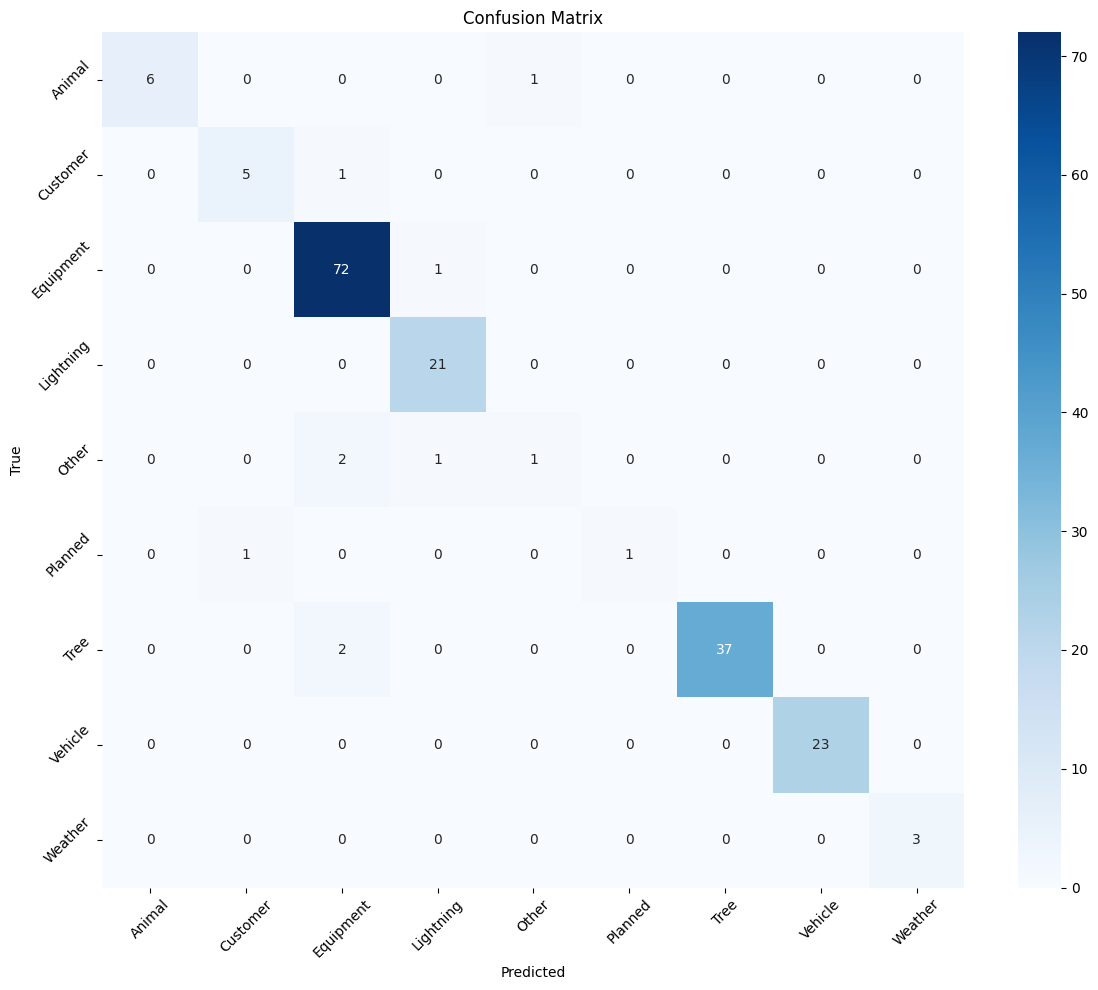

User input: High winds caused a branch to hit the transformer, leading to temporary power loss
Predicted label: Lightning
User input: Customer reported flickering lights; investigation ongoing to determine the cause
Predicted label: Equipment
User input: Customer reported flickering lights; investigation ongoing to determine the cause
Predicted label: Equipment
User input: Cable damage detected; restoration crew mobilized to replace affected lines
Predicted label: Equipment
User input: Tree fell on power lines during a storm, affecting multiple feeders; estimated restoration time is 4 hours.
Predicted label: Tree
User input: Lightning strike reported; power restored after circuit reset at Site0004
Predicted label: Lightning
User input: Snake found inside transformer at Site0007
Predicted label: Animal
User input: Scheduled maintenance on breaker at Site0003; power interruption expected from 10 PM to 2 AM.
Predicted label: Equipment
User input: storm led to power loss
Predicted label: L

In [ ]:

# Print final results
print("\nFinal Results:")
print(f"Average Accuracy across folds: {np.mean(fold_accuracies):.4f}")
print(f"Standard Deviation of Accuracy: {np.std(fold_accuracies):.4f}")

# Plot confusion matrix
plt.figure(figsize=(12, 10))
conf_matrix = confusion_matrix(all_labels, all_preds)
sns.heatmap(
    conf_matrix, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=list(label_map.values()),
    yticklabels=list(label_map.values())
)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()



In [ ]:
# User input and classification
while True:
    user_input = input("\nEnter text to classify (or 'quit' to exit): ")
    if user_input.lower() == 'quit':
        break
    predicted_label = classify_text(user_input, model, tokenizer)
    print(f"User input: {user_input}")
    print(f"Predicted label: {predicted_label}")

# bert with kfold


Unique Cause Classes with Counts:
----------------------------------------
Equipment               73
Tree                    39
Vehicle                 23
Lightning               21
Animal                   7
Customer                 6
Other                    4
Weather                  3
Planned                  2

Isolation Equipment Codes for Customer causes:
Isolation Equipment Code
Customer    5
Switch      1
Name: count, dtype: int64

Dataset shape: (178, 12)
Cause Label Mapping:
Animal: 0
Customer: 1
Equipment: 2
Lightning: 3
Other: 4
Planned: 5
Tree: 6
Vehicle: 7
Weather: 8

Isolation Equipment Label Mapping:
Breaker: 0
CO15: 1
CO15LB: 2
Customer: 3
Fuse: 4
Fuse CO15: 5
OCB: 6
R-OVR-1PT: 7
R100-4E: 8
R100E: 9
Recloser: 10
SECT200NLB: 11
Sectionalizer: 12
Service Restorer: 13
Switch: 14

Cause counts:
Cause
Equipment    73
Tree         39
Vehicle      23
Lightning    21
Animal        7
Customer      6
Other         4
Weather       3
Planned       2
Name: count, dtype: int64

I

Map: 100%|██████████| 142/142 [00:00<00:00, 12524.00 examples/s]

Map: 100%|██████████| 142/142 [00:00<00:00, 7660.24 examples/s]

Map: 100%|██████████| 36/36 [00:00<00:00, 2250.67 examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint a

Training Cause Model (Fold 1):


  0%|          | 0/90 [00:00<?, ?it/s]
                                               
  2%|▏         | 2/90 [21:35<01:54,  1.30s/it] 

{'loss': 1.4329, 'grad_norm': 3.174849271774292, 'learning_rate': 0.00016, 'epoch': 1.0}










                                               

  2%|▏         | 2/90 [21:35<01:54,  1.30s/it]

                                               

  2%|▏         | 2/90 [21:35<01:54,  1.30s/it]



{'eval_loss': 0.5687463283538818, 'eval_accuracy': 0.8888888888888888, 'eval_precision': 0.8148809523809524, 'eval_f1': 0.845053095053095, 'eval_runtime': 0.7283, 'eval_samples_per_second': 49.431, 'eval_steps_per_second': 6.865, 'epoch': 1.0}


 21%|██        | 19/90 [00:23<02:01,  1.72s/it]
                                               
  2%|▏         | 2/90 [21:53<01:54,  1.30s/it] 

{'loss': 0.5421, 'grad_norm': 0.6414727568626404, 'learning_rate': 0.00012, 'epoch': 2.0}







                                               

  2%|▏         | 2/90 [21:54<01:54,  1.30s/it]


                                               

  2%|▏         | 2/90 [21:54<01:54,  1.30s/it]



{'eval_loss': 0.2827592194080353, 'eval_accuracy': 0.9722222222222222, 'eval_precision': 0.9458333333333333, 'eval_f1': 0.9586894586894587, 'eval_runtime': 0.549, 'eval_samples_per_second': 65.568, 'eval_steps_per_second': 9.107, 'epoch': 2.0}


 41%|████      | 37/90 [00:41<01:14,  1.40s/it]
                                               
  2%|▏         | 2/90 [22:12<01:54,  1.30s/it]]

{'loss': 0.2829, 'grad_norm': 6.460018157958984, 'learning_rate': 8e-05, 'epoch': 3.0}







                                               

  2%|▏         | 2/90 [22:13<01:54,  1.30s/it]


                                               

  2%|▏         | 2/90 [22:13<01:54,  1.30s/it]



{'eval_loss': 0.1753813624382019, 'eval_accuracy': 0.9722222222222222, 'eval_precision': 0.949074074074074, 'eval_f1': 0.9595959595959597, 'eval_runtime': 0.5547, 'eval_samples_per_second': 64.898, 'eval_steps_per_second': 9.014, 'epoch': 3.0}


 61%|██████    | 55/90 [01:00<00:53,  1.54s/it]
                                               
  2%|▏         | 2/90 [22:32<01:54,  1.30s/it]

{'loss': 0.1835, 'grad_norm': 0.17863939702510834, 'learning_rate': 4e-05, 'epoch': 4.0}







                                               

  2%|▏         | 2/90 [22:32<01:54,  1.30s/it]



                                               

  2%|▏         | 2/90 [22:32<01:54,  1.30s/it]


{'eval_loss': 0.10622073709964752, 'eval_accuracy': 0.9722222222222222, 'eval_precision': 0.9722222222222222, 'eval_f1': 0.9722222222222222, 'eval_runtime': 0.6751, 'eval_samples_per_second': 53.327, 'eval_steps_per_second': 7.406, 'epoch': 4.0}


  2%|▏         | 2/90 [22:51<01:54,  1.30s/it] 

{'loss': 0.1011, 'grad_norm': 0.1251554787158966, 'learning_rate': 0.0, 'epoch': 5.0}







                                               

  2%|▏         | 2/90 [22:52<01:54,  1.30s/it]

                                               

  2%|▏         | 2/90 [22:52<01:54,  1.30s/it]




{'eval_loss': 0.09725170582532883, 'eval_accuracy': 0.9722222222222222, 'eval_precision': 0.9722222222222222, 'eval_f1': 0.9722222222222222, 'eval_runtime': 0.6355, 'eval_samples_per_second': 56.65, 'eval_steps_per_second': 7.868, 'epoch': 5.0}



100%|██████████| 90/90 [01:38<00:00,  1.10s/it]



{'train_runtime': 98.9372, 'train_samples_per_second': 7.176, 'train_steps_per_second': 0.91, 'train_loss': 0.5085232827398513, 'epoch': 5.0}

Training Isolation Model (Fold 1):


                                              
                                               
  2%|▏         | 2/90 [23:12<01:54,  1.30s/it] 

{'loss': 2.1275, 'grad_norm': 7.580377101898193, 'learning_rate': 0.00016, 'epoch': 1.0}








                                              
                                            
  2%|▏         | 2/90 [23:12<01:54,  1.30s/it]

                                             

                                              
                                            
  2%|▏         | 2/90 [23:12<01:54,  1.30s/it]

{'eval_loss': 2.2623183727264404, 'eval_accuracy': 0.3333333333333333, 'eval_precision': 0.12380952380952381, 'eval_f1': 0.17391304347826086, 'eval_runtime': 0.5738, 'eval_samples_per_second': 62.742, 'eval_steps_per_second': 8.714, 'epoch': 1.0}


                                              ]
  2%|▏         | 2/90 [23:32<01:54,  1.30s/it] 
                                              

{'loss': 1.5611, 'grad_norm': 7.952905178070068, 'learning_rate': 0.00012, 'epoch': 2.0}








                                              
                                            
  2%|▏         | 2/90 [23:33<01:54,  1.30s/it]

                                              
                                            
  2%|▏         | 2/90 [23:33<01:54,  1.30s/it]



{'eval_loss': 1.939873218536377, 'eval_accuracy': 0.4166666666666667, 'eval_precision': 0.3381481481481481, 'eval_f1': 0.32309203142536475, 'eval_runtime': 0.6251, 'eval_samples_per_second': 57.587, 'eval_steps_per_second': 7.998, 'epoch': 2.0}


                                              ]
                                               
  2%|▏         | 2/90 [23:52<01:54,  1.30s/it] 

{'loss': 1.0396, 'grad_norm': 8.03591537475586, 'learning_rate': 8e-05, 'epoch': 3.0}








                                              
                                            


                                              
                                            
  2%|▏         | 2/90 [23:53<01:54,  1.30s/it]



{'eval_loss': 1.3840086460113525, 'eval_accuracy': 0.5833333333333334, 'eval_precision': 0.724537037037037, 'eval_f1': 0.567005981136416, 'eval_runtime': 0.5853, 'eval_samples_per_second': 61.504, 'eval_steps_per_second': 8.542, 'epoch': 3.0}


                                              ]
                                               
  2%|▏         | 2/90 [24:11<01:54,  1.30s/it] 

{'loss': 0.7596, 'grad_norm': 5.934341907501221, 'learning_rate': 4e-05, 'epoch': 4.0}








                                              
                                            
  2%|▏         | 2/90 [24:12<01:54,  1.30s/it]


                                              
                                            
  2%|▏         | 2/90 [24:12<01:54,  1.30s/it]


{'eval_loss': 1.1625627279281616, 'eval_accuracy': 0.6111111111111112, 'eval_precision': 0.755787037037037, 'eval_f1': 0.6216356107660457, 'eval_runtime': 0.6169, 'eval_samples_per_second': 58.358, 'eval_steps_per_second': 8.105, 'epoch': 4.0}


                                              ]
                                               
  2%|▏         | 2/90 [24:31<01:54,  1.30s/it] 

{'loss': 0.5961, 'grad_norm': 3.2944555282592773, 'learning_rate': 0.0, 'epoch': 5.0}








                                              
                                            
  2%|▏         | 2/90 [24:32<01:54,  1.30s/it]



                                              
                                            
  2%|▏         | 2/90 [24:32<01:54,  1.30s/it]

{'eval_loss': 1.1980725526809692, 'eval_accuracy': 0.6666666666666666, 'eval_precision': 0.755787037037037, 'eval_f1': 0.665727321524423, 'eval_runtime': 0.6608, 'eval_samples_per_second': 54.481, 'eval_steps_per_second': 7.567, 'epoch': 5.0}


                                              
100%|██████████| 90/90 [01:39<00:00,  1.10s/it]



{'train_runtime': 99.3651, 'train_samples_per_second': 7.145, 'train_steps_per_second': 0.906, 'train_loss': 1.2167783631218805, 'epoch': 5.0}


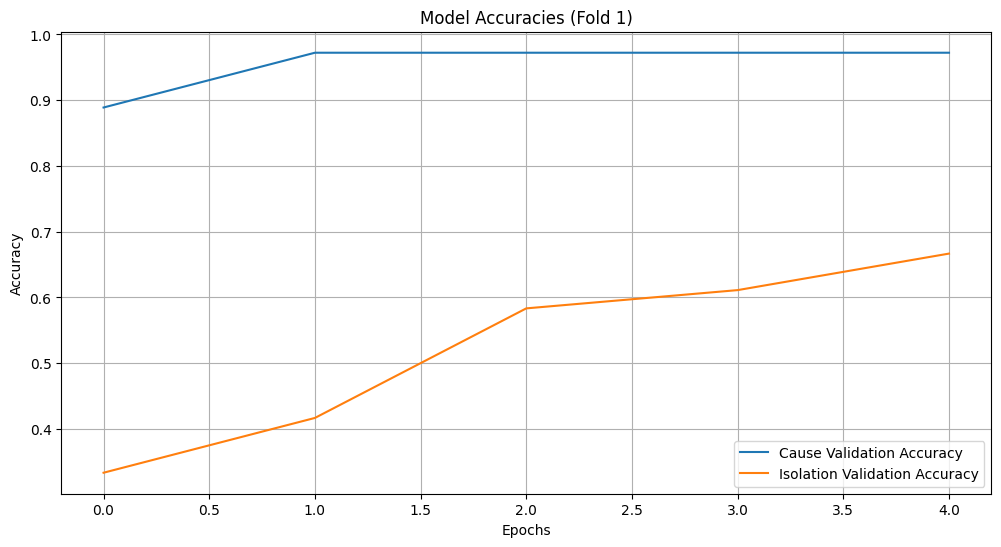

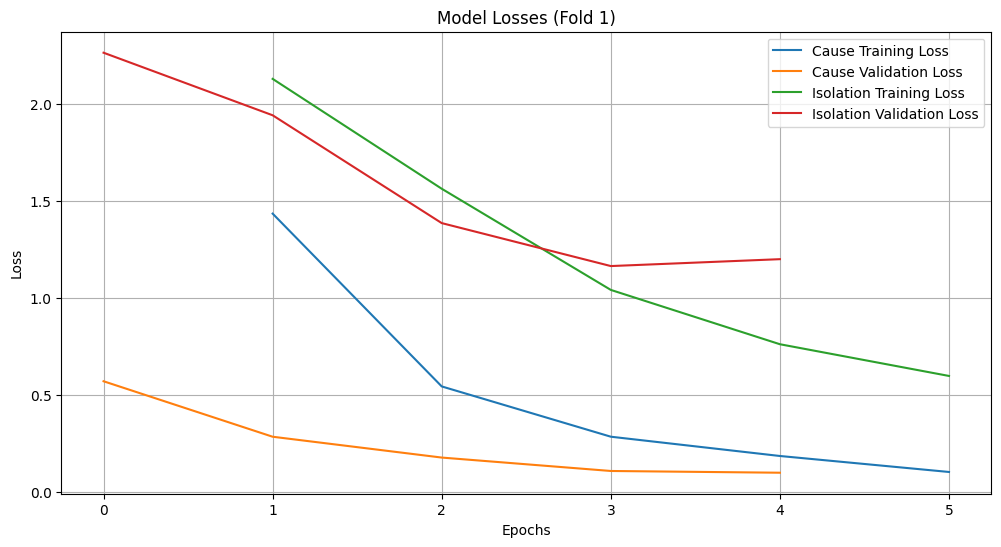


Evaluating models (Fold 1):


100%|██████████| 5/5 [00:00<00:00, 10.04it/s]

100%|██████████| 5/5 [00:00<00:00, 11.05it/s]




Fold 1 Times:
Training time: 0:03:19
Evaluation time: 0:00:01
Total time: 0:03:20

Fold 1 Results:
Cause - Accuracy: 0.9722, Precision: 0.9722, F1: 0.9722
Isolation - Accuracy: 0.6111, Precision: 0.7558, F1: 0.6216


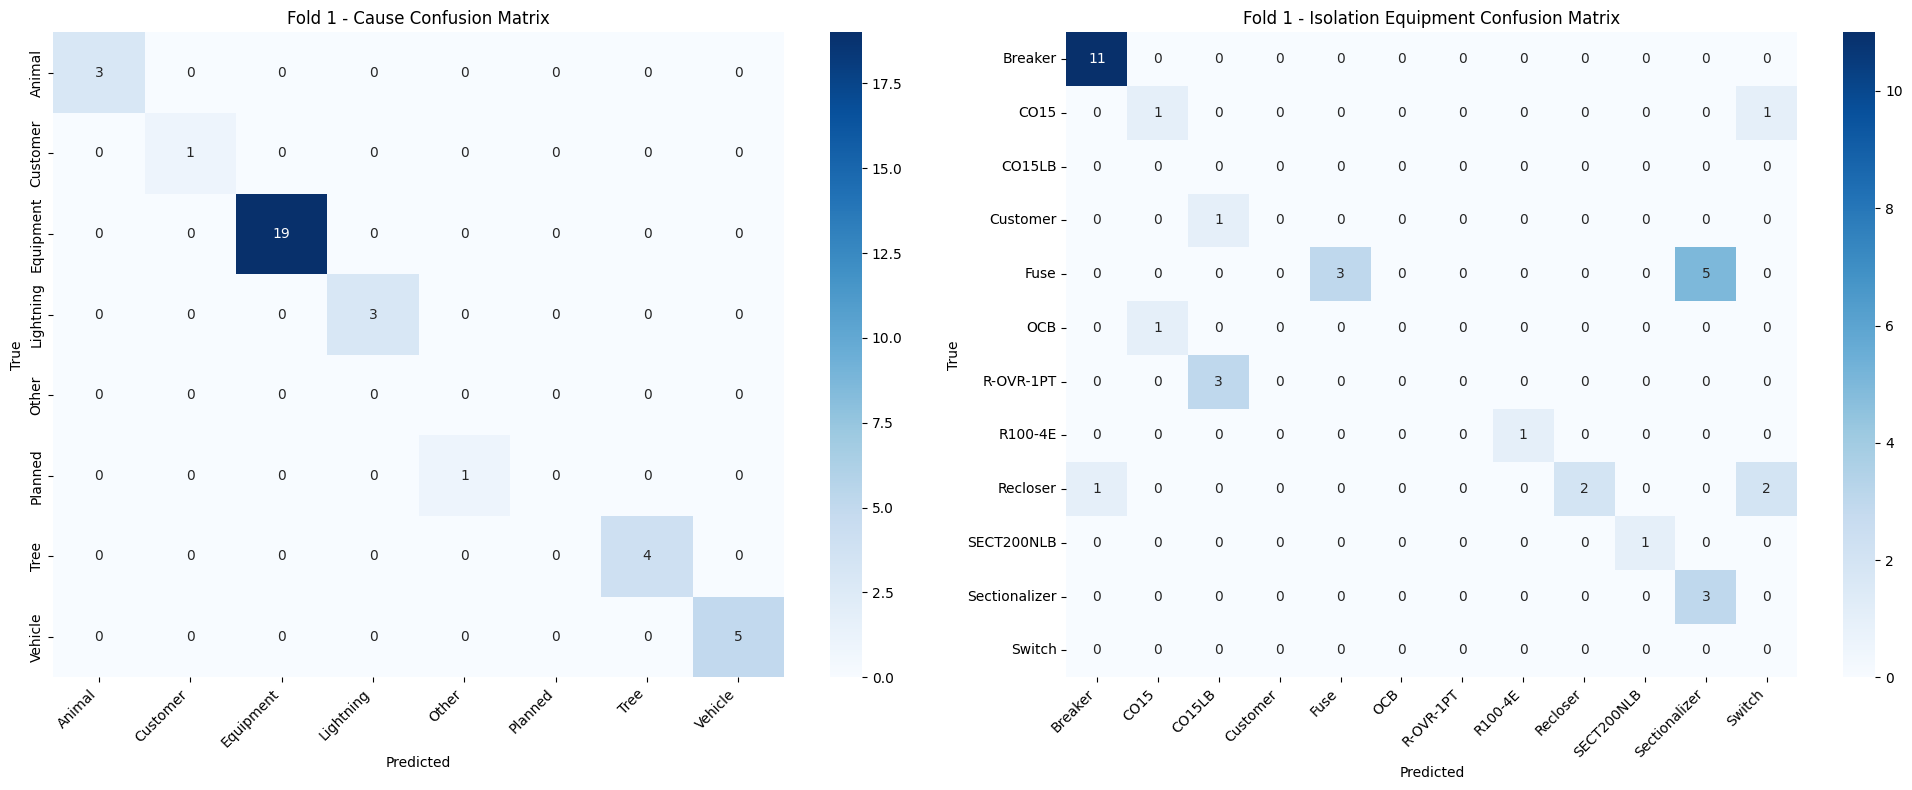


Classification Report - Cause (Fold 1):
              precision    recall  f1-score   support

      Animal       1.00      1.00      1.00         3
    Customer       1.00      1.00      1.00         1
   Equipment       1.00      1.00      1.00        19
   Lightning       1.00      1.00      1.00         3
       Other       0.00      0.00      0.00         0
     Planned       0.00      0.00      0.00         1
        Tree       1.00      1.00      1.00         4
     Vehicle       1.00      1.00      1.00         5

    accuracy                           0.97        36
   macro avg       0.75      0.75      0.75        36
weighted avg       0.97      0.97      0.97        36

Accuracy - Cause (Fold 1): 0.9722

Classification Report - Isolation Equipment (Fold 1):
               precision    recall  f1-score   support

      Breaker       0.92      1.00      0.96        11
         CO15       0.50      0.50      0.50         2
       CO15LB       0.00      0.00      0.00         

Map: 100%|██████████| 36/36 [00:00<00:00, 2172.78 examples/s]

Map: 100%|██████████| 36/36 [00:00<?, ? examples/s]
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'clas

Training Cause Model (Fold 2):


                                              
                                               
  2%|▏         | 2/90 [24:53<01:54,  1.30s/it] 

{'loss': 1.3782, 'grad_norm': 4.64025354385376, 'learning_rate': 0.00016, 'epoch': 1.0}








                                              
                                            
  2%|▏         | 2/90 [24:54<01:54,  1.30s/it]


                                              
                                            
  2%|▏         | 2/90 [24:54<01:54,  1.30s/it]


{'eval_loss': 0.626499593257904, 'eval_accuracy': 0.8333333333333334, 'eval_precision': 0.7791132478632479, 'eval_f1': 0.795679012345679, 'eval_runtime': 0.8858, 'eval_samples_per_second': 40.639, 'eval_steps_per_second': 5.644, 'epoch': 1.0}


                                              ]
                                               
  2%|▏         | 2/90 [25:14<01:54,  1.30s/it] 

{'loss': 0.4622, 'grad_norm': 9.401745796203613, 'learning_rate': 0.00012, 'epoch': 2.0}








                                              
                                            
  2%|▏         | 2/90 [25:15<01:54,  1.30s/it]



                                              
                                            
  2%|▏         | 2/90 [25:15<01:54,  1.30s/it]

{'eval_loss': 0.4336194396018982, 'eval_accuracy': 0.8611111111111112, 'eval_precision': 0.8549382716049383, 'eval_f1': 0.8440170940170941, 'eval_runtime': 0.5967, 'eval_samples_per_second': 60.334, 'eval_steps_per_second': 8.38, 'epoch': 2.0}


                                              ]
                                               
  2%|▏         | 2/90 [25:38<01:54,  1.30s/it] 

{'loss': 0.2707, 'grad_norm': 0.3084958791732788, 'learning_rate': 8e-05, 'epoch': 3.0}












                                              
                                            
                                              
                                            
  2%|▏         | 2/90 [25:38<01:54,  1.30s/it]



{'eval_loss': 0.31027960777282715, 'eval_accuracy': 0.9166666666666666, 'eval_precision': 0.9212962962962964, 'eval_f1': 0.910826210826211, 'eval_runtime': 0.7816, 'eval_samples_per_second': 46.062, 'eval_steps_per_second': 6.397, 'epoch': 3.0}


                                              ]
                                               
  2%|▏         | 2/90 [26:01<01:54,  1.30s/it] 

{'loss': 0.133, 'grad_norm': 0.15820589661598206, 'learning_rate': 4e-05, 'epoch': 4.0}












                                              
                                            
  2%|▏         | 2/90 [26:02<01:54,  1.30s/it]

                                              
                                            
  2%|▏         | 2/90 [26:02<01:54,  1.30s/it]

{'eval_loss': 0.3395547866821289, 'eval_accuracy': 0.9166666666666666, 'eval_precision': 0.9246031746031745, 'eval_f1': 0.912004662004662, 'eval_runtime': 0.736, 'eval_samples_per_second': 48.912, 'eval_steps_per_second': 6.793, 'epoch': 4.0}


                                              ]
                                               
  2%|▏         | 2/90 [26:22<01:54,  1.30s/it] 

{'loss': 0.0976, 'grad_norm': 0.1130899116396904, 'learning_rate': 0.0, 'epoch': 5.0}










                                              
                                            
  2%|▏         | 2/90 [26:23<01:54,  1.30s/it]

                                              
                                            
  2%|▏         | 2/90 [26:23<01:54,  1.30s/it]



{'eval_loss': 0.31976255774497986, 'eval_accuracy': 0.9444444444444444, 'eval_precision': 0.9629629629629631, 'eval_f1': 0.9478632478632478, 'eval_runtime': 1.0314, 'eval_samples_per_second': 34.906, 'eval_steps_per_second': 4.848, 'epoch': 5.0}


                                              
100%|██████████| 90/90 [01:47<00:00,  1.20s/it]



{'train_runtime': 107.9553, 'train_samples_per_second': 6.577, 'train_steps_per_second': 0.834, 'train_loss': 0.46833999024497136, 'epoch': 5.0}

Training Isolation Model (Fold 2):


                                              
                                               
  2%|▏         | 2/90 [26:45<01:54,  1.30s/it] 

{'loss': 2.1478, 'grad_norm': 6.108856201171875, 'learning_rate': 0.00016, 'epoch': 1.0}








                                              
                                            
  2%|▏         | 2/90 [26:46<01:54,  1.30s/it]



                                              
                                            
  2%|▏         | 2/90 [26:46<01:54,  1.30s/it]

{'eval_loss': 1.2134320735931396, 'eval_accuracy': 0.8055555555555556, 'eval_precision': 0.6893004115226337, 'eval_f1': 0.7339243498817967, 'eval_runtime': 0.7338, 'eval_samples_per_second': 49.062, 'eval_steps_per_second': 6.814, 'epoch': 1.0}


                                              ]
                                               
  2%|▏         | 2/90 [27:06<01:54,  1.30s/it] 

{'loss': 1.353, 'grad_norm': 5.628215312957764, 'learning_rate': 0.00012, 'epoch': 2.0}








                                              
                                            


                                              
                                            
  2%|▏         | 2/90 [27:07<01:54,  1.30s/it]


{'eval_loss': 0.7818418145179749, 'eval_accuracy': 0.8055555555555556, 'eval_precision': 0.7305555555555556, 'eval_f1': 0.753968253968254, 'eval_runtime': 0.6514, 'eval_samples_per_second': 55.264, 'eval_steps_per_second': 7.676, 'epoch': 2.0}


                                              ]
                                              
  2%|▏         | 2/90 [27:29<01:54,  1.30s/it] 

{'loss': 0.8781, 'grad_norm': 9.306112289428711, 'learning_rate': 8e-05, 'epoch': 3.0}










                                              
                                            
  2%|▏         | 2/90 [27:30<01:54,  1.30s/it]

                                              
                                            
  2%|▏         | 2/90 [27:30<01:54,  1.30s/it]



{'eval_loss': 0.5404295921325684, 'eval_accuracy': 0.8888888888888888, 'eval_precision': 0.9203703703703704, 'eval_f1': 0.892519493177388, 'eval_runtime': 0.9837, 'eval_samples_per_second': 36.597, 'eval_steps_per_second': 5.083, 'epoch': 3.0}


                                              ]
                                               
  2%|▏         | 2/90 [27:52<01:54,  1.30s/it] 

{'loss': 0.6588, 'grad_norm': 4.367820739746094, 'learning_rate': 4e-05, 'epoch': 4.0}










                                              
                                            
  2%|▏         | 2/90 [27:53<01:54,  1.30s/it]


                                              
                                            
  2%|▏         | 2/90 [27:53<01:54,  1.30s/it]


{'eval_loss': 0.47002527117729187, 'eval_accuracy': 0.8888888888888888, 'eval_precision': 0.9203703703703704, 'eval_f1': 0.892519493177388, 'eval_runtime': 0.8693, 'eval_samples_per_second': 41.411, 'eval_steps_per_second': 5.751, 'epoch': 4.0}


                                              ]
                                               
  2%|▏         | 2/90 [28:15<01:54,  1.30s/it] 

{'loss': 0.5144, 'grad_norm': 3.972848653793335, 'learning_rate': 0.0, 'epoch': 5.0}








                                              
                                            
  2%|▏         | 2/90 [28:16<01:54,  1.30s/it]

                                              
                                            
  2%|▏         | 2/90 [28:16<01:54,  1.30s/it]



{'eval_loss': 0.4109143614768982, 'eval_accuracy': 0.8888888888888888, 'eval_precision': 0.9259259259259258, 'eval_f1': 0.8966861598440546, 'eval_runtime': 0.99, 'eval_samples_per_second': 36.363, 'eval_steps_per_second': 5.05, 'epoch': 5.0}


                                              
100%|██████████| 90/90 [01:51<00:00,  1.24s/it]



{'train_runtime': 111.4528, 'train_samples_per_second': 6.37, 'train_steps_per_second': 0.808, 'train_loss': 1.1104246457417806, 'epoch': 5.0}


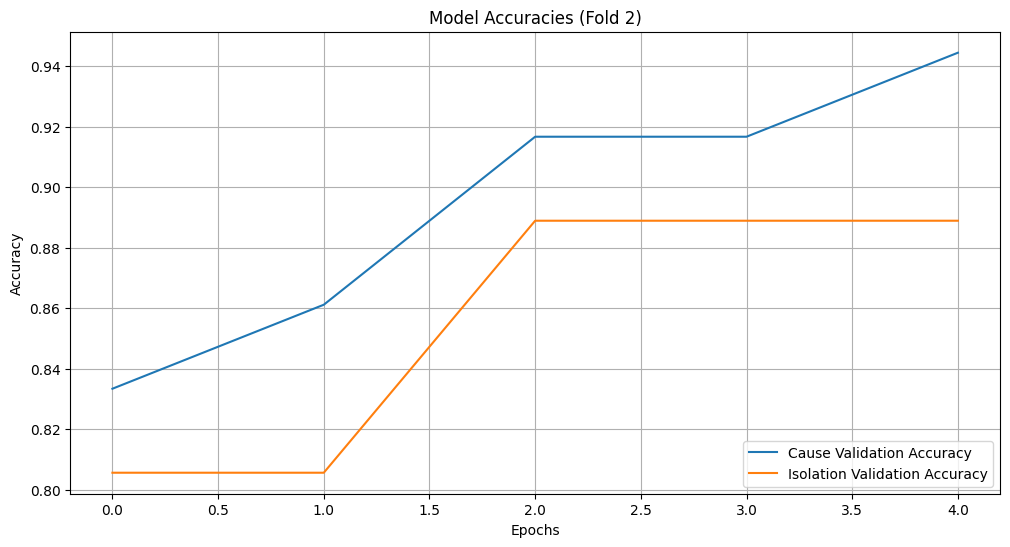

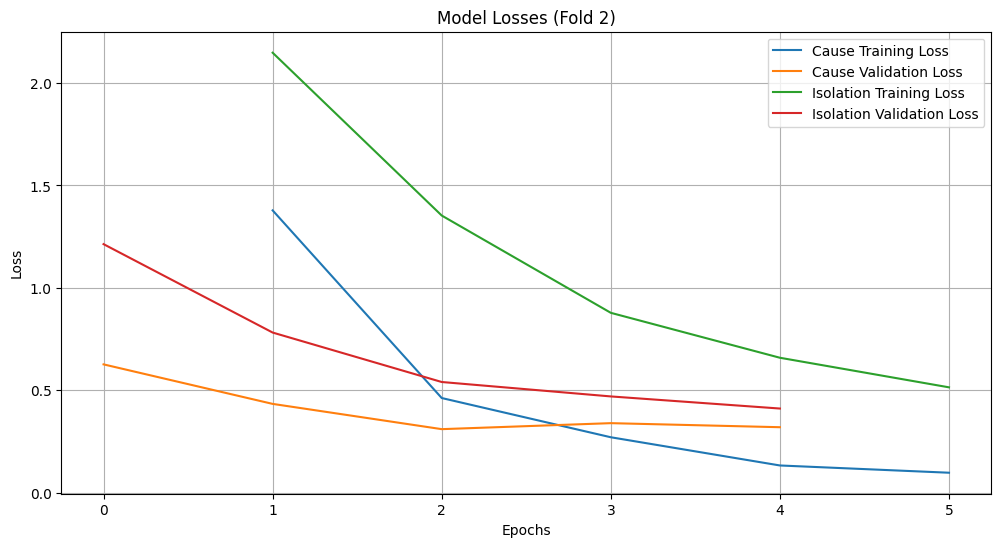


Evaluating models (Fold 2):


100%|██████████| 5/5 [00:00<00:00,  5.04it/s]

100%|██████████| 5/5 [00:00<00:00,  9.75it/s]




Fold 2 Times:
Training time: 0:03:40
Evaluation time: 0:00:01
Total time: 0:03:42

Fold 2 Results:
Cause - Accuracy: 0.9167, Precision: 0.9213, F1: 0.9108
Isolation - Accuracy: 0.8889, Precision: 0.9259, F1: 0.8967


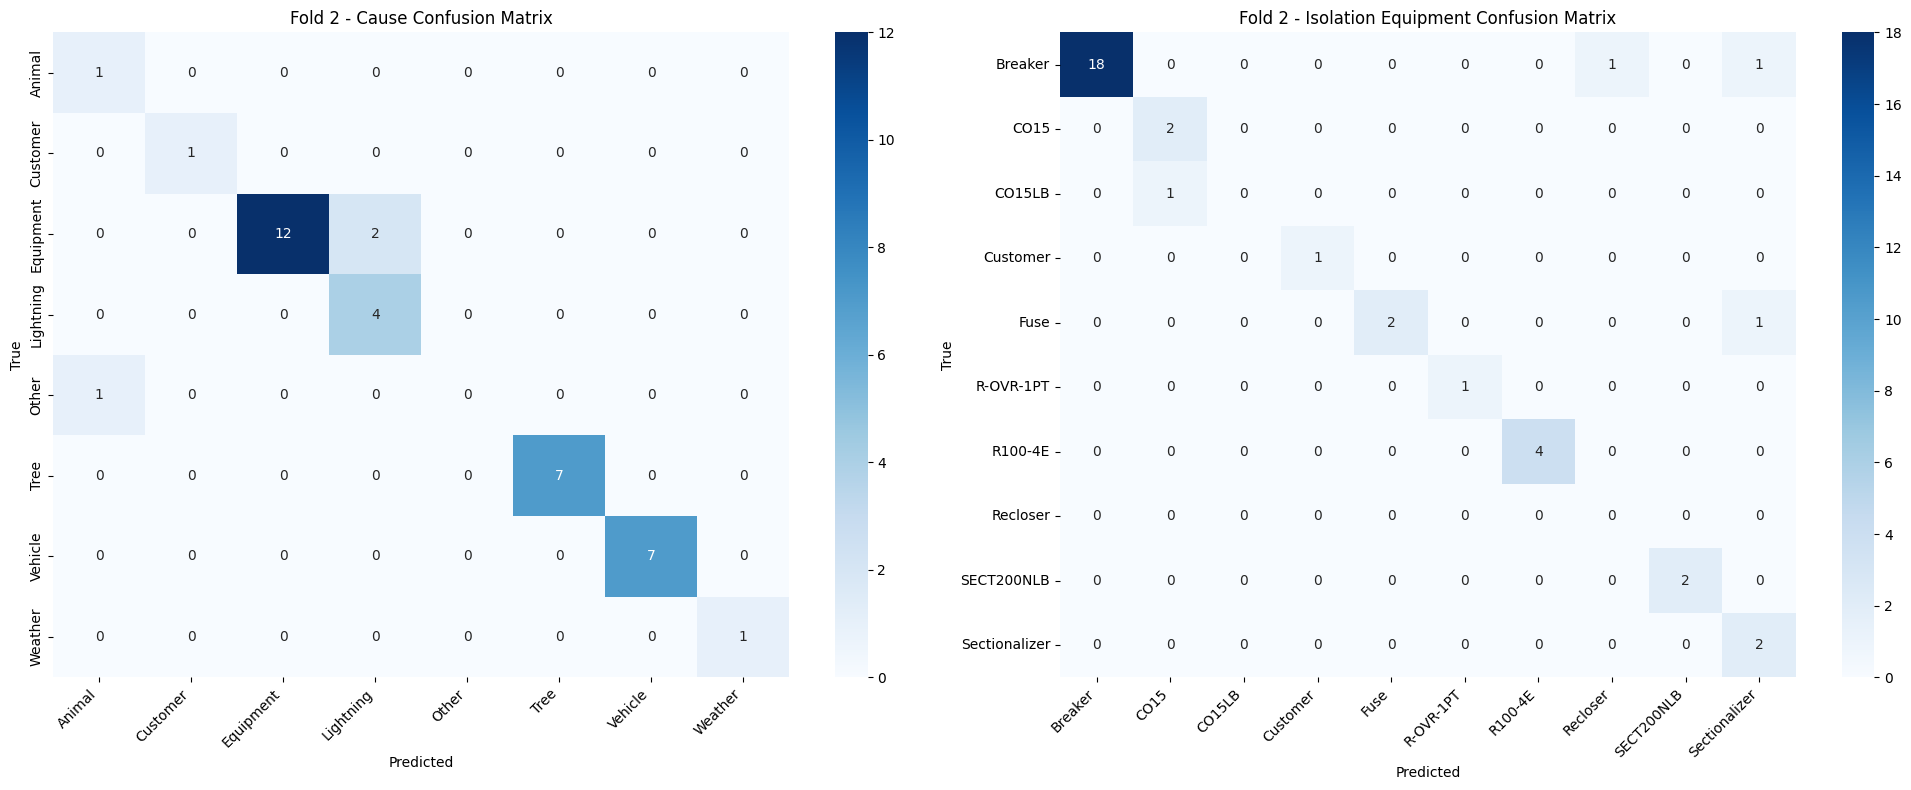


Classification Report - Cause (Fold 2):
              precision    recall  f1-score   support

      Animal       0.50      1.00      0.67         1
    Customer       1.00      1.00      1.00         1
   Equipment       1.00      0.86      0.92        14
   Lightning       0.67      1.00      0.80         4
       Other       0.00      0.00      0.00         1
        Tree       1.00      1.00      1.00         7
     Vehicle       1.00      1.00      1.00         7
     Weather       1.00      1.00      1.00         1

    accuracy                           0.92        36
   macro avg       0.77      0.86      0.80        36
weighted avg       0.92      0.92      0.91        36

Accuracy - Cause (Fold 2): 0.9167

Classification Report - Isolation Equipment (Fold 2):
               precision    recall  f1-score   support

      Breaker       1.00      0.90      0.95        20
         CO15       0.67      1.00      0.80         2
       CO15LB       0.00      0.00      0.00         

Map: 100%|██████████| 142/142 [00:00<00:00, 2985.54 examples/s]

Map: 100%|██████████| 36/36 [00:00<00:00, 274.87 examples/s]/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifie

Training Cause Model (Fold 3):


                                              
                                               
  2%|▏         | 2/90 [28:40<01:54,  1.30s/it] 

{'loss': 1.4898, 'grad_norm': 2.7206742763519287, 'learning_rate': 0.00016, 'epoch': 1.0}










                                              
                                            
  2%|▏         | 2/90 [28:41<01:54,  1.30s/it]

                                              
                                            
  2%|▏         | 2/90 [28:41<01:54,  1.30s/it]



{'eval_loss': 0.7347806096076965, 'eval_accuracy': 0.8611111111111112, 'eval_precision': 0.7492432336182335, 'eval_f1': 0.7993103448275861, 'eval_runtime': 0.86, 'eval_samples_per_second': 41.859, 'eval_steps_per_second': 5.814, 'epoch': 1.0}


                                              ]
  2%|▏         | 2/90 [29:02<01:54,  1.30s/it] 
                                              ]

{'loss': 0.5227, 'grad_norm': 1.2999285459518433, 'learning_rate': 0.00012, 'epoch': 2.0}











                                       


                                              
                                            
                                              
                                            
  2%|▏         | 2/90 [29:03<01:54,  1.30s/it]



{'eval_loss': 0.36644014716148376, 'eval_accuracy': 0.8888888888888888, 'eval_precision': 0.8134920634920635, 'eval_f1': 0.8447293447293447, 'eval_runtime': 1.3991, 'eval_samples_per_second': 25.73, 'eval_steps_per_second': 3.574, 'epoch': 2.0}


                                              ]
  2%|▏         | 2/90 [29:29<01:54,  1.30s/it] 
                                              

{'loss': 0.2547, 'grad_norm': 0.1959180384874344, 'learning_rate': 8e-05, 'epoch': 3.0}














                                              
                                            
  2%|▏         | 2/90 [29:31<01:54,  1.30s/it]

                                              
                                            
  2%|▏         | 2/90 [29:31<01:54,  1.30s/it]

{'eval_loss': 0.20127280056476593, 'eval_accuracy': 0.9444444444444444, 'eval_precision': 0.90491452991453, 'eval_f1': 0.9218518518518519, 'eval_runtime': 1.5187, 'eval_samples_per_second': 23.705, 'eval_steps_per_second': 3.292, 'epoch': 3.0}


                                              ]
                                               
  2%|▏         | 2/90 [29:55<01:54,  1.30s/it] 

{'loss': 0.1541, 'grad_norm': 0.12025291472673416, 'learning_rate': 4e-05, 'epoch': 4.0}










                                              
                                            
  2%|▏         | 2/90 [29:56<01:54,  1.30s/it]


                                              
                                            
  2%|▏         | 2/90 [29:56<01:54,  1.30s/it]


{'eval_loss': 0.14994053542613983, 'eval_accuracy': 0.9444444444444444, 'eval_precision': 0.9166666666666666, 'eval_f1': 0.925925925925926, 'eval_runtime': 0.9903, 'eval_samples_per_second': 36.353, 'eval_steps_per_second': 5.049, 'epoch': 4.0}


                                              ]
                                               
  2%|▏         | 2/90 [30:22<01:54,  1.30s/it] 

{'loss': 0.0884, 'grad_norm': 0.12372639030218124, 'learning_rate': 0.0, 'epoch': 5.0}










                                              
                                            
  2%|▏         | 2/90 [30:24<01:54,  1.30s/it]

                                              
                                            
100%|██████████| 90/90 [02:02<00:00,  1.40s/it]


{'eval_loss': 0.12841951847076416, 'eval_accuracy': 0.9444444444444444, 'eval_precision': 0.9166666666666666, 'eval_f1': 0.925925925925926, 'eval_runtime': 2.1149, 'eval_samples_per_second': 17.022, 'eval_steps_per_second': 2.364, 'epoch': 5.0}


                                              
100%|██████████| 90/90 [02:03<00:00,  1.38s/it]



{'train_runtime': 123.9214, 'train_samples_per_second': 5.729, 'train_steps_per_second': 0.726, 'train_loss': 0.5019168244467841, 'epoch': 5.0}

Training Isolation Model (Fold 3):


                                              
                                               
  2%|▏         | 2/90 [30:50<01:54,  1.30s/it] 

{'loss': 2.2286, 'grad_norm': 8.393298149108887, 'learning_rate': 0.00016, 'epoch': 1.0}














                                              
                                            
  2%|▏         | 2/90 [30:51<01:54,  1.30s/it]

                                              
                                            
  2%|▏         | 2/90 [30:51<01:54,  1.30s/it]

{'eval_loss': 1.4603391885757446, 'eval_accuracy': 0.5555555555555556, 'eval_precision': 0.3142857142857143, 'eval_f1': 0.3991769547325103, 'eval_runtime': 1.2046, 'eval_samples_per_second': 29.885, 'eval_steps_per_second': 4.151, 'epoch': 1.0}


                                              ]
                                              
  2%|▏         | 2/90 [31:12<01:54,  1.30s/it] 

{'loss': 1.387, 'grad_norm': 5.955071449279785, 'learning_rate': 0.00012, 'epoch': 2.0}










                                              
                                            
 40%|████      | 36/90 [00:46<00:50,  1.08it/s]

                                              
                                            
  2%|▏         | 2/90 [31:13<01:54,  1.30s/it]


{'eval_loss': 0.7595153450965881, 'eval_accuracy': 0.8888888888888888, 'eval_precision': 0.8486111111111111, 'eval_f1': 0.8599240265906931, 'eval_runtime': 1.1741, 'eval_samples_per_second': 30.661, 'eval_steps_per_second': 4.259, 'epoch': 2.0}


                                              ]
  2%|▏         | 2/90 [31:36<01:54,  1.30s/it] 
                                              

{'loss': 0.8148, 'grad_norm': 11.714335441589355, 'learning_rate': 8e-05, 'epoch': 3.0}














                                              
                                            
  2%|▏         | 2/90 [31:37<01:54,  1.30s/it]
                                              
                                            
  2%|▏         | 2/90 [31:37<01:54,  1.30s/it]


{'eval_loss': 0.5150638818740845, 'eval_accuracy': 0.8888888888888888, 'eval_precision': 0.9027777777777778, 'eval_f1': 0.8817901234567901, 'eval_runtime': 1.2724, 'eval_samples_per_second': 28.294, 'eval_steps_per_second': 3.93, 'epoch': 3.0}


                                              ]
                                               
  2%|▏         | 2/90 [31:56<01:54,  1.30s/it] 

{'loss': 0.5803, 'grad_norm': 1.5994410514831543, 'learning_rate': 4e-05, 'epoch': 4.0}










                                              
                                            
 80%|████████  | 72/90 [01:31<00:17,  1.05it/s]

                                              
                                            
  2%|▏         | 2/90 [31:58<01:54,  1.30s/it]


{'eval_loss': 0.4437233507633209, 'eval_accuracy': 0.9444444444444444, 'eval_precision': 0.9777777777777779, 'eval_f1': 0.9579579579579581, 'eval_runtime': 1.1205, 'eval_samples_per_second': 32.129, 'eval_steps_per_second': 4.462, 'epoch': 4.0}


                                              ]
                                               
  2%|▏         | 2/90 [32:18<01:54,  1.30s/it] 

{'loss': 0.4337, 'grad_norm': 5.032353401184082, 'learning_rate': 0.0, 'epoch': 5.0}











                                              


                                              
                                            
  2%|▏         | 2/90 [32:20<01:54,  1.30s/it]

                                            
  2%|▏         | 2/90 [32:20<01:54,  1.30s/it]


{'eval_loss': 0.4067115783691406, 'eval_accuracy': 0.9166666666666666, 'eval_precision': 0.9500000000000001, 'eval_f1': 0.9305555555555556, 'eval_runtime': 1.258, 'eval_samples_per_second': 28.618, 'eval_steps_per_second': 3.975, 'epoch': 5.0}


                                              
100%|██████████| 90/90 [01:54<00:00,  1.27s/it]



{'train_runtime': 114.7189, 'train_samples_per_second': 6.189, 'train_steps_per_second': 0.785, 'train_loss': 1.0888830714755589, 'epoch': 5.0}


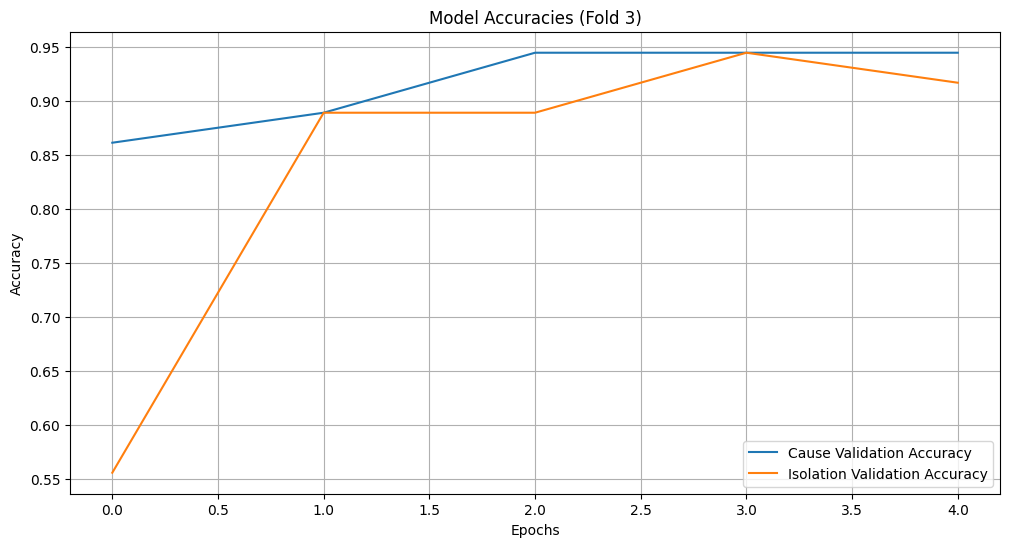

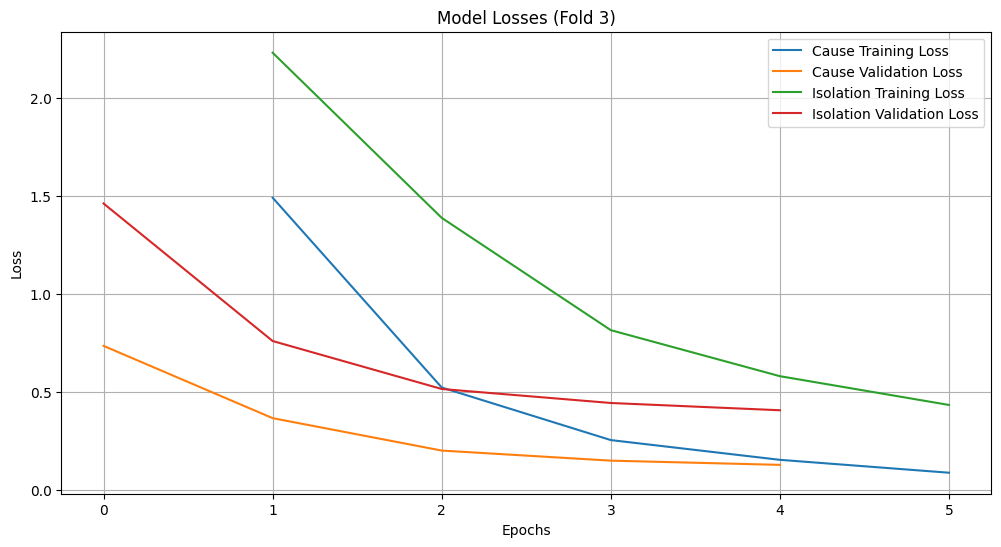


Evaluating models (Fold 3):


100%|██████████| 5/5 [00:00<00:00,  6.12it/s]

100%|██████████| 5/5 [00:00<00:00,  9.35it/s]




Fold 3 Times:
Training time: 0:03:59
Evaluation time: 0:00:02
Total time: 0:04:01

Fold 3 Results:
Cause - Accuracy: 0.9444, Precision: 0.9167, F1: 0.9259
Isolation - Accuracy: 0.9167, Precision: 0.9500, F1: 0.9306


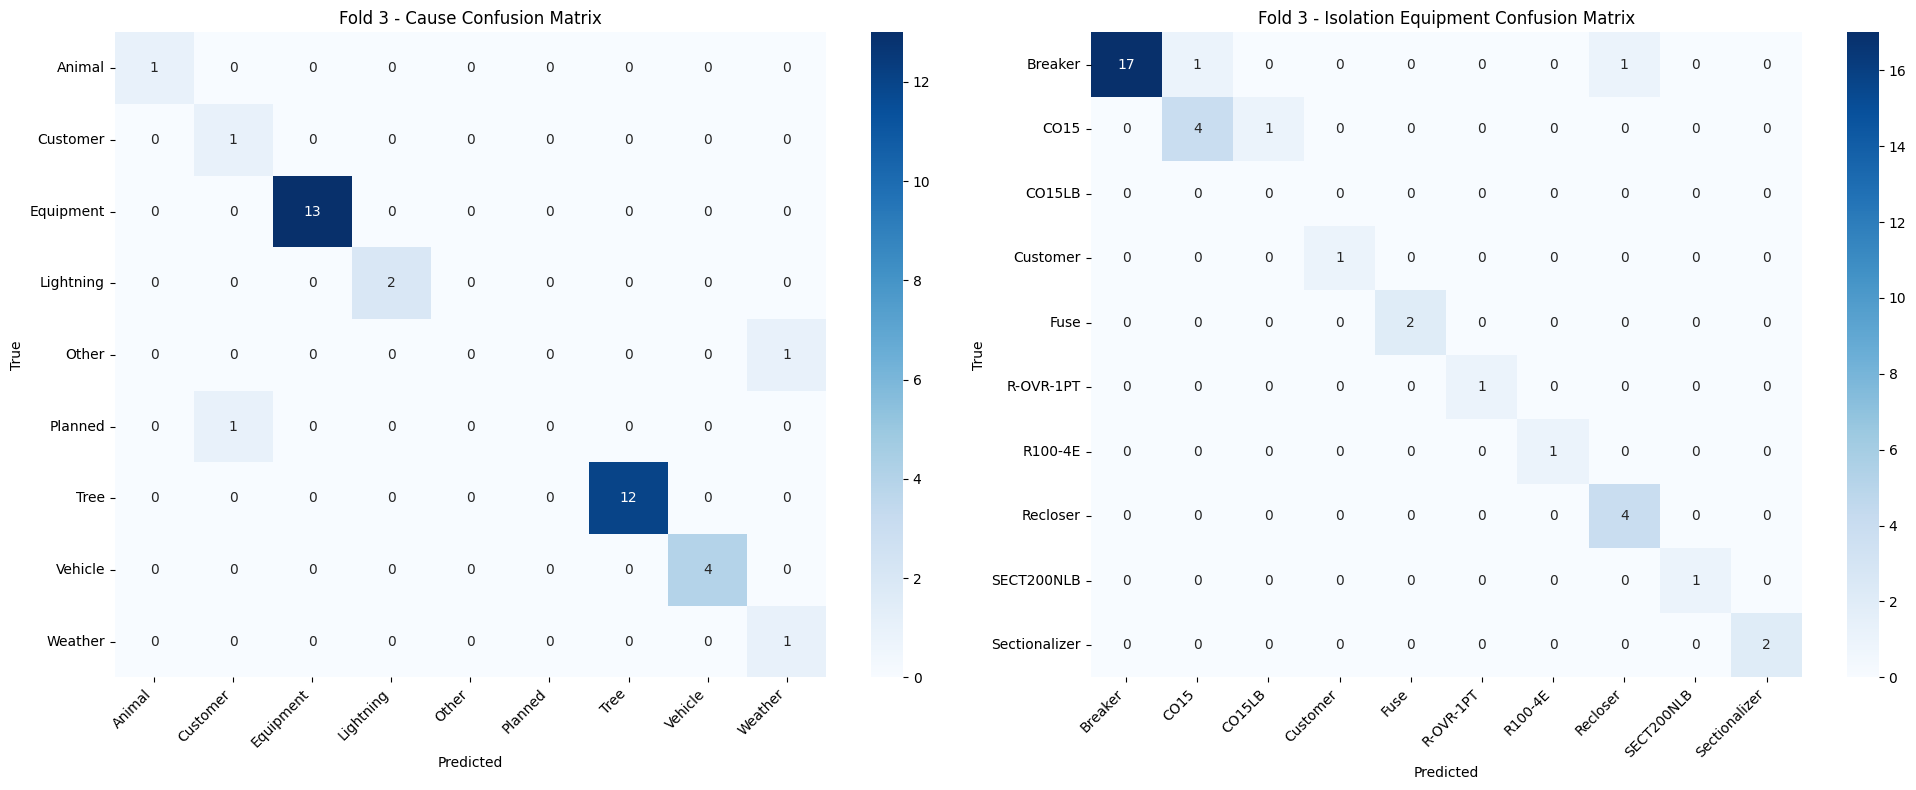


Classification Report - Cause (Fold 3):
              precision    recall  f1-score   support

      Animal       1.00      1.00      1.00         1
    Customer       0.50      1.00      0.67         1
   Equipment       1.00      1.00      1.00        13
   Lightning       1.00      1.00      1.00         2
       Other       0.00      0.00      0.00         1
     Planned       0.00      0.00      0.00         1
        Tree       1.00      1.00      1.00        12
     Vehicle       1.00      1.00      1.00         4
     Weather       0.50      1.00      0.67         1

    accuracy                           0.94        36
   macro avg       0.67      0.78      0.70        36
weighted avg       0.92      0.94      0.93        36

Accuracy - Cause (Fold 3): 0.9444

Classification Report - Isolation Equipment (Fold 3):
               precision    recall  f1-score   support

      Breaker       1.00      0.89      0.94        19
         CO15       0.80      0.80      0.80         5

Map: 100%|██████████| 35/35 [00:00<00:00, 4202.71 examples/s]

Map: 100%|██████████| 143/143 [00:00<00:00, 9076.52 examples/s]

Map: 100%|██████████| 35/35 [00:00<00:00, 6250.83 examples/s]s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at

Training Cause Model (Fold 4):


                                              
                                               
  2%|▏         | 2/90 [32:47<01:54,  1.30s/it] 

{'loss': 1.371, 'grad_norm': 6.926588535308838, 'learning_rate': 0.00016, 'epoch': 1.0}










                                              
                                            


                                              
                                            
  2%|▏         | 2/90 [32:49<01:54,  1.30s/it]


{'eval_loss': 0.8473278880119324, 'eval_accuracy': 0.7714285714285715, 'eval_precision': 0.7114285714285714, 'eval_f1': 0.7314285714285713, 'eval_runtime': 1.2673, 'eval_samples_per_second': 27.618, 'eval_steps_per_second': 3.945, 'epoch': 1.0}


                                              ]
                                              
  2%|▏         | 2/90 [33:14<01:54,  1.30s/it] 

{'loss': 0.4105, 'grad_norm': 0.6574922800064087, 'learning_rate': 0.00012, 'epoch': 2.0}










                                              
                                            


                                              
                                            
  2%|▏         | 2/90 [33:16<01:54,  1.30s/it]


{'eval_loss': 0.5406474471092224, 'eval_accuracy': 0.9142857142857143, 'eval_precision': 0.8732142857142857, 'eval_f1': 0.8893074471167777, 'eval_runtime': 1.8999, 'eval_samples_per_second': 18.422, 'eval_steps_per_second': 2.632, 'epoch': 2.0}


                                              ]
  2%|▏         | 2/90 [33:38<01:54,  1.30s/it] 
                                              ]

{'loss': 0.1498, 'grad_norm': 0.7198069095611572, 'learning_rate': 8e-05, 'epoch': 3.0}








                                              
                                            

100%|██████████| 5/5 [00:01<00:00,  3.70it/s]

                                              
                                            
  2%|▏         | 2/90 [33:39<01:54,  1.30s/it]


{'eval_loss': 0.41186943650245667, 'eval_accuracy': 0.9142857142857143, 'eval_precision': 0.8647619047619047, 'eval_f1': 0.8877551020408163, 'eval_runtime': 1.403, 'eval_samples_per_second': 24.947, 'eval_steps_per_second': 3.564, 'epoch': 3.0}


                                              ]
  2%|▏         | 2/90 [34:02<01:54,  1.30s/it] 
                                              ]

{'loss': 0.0608, 'grad_norm': 0.14682456851005554, 'learning_rate': 4e-05, 'epoch': 4.0}








                                              
                                            
  2%|▏         | 2/90 [34:03<01:54,  1.30s/it]

                                              
                                            
  2%|▏         | 2/90 [34:03<01:54,  1.30s/it]



{'eval_loss': 0.40925756096839905, 'eval_accuracy': 0.9142857142857143, 'eval_precision': 0.8732142857142857, 'eval_f1': 0.8893074471167777, 'eval_runtime': 1.0612, 'eval_samples_per_second': 32.981, 'eval_steps_per_second': 4.712, 'epoch': 4.0}


                                              ]
                                               
  2%|▏         | 2/90 [34:26<01:54,  1.30s/it] 

{'loss': 0.0306, 'grad_norm': 0.17867816984653473, 'learning_rate': 0.0, 'epoch': 5.0}











                                              
                                            
  2%|▏         | 2/90 [34:27<01:54,  1.30s/it]



                                              
                                            
  2%|▏         | 2/90 [34:27<01:54,  1.30s/it]


{'eval_loss': 0.45736128091812134, 'eval_accuracy': 0.9142857142857143, 'eval_precision': 0.8732142857142857, 'eval_f1': 0.8893074471167777, 'eval_runtime': 1.0795, 'eval_samples_per_second': 32.423, 'eval_steps_per_second': 4.632, 'epoch': 5.0}


                                              
100%|██████████| 90/90 [02:01<00:00,  1.35s/it]



{'train_runtime': 121.7236, 'train_samples_per_second': 5.874, 'train_steps_per_second': 0.739, 'train_loss': 0.4045195347732968, 'epoch': 5.0}

Training Isolation Model (Fold 4):


                                              
  2%|▏         | 2/90 [34:46<01:54,  1.30s/it] 
                                              ]

{'loss': 1.9733, 'grad_norm': 7.930236339569092, 'learning_rate': 0.00016, 'epoch': 1.0}










                                              
                                            
  2%|▏         | 2/90 [34:47<01:54,  1.30s/it]

                                              
                                            
  2%|▏         | 2/90 [34:47<01:54,  1.30s/it]



{'eval_loss': 1.5969858169555664, 'eval_accuracy': 0.45714285714285713, 'eval_precision': 0.24418811002661936, 'eval_f1': 0.3119327731092437, 'eval_runtime': 1.115, 'eval_samples_per_second': 31.389, 'eval_steps_per_second': 4.484, 'epoch': 1.0}


                                              ]
                                               
  2%|▏         | 2/90 [35:06<01:54,  1.30s/it] 

{'loss': 1.1948, 'grad_norm': 4.488974094390869, 'learning_rate': 0.00012, 'epoch': 2.0}










                                              
                                            
 40%|████      | 36/90 [00:38<00:49,  1.09it/s]

                                              
                                            
  2%|▏         | 2/90 [35:08<01:54,  1.30s/it]


{'eval_loss': 1.3319429159164429, 'eval_accuracy': 0.6285714285714286, 'eval_precision': 0.44213685474189673, 'eval_f1': 0.5136054421768707, 'eval_runtime': 1.2077, 'eval_samples_per_second': 28.98, 'eval_steps_per_second': 4.14, 'epoch': 2.0}


                                              ]
                                               
  2%|▏         | 2/90 [35:27<01:54,  1.30s/it] 

{'loss': 0.7898, 'grad_norm': 3.1328163146972656, 'learning_rate': 8e-05, 'epoch': 3.0}














                                              
                                            
  2%|▏         | 2/90 [35:29<01:54,  1.30s/it]
                                              ]
                                            
  2%|▏         | 2/90 [35:29<01:54,  1.30s/it]


{'eval_loss': 0.7690108418464661, 'eval_accuracy': 0.8, 'eval_precision': 0.703076923076923, 'eval_f1': 0.7428571428571429, 'eval_runtime': 1.5526, 'eval_samples_per_second': 22.542, 'eval_steps_per_second': 3.22, 'epoch': 3.0}


                                              ]
  2%|▏         | 2/90 [35:49<01:54,  1.30s/it] 
                                              

{'loss': 0.5901, 'grad_norm': 3.5845401287078857, 'learning_rate': 4e-05, 'epoch': 4.0}














                                              
                                            

                                              
  2%|▏         | 2/90 [35:51<01:54,  1.30s/it]


{'eval_loss': 0.8161083459854126, 'eval_accuracy': 0.8, 'eval_precision': 0.7816483516483517, 'eval_f1': 0.7680272108843537, 'eval_runtime': 1.6177, 'eval_samples_per_second': 21.636, 'eval_steps_per_second': 3.091, 'epoch': 4.0}


                                              ]
                                               
  2%|▏         | 2/90 [36:11<01:54,  1.30s/it] 

{'loss': 0.4706, 'grad_norm': 2.5710227489471436, 'learning_rate': 0.0, 'epoch': 5.0}











                                              
                                            
  2%|▏         | 2/90 [36:13<01:54,  1.30s/it]

                                              
                                            
  2%|▏         | 2/90 [36:13<01:54,  1.30s/it]


{'eval_loss': 0.6716025471687317, 'eval_accuracy': 0.8, 'eval_precision': 0.7816483516483517, 'eval_f1': 0.7680272108843537, 'eval_runtime': 1.2136, 'eval_samples_per_second': 28.84, 'eval_steps_per_second': 4.12, 'epoch': 5.0}


                                              
100%|██████████| 90/90 [01:45<00:00,  1.17s/it]



{'train_runtime': 105.0542, 'train_samples_per_second': 6.806, 'train_steps_per_second': 0.857, 'train_loss': 1.0037149323357477, 'epoch': 5.0}


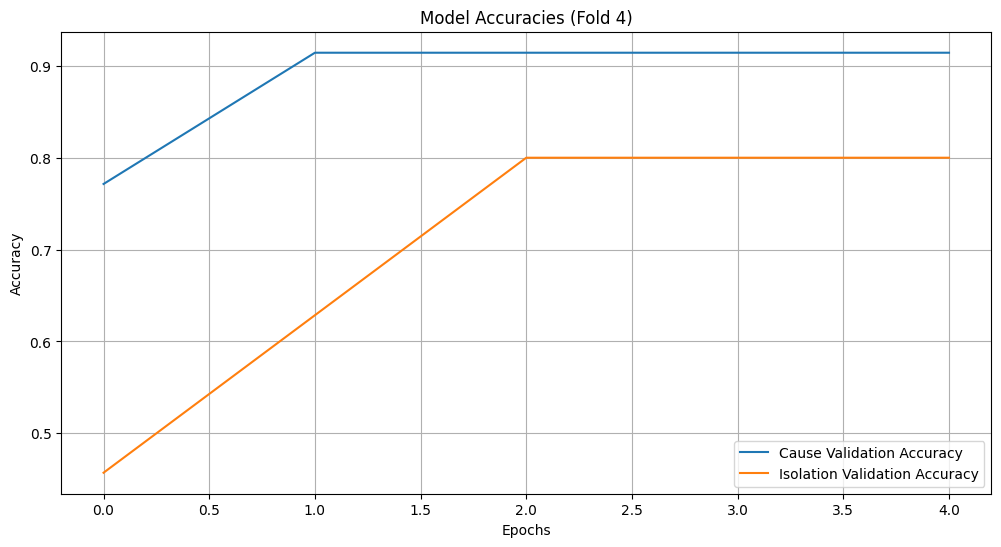

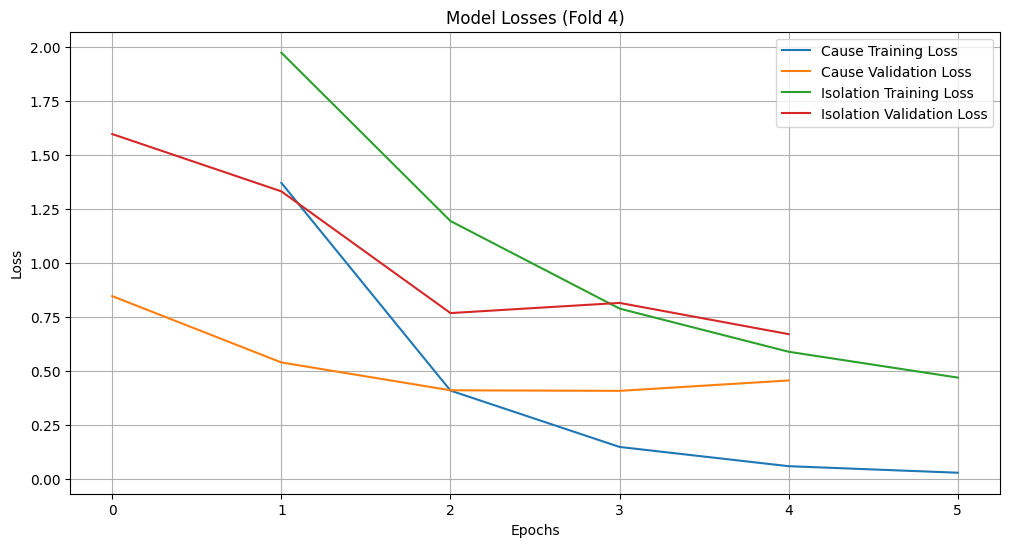


Evaluating models (Fold 4):


100%|██████████| 5/5 [00:00<00:00,  9.40it/s]




Fold 4 Times:
Training time: 0:03:47
Evaluation time: 0:00:01
Total time: 0:03:49

Fold 4 Results:
Cause - Accuracy: 0.9143, Precision: 0.8732, F1: 0.8893
Isolation - Accuracy: 0.8000, Precision: 0.7816, F1: 0.7680


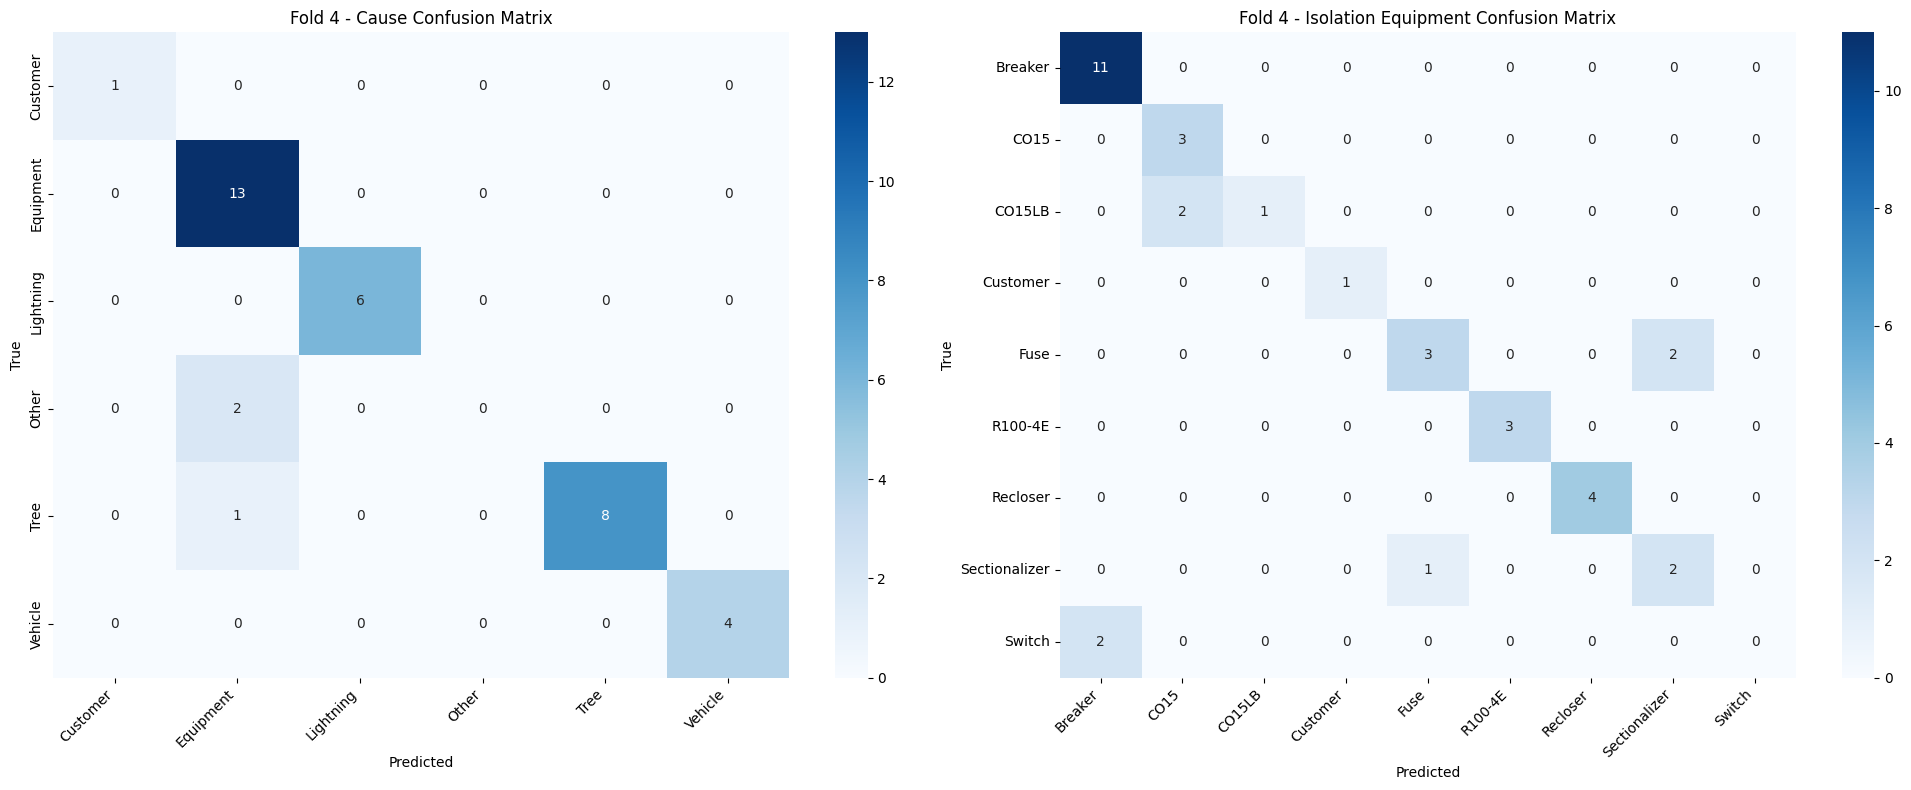


Classification Report - Cause (Fold 4):
              precision    recall  f1-score   support

    Customer       1.00      1.00      1.00         1
   Equipment       0.81      1.00      0.90        13
   Lightning       1.00      1.00      1.00         6
       Other       0.00      0.00      0.00         2
        Tree       1.00      0.89      0.94         9
     Vehicle       1.00      1.00      1.00         4

    accuracy                           0.91        35
   macro avg       0.80      0.81      0.81        35
weighted avg       0.87      0.91      0.89        35

Accuracy - Cause (Fold 4): 0.9143

Classification Report - Isolation Equipment (Fold 4):
               precision    recall  f1-score   support

      Breaker       0.85      1.00      0.92        11
         CO15       0.60      1.00      0.75         3
       CO15LB       1.00      0.33      0.50         3
     Customer       1.00      1.00      1.00         1
         Fuse       0.75      0.60      0.67       

Map: 100%|██████████| 35/35 [00:00<00:00, 6344.57 examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifie

Training Cause Model (Fold 5):


                                              
  2%|▏         | 2/90 [36:36<01:54,  1.30s/it] 
                                              

{'loss': 1.393, 'grad_norm': 3.7774581909179688, 'learning_rate': 0.00016, 'epoch': 1.0}














                                              
                                            
                                              
                                            
  2%|▏         | 2/90 [36:38<01:54,  1.30s/it]



{'eval_loss': 0.7999071478843689, 'eval_accuracy': 0.8285714285714286, 'eval_precision': 0.7218253968253968, 'eval_f1': 0.7659802102659244, 'eval_runtime': 1.513, 'eval_samples_per_second': 23.133, 'eval_steps_per_second': 3.305, 'epoch': 1.0}


                                              ]
                                               
  2%|▏         | 2/90 [36:56<01:54,  1.30s/it] 

{'loss': 0.4698, 'grad_norm': 1.3522425889968872, 'learning_rate': 0.00012, 'epoch': 2.0}










                                              
                                            
  2%|▏         | 2/90 [36:57<01:54,  1.30s/it]

                                              
                                            
  2%|▏         | 2/90 [36:57<01:54,  1.30s/it]



{'eval_loss': 0.6078287363052368, 'eval_accuracy': 0.8857142857142857, 'eval_precision': 0.8147959183673469, 'eval_f1': 0.842051282051282, 'eval_runtime': 1.215, 'eval_samples_per_second': 28.806, 'eval_steps_per_second': 4.115, 'epoch': 2.0}


                                              ]
                                               
  2%|▏         | 2/90 [37:15<01:54,  1.30s/it] 

{'loss': 0.203, 'grad_norm': 0.2755306363105774, 'learning_rate': 8e-05, 'epoch': 3.0}










                                              
                                            
  2%|▏         | 2/90 [37:17<01:54,  1.30s/it]

                                              
                                            
  2%|▏         | 2/90 [37:17<01:54,  1.30s/it]



{'eval_loss': 0.6215547919273376, 'eval_accuracy': 0.9142857142857143, 'eval_precision': 0.8722689075630252, 'eval_f1': 0.8850998463901689, 'eval_runtime': 1.294, 'eval_samples_per_second': 27.047, 'eval_steps_per_second': 3.864, 'epoch': 3.0}


                                              ]
                                               
  2%|▏         | 2/90 [37:34<01:54,  1.30s/it] 

{'loss': 0.1128, 'grad_norm': 4.072874069213867, 'learning_rate': 4e-05, 'epoch': 4.0}










                                              
                                            
 80%|████████  | 72/90 [01:16<00:14,  1.20it/s]

                                              
                                            
  2%|▏         | 2/90 [37:36<01:54,  1.30s/it]


{'eval_loss': 0.5534029603004456, 'eval_accuracy': 0.9142857142857143, 'eval_precision': 0.8928571428571429, 'eval_f1': 0.8971428571428571, 'eval_runtime': 1.4266, 'eval_samples_per_second': 24.534, 'eval_steps_per_second': 3.505, 'epoch': 4.0}


                                              ]
                                               
  2%|▏         | 2/90 [37:54<01:54,  1.30s/it] 

{'loss': 0.061, 'grad_norm': 0.3030090928077698, 'learning_rate': 0.0, 'epoch': 5.0}












                                              
                                            
  2%|▏         | 2/90 [37:56<01:54,  1.30s/it]


                                              
                                            
  2%|▏         | 2/90 [37:56<01:54,  1.30s/it]


{'eval_loss': 0.5386852622032166, 'eval_accuracy': 0.9142857142857143, 'eval_precision': 0.8928571428571429, 'eval_f1': 0.8971428571428571, 'eval_runtime': 1.7848, 'eval_samples_per_second': 19.61, 'eval_steps_per_second': 2.801, 'epoch': 5.0}


                                              
100%|██████████| 90/90 [01:37<00:00,  1.09s/it]



{'train_runtime': 97.8917, 'train_samples_per_second': 7.304, 'train_steps_per_second': 0.919, 'train_loss': 0.4479131605890062, 'epoch': 5.0}

Training Isolation Model (Fold 5):


                                              
                                               
  2%|▏         | 2/90 [38:15<01:54,  1.30s/it] 

{'loss': 2.0208, 'grad_norm': 4.0569539070129395, 'learning_rate': 0.00016, 'epoch': 1.0}











                                              



                                              
                                            
  2%|▏         | 2/90 [38:16<01:54,  1.30s/it]
                                            
  2%|▏         | 2/90 [38:16<01:54,  1.30s/it]


{'eval_loss': 1.6870722770690918, 'eval_accuracy': 0.5142857142857142, 'eval_precision': 0.4114285714285714, 'eval_f1': 0.4513708513708514, 'eval_runtime': 1.3104, 'eval_samples_per_second': 26.71, 'eval_steps_per_second': 3.816, 'epoch': 1.0}


                                              ]
                                               
  2%|▏         | 2/90 [38:34<01:54,  1.30s/it] 

{'loss': 1.0139, 'grad_norm': 4.360562801361084, 'learning_rate': 0.00012, 'epoch': 2.0}










                                              
                                            
  2%|▏         | 2/90 [38:36<01:54,  1.30s/it]

                                              
                                            
  2%|▏         | 2/90 [38:36<01:54,  1.30s/it]



{'eval_loss': 1.426203727722168, 'eval_accuracy': 0.5428571428571428, 'eval_precision': 0.47415966386554614, 'eval_f1': 0.4974206349206349, 'eval_runtime': 1.4774, 'eval_samples_per_second': 23.69, 'eval_steps_per_second': 3.384, 'epoch': 2.0}


                                              ]
                                               
  2%|▏         | 2/90 [38:53<01:54,  1.30s/it] 

{'loss': 0.5652, 'grad_norm': 4.194202899932861, 'learning_rate': 8e-05, 'epoch': 3.0}










                                              
                                            
 60%|██████    | 54/90 [00:56<00:31,  1.16it/s]

                                              
                                            
  2%|▏         | 2/90 [38:55<01:54,  1.30s/it]


{'eval_loss': 1.4504444599151611, 'eval_accuracy': 0.5142857142857142, 'eval_precision': 0.46746031746031746, 'eval_f1': 0.48036866359447006, 'eval_runtime': 1.5193, 'eval_samples_per_second': 23.036, 'eval_steps_per_second': 3.291, 'epoch': 3.0}


                                              ]
                                               
  2%|▏         | 2/90 [39:13<01:54,  1.30s/it] 

{'loss': 0.3581, 'grad_norm': 6.123870372772217, 'learning_rate': 4e-05, 'epoch': 4.0}








                                              
                                            
  2%|▏         | 2/90 [39:14<01:54,  1.30s/it]






                                              
                                            
  2%|▏         | 2/90 [39:14<01:54,  1.30s/it]


{'eval_loss': 1.3848994970321655, 'eval_accuracy': 0.6571428571428571, 'eval_precision': 0.6690476190476191, 'eval_f1': 0.6471033574720211, 'eval_runtime': 1.3179, 'eval_samples_per_second': 26.557, 'eval_steps_per_second': 3.794, 'epoch': 4.0}


                                              ]
                                               
  2%|▏         | 2/90 [39:33<01:54,  1.30s/it] 

{'loss': 0.2686, 'grad_norm': 4.116701126098633, 'learning_rate': 0.0, 'epoch': 5.0}












                                              
                                            
  2%|▏         | 2/90 [39:35<01:54,  1.30s/it]


                                              
                                            
  2%|▏         | 2/90 [39:35<01:54,  1.30s/it]


{'eval_loss': 1.3389091491699219, 'eval_accuracy': 0.7142857142857143, 'eval_precision': 0.6377551020408164, 'eval_f1': 0.6698924731182796, 'eval_runtime': 1.8243, 'eval_samples_per_second': 19.185, 'eval_steps_per_second': 2.741, 'epoch': 5.0}


                                              
100%|██████████| 90/90 [01:39<00:00,  1.10s/it]

100%|██████████| 90/90 [01:39<00:00,  1.10s/it]


{'train_runtime': 99.0871, 'train_samples_per_second': 7.216, 'train_steps_per_second': 0.908, 'train_loss': 0.8453142378065321, 'epoch': 5.0}


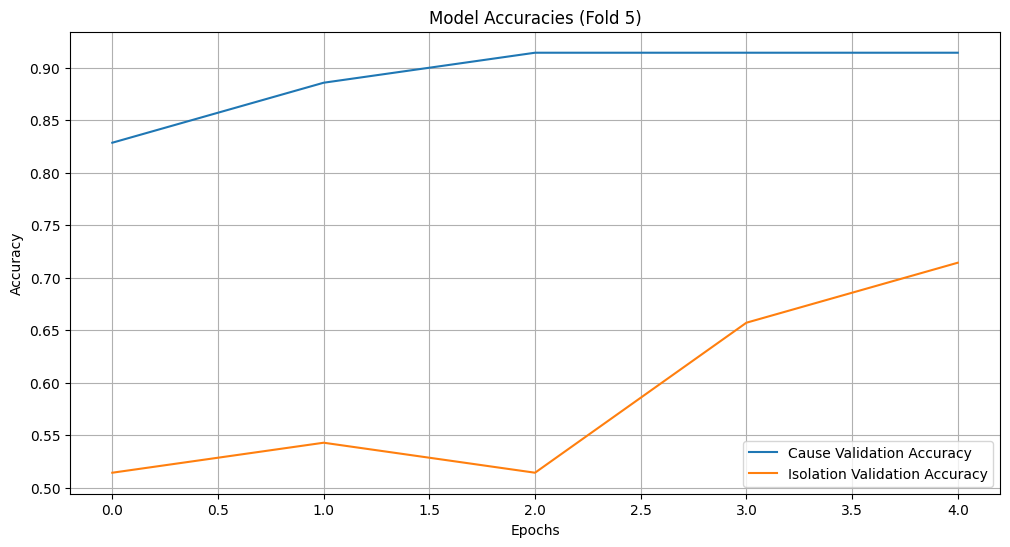

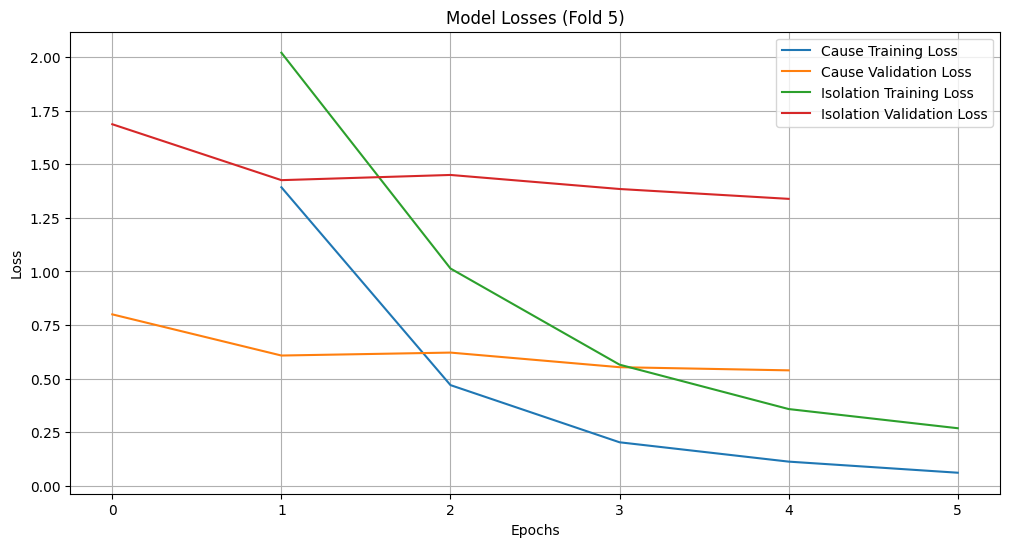


Evaluating models (Fold 5):


100%|██████████| 5/5 [00:00<00:00,  5.53it/s]



Fold 5 Times:
Training time: 0:03:18
Evaluation time: 0:00:03
Total time: 0:03:21

Fold 5 Results:
Cause - Accuracy: 0.9143, Precision: 0.8929, F1: 0.8971
Isolation - Accuracy: 0.7143, Precision: 0.6378, F1: 0.6699


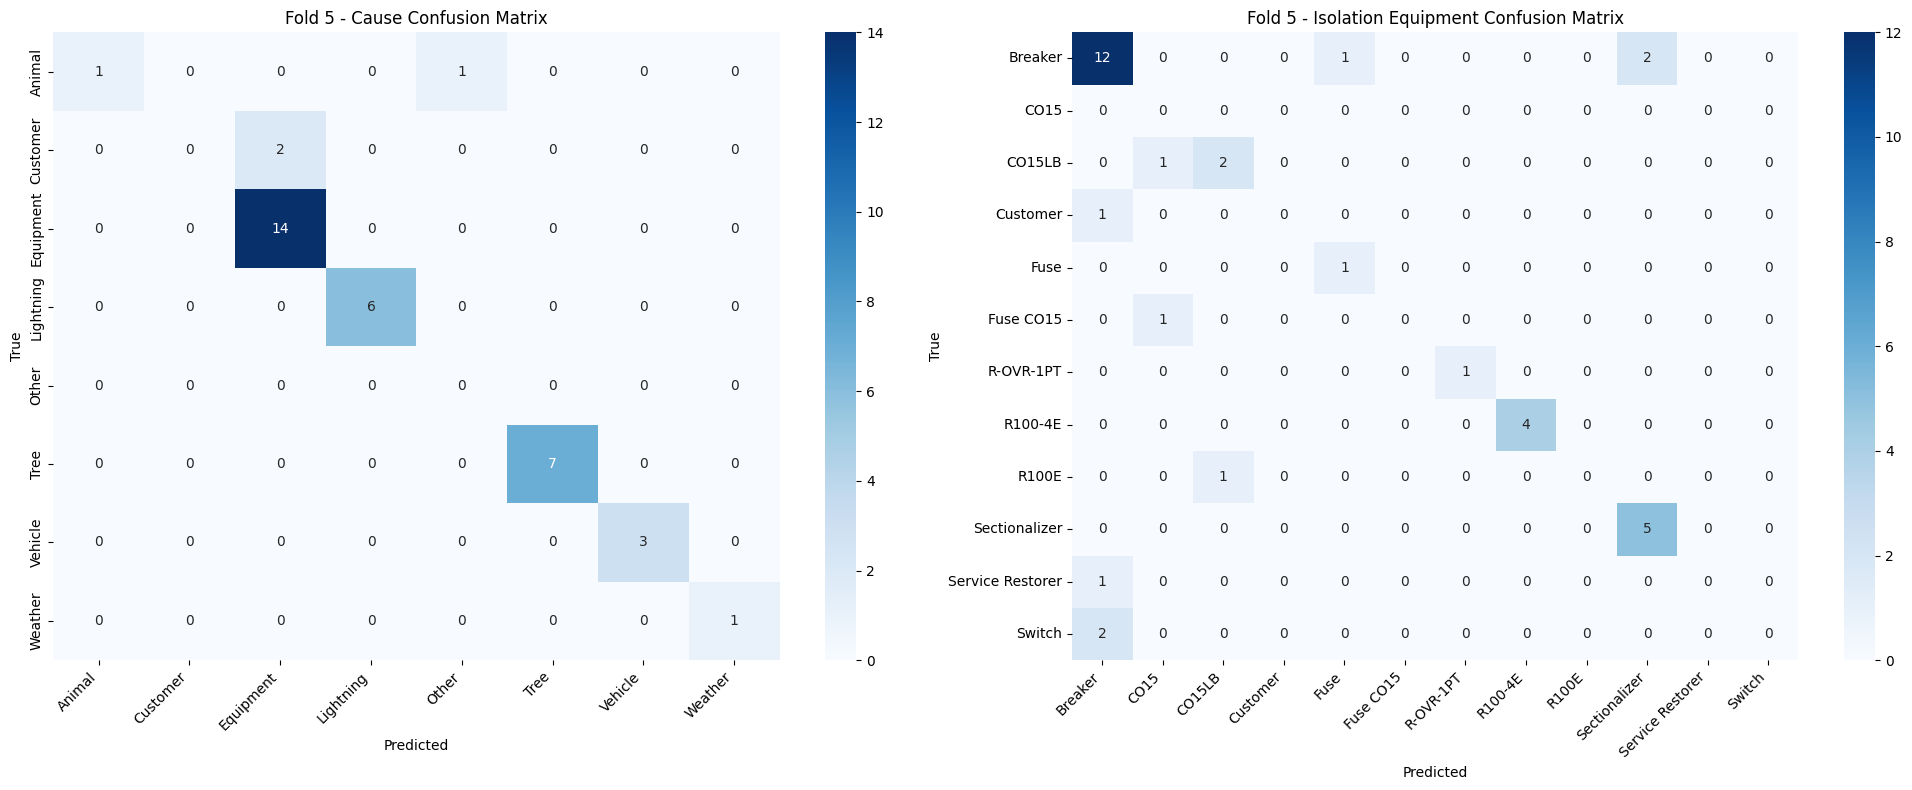


Classification Report - Cause (Fold 5):
              precision    recall  f1-score   support

      Animal       1.00      0.50      0.67         2
    Customer       0.00      0.00      0.00         2
   Equipment       0.88      1.00      0.93        14
   Lightning       1.00      1.00      1.00         6
       Other       0.00      0.00      0.00         0
        Tree       1.00      1.00      1.00         7
     Vehicle       1.00      1.00      1.00         3
     Weather       1.00      1.00      1.00         1

    accuracy                           0.91        35
   macro avg       0.73      0.69      0.70        35
weighted avg       0.89      0.91      0.90        35

Accuracy - Cause (Fold 5): 0.9143

Classification Report - Isolation Equipment (Fold 5):
                  precision    recall  f1-score   support

         Breaker       0.75      0.80      0.77        15
            CO15       0.00      0.00      0.00         0
          CO15LB       0.67      0.67      0

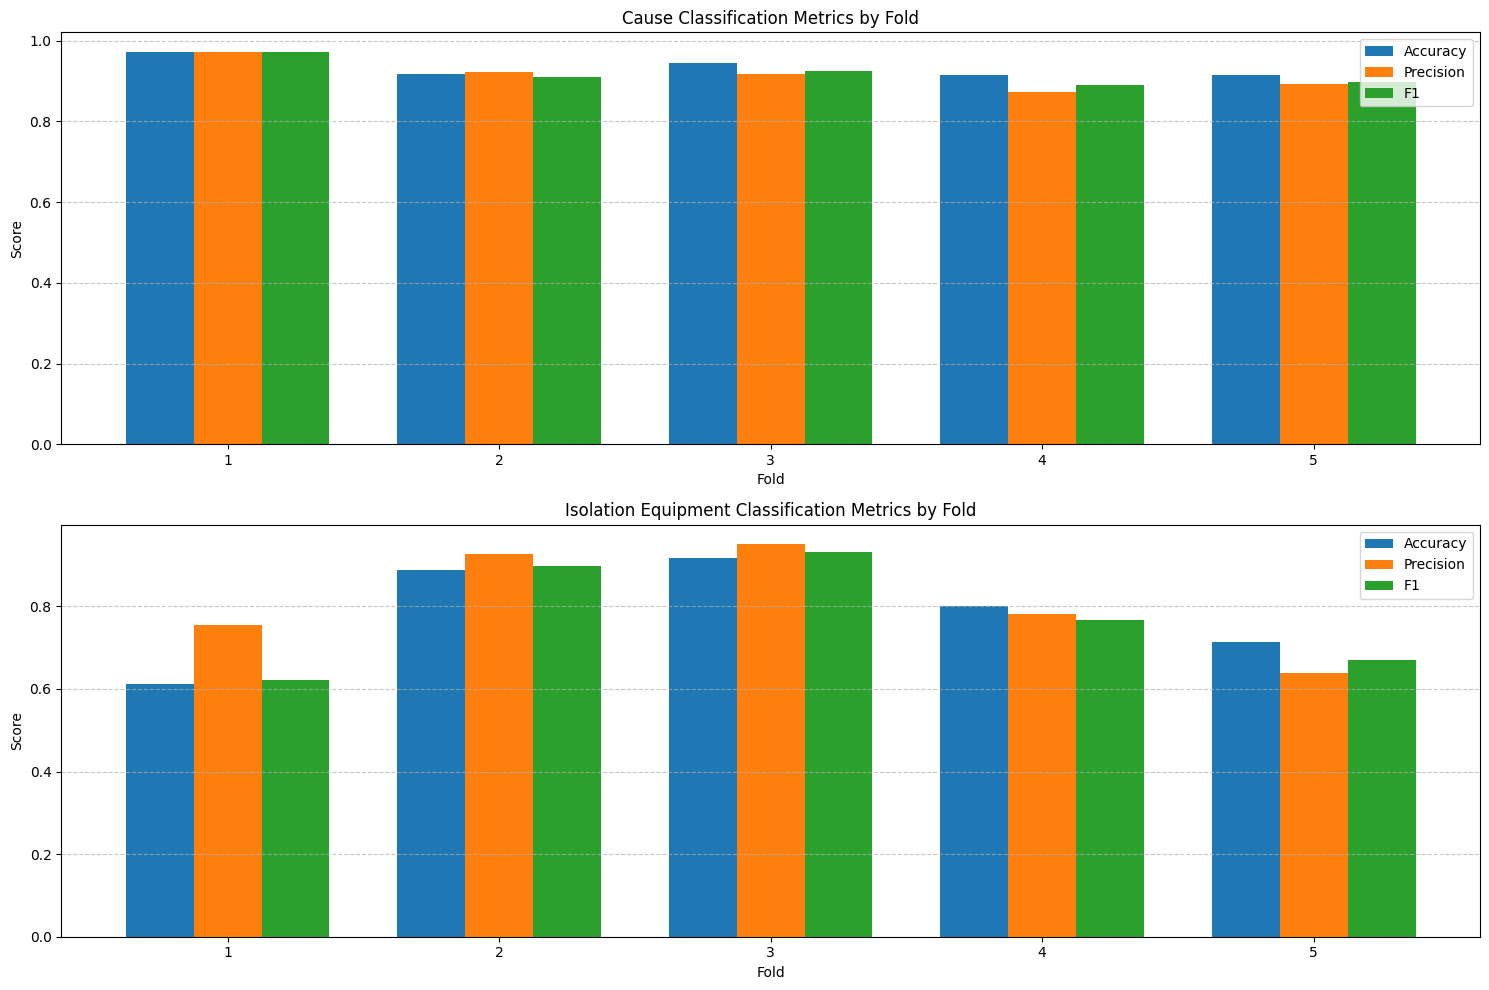


Example Text Classification:

Text: Circuit breaker tripped due to storm
Predicted cause: Lightning
Predicted isolation: Breaker

Text: Customer requested service disconnection
Predicted cause: Equipment
Predicted isolation: Recloser

Text: Transformer failure after lightning strike
Predicted cause: Equipment
Predicted isolation: Breaker

Text: Circuit breaker tripped due to storm
Predicted cause: Lightning
Predicted isolation: Breaker

Text: Customer requested service disconnection
Predicted cause: Equipment
Predicted isolation: Recloser

Text: Transformer failure after lightning strike
Predicted cause: Equipment
Predicted isolation: Breaker
Predicted cause: Equipment
Predicted isolation: Breaker
Predicted cause: Equipment
Predicted isolation: Breaker


In [2]:
import numpy as np
import pandas as pd
import time
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, accuracy_score
from transformers import AutoModelForSequenceClassification, AutoTokenizer, TrainingArguments, Trainer, DataCollatorWithPadding
import torch
import evaluate
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from datasets import Dataset
import os
from datetime import timedelta

# Set parameters
data_path = "PQEvents_Ticket_csv.csv"
text_column_name = "Details"
label_column_name = "Cause"

model_name = "distilbert-base-uncased"
test_size = 0.2
num_labels = 2
n_splits = 5  # Number of folds for K-fold cross-validation

# Create directory for results
os.makedirs("./results", exist_ok=True)

# Load and preprocess data
df = pd.read_csv(data_path)

# First, clean up Cause column
df = df[~df['Cause'].isin(['Unknown', 'Undetermined'])]  # Remove rows with these values in Cause column 
df['Cause'] = df['Cause'].replace(['Customer Request', 'Customer Caused'], 'Customer')

# Replace Unknown/Undetermined in Isolation Equipment Code
df['Isolation Equipment Code'] = df['Isolation Equipment Code'].replace(['Unknown', 'Undetermined'], np.nan)

# Only drop rows where Cause is NaN
df = df.dropna(subset=['Cause'])

# If 'Cause' is 'Customer' and 'Isolation Equipment Code' is NaN, set 'Isolation Equipment Code' to 'Customer'
df.loc[(df['Cause'] == 'Customer') & (df['Isolation Equipment Code'].isna()), 'Isolation Equipment Code'] = 'Customer'

# Drop rows where 'Isolation Equipment Code' is NaN, but only for causes other than 'Customer'
df = df.dropna(subset=['Isolation Equipment Code'])

# Keep only rows where 'Details' is a string
df = df[df['Details'].apply(lambda x: isinstance(x, str))]

# Function to clean text data
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    return text

# Apply text cleaning
df['Details'] = df['Details'].apply(clean_text)

# Print distributions
print("\nUnique Cause Classes with Counts:")
print("-" * 40)
cause_unique = df['Cause'].value_counts()
for cause, count in cause_unique.items():
    print(f"{cause:<20} {count:>5}")

print("\nIsolation Equipment Codes for Customer causes:")
print(df[df['Cause'] == 'Customer']['Isolation Equipment Code'].value_counts(dropna=False))

print(f"\nDataset shape: {df.shape}")

# Create label encoders
le_cause = preprocessing.LabelEncoder()
le_isolation = preprocessing.LabelEncoder()

# Fit both encoders
le_cause.fit(df[label_column_name].tolist())
le_isolation.fit(df['Isolation Equipment Code'].tolist())

# Transform labels
df['cause_label'] = le_cause.transform(df[label_column_name].tolist())
df['isolation_label'] = le_isolation.transform(df['Isolation Equipment Code'].tolist())

# Print out the labels with their corresponding encoded values
label_mapping = dict(zip(le_cause.classes_, le_cause.transform(le_cause.classes_)))
print("Cause Label Mapping:")
for label, encoded_value in label_mapping.items():
    print(f"{label}: {encoded_value}")

print()

# Print out the labels with their corresponding encoded values
label_mapping = dict(zip(le_isolation.classes_, le_isolation.transform(le_isolation.classes_)))
print("Isolation Equipment Label Mapping:")
for label, encoded_value in label_mapping.items():
    print(f"{label}: {encoded_value}")

df['text_cleaned'] = df[text_column_name]

# Count the number of data points for each cause
cause_counts = df[label_column_name].value_counts()
code_counts = df['Isolation Equipment Code'].value_counts()

# Print the counts
print("\nCause counts:")
print(cause_counts)
print("\nIsolation Equipment Code counts:")
print(code_counts)

# Initialize KFold cross-validator
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Preprocessing functions
def preprocess_function_cause(examples):
    tokenized = tokenizer(examples["text"], truncation=True, padding=True)
    tokenized["labels"] = examples["cause_label"]
    return tokenized

def preprocess_function_isolation(examples):
    tokenized = tokenizer(examples["text"], truncation=True, padding=True)
    tokenized["labels"] = examples["isolation_label"]
    return tokenized

# Initialize data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Metrics
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    
    # Calculate multiple metrics
    accuracy = accuracy_score(labels, predictions)
    precision = precision_score(labels, predictions, average='weighted', zero_division=0)
    f1 = f1_score(labels, predictions, average='weighted', zero_division=0)
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'f1': f1
    }

# Function to plot training metrics
def plot_training_metrics(cause_trainer, isolation_trainer, fold=None):
    """Plot training and validation metrics from both trainers"""
    
    # Get training histories
    cause_history = cause_trainer.state.log_history
    isolation_history = isolation_trainer.state.log_history
    
    # Extract metrics
    cause_train_loss = []
    cause_eval_loss = []
    isolation_train_loss = []
    isolation_eval_loss = []
    cause_accuracy = []
    isolation_accuracy = []
    epochs = []
    
    # Process cause trainer history
    for entry in cause_history:
        if 'loss' in entry and 'epoch' in entry and 'eval_loss' not in entry:
            cause_train_loss.append(entry['loss'])
            epochs.append(entry['epoch'])
        if 'eval_loss' in entry:
            cause_eval_loss.append(entry['eval_loss'])
            cause_accuracy.append(entry['eval_accuracy'])
    
    # Process isolation trainer history
    for entry in isolation_history:
        if 'loss' in entry and 'epoch' in entry and 'eval_loss' not in entry:
            isolation_train_loss.append(entry['loss'])
        if 'eval_loss' in entry:
            isolation_eval_loss.append(entry['eval_loss'])
            isolation_accuracy.append(entry['eval_accuracy'])
    
    fold_title = f" (Fold {fold})" if fold is not None else ""
    
    # Plot accuracies
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(cause_accuracy)), cause_accuracy, label='Cause Validation Accuracy')
    plt.plot(range(len(isolation_accuracy)), isolation_accuracy, label='Isolation Validation Accuracy') 
    plt.title(f'Model Accuracies{fold_title}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()
    
    # Plot losses
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, cause_train_loss, label='Cause Training Loss')
    plt.plot(range(len(cause_eval_loss)), cause_eval_loss, label='Cause Validation Loss')
    plt.plot(epochs, isolation_train_loss, label='Isolation Training Loss')
    plt.plot(range(len(isolation_eval_loss)), isolation_eval_loss, label='Isolation Validation Loss')
    plt.title(f'Model Losses{fold_title}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()

# Function to create confusion matrices
def plot_confusion_matrices(true_labels, predicted_labels, label_encoder, title_prefix="", ax=None):
    """Plot confusion matrix for given true and predicted labels"""
    
    # Get unique labels present in data
    unique_labels = np.unique(np.concatenate([true_labels, predicted_labels]))
    class_names = label_encoder.classes_[unique_labels]
    
    # Create confusion matrix
    conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=unique_labels)
    
    # Plot
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))
    
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names,
                ax=ax)
    ax.set_title(f'{title_prefix} Confusion Matrix')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    
    return conf_matrix

# Function to classify text
def classify_text(text, cause_model, isolation_model, tokenizer):
    """Classify text using the trained cause and isolation models"""
    
    # Clean and preprocess input text
    cleaned_text = clean_text(text)
    
    # Tokenize the cleaned text
    inputs = tokenizer(cleaned_text, 
                      return_tensors="pt",
                      truncation=True, 
                      padding=True)
    
    # Get predictions from both models
    with torch.no_grad():
        cause_outputs = cause_model(**inputs)
        isolation_outputs = isolation_model(**inputs)
    
    # Get predicted classes
    cause_class = torch.argmax(cause_outputs.logits, dim=-1)
    isolation_class = torch.argmax(isolation_outputs.logits, dim=-1)
    
    # Map predictions to labels
    predicted_cause = le_cause.inverse_transform([cause_class.item()])[0]
    predicted_isolation = le_isolation.inverse_transform([isolation_class.item()])[0]
    
    return predicted_cause, predicted_isolation

# Lists to store results across folds
cause_accuracies = []
cause_precisions = []
cause_f1_scores = []
isolation_accuracies = []
isolation_precisions = []
isolation_f1_scores = []
fold_times = []

# Run K-fold cross-validation
for fold, (train_idx, test_idx) in enumerate(kf.split(df)):
    print(f"\n{'='*80}\nFold {fold+1}/{n_splits}\n{'='*80}")
    
    # Split data for this fold
    df_train = df.iloc[train_idx]
    df_test = df.iloc[test_idx]
    
    # Create datasets
    train_dataset = Dataset.from_dict({
        'text': df_train['text_cleaned'],
        'cause_label': df_train['cause_label'],
        'isolation_label': df_train['isolation_label']
    })

    test_dataset = Dataset.from_dict({
        'text': df_test['text_cleaned'], 
        'cause_label': df_test['cause_label'],
        'isolation_label': df_test['isolation_label']
    })
    
    # Tokenize datasets
    tokenized_train_cause = train_dataset.map(
        preprocess_function_cause,
        batched=True,
        remove_columns=train_dataset.column_names
    )

    tokenized_test_cause = test_dataset.map(
        preprocess_function_cause,
        batched=True,
        remove_columns=test_dataset.column_names
    )

    tokenized_train_isolation = train_dataset.map(
        preprocess_function_isolation,
        batched=True,
        remove_columns=train_dataset.column_names
    )

    tokenized_test_isolation = test_dataset.map(
        preprocess_function_isolation,
        batched=True,
        remove_columns=test_dataset.column_names
    )
    
    # Create models for this fold
    cause_model = AutoModelForSequenceClassification.from_pretrained(
        model_name, 
        num_labels=len(le_cause.classes_)
    )

    isolation_model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=len(le_isolation.classes_)
    )
    
    # Training arguments
    training_args = TrainingArguments(
        output_dir=f"./results/fold_{fold+1}",
        learning_rate=2e-4,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        num_train_epochs=5,  # Reduced for demonstration
        weight_decay=0.01,
        evaluation_strategy="epoch",
        logging_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
    )
    
    # Create trainers
    cause_trainer = Trainer(
        model=cause_model,
        args=training_args,
        train_dataset=tokenized_train_cause,
        eval_dataset=tokenized_test_cause,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics
    )

    isolation_trainer = Trainer(
        model=isolation_model,
        args=training_args,
        train_dataset=tokenized_train_isolation,
        eval_dataset=tokenized_test_isolation,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics
    )
    
    # Start timing for training
    start_time = time.time()
    
    # Train the models
    print(f"Training Cause Model (Fold {fold+1}):")
    cause_trainer.train()
    
    print(f"\nTraining Isolation Model (Fold {fold+1}):")
    isolation_trainer.train()
    
    # End timing for training
    train_end_time = time.time()
    training_time = train_end_time - start_time
    
    # Plot training metrics for this fold
    plot_training_metrics(cause_trainer, isolation_trainer, fold+1)
    
    # Start timing for evaluation
    eval_start_time = time.time()
    
    # Evaluate on test set
    print(f"\nEvaluating models (Fold {fold+1}):")
    
    # Get predictions for both models on test set
    cause_predictions = cause_trainer.predict(tokenized_test_cause)
    isolation_predictions = isolation_trainer.predict(tokenized_test_isolation)
    
    # End timing for evaluation
    eval_end_time = time.time()
    eval_time = eval_end_time - eval_start_time
    
    # Total time for this fold
    fold_total_time = training_time + eval_time
    fold_times.append(fold_total_time)
    
    print(f"\nFold {fold+1} Times:")
    print(f"Training time: {timedelta(seconds=int(training_time))}")
    print(f"Evaluation time: {timedelta(seconds=int(eval_time))}")
    print(f"Total time: {timedelta(seconds=int(fold_total_time))}")
    
    # Extract predictions
    cause_preds = np.argmax(cause_predictions.predictions, axis=1)
    isolation_preds = np.argmax(isolation_predictions.predictions, axis=1)
    
    # Get ground truth values
    cause_true = df_test['cause_label'].values
    isolation_true = df_test['isolation_label'].values
    
    # Calculate metrics
    cause_accuracy = accuracy_score(cause_true, cause_preds)
    cause_precision = precision_score(cause_true, cause_preds, average='weighted', zero_division=0)
    cause_f1 = f1_score(cause_true, cause_preds, average='weighted', zero_division=0)
    
    isolation_accuracy = accuracy_score(isolation_true, isolation_preds)
    isolation_precision = precision_score(isolation_true, isolation_preds, average='weighted', zero_division=0)
    isolation_f1 = f1_score(isolation_true, isolation_preds, average='weighted', zero_division=0)
    
    # Store metrics
    cause_accuracies.append(cause_accuracy)
    cause_precisions.append(cause_precision)
    cause_f1_scores.append(cause_f1)
    isolation_accuracies.append(isolation_accuracy)
    isolation_precisions.append(isolation_precision)
    isolation_f1_scores.append(isolation_f1)
    
    # Print metrics for this fold
    print(f"\nFold {fold+1} Results:")
    print(f"Cause - Accuracy: {cause_accuracy:.4f}, Precision: {cause_precision:.4f}, F1: {cause_f1:.4f}")
    print(f"Isolation - Accuracy: {isolation_accuracy:.4f}, Precision: {isolation_precision:.4f}, F1: {isolation_f1:.4f}")
    
    # Create confusion matrices
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    plot_confusion_matrices(cause_true, cause_preds, le_cause, f"Fold {fold+1} - Cause", ax1)
    plot_confusion_matrices(isolation_true, isolation_preds, le_isolation, f"Fold {fold+1} - Isolation Equipment", ax2)
    
    plt.tight_layout()
    plt.show()
    
    # Get unique labels present in test data for classification report
    unique_cause_labels = np.unique(np.concatenate([cause_true, cause_preds]))
    unique_isolation_labels = np.unique(np.concatenate([isolation_true, isolation_preds]))

    # Get class names for present labels
    cause_class_names = le_cause.classes_[unique_cause_labels]
    isolation_class_names = le_isolation.classes_[unique_isolation_labels]
    
    # Print classification reports
    print(f"\nClassification Report - Cause (Fold {fold+1}):")
    print(classification_report(
        cause_true, cause_preds,
        labels=unique_cause_labels,
        target_names=cause_class_names,
        zero_division=0
    ))
    print(f"Accuracy - Cause (Fold {fold+1}): {accuracy_score(cause_true, cause_preds):.4f}")

    print(f"\nClassification Report - Isolation Equipment (Fold {fold+1}):")
    print(classification_report(
        isolation_true, isolation_preds,
        labels=unique_isolation_labels,
        target_names=isolation_class_names,
        zero_division=0
    ))
    print(f"Accuracy - Isolation Equipment (Fold {fold+1}): {accuracy_score(isolation_true, isolation_preds):.4f}")


# Print average results across all folds
print("\n" + "="*80)
print("AVERAGE RESULTS ACROSS ALL FOLDS")
print("="*80)

print(f"Cause - Avg Accuracy: {np.mean(cause_accuracies):.4f} ± {np.std(cause_accuracies):.4f}")
print(f"Cause - Avg Precision: {np.mean(cause_precisions):.4f} ± {np.std(cause_precisions):.4f}")
print(f"Cause - Avg F1: {np.mean(cause_f1_scores):.4f} ± {np.std(cause_f1_scores):.4f}")

print(f"Isolation - Avg Accuracy: {np.mean(isolation_accuracies):.4f} ± {np.std(isolation_accuracies):.4f}")
print(f"Isolation - Avg Precision: {np.mean(isolation_precisions):.4f} ± {np.std(isolation_precisions):.4f}")
print(f"Isolation - Avg F1: {np.mean(isolation_f1_scores):.4f} ± {np.std(isolation_f1_scores):.4f}")

print(f"\nAverage Time per Fold: {timedelta(seconds=int(np.mean(fold_times)))}")
print(f"Total Time for all Folds: {timedelta(seconds=int(np.sum(fold_times)))}")

# Plot metrics across folds
plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
x = np.arange(1, n_splits+1)
width = 0.25
plt.bar(x - width, cause_accuracies, width, label='Accuracy')
plt.bar(x, cause_precisions, width, label='Precision')
plt.bar(x + width, cause_f1_scores, width, label='F1')
plt.xlabel('Fold')
plt.ylabel('Score')
plt.title('Cause Classification Metrics by Fold')
plt.xticks(x)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.subplot(2, 1, 2)
plt.bar(x - width, isolation_accuracies, width, label='Accuracy')
plt.bar(x, isolation_precisions, width, label='Precision')
plt.bar(x + width, isolation_f1_scores, width, label='F1')
plt.xlabel('Fold')
plt.ylabel('Score')
plt.title('Isolation Equipment Classification Metrics by Fold')
plt.xticks(x)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Save best model from last fold for inference
cause_model.save_pretrained("./results/best_cause_model")
isolation_model.save_pretrained("./results/best_isolation_model")
tokenizer.save_pretrained("./results/tokenizer")

# Example for text classification
print("\nExample Text Classification:")
sample_texts = [
    "Circuit breaker tripped due to storm",
    "Customer requested service disconnection",
    "Transformer failure after lightning strike"
]

for text in sample_texts:
    cause, isolation = classify_text(text, cause_model, isolation_model, tokenizer)
    print(f"\nText: {text}")
    print(f"Predicted cause: {cause}")
    print(f"Predicted isolation: {isolation}")

# Interactive classification
while True:
    text = input("\nEnter text to classify (or 'quit' to exit): ")
    if text.lower() == 'quit':
        break
    cause, isolation = classify_text(text, cause_model, isolation_model, tokenizer)
    print(f"Predicted cause: {cause}")
    print(f"Predicted isolation: {isolation}")

# bidirectional lstm

Data sample:]n   id  SiteName   FeederId  EventId  Phase First Event Last Event      Cause  \
0   1  Site0006  F_0000041     3042      4     39:06.0    39:06.0  Equipment   
1   2  Site0012  F_0000037     3048      3     29:36.0    29:51.0  Equipment   
2   3  Site0006  F_0000041     3067      2     10:46.0    10:46.0    Weather   
3   4  Site0012  F_0000037     3127      2     33:30.0    33:30.0  Equipment   
4   6  Site0006  F_0000041     3152      2     39:58.0    39:58.0  Equipment   

   Weather Isolation Equipment Code Failed Equipment Code  \
0  Unknown                     Fuse                 Other   
1  Unknown                  Breaker             Capacitor   
2     Wind                  Breaker             No Damage   
3  Unknown                     Fuse           Transformer   
4  Unknown                     Fuse           Transformer   

                                  Details  
0          Equipment, Device UG, Damaged.  
1  Equipment, Capacitor Station, Damaged.  
2   Un

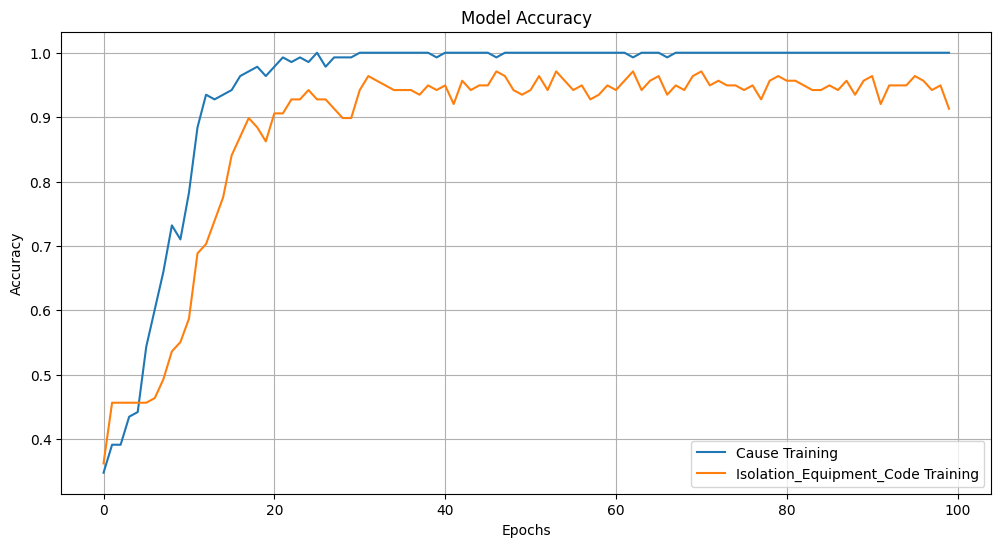

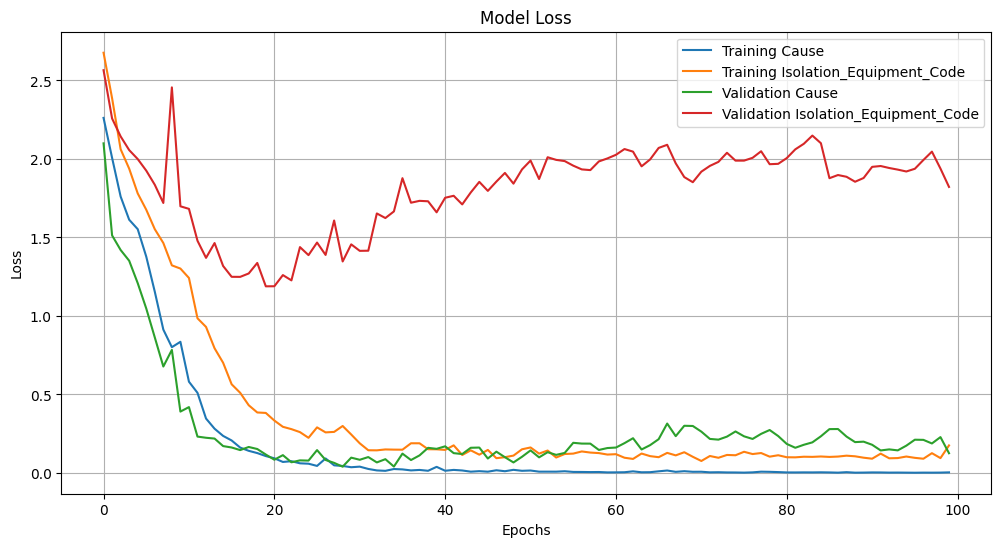

9/9 [==============================] - 2s 6ms/step

Training Performance Metrics:
--------------------------------------------------------------------------------

Classification Report for Cause:
                 precision    recall  f1-score   support

         animal       1.00      1.00      1.00         7
customer caused       1.00      1.00      1.00         1
      equipment       1.00      1.00      1.00        54
      lightning       1.00      1.00      1.00        17
          other       1.00      1.00      1.00         4
        planned       1.00      1.00      1.00         1
           tree       1.00      1.00      1.00        34
        vehicle       1.00      1.00      1.00        17
        weather       1.00      1.00      1.00         3

       accuracy                           1.00       138
      macro avg       1.00      1.00      1.00       138
   weighted avg       1.00      1.00      1.00       138

-----------------------------------------------------------

In [6]:
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

filepath = "PQEvents_Ticket_csv.csv"

df = pd.read_csv(filepath)
print(f"Data sample:]n{df.head()}")

df = df.rename(columns=lambda x: x.replace(" ", "_"))

output_names = ["Cause", "Isolation_Equipment_Code"]
# output_names = ["Cause", "Isolation_Equipment_Code", "Failed_Equipment_Code"]

column_names = []
for label in output_names:
    column_names.append(label)
column_names.append("Details")

df = df.filter(items=column_names)

print(f"Data sample:\n{df.head()}\n")

def clean_data(df) -> pd.DataFrame:
    # Replace punctuation with whitespace
    def remove_punctuation(value):
        for token in invalid_tokens:
            value = value.replace(token, " ")
        return value

    # Strip whitespace if more than one sequential whitespace is found
    def strip_excess_whitespace(value):
          # Replace multiple whitespaces with a single whitespace
          value = re.sub(r'\s{2,}', ' ', value)
          # Strip leading and trailing whitespaces
          return value.strip()

    df = df.dropna()

    invalid_tokens = [",", "/", ".", "-","(", ")"]

    df = df.map(lambda x: x.lower())
    df = df.replace("unknown", np.nan)
    df = df.replace("undetermined", np.nan)
    df = df.replace("unknonw", np.nan)
    df = df.dropna()
    df['Cause'] = df['Cause'].replace(['Customer Request', 'Customer Caused'], 'Customer')


    df = df.map(remove_punctuation)

    df = df.map(strip_excess_whitespace)

    return df

df = clean_data(df)
print(f"\nFinal Data sample:\n{df.head()}\n")

pq_train = df.pop("Details")

# print(f"Training data examples:\n{pq_train.head()}\n")

output_labels = {label_name: df.pop(label_name) for label_name in output_names}

# Convert to numpy array
pq_train = pq_train.to_numpy()
for name in output_names:
    output_labels[name] = output_labels[name].to_numpy()

# print(output_labels)
# ds = tf.data.Dataset.from_tensor_slices((pq_train, tuple(output_labels[name] for name in output_names)))
# print(f"{list(ds.take(1).as_numpy_iterator())}")

MAX_LENGTH = 16


def fit_vectorizer(dataset):
    """
    Adapts the TextVectorization layer on the training sentences
    Args:
        dataset (tf.data.Dataset): Tensorflow dataset with training sentences.
    Returns:
        tf.keras.layers.TextVectorization: an instance of the TextVectorization class adapted to the training sentences.
    """
    # Instantiate the TextVectorization class
    vectorizer = tf.keras.layers.TextVectorization(
        max_tokens=None, #let the layer learn the vocab size from the sequences
        output_sequence_length=MAX_LENGTH
    )
    # Fit the tokenizer to the training sentences
    vectorizer.adapt(dataset)
    return vectorizer

def fit_label_encoder(labels):
    """Creates an instance of a StringLookup, and trains it on all labels
    Args:
        labels (tf.data.Dataset): dataset of labels
    Returns:
        tf.keras.layers.StringLookup: adapted encoder for train and validation labels
    """
    num_oov_tokens = 1

    # Instantiate the StringLookup layer with no OOV tokens
    label_encoder = tf.keras.layers.StringLookup(
                                    max_tokens=(MAX_LENGTH + num_oov_tokens),
                                    num_oov_indices=num_oov_tokens)
    # If new words appear in validation or test data that weren't in the training set,
    # these words can be mapped to the OOV token,
    # allowing the model to continue processing the data without encountering issues

    # Fit the StringLookup layer on the labels
    label_encoder.adapt(labels)
    return label_encoder

def preprocess_dataset(dataset, text_vectorizer, label_encoders, output_names):
    """Apply the preprocessing to a dataset
    Args:
        dataset (tf.data.Dataset): dataset to preprocess (training or validation)
        text_vectorizer (tf.keras.layers.TextVectorization ): text vectorizer
        label_encoder (tf.keras.layers.StringLookup): label encoder
    Returns:
        tf.data.Dataset: transformed dataset
    """
    def encode_labels_fn(text, label_dict):
        encoded_labels = {name: label_encoders[name](label_dict[name]) for name in output_names}
        return text_vectorizer(text), encoded_labels

    return dataset.map(encode_labels_fn)

TRAINING_SPLIT = 0.8
NUM_BATCHES = 16

def create_model(vocab_size, num_labels_dict, output_names):
    """
    Creates a text classifier model with separate output layers for each target.
    Args:
        vocab_size (int): Size of the vocabulary for the text vectorization layer.
        num_labels_dict (dict): Dictionary mapping each output name to its number of unique labels.
    Returns:
        tf.keras.Model: Compiled Keras model ready for training.
    """
    EMBEDDING_DIM = 256

    # Input layer for tokenized text sequences 
    input_layer = tf.keras.Input(shape=(MAX_LENGTH,), name="input_text")
    
    # Hidden layers
    x = tf.keras.layers.Embedding(vocab_size, EMBEDDING_DIM, name="embedding_layer")(input_layer)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True, dropout=0.2, name="bi_lstm_layer_1"))(x)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, dropout=0.2, name="bi_lstm_layer_2"))(x)
    x = tf.keras.layers.Dense(128, activation='relu', name="dense_layer_1")(x)
    x = tf.keras.layers.Dropout(0.2, name="dropout_layer_1")(x)
    x = tf.keras.layers.Dense(64, activation='relu', name="dense_layer_2")(x)

    # Output layers for each target
    outputs = [tf.keras.layers.Dense(num_labels_dict[name],
                                   activation='softmax',
                                   name=name
                                   )(x) for name in output_names]

    # Define the model (removed output swapping since we only have 2 outputs)
    model = tf.keras.Model(inputs=input_layer, outputs=outputs, name="multi_output_model")

    # Compile the model
    loss_dict = {name: 'sparse_categorical_crossentropy' for name in output_names}
    metrics_dict = {name: 'accuracy' for name in output_names}

    model.compile(
        optimizer='adam',
        loss=loss_dict,
        metrics=metrics_dict
    )

    return model

# Print Data Shapes
print(f"Training Data Dims:{pq_train.shape}\nOutput Label Dims:")
for name in output_names:
    print(f"\t{name}: {output_labels[name].shape}")

# Print Data
# print(f"Training Data:{pq_train}\nOutput Labels:")
# for name in output_names:
#     print(f"\t{name}:\n{output_labels[name]}")
def train_model(pq_train, output_labels):

    vectorizer = fit_vectorizer(pq_train)
    vocab_size = vectorizer.vocabulary_size()

    label_encoders = {}
    label_nums = {}
    label_vocabs = {}

    for name in output_names:
        label_encoders[name] = fit_label_encoder(output_labels[name])
        label_nums[name] = label_encoders[name].vocabulary_size()
        label_vocabs[name] = label_encoders[name].get_vocabulary()

    model = create_model(vocab_size, label_nums, output_names)
    model.summary()

    print("Model outputs:", model.output_names)


    def dynamic_train_test_split(X, y, test_size=0.2, random_state=42, stratify=None):
        # Ensure consistent ordering of label keys
        keys = list(y.keys())
        y_values = [y[key] for key in keys]

        # Perform train-test split dynamically
        split_data = train_test_split(
            X, *y_values, test_size=test_size, random_state=random_state, stratify=stratify
        )
        # print(f"{split_data}")
        for i, data in enumerate(split_data):
            print(f"Data[{i}]: {data.shape}")
        print()

        # Reconstruct the train and test splits for labels
        X_train, X_test = split_data[0], split_data[1]

        y_train = {key: split_data[2 + 2*i] for i, key in enumerate(keys)}
        y_test = {key: split_data[3 + 2*i] for i, key in enumerate(keys)}

        return X_train, X_test, y_train, y_test

    X_train, X_test, y_train, y_test = dynamic_train_test_split(pq_train,
                                                      output_labels
                                                      )

    print(f"X_train: {X_train.shape}")
    print(f"X_test: {X_test.shape}")
    for name in output_names:
        print(f"{name} y_train: {y_train[name].shape}")
        print(f"{name} y_test: {y_test[name].shape}")
    print()

    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

    proc_train_dataset = preprocess_dataset(train_dataset, vectorizer, label_encoders, output_names)
    proc_test_dataset = preprocess_dataset(test_dataset, vectorizer, label_encoders, output_names)

    batch_train_dataset = proc_train_dataset.batch(NUM_BATCHES, drop_remainder=False)
    batch_test_dataset = proc_test_dataset.batch(NUM_BATCHES, drop_remainder=False)

    # for text, label_dict in batch_train_dataset.as_numpy_iterator():
    #     print(f"Train Text: {text}")
    #     for name, label in label_dict.items():
    #         print(f"Train {name} label: {label}")
    # print()
    # for text, label_dict in batch_test_dataset.as_numpy_iterator():
    #     print(f"Test Text: {text}")
    #     for name, label in label_dict.items():
    #         print(f"Test {name} label: {label}")
    # print()
    # for name in output_names:
    #     print(f"{name} num_labels: {label_nums[name]}")
    # print()

    history = model.fit(
        batch_train_dataset,
        epochs=100,
        validation_data=batch_test_dataset,
        verbose=2,
        batch_size=NUM_BATCHES,
    )

    # Evaluate the model and store metrics
    all_val_loss = {}
    all_val_acc = {}
    for name in output_names:
        metrics = model.evaluate(batch_test_dataset, verbose=0, return_dict=True)
        all_val_loss[name] = metrics[name + "_loss"]  # Store loss for each output
        all_val_acc[name] = metrics[name + "_accuracy"]  # Store accuracy for each output

    # Print and store metrics
    for name in output_names:
        print(f"{name} Validation Accuracy: {all_val_acc[name]}")
        print(f"{name} Validation Loss: {all_val_loss[name]}")
    return history, model, batch_train_dataset, batch_test_dataset, label_vocabs


history, model, batch_train_dataset, batch_val_dataset, label_vocabs = train_model(pq_train, output_labels)

def plot_training_history(history) -> None:
    # Plot training accuracy only
    plt.figure(figsize=(12, 6))
    for output_name in history.history.keys():
        if "accuracy" in output_name and "val" not in output_name:  # Skip validation accuracy
            label = output_name.replace("_accuracy", " Training").title()
            plt.plot(history.history[output_name], label=label)
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

    # Plot training & validation loss
    plt.figure(figsize=(12, 6))
    for output_name in history.history.keys():
        if "loss" in output_name:
            # Skip overall loss
            if output_name in ["loss", "val_loss"]:
                continue
            # Make loss labels more descriptive
            if "val" in output_name:
                label = output_name.replace("val_", "Validation ").replace("_loss", "")
            else:
                label = "Training " + output_name.replace("_loss", "")
            plt.plot(history.history[output_name], label=label)
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()

plot_training_history(history)

def create_accuracy_table(history, output_names, batch_train_dataset, label_vocabs):
    """
    Creates and displays a formatted table showing precision, recall, f1-score
    and support for training data
    Args:
        history: Training history from model.fit()
        output_names: List of output layer names
        batch_train_dataset: Training dataset in batches
        label_vocabs: Dictionary of label vocabularies
    """
    # Get predictions on training data
    train_predictions = model.predict(batch_train_dataset) 
    
    print("\nTraining Performance Metrics:")
    print("-" * 80)
    
    for i, name in enumerate(output_names):
        # Get predictions and true labels for current output
        y_pred = np.argmax(train_predictions[i], axis=1)
        y_true = []
        for _, labels in batch_train_dataset:
            y_true.extend(labels[name].numpy())
        y_true = np.array(y_true)
        
        # Convert numeric labels back to strings
        str_true = [label_vocabs[name][label] for label in y_true]
        str_pred = [label_vocabs[name][label] for label in y_pred]
        
        # Sort unique classes alphabetically
        classes = sorted(list(set(str_true)))
        
        print(f"\nClassification Report for {name}:")
        print(classification_report(
            str_true, 
            str_pred,
            target_names=classes,
            digits=2,
            zero_division=0.0
        ))
        print("-" * 80)

# Update how you call the function:
metrics_table = create_accuracy_table(history, output_names, batch_train_dataset, label_vocabs)

# Predict on the validation dataset
all_predictions = model.predict(batch_val_dataset)

# Split predictions into respective outputs
predictions = {}
true_labels = {}
classes = {}
num_classes = {}

for i, name in enumerate(output_names):
    # Create dictionary of true labels for each output
    true_labels[name] = []
    for _, labels in batch_val_dataset:
        true_labels[name].extend(labels[name].numpy())
    # Create dictionary of each predicted output
    predictions[name] = np.argmax(all_predictions[i], axis=1)
    # Convert true labels to NumPy array
    true_labels[name] = np.array(true_labels[name])
    # Create dictionary of all distinct classes
    classes[name] = np.unique(output_labels[name])
    # Create dictionary of number of total classes
    num_classes[name] = np.arange(len(classes[name]))

# Remove the swapping code since you only have 2 outputs now
# The following lines should be removed:
# temp = predictions[output_names[1]]
# predictions[output_names[1]] = predictions[output_names[2]]
# predictions[output_names[2]] = temp
print("Validation/test results")
str_true_labels = {}
str_predictions = {}
for name in output_names:
    str_true_labels[name] = [label_vocabs[name][label] for label in true_labels[name]]
    str_predictions[name] = [label_vocabs[name][label] for label in predictions[name]]
    print(f"\nClassification Report for {name}:")
    print(classification_report(str_true_labels[name], str_predictions[name], zero_division=0.0))



# bilstm with kfold

Using device: cpu
Loading and preprocessing data...

Unique Cause Classes with Counts:
----------------------------------------
Equipment               73
Tree                    39
Vehicle                 23
Lightning               21
Animal                   7
Customer                 6
Other                    4
Weather                  3
Planned                  2

Isolation Equipment Codes for Customer causes:
Isolation Equipment Code
Customer    5
Switch      1
Name: count, dtype: int64

Dataset shape: (178, 12)
Cause Label Mapping:
Animal: 0
Customer: 1
Equipment: 2
Lightning: 3
Other: 4
Planned: 5
Tree: 6
Vehicle: 7
Weather: 8

Isolation Equipment Label Mapping:
Breaker: 0
CO15: 1
CO15LB: 2
Customer: 3
Fuse: 4
Fuse CO15: 5
OCB: 6
R-OVR-1PT: 7
R100-4E: 8
R100E: 9
Recloser: 10
SECT200NLB: 11
Sectionalizer: 12
Service Restorer: 13
Switch: 14

Cause counts:
Cause
Equipment    73
Tree         39
Vehicle      23
Lightning    21
Animal        7
Customer      6
Other         4
Weather 

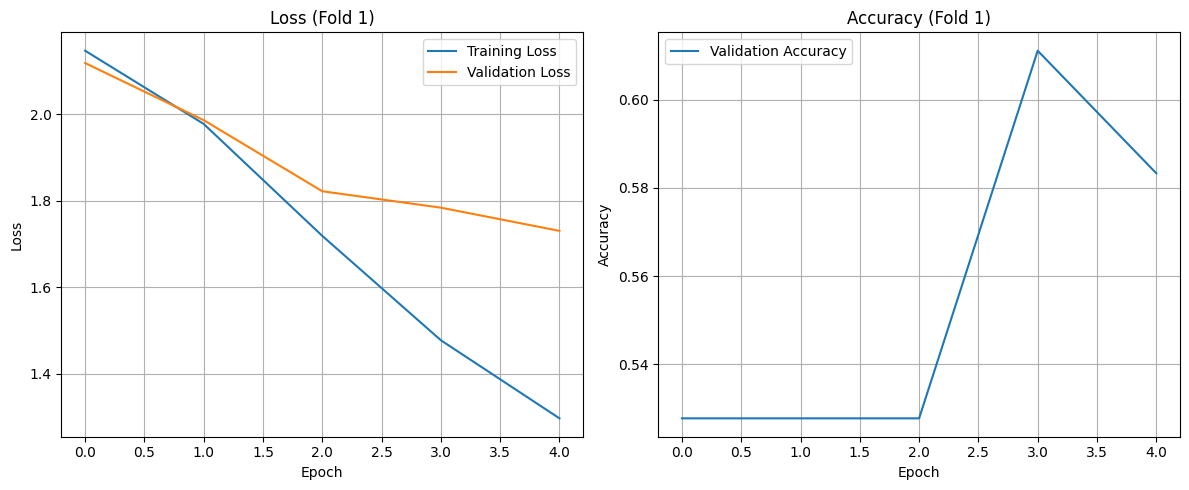

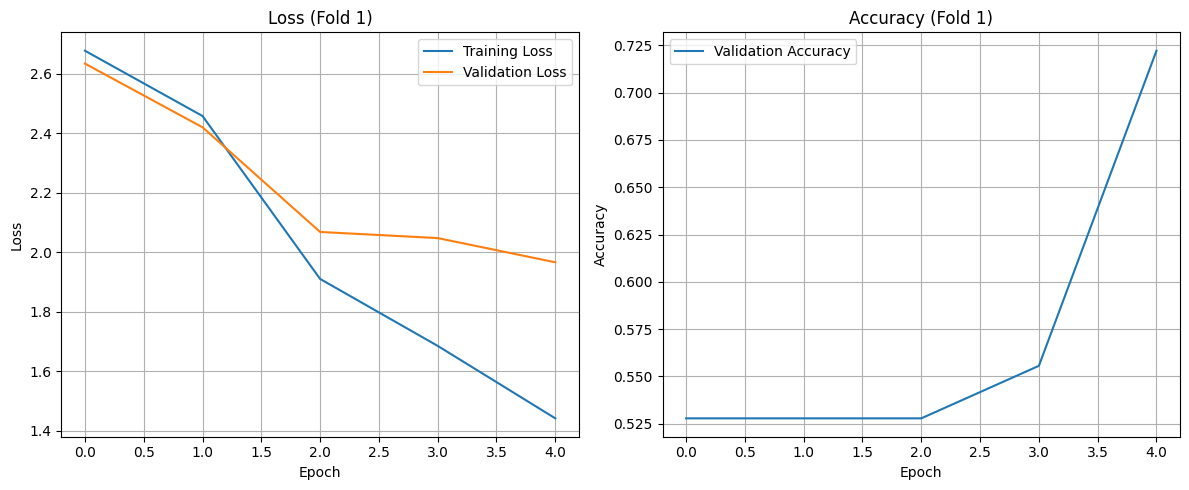


Final evaluation for fold 1...

Fold 1 Times:
Training time: 0:00:02
Evaluation time: 0:00:00
Total time: 0:00:03

Fold 1 Results:
Cause - Accuracy: 0.5833, Precision: 0.5290, F1: 0.5348
Isolation - Accuracy: 0.7222, Precision: 0.5801, F1: 0.6358


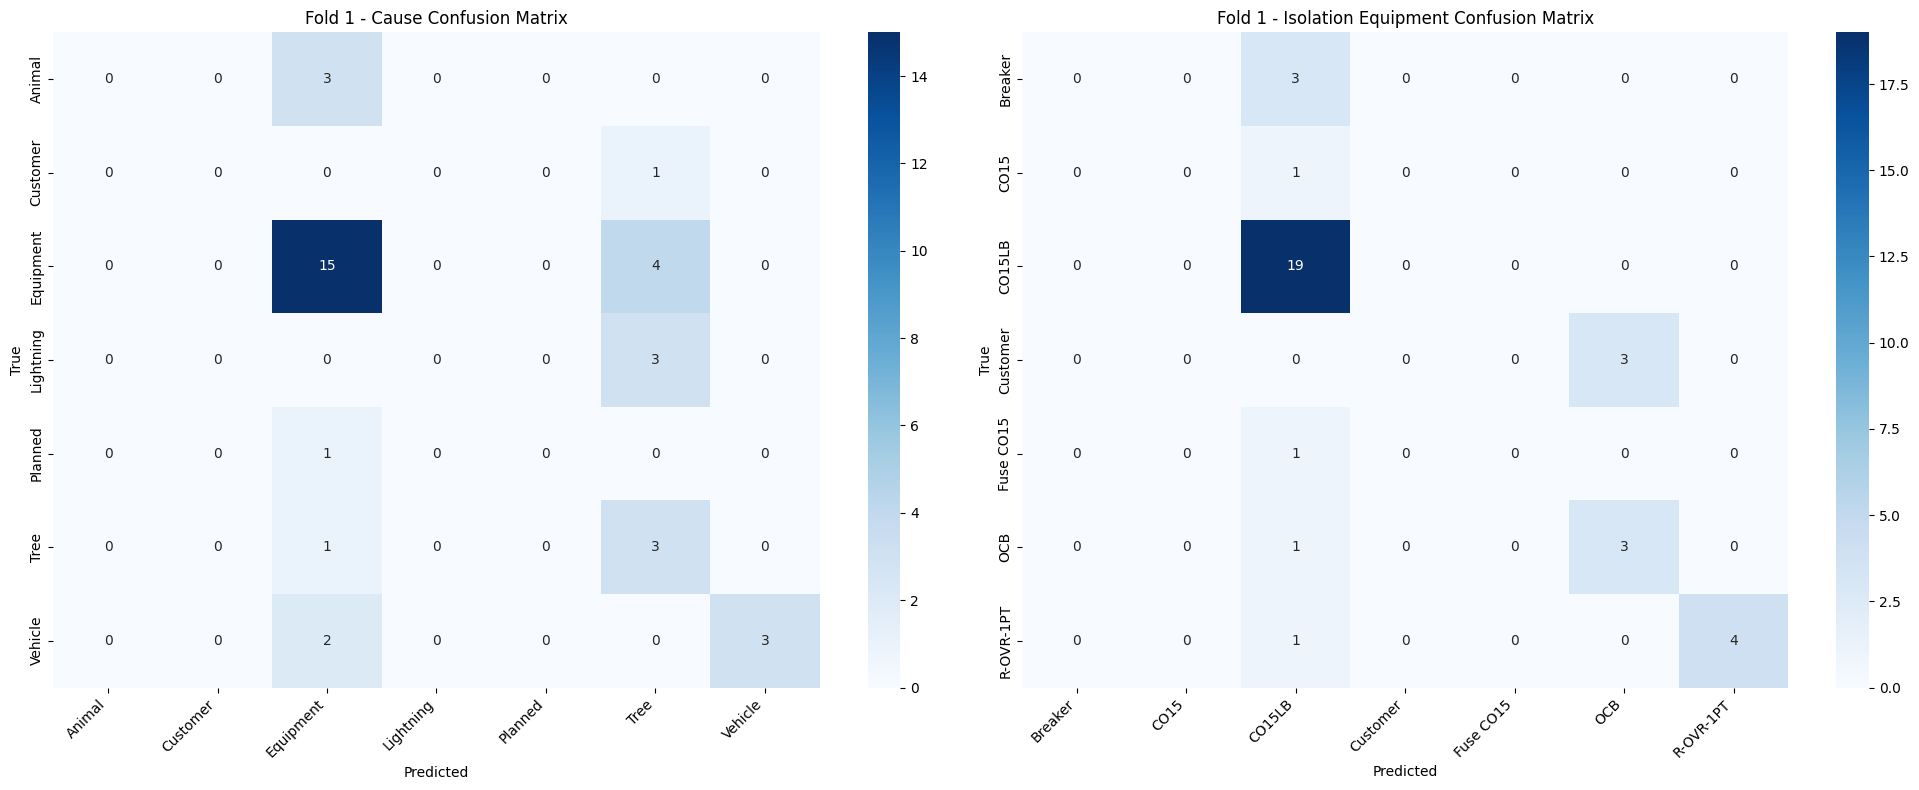


Classification Report - Cause (Fold 1):
              precision    recall  f1-score   support

      Animal       0.00      0.00      0.00         3
    Customer       0.00      0.00      0.00         1
   Equipment       0.68      0.79      0.73        19
   Lightning       0.00      0.00      0.00         3
     Planned       0.00      0.00      0.00         1
        Tree       0.27      0.75      0.40         4
     Vehicle       1.00      0.60      0.75         5

    accuracy                           0.58        36
   macro avg       0.28      0.31      0.27        36
weighted avg       0.53      0.58      0.53        36


Classification Report - Isolation Equipment (Fold 1):
              precision    recall  f1-score   support

     Breaker       0.00      0.00      0.00         3
        CO15       0.00      0.00      0.00         1
      CO15LB       0.73      1.00      0.84        19
    Customer       0.00      0.00      0.00         3
   Fuse CO15       0.00      0.00   

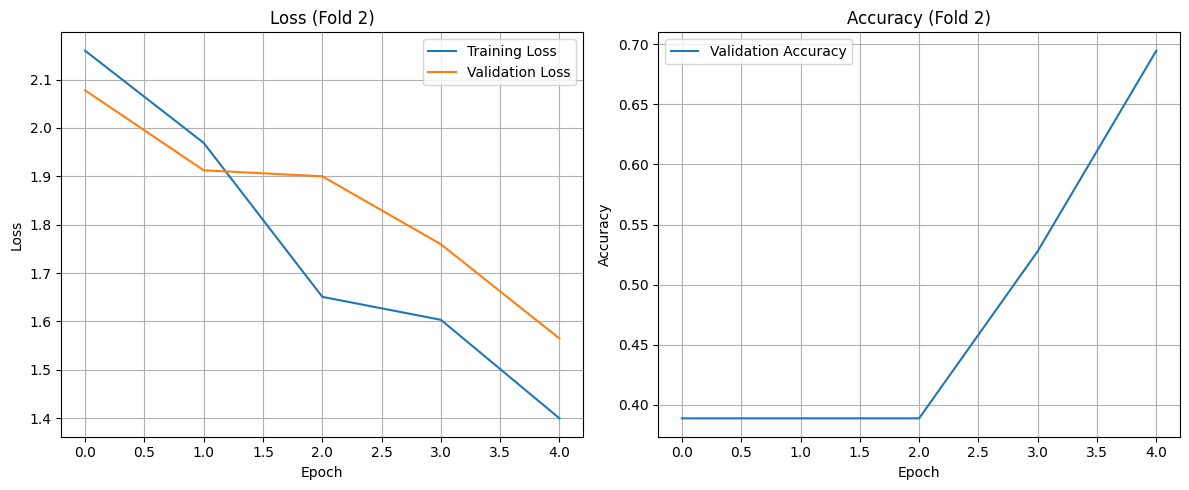

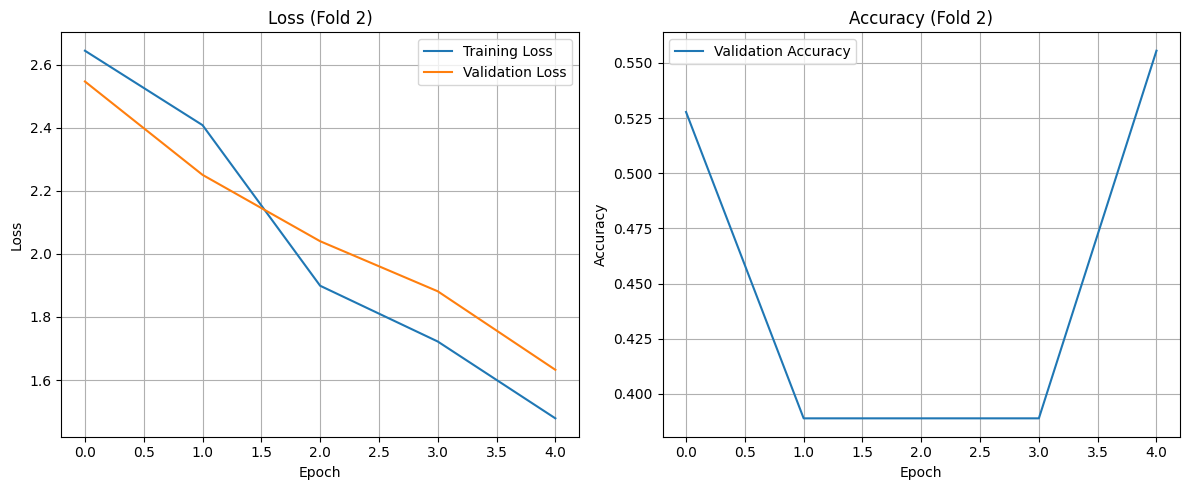


Final evaluation for fold 2...

Fold 2 Times:
Training time: 0:00:03
Evaluation time: 0:00:00
Total time: 0:00:04

Fold 2 Results:
Cause - Accuracy: 0.6944, Precision: 0.5770, F1: 0.6119
Isolation - Accuracy: 0.5556, Precision: 0.3270, F1: 0.4105


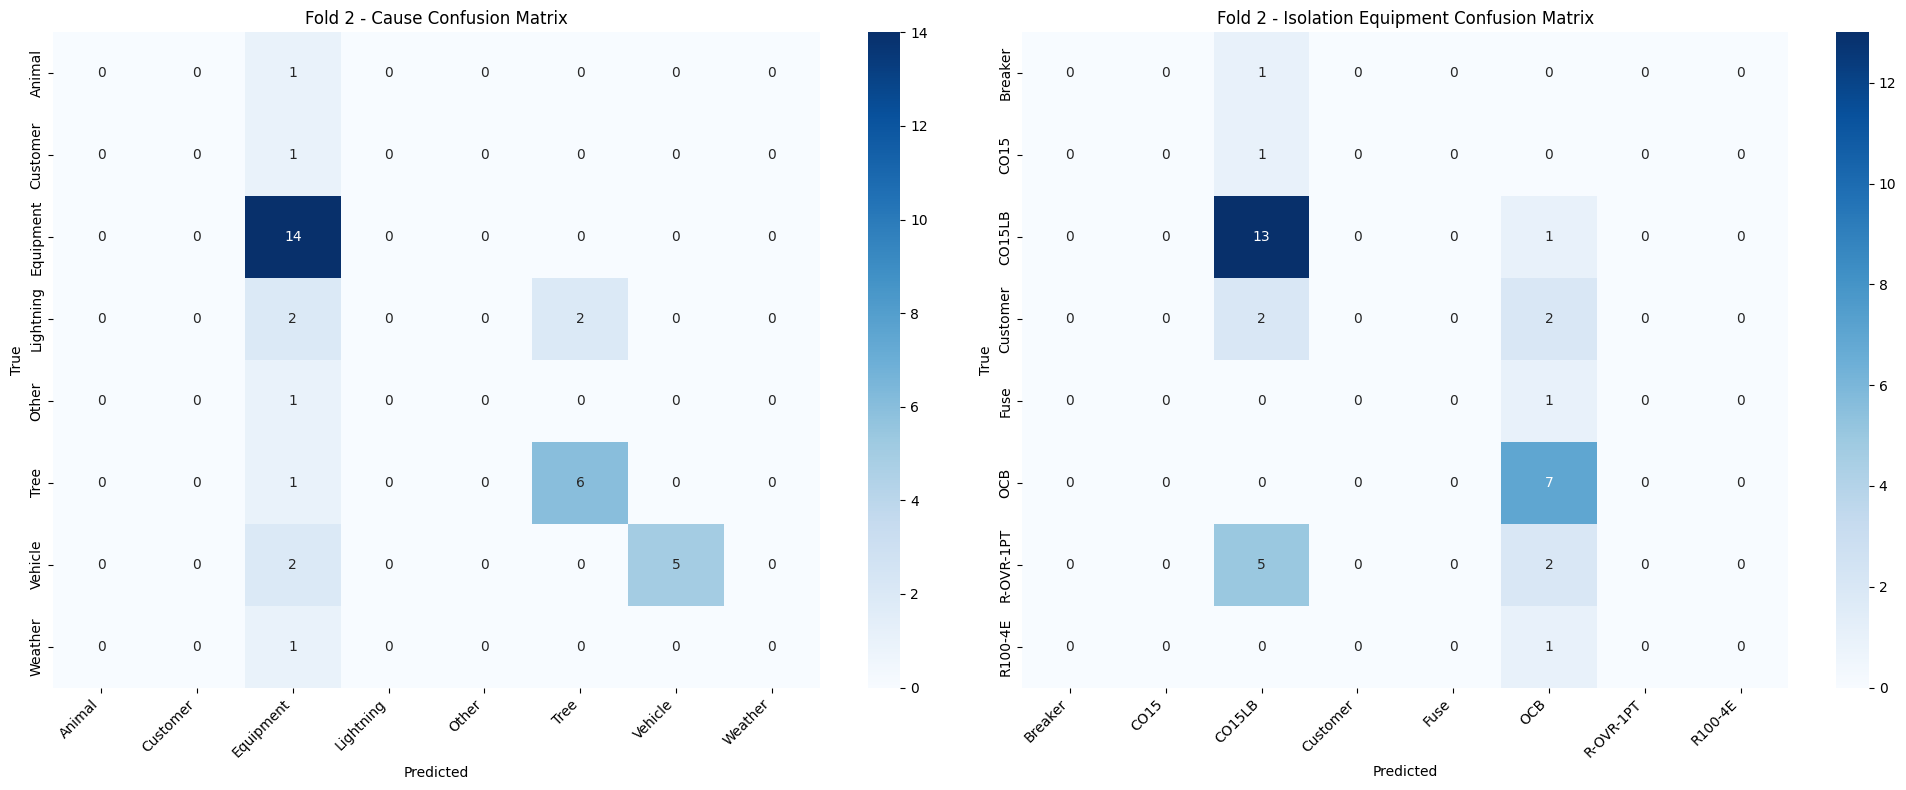


Classification Report - Cause (Fold 2):
              precision    recall  f1-score   support

      Animal       0.00      0.00      0.00         1
    Customer       0.00      0.00      0.00         1
   Equipment       0.61      1.00      0.76        14
   Lightning       0.00      0.00      0.00         4
       Other       0.00      0.00      0.00         1
        Tree       0.75      0.86      0.80         7
     Vehicle       1.00      0.71      0.83         7
     Weather       0.00      0.00      0.00         1

    accuracy                           0.69        36
   macro avg       0.29      0.32      0.30        36
weighted avg       0.58      0.69      0.61        36


Classification Report - Isolation Equipment (Fold 2):
              precision    recall  f1-score   support

     Breaker       0.00      0.00      0.00         1
        CO15       0.00      0.00      0.00         1
      CO15LB       0.59      0.93      0.72        14
    Customer       0.00      0.00   

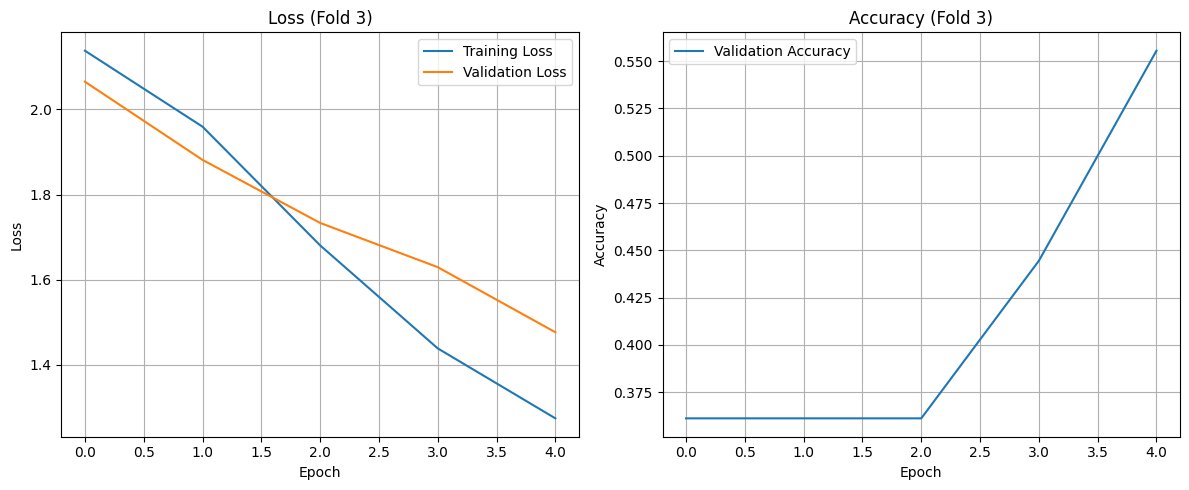

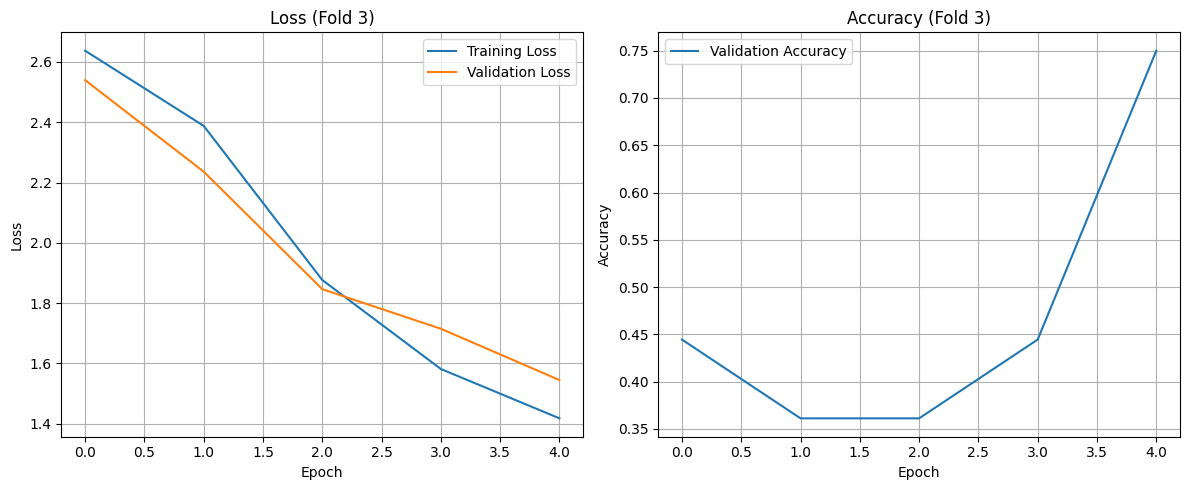


Final evaluation for fold 3...

Fold 3 Times:
Training time: 0:00:02
Evaluation time: 0:00:00
Total time: 0:00:03

Fold 3 Results:
Cause - Accuracy: 0.5556, Precision: 0.6619, F1: 0.5011
Isolation - Accuracy: 0.7500, Precision: 0.6402, F1: 0.6769


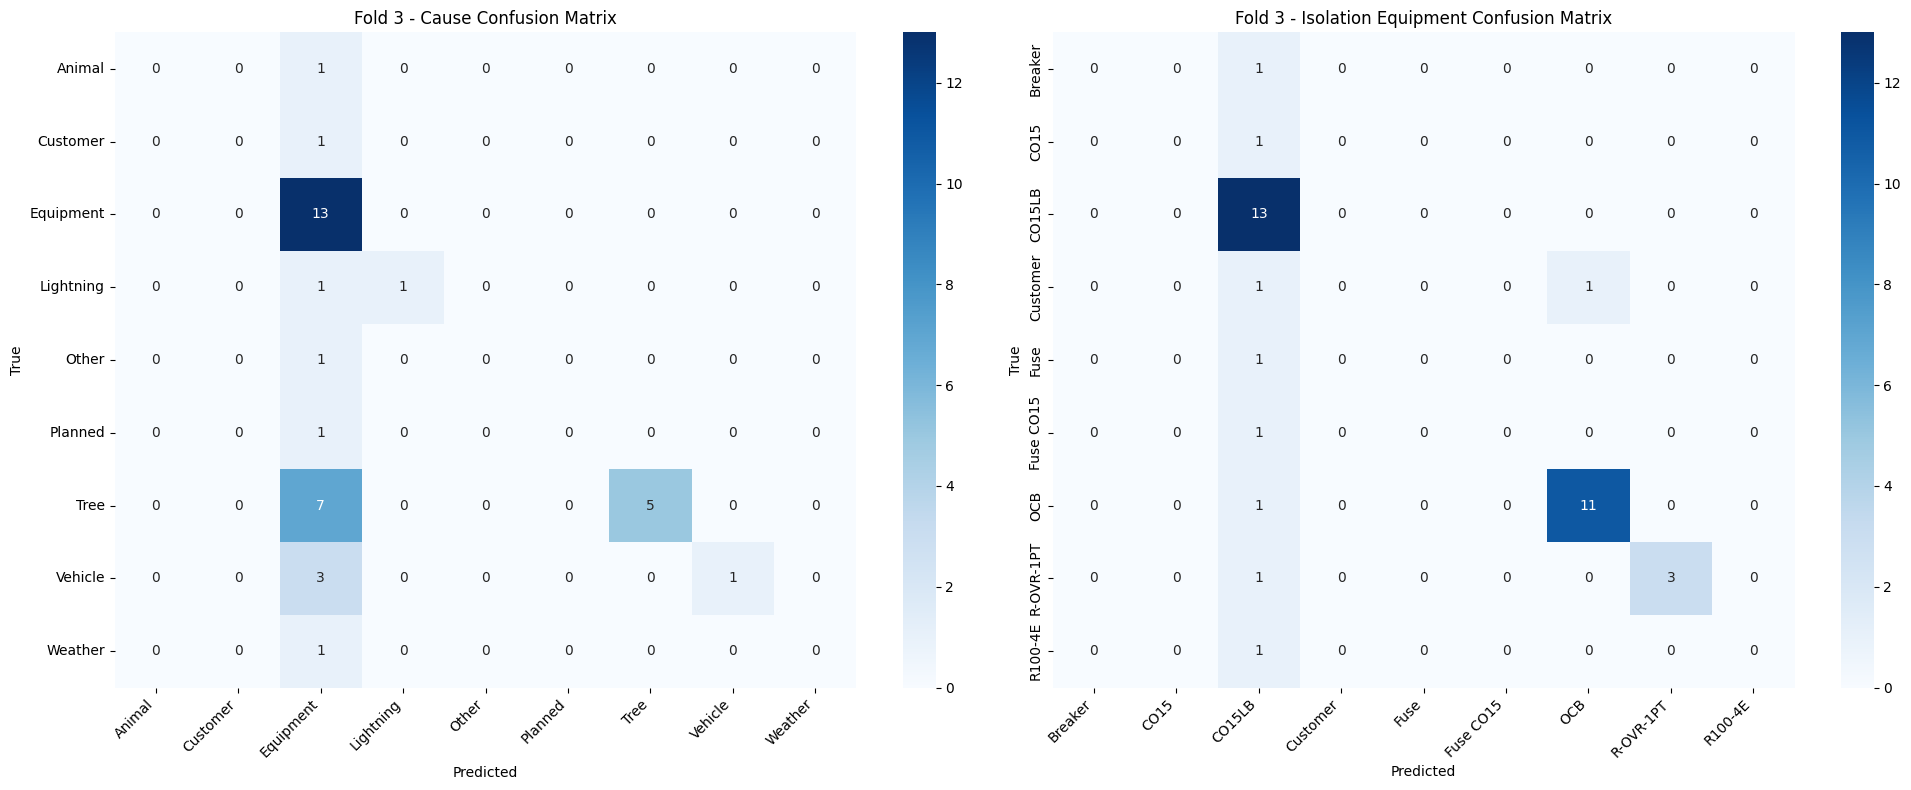


Classification Report - Cause (Fold 3):
              precision    recall  f1-score   support

      Animal       0.00      0.00      0.00         1
    Customer       0.00      0.00      0.00         1
   Equipment       0.45      1.00      0.62        13
   Lightning       1.00      0.50      0.67         2
       Other       0.00      0.00      0.00         1
     Planned       0.00      0.00      0.00         1
        Tree       1.00      0.42      0.59        12
     Vehicle       1.00      0.25      0.40         4
     Weather       0.00      0.00      0.00         1

    accuracy                           0.56        36
   macro avg       0.38      0.24      0.25        36
weighted avg       0.66      0.56      0.50        36


Classification Report - Isolation Equipment (Fold 3):
              precision    recall  f1-score   support

     Breaker       0.00      0.00      0.00         1
        CO15       0.00      0.00      0.00         1
      CO15LB       0.62      1.00   

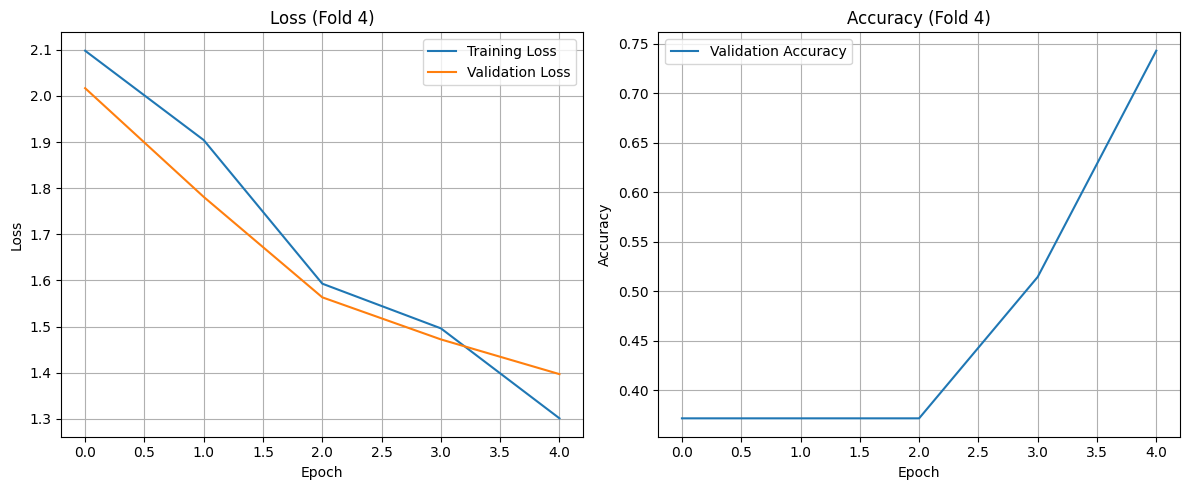

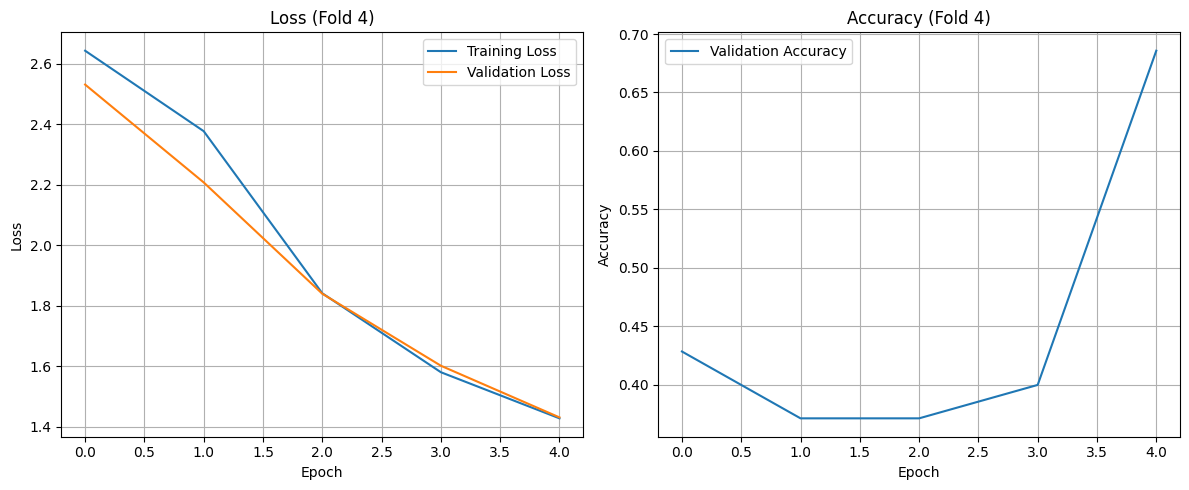


Final evaluation for fold 4...

Fold 4 Times:
Training time: 0:00:02
Evaluation time: 0:00:00
Total time: 0:00:03

Fold 4 Results:
Cause - Accuracy: 0.7429, Precision: 0.5661, F1: 0.6384
Isolation - Accuracy: 0.6857, Precision: 0.5492, F1: 0.5943


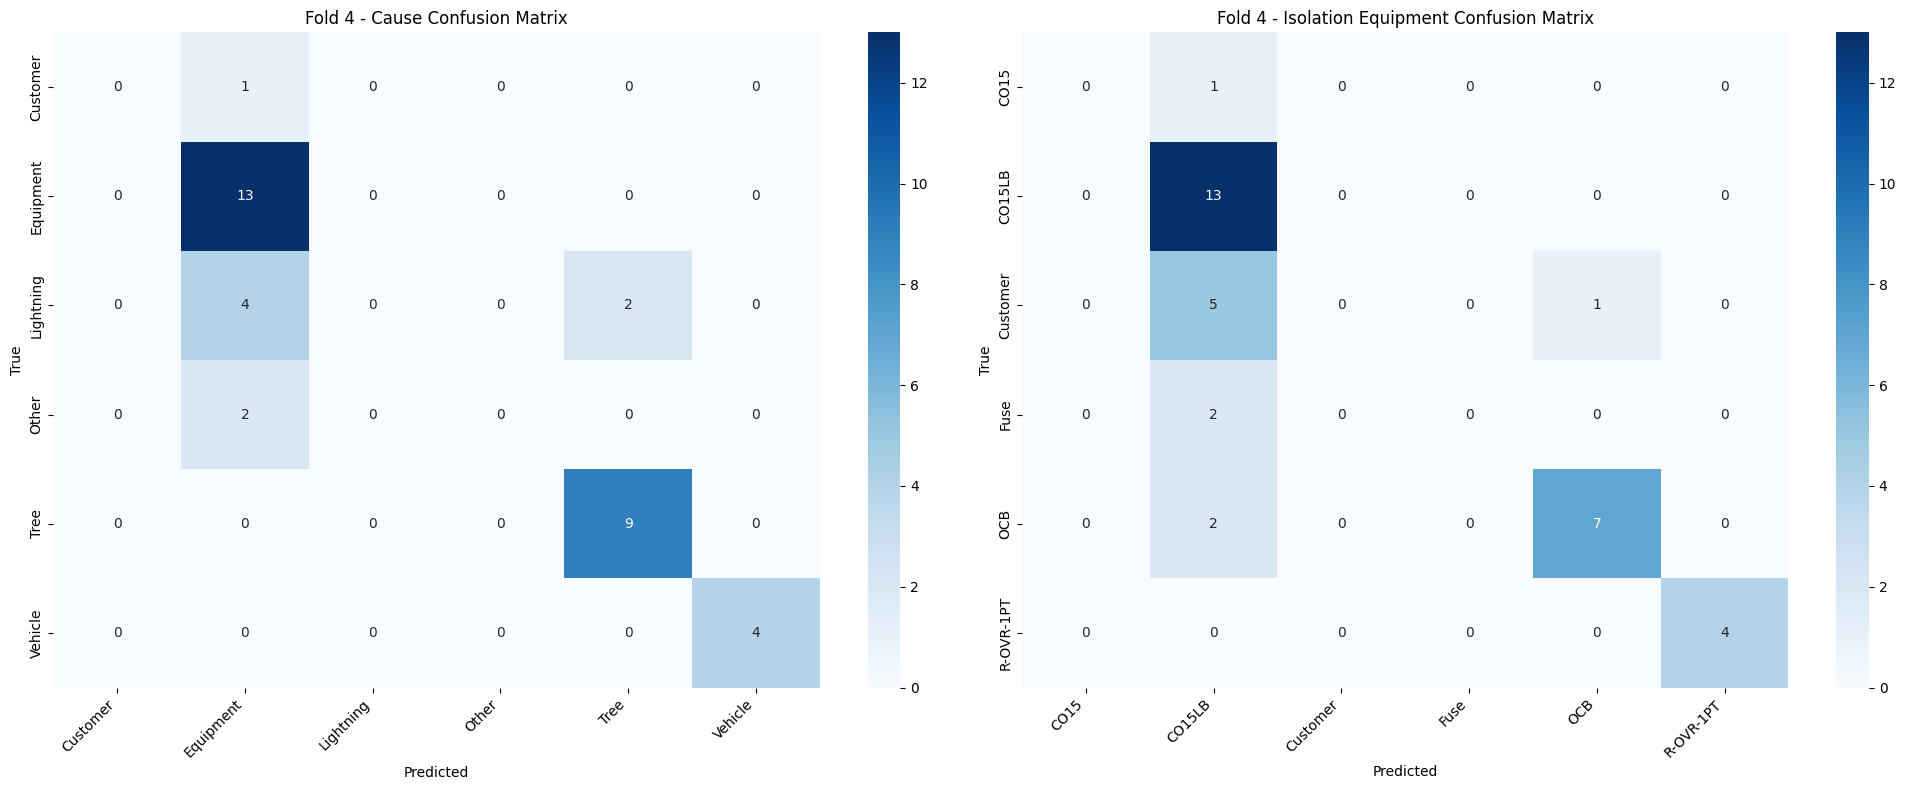


Classification Report - Cause (Fold 4):
              precision    recall  f1-score   support

    Customer       0.00      0.00      0.00         1
   Equipment       0.65      1.00      0.79        13
   Lightning       0.00      0.00      0.00         6
       Other       0.00      0.00      0.00         2
        Tree       0.82      1.00      0.90         9
     Vehicle       1.00      1.00      1.00         4

    accuracy                           0.74        35
   macro avg       0.41      0.50      0.45        35
weighted avg       0.57      0.74      0.64        35


Classification Report - Isolation Equipment (Fold 4):
              precision    recall  f1-score   support

        CO15       0.00      0.00      0.00         1
      CO15LB       0.57      1.00      0.72        13
    Customer       0.00      0.00      0.00         6
        Fuse       0.00      0.00      0.00         2
         OCB       0.88      0.78      0.82         9
   R-OVR-1PT       1.00      1.00   

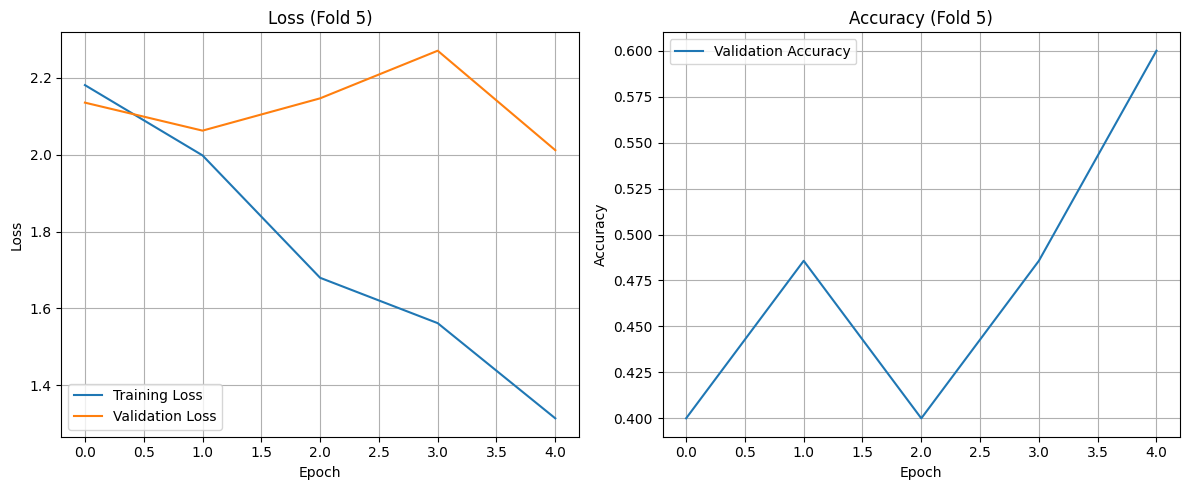

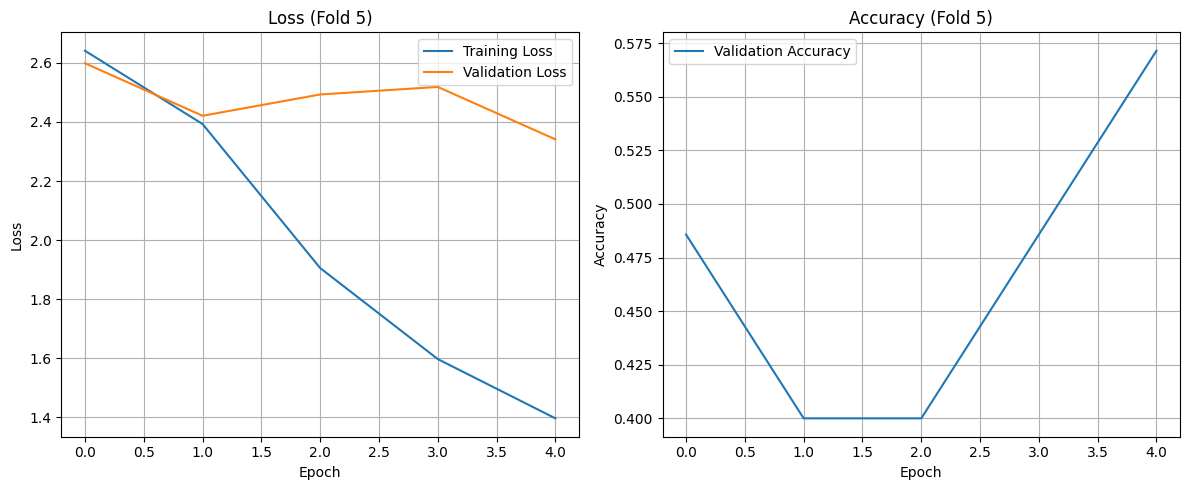


Final evaluation for fold 5...

Fold 5 Times:
Training time: 0:00:03
Evaluation time: 0:00:01
Total time: 0:00:04

Fold 5 Results:
Cause - Accuracy: 0.6000, Precision: 0.4190, F1: 0.4871
Isolation - Accuracy: 0.5714, Precision: 0.3954, F1: 0.4586


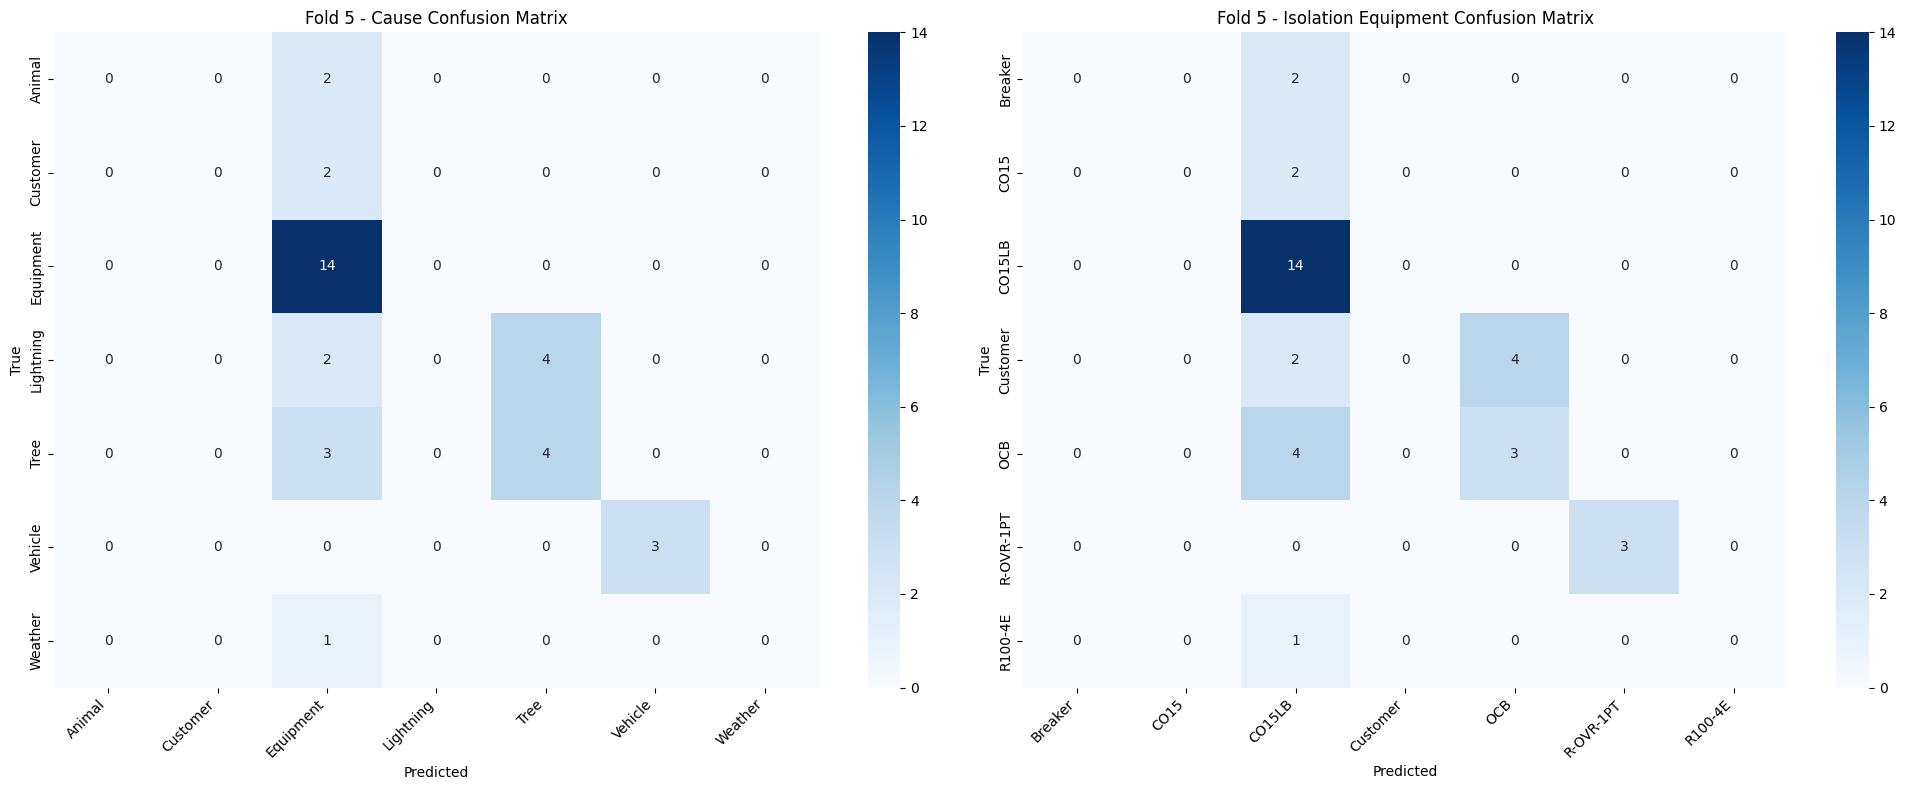


Classification Report - Cause (Fold 5):
              precision    recall  f1-score   support

      Animal       0.00      0.00      0.00         2
    Customer       0.00      0.00      0.00         2
   Equipment       0.58      1.00      0.74        14
   Lightning       0.00      0.00      0.00         6
        Tree       0.50      0.57      0.53         7
     Vehicle       1.00      1.00      1.00         3
     Weather       0.00      0.00      0.00         1

    accuracy                           0.60        35
   macro avg       0.30      0.37      0.32        35
weighted avg       0.42      0.60      0.49        35


Classification Report - Isolation Equipment (Fold 5):
              precision    recall  f1-score   support

     Breaker       0.00      0.00      0.00         2
        CO15       0.00      0.00      0.00         2
      CO15LB       0.56      1.00      0.72        14
    Customer       0.00      0.00      0.00         6
         OCB       0.43      0.43   

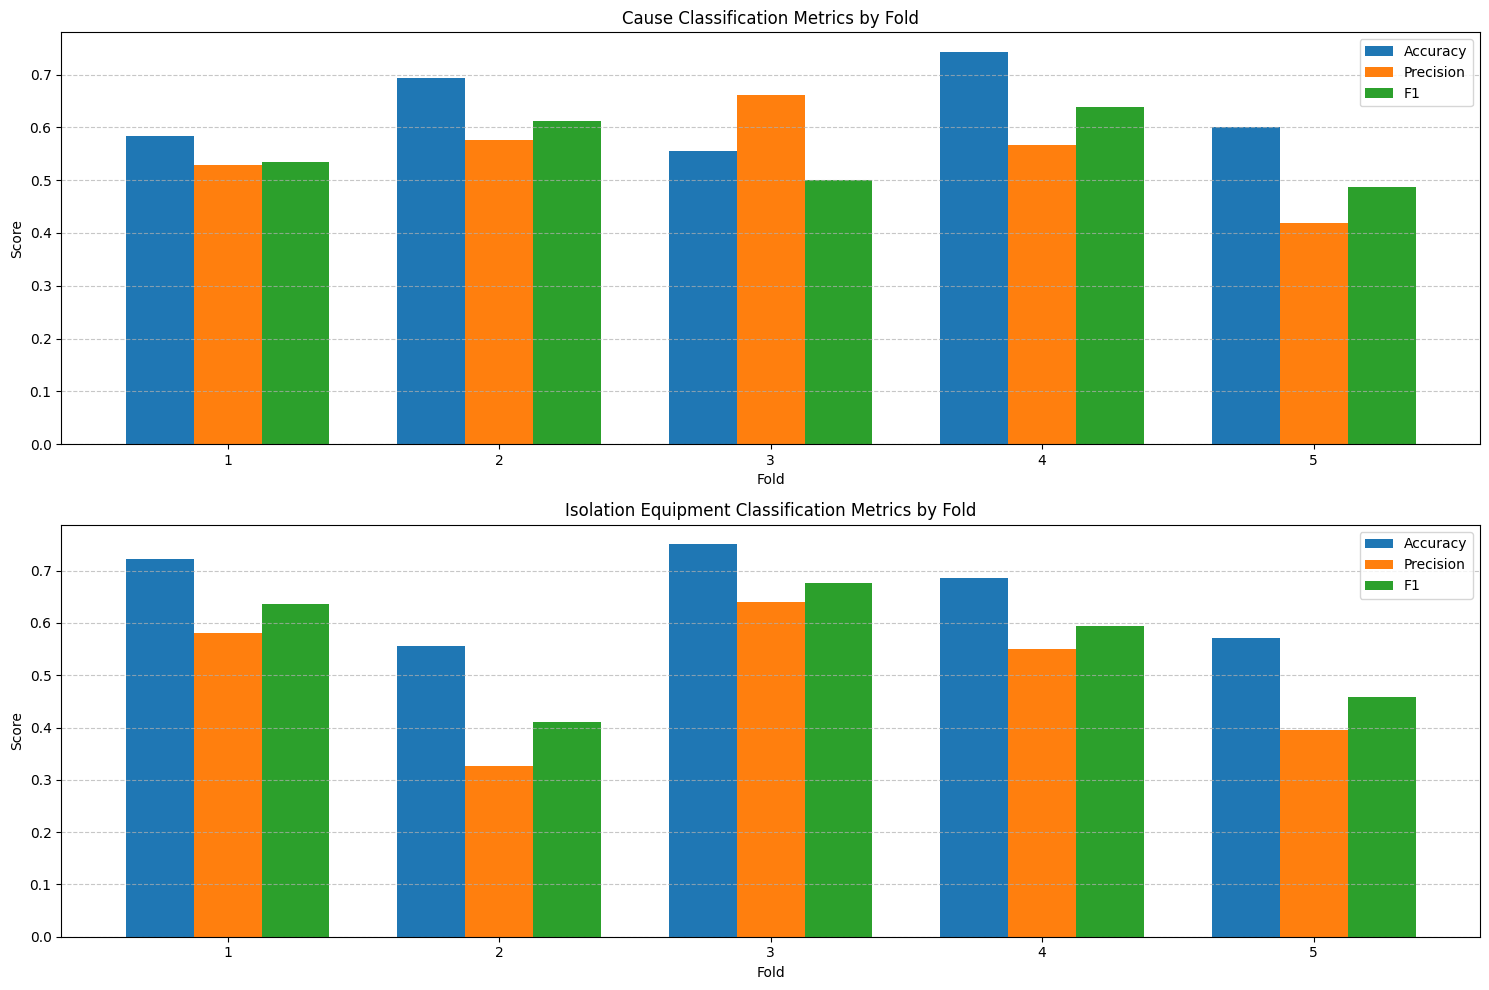


Example Text Classification:

Text: Circuit breaker tripped due to storm
Predicted cause: Tree
Predicted isolation: CO15LB

Text: Customer requested service disconnection
Predicted cause: Equipment
Predicted isolation: CO15LB

Text: Transformer failure after lightning strike
Predicted cause: Equipment
Predicted isolation: CO15LB
Predicted cause: Equipment
Predicted isolation: CO15LB
Predicted cause: Equipment
Predicted isolation: CO15LB


In [3]:
import numpy as np
import pandas as pd
import time
import os
from datetime import timedelta
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, accuracy_score

# For deep learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torch.nn.functional import one_hot

# Set parameters
data_path = "PQEvents_Ticket_csv.csv"
text_column_name = "Details"
label_column_name = "Cause"
test_size = 0.2
n_splits = 5  # Number of folds for K-fold cross-validation

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Create directory for results
os.makedirs("./results", exist_ok=True)

# Load and preprocess data
print("Loading and preprocessing data...")
df = pd.read_csv(data_path)

# First, clean up Cause column
df = df[~df['Cause'].isin(['Unknown', 'Undetermined'])]  # Remove rows with these values in Cause column 
df['Cause'] = df['Cause'].replace(['Customer Request', 'Customer Caused'], 'Customer')

# Replace Unknown/Undetermined in Isolation Equipment Code
df['Isolation Equipment Code'] = df['Isolation Equipment Code'].replace(['Unknown', 'Undetermined'], np.nan)

# Only drop rows where Cause is NaN
df = df.dropna(subset=['Cause'])

# If 'Cause' is 'Customer' and 'Isolation Equipment Code' is NaN, set 'Isolation Equipment Code' to 'Customer'
df.loc[(df['Cause'] == 'Customer') & (df['Isolation Equipment Code'].isna()), 'Isolation Equipment Code'] = 'Customer'

# Drop rows where 'Isolation Equipment Code' is NaN, but only for causes other than 'Customer'
df = df.dropna(subset=['Isolation Equipment Code'])

# Keep only rows where 'Details' is a string
df = df[df['Details'].apply(lambda x: isinstance(x, str))]

# Function to clean text data
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    return text

# Apply text cleaning
df['Details'] = df['Details'].apply(clean_text)

# Print distributions
print("\nUnique Cause Classes with Counts:")
print("-" * 40)
cause_unique = df['Cause'].value_counts()
for cause, count in cause_unique.items():
    print(f"{cause:<20} {count:>5}")

print("\nIsolation Equipment Codes for Customer causes:")
print(df[df['Cause'] == 'Customer']['Isolation Equipment Code'].value_counts(dropna=False))

print(f"\nDataset shape: {df.shape}")

# Create label encoders
le_cause = preprocessing.LabelEncoder()
le_isolation = preprocessing.LabelEncoder()

# Fit both encoders
le_cause.fit(df[label_column_name].tolist())
le_isolation.fit(df['Isolation Equipment Code'].tolist())

# Transform labels
df['cause_label'] = le_cause.transform(df[label_column_name].tolist())
df['isolation_label'] = le_isolation.transform(df['Isolation Equipment Code'].tolist())

# Print out the labels with their corresponding encoded values
label_mapping = dict(zip(le_cause.classes_, le_cause.transform(le_cause.classes_)))
print("Cause Label Mapping:")
for label, encoded_value in label_mapping.items():
    print(f"{label}: {encoded_value}")

print()

# Print out the labels with their corresponding encoded values
label_mapping = dict(zip(le_isolation.classes_, le_isolation.transform(le_isolation.classes_)))
print("Isolation Equipment Label Mapping:")
for label, encoded_value in label_mapping.items():
    print(f"{label}: {encoded_value}")

df['text_cleaned'] = df[text_column_name]

# Count the number of data points for each cause
cause_counts = df[label_column_name].value_counts()
code_counts = df['Isolation Equipment Code'].value_counts()

# Print the counts
print("\nCause counts:")
print(cause_counts)
print("\nIsolation Equipment Code counts:")
print(code_counts)

# Create vocabulary
print("\nBuilding vocabulary and preparing for LSTM...")
all_text = ' '.join(df['text_cleaned'].tolist())
words = set(all_text.split())
word_to_ix = {word: i+1 for i, word in enumerate(words)}  # +1 because 0 will be used for padding
word_to_ix['<PAD>'] = 0  # Add padding token
vocab_size = len(word_to_ix)
print(f"Vocabulary size: {vocab_size}")

# Convert text to sequences of word indices
def text_to_sequence(text, word_to_ix, max_len=None):
    words = text.split()
    if max_len is not None:
        words = words[:max_len]
    indices = [word_to_ix.get(word, 0) for word in words]  # Use 0 for OOV words
    return torch.tensor(indices, dtype=torch.long)

# Find max sequence length for padding
max_seq_len = max(len(text.split()) for text in df['text_cleaned'])
print(f"Maximum sequence length: {max_seq_len}")

# Create PyTorch Dataset
class TextDataset(Dataset):
    def __init__(self, texts, cause_labels, isolation_labels, word_to_ix, max_len=None):
        self.texts = texts
        self.cause_labels = cause_labels
        self.isolation_labels = isolation_labels
        self.word_to_ix = word_to_ix
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        cause_label = self.cause_labels[idx]
        isolation_label = self.isolation_labels[idx]
        
        # Convert text to sequence
        sequence = text_to_sequence(text, self.word_to_ix, self.max_len)
        
        return sequence, cause_label, isolation_label

# Padding collate function
def collate_fn(batch):
    sequences, cause_labels, isolation_labels = zip(*batch)
    
    # Pad sequences
    padded_sequences = pad_sequence(sequences, batch_first=True)
    
    # Convert labels to tensors
    cause_labels = torch.tensor(cause_labels, dtype=torch.long)
    isolation_labels = torch.tensor(isolation_labels, dtype=torch.long)
    
    return padded_sequences, cause_labels, isolation_labels

# BiLSTM model for text classification
class BiLSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional=True, dropout=0.5):
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, 
                          hidden_dim, 
                          num_layers=n_layers, 
                          bidirectional=bidirectional, 
                          dropout=dropout if n_layers > 1 else 0,
                          batch_first=True)
        
        # If bidirectional, multiply hidden_dim by 2
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        # text = [batch size, sent len]
        embedded = self.dropout(self.embedding(text))
        # embedded = [batch size, sent len, emb dim]
        
        output, (hidden, cell) = self.lstm(embedded)
        # output = [batch size, sent len, hid dim * num directions]
        # hidden = [num layers * num directions, batch size, hid dim]
        
        # Concatenate the final forward and backward hidden states
        if self.lstm.bidirectional:
            hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        else:
            hidden = hidden[-1,:,:]
        # hidden = [batch size, hid dim * num directions]
            
        return self.fc(self.dropout(hidden))

# Training function
def train(model, iterator, optimizer, criterion, device):
    model.train()
    
    epoch_loss = 0
    correct = 0
    total = 0
    
    for batch_idx, (text, labels, _) in enumerate(iterator):
        text, labels = text.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        # Forward pass
        predictions = model(text)
        
        # Calculate loss
        loss = criterion(predictions, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Update metrics
        epoch_loss += loss.item()
        _, predicted = torch.max(predictions.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    return epoch_loss / len(iterator), correct / total

# Evaluation function
def evaluate(model, iterator, criterion, device):
    model.eval()
    
    epoch_loss = 0
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for text, labels, _ in iterator:
            text, labels = text.to(device), labels.to(device)
            
            # Forward pass
            predictions = model(text)
            
            # Calculate loss
            loss = criterion(predictions, labels)
            
            # Update metrics
            epoch_loss += loss.item()
            _, predicted = torch.max(predictions.data, 1)
            
            # Collect predictions and labels for metrics calculation
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_predictions, average='weighted', zero_division=0)
    
    return epoch_loss / len(iterator), accuracy, precision, f1, all_predictions, all_labels

# Plot training and validation loss/accuracy
def plot_metrics(train_losses, val_losses, val_accuracies, fold=None):
    fold_title = f" (Fold {fold})" if fold is not None else ""
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title(f'Loss{fold_title}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title(f'Accuracy{fold_title}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Function to plot confusion matrices
def plot_confusion_matrices(true_labels, predicted_labels, label_encoder, title_prefix="", ax=None):
    """Plot confusion matrix for given true and predicted labels"""
    
    # Get unique labels present in data
    unique_labels = np.unique(np.concatenate([true_labels, predicted_labels]))
    class_names = label_encoder.classes_[unique_labels]
    
    # Create confusion matrix
    conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=unique_labels)
    
    # Plot
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))
    
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names,
                ax=ax)
    ax.set_title(f'{title_prefix} Confusion Matrix')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    
    return conf_matrix

# Initialize KFold cross-validator
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Model hyperparameters
EMBEDDING_DIM = 100
HIDDEN_DIM = 128
NUM_LAYERS = 2
DROPOUT = 0.5
BATCH_SIZE = 32
NUM_EPOCHS = 5  # You can increase this for better performance
LEARNING_RATE = 1e-3

# Results tracking
cause_accuracies = []
cause_precisions = []
cause_f1_scores = []
isolation_accuracies = []
isolation_precisions = []
isolation_f1_scores = []
fold_times = []

# K-fold cross-validation
print(f"\nStarting {n_splits}-fold cross-validation...")
for fold, (train_idx, test_idx) in enumerate(kf.split(df)):
    print(f"\n{'='*80}\nFold {fold+1}/{n_splits}\n{'='*80}")
    
    # Split data for this fold
    df_train = df.iloc[train_idx]
    df_test = df.iloc[test_idx]
    
    # Create datasets
    train_dataset = TextDataset(
        df_train['text_cleaned'].tolist(),
        df_train['cause_label'].tolist(),
        df_train['isolation_label'].tolist(),
        word_to_ix
    )
    
    test_dataset = TextDataset(
        df_test['text_cleaned'].tolist(),
        df_test['cause_label'].tolist(),
        df_test['isolation_label'].tolist(),
        word_to_ix
    )
    
    # Create data loaders
    train_loader = DataLoader(
        train_dataset, 
        batch_size=BATCH_SIZE, 
        shuffle=True,
        collate_fn=collate_fn
    )
    
    test_loader = DataLoader(
        test_dataset, 
        batch_size=BATCH_SIZE,
        collate_fn=collate_fn
    )
    
    # Initialize models for this fold
    print("Initializing Cause BiLSTM model...")
    cause_model = BiLSTMClassifier(
        vocab_size=vocab_size,
        embedding_dim=EMBEDDING_DIM,
        hidden_dim=HIDDEN_DIM,
        output_dim=len(le_cause.classes_),
        n_layers=NUM_LAYERS,
        bidirectional=True,
        dropout=DROPOUT
    ).to(device)
    
    print("Initializing Isolation BiLSTM model...")
    isolation_model = BiLSTMClassifier(
        vocab_size=vocab_size,
        embedding_dim=EMBEDDING_DIM,
        hidden_dim=HIDDEN_DIM,
        output_dim=len(le_isolation.classes_),
        n_layers=NUM_LAYERS,
        bidirectional=True,
        dropout=DROPOUT
    ).to(device)
    
    # Optimizers and loss functions
    cause_optimizer = optim.Adam(cause_model.parameters(), lr=LEARNING_RATE)
    isolation_optimizer = optim.Adam(isolation_model.parameters(), lr=LEARNING_RATE)
    
    criterion = nn.CrossEntropyLoss()
    
    # For tracking metrics
    cause_train_losses = []
    cause_val_losses = []
    cause_val_accs = []
    
    isolation_train_losses = []
    isolation_val_losses = []
    isolation_val_accs = []
    
    # Start timing for training and evaluation
    start_time = time.time()
    
    # Training loop
    print(f"Training models for fold {fold+1}...")
    for epoch in range(NUM_EPOCHS):
        # Train cause model
        cause_train_loss, cause_train_acc = train(
            cause_model, train_loader, cause_optimizer, criterion, device
        )
        
        # Evaluate cause model
        cause_val_loss, cause_val_acc, cause_val_prec, cause_val_f1, _, _ = evaluate(
            cause_model, test_loader, criterion, device
        )
        
        # Train isolation model
        isolation_train_loss, isolation_train_acc = train(
            isolation_model, train_loader, isolation_optimizer, criterion, device
        )
        
        # Evaluate isolation model
        isolation_val_loss, isolation_val_acc, isolation_val_prec, isolation_val_f1, _, _ = evaluate(
            isolation_model, test_loader, criterion, device
        )
        
        # Track metrics
        cause_train_losses.append(cause_train_loss)
        cause_val_losses.append(cause_val_loss)
        cause_val_accs.append(cause_val_acc)
        
        isolation_train_losses.append(isolation_train_loss)
        isolation_val_losses.append(isolation_val_loss)
        isolation_val_accs.append(isolation_val_acc)
        
        print(f"Epoch: {epoch+1}")
        print(f"Cause - Train Loss: {cause_train_loss:.4f}, Train Acc: {cause_train_acc:.4f}, Val Loss: {cause_val_loss:.4f}, Val Acc: {cause_val_acc:.4f}")
        print(f"Isolation - Train Loss: {isolation_train_loss:.4f}, Train Acc: {isolation_train_acc:.4f}, Val Loss: {isolation_val_loss:.4f}, Val Acc: {isolation_val_acc:.4f}")
    
    # End timing for training
    train_end_time = time.time()
    training_time = train_end_time - start_time
    
    # Plot training metrics
    plot_metrics(cause_train_losses, cause_val_losses, cause_val_accs, fold+1)
    plot_metrics(isolation_train_losses, isolation_val_losses, isolation_val_accs, fold+1)
    
    # Final evaluation
    print(f"\nFinal evaluation for fold {fold+1}...")
    _, cause_accuracy, cause_precision, cause_f1, cause_preds, cause_true = evaluate(
        cause_model, test_loader, criterion, device
    )
    
    _, isolation_accuracy, isolation_precision, isolation_f1, isolation_preds, isolation_true = evaluate(
        isolation_model, test_loader, criterion, device
    )
    
    # End timing for evaluation
    eval_end_time = time.time()
    eval_time = eval_end_time - train_end_time
    
    # Total time for this fold
    fold_total_time = training_time + eval_time
    fold_times.append(fold_total_time)
    
    print(f"\nFold {fold+1} Times:")
    print(f"Training time: {timedelta(seconds=int(training_time))}")
    print(f"Evaluation time: {timedelta(seconds=int(eval_time))}")
    print(f"Total time: {timedelta(seconds=int(fold_total_time))}")
    
    # Store metrics
    cause_accuracies.append(cause_accuracy)
    cause_precisions.append(cause_precision)
    cause_f1_scores.append(cause_f1)
    
    isolation_accuracies.append(isolation_accuracy)
    isolation_precisions.append(isolation_precision)
    isolation_f1_scores.append(isolation_f1)
    
    # Print metrics for this fold
    print(f"\nFold {fold+1} Results:")
    print(f"Cause - Accuracy: {cause_accuracy:.4f}, Precision: {cause_precision:.4f}, F1: {cause_f1:.4f}")
    print(f"Isolation - Accuracy: {isolation_accuracy:.4f}, Precision: {isolation_precision:.4f}, F1: {isolation_f1:.4f}")
    
    # Plot confusion matrices
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Use numpy arrays for the confusion matrices
    cause_true = np.array(cause_true)
    cause_preds = np.array(cause_preds)
    isolation_true = np.array(isolation_true)
    isolation_preds = np.array(isolation_preds)
    
    plot_confusion_matrices(cause_true, cause_preds, le_cause, f"Fold {fold+1} - Cause", ax1)
    plot_confusion_matrices(isolation_true, isolation_preds, le_isolation, f"Fold {fold+1} - Isolation Equipment", ax2)
    
    plt.tight_layout()
    plt.show()
    
    # Get unique labels present in test data for classification report
    unique_cause_labels = np.unique(np.concatenate([cause_true, cause_preds]))
    unique_isolation_labels = np.unique(np.concatenate([isolation_true, isolation_preds]))

    # Get class names for present labels
    cause_class_names = le_cause.classes_[unique_cause_labels]
    isolation_class_names = le_isolation.classes_[unique_isolation_labels]
    
    # Print classification reports
    print(f"\nClassification Report - Cause (Fold {fold+1}):")
    print(classification_report(
        cause_true, cause_preds,
        labels=unique_cause_labels,
        target_names=cause_class_names,
        zero_division=0
    ))

    print(f"\nClassification Report - Isolation Equipment (Fold {fold+1}):")
    print(classification_report(
        isolation_true, isolation_preds,
        labels=unique_isolation_labels,
        target_names=isolation_class_names,
        zero_division=0
    ))
    
    # Save models for this fold
    torch.save(cause_model.state_dict(), f"./results/cause_model_fold_{fold+1}.pt")
    torch.save(isolation_model.state_dict(), f"./results/isolation_model_fold_{fold+1}.pt")

# Print average results across all folds
print("\n" + "="*80)
print("AVERAGE RESULTS ACROSS ALL FOLDS")
print("="*80)

print(f"Cause - Avg Accuracy: {np.mean(cause_accuracies):.4f} ± {np.std(cause_accuracies):.4f}")
print(f"Cause - Avg Precision: {np.mean(cause_precisions):.4f} ± {np.std(cause_precisions):.4f}")
print(f"Cause - Avg F1: {np.mean(cause_f1_scores):.4f} ± {np.std(cause_f1_scores):.4f}")

print(f"Isolation - Avg Accuracy: {np.mean(isolation_accuracies):.4f} ± {np.std(isolation_accuracies):.4f}")
print(f"Isolation - Avg Precision: {np.mean(isolation_precisions):.4f} ± {np.std(isolation_precisions):.4f}")
print(f"Isolation - Avg F1: {np.mean(isolation_f1_scores):.4f} ± {np.std(isolation_f1_scores):.4f}")

print(f"\nAverage Time per Fold: {timedelta(seconds=int(np.mean(fold_times)))}")
print(f"Total Time for all Folds: {timedelta(seconds=int(np.sum(fold_times)))}")

# Plot metrics across folds
plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
x = np.arange(1, n_splits+1)
width = 0.25
plt.bar(x - width, cause_accuracies, width, label='Accuracy')
plt.bar(x, cause_precisions, width, label='Precision')
plt.bar(x + width, cause_f1_scores, width, label='F1')
plt.xlabel('Fold')
plt.ylabel('Score')
plt.title('Cause Classification Metrics by Fold')
plt.xticks(x)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.subplot(2, 1, 2)
plt.bar(x - width, isolation_accuracies, width, label='Accuracy')
plt.bar(x, isolation_precisions, width, label='Precision')
plt.bar(x + width, isolation_f1_scores, width, label='F1')
plt.xlabel('Fold')
plt.ylabel('Score')
plt.title('Isolation Equipment Classification Metrics by Fold')
plt.xticks(x)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Function to classify new text
def classify_text(text, cause_model, isolation_model, word_to_ix):
    # Clean text
    cleaned_text = clean_text(text)
    
    # Convert to sequence
    sequence = text_to_sequence(cleaned_text, word_to_ix)
    sequence = sequence.unsqueeze(0).to(device)  # Add batch dimension
    
    # Get predictions
    cause_model.eval()
    isolation_model.eval()
    
    with torch.no_grad():
        cause_output = cause_model(sequence)
        isolation_output = isolation_model(sequence)
        
        cause_pred = torch.argmax(cause_output, dim=1).item()
        isolation_pred = torch.argmax(isolation_output, dim=1).item()
        
        predicted_cause = le_cause.inverse_transform([cause_pred])[0]
        predicted_isolation = le_isolation.inverse_transform([isolation_pred])[0]
    
    return predicted_cause, predicted_isolation

# Example classification
print("\nExample Text Classification:")
sample_texts = [
    "Circuit breaker tripped due to storm",
    "Customer requested service disconnection",
    "Transformer failure after lightning strike"
]

for text in sample_texts:
    cause, isolation = classify_text(text, cause_model, isolation_model, word_to_ix)
    print(f"\nText: {text}")
    print(f"Predicted cause: {cause}")
    print(f"Predicted isolation: {isolation}")

# Interactive classification
while True:
    text = input("\nEnter text to classify (or 'quit' to exit): ")
    if text.lower() == 'quit':
        break
    cause, isolation = classify_text(text, cause_model, isolation_model, word_to_ix)
    print(f"Predicted cause: {cause}")
    print(f"Predicted isolation: {isolation}")

# BERT with kfold plus adaptation


Unique Cause Classes with Counts:
----------------------------------------
Equipment               73
Tree                    39
Vehicle                 23
Lightning               21
Animal                   7
Customer                 6
Other                    4
Weather                  3
Planned                  2

Isolation Equipment Codes for Customer causes:
Isolation Equipment Code
Customer    5
Switch      1
Name: count, dtype: int64

Dataset shape: (178, 12)
Cause Label Mapping:
Animal: 0
Customer: 1
Equipment: 2
Lightning: 3
Other: 4
Planned: 5
Tree: 6
Vehicle: 7
Weather: 8

Isolation Equipment Label Mapping:
Breaker: 0
CO15: 1
CO15LB: 2
Customer: 3
Fuse: 4
Fuse CO15: 5
OCB: 6
R-OVR-1PT: 7
R100-4E: 8
R100E: 9
Recloser: 10
SECT200NLB: 11
Sectionalizer: 12
Service Restorer: 13
Switch: 14

Cause counts:
Cause
Equipment    73
Tree         39
Vehicle      23
Lightning    21
Animal        7
Customer      6
Other         4
Weather       3
Planned       2
Name: count, dtype: int64

I

Map: 100%|██████████| 36/36 [00:00<?, ? examples/s]
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at ./distilbert-pq-mlm and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at ./distilbert-pq-mlm and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\rmathew2020\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be remove

Training Cause Model (Fold 1):


 20%|██        | 18/90 [00:11<00:42,  1.67it/s]

{'loss': 1.4565, 'grad_norm': 4.1156463623046875, 'learning_rate': 0.00016, 'epoch': 1.0}



 20%|██        | 18/90 [00:12<00:42,  1.67it/s]

{'eval_loss': 0.6124852895736694, 'eval_accuracy': 0.8611111111111112, 'eval_precision': 0.7461755233494364, 'eval_f1': 0.7982202982202983, 'eval_runtime': 0.382, 'eval_samples_per_second': 94.238, 'eval_steps_per_second': 13.089, 'epoch': 1.0}


 40%|████      | 36/90 [00:24<00:31,  1.70it/s]

{'loss': 0.4835, 'grad_norm': 0.6140053272247314, 'learning_rate': 0.00012, 'epoch': 2.0}



 40%|████      | 36/90 [00:24<00:31,  1.70it/s]

{'eval_loss': 0.2731565237045288, 'eval_accuracy': 0.9722222222222222, 'eval_precision': 0.9458333333333333, 'eval_f1': 0.9586894586894587, 'eval_runtime': 0.4, 'eval_samples_per_second': 89.998, 'eval_steps_per_second': 12.5, 'epoch': 2.0}


 60%|██████    | 54/90 [00:36<00:21,  1.69it/s]

{'loss': 0.2359, 'grad_norm': 5.022607803344727, 'learning_rate': 8e-05, 'epoch': 3.0}



 60%|██████    | 54/90 [00:36<00:21,  1.69it/s]

{'eval_loss': 0.10356753319501877, 'eval_accuracy': 0.9722222222222222, 'eval_precision': 0.9513888888888888, 'eval_f1': 0.9603174603174602, 'eval_runtime': 0.3702, 'eval_samples_per_second': 97.252, 'eval_steps_per_second': 13.507, 'epoch': 3.0}


 80%|████████  | 72/90 [00:48<00:10,  1.69it/s]

{'loss': 0.1247, 'grad_norm': 0.09526627510786057, 'learning_rate': 4e-05, 'epoch': 4.0}



 80%|████████  | 72/90 [00:49<00:10,  1.69it/s]

{'eval_loss': 0.06475476920604706, 'eval_accuracy': 1.0, 'eval_precision': 1.0, 'eval_f1': 1.0, 'eval_runtime': 0.3753, 'eval_samples_per_second': 95.933, 'eval_steps_per_second': 13.324, 'epoch': 4.0}


100%|██████████| 90/90 [01:02<00:00,  1.44it/s]

{'loss': 0.0671, 'grad_norm': 0.12382523715496063, 'learning_rate': 0.0, 'epoch': 5.0}



100%|██████████| 90/90 [01:02<00:00,  1.44it/s]

{'eval_loss': 0.056335192173719406, 'eval_accuracy': 1.0, 'eval_precision': 1.0, 'eval_f1': 1.0, 'eval_runtime': 0.4984, 'eval_samples_per_second': 72.23, 'eval_steps_per_second': 10.032, 'epoch': 5.0}


100%|██████████| 90/90 [01:03<00:00,  1.41it/s]


{'train_runtime': 63.9328, 'train_samples_per_second': 11.105, 'train_steps_per_second': 1.408, 'train_loss': 0.4735365496741401, 'epoch': 5.0}

Training Isolation Model (Fold 1):


 20%|██        | 18/90 [00:11<00:42,  1.71it/s]

{'loss': 1.9144, 'grad_norm': 5.852555751800537, 'learning_rate': 0.00016, 'epoch': 1.0}



 20%|██        | 18/90 [00:12<00:42,  1.71it/s]

{'eval_loss': 1.6197758913040161, 'eval_accuracy': 0.4722222222222222, 'eval_precision': 0.49038461538461536, 'eval_f1': 0.360694027360694, 'eval_runtime': 0.4103, 'eval_samples_per_second': 87.74, 'eval_steps_per_second': 12.186, 'epoch': 1.0}


 40%|████      | 36/90 [00:24<00:32,  1.66it/s]

{'loss': 1.0312, 'grad_norm': 4.590215682983398, 'learning_rate': 0.00012, 'epoch': 2.0}



 40%|████      | 36/90 [00:25<00:32,  1.66it/s]

{'eval_loss': 0.91973876953125, 'eval_accuracy': 0.8333333333333334, 'eval_precision': 0.880621693121693, 'eval_f1': 0.8249865807836823, 'eval_runtime': 0.41, 'eval_samples_per_second': 87.797, 'eval_steps_per_second': 12.194, 'epoch': 2.0}


 60%|██████    | 54/90 [00:37<00:21,  1.68it/s]

{'loss': 0.5598, 'grad_norm': 6.2744526863098145, 'learning_rate': 8e-05, 'epoch': 3.0}



 60%|██████    | 54/90 [00:37<00:21,  1.68it/s]

{'eval_loss': 0.8234957456588745, 'eval_accuracy': 0.7777777777777778, 'eval_precision': 0.8530092592592592, 'eval_f1': 0.7675791733762749, 'eval_runtime': 0.3846, 'eval_samples_per_second': 93.603, 'eval_steps_per_second': 13.0, 'epoch': 3.0}


 80%|████████  | 72/90 [00:49<00:10,  1.70it/s]

{'loss': 0.3697, 'grad_norm': 10.47374439239502, 'learning_rate': 4e-05, 'epoch': 4.0}



 80%|████████  | 72/90 [00:50<00:10,  1.70it/s]

{'eval_loss': 0.7541612982749939, 'eval_accuracy': 0.7777777777777778, 'eval_precision': 0.8150793650793651, 'eval_f1': 0.7673456790123456, 'eval_runtime': 0.3735, 'eval_samples_per_second': 96.383, 'eval_steps_per_second': 13.387, 'epoch': 4.0}


100%|██████████| 90/90 [01:03<00:00,  1.68it/s]

{'loss': 0.2488, 'grad_norm': 2.109362840652466, 'learning_rate': 0.0, 'epoch': 5.0}



100%|██████████| 90/90 [01:03<00:00,  1.68it/s]

{'eval_loss': 0.7508046627044678, 'eval_accuracy': 0.8055555555555556, 'eval_precision': 0.8713624338624338, 'eval_f1': 0.8083199141170155, 'eval_runtime': 0.4449, 'eval_samples_per_second': 80.924, 'eval_steps_per_second': 11.239, 'epoch': 5.0}


100%|██████████| 90/90 [01:04<00:00,  1.39it/s]

{'train_runtime': 64.537, 'train_samples_per_second': 11.001, 'train_steps_per_second': 1.395, 'train_loss': 0.8247852908240424, 'epoch': 5.0}


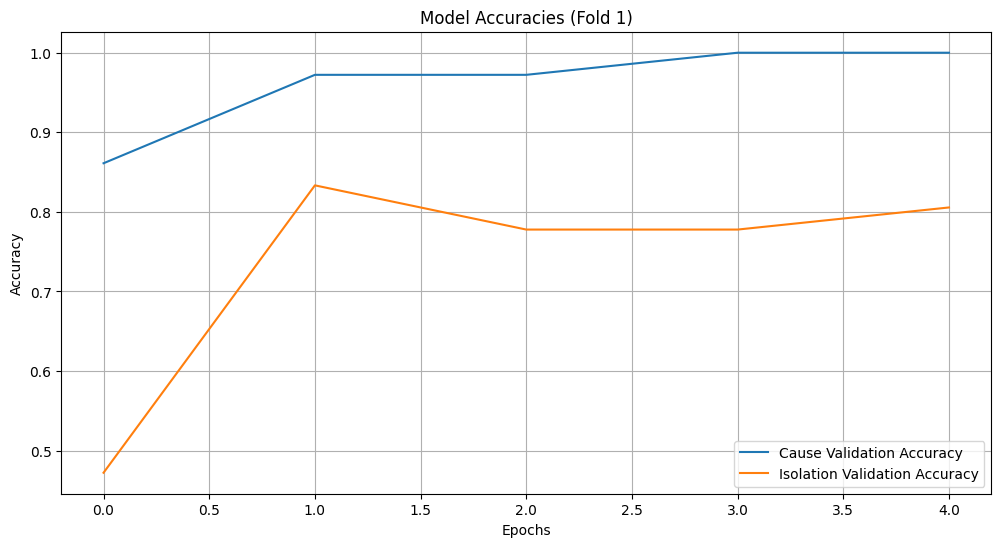

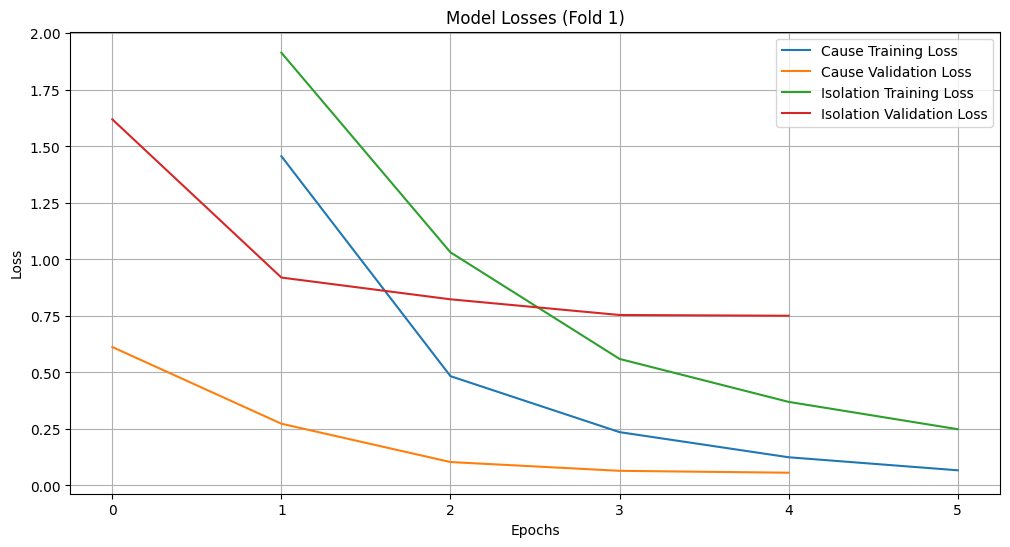


Evaluating models (Fold 1):


100%|██████████| 5/5 [00:00<00:00, 20.14it/s]



Fold 1 Times:
Training time: 0:02:09
Evaluation time: 0:00:00
Total time: 0:02:10

Fold 1 Results:
Cause - Accuracy: 1.0000, Precision: 1.0000, F1: 1.0000
Isolation - Accuracy: 0.8056, Precision: 0.8714, F1: 0.8083


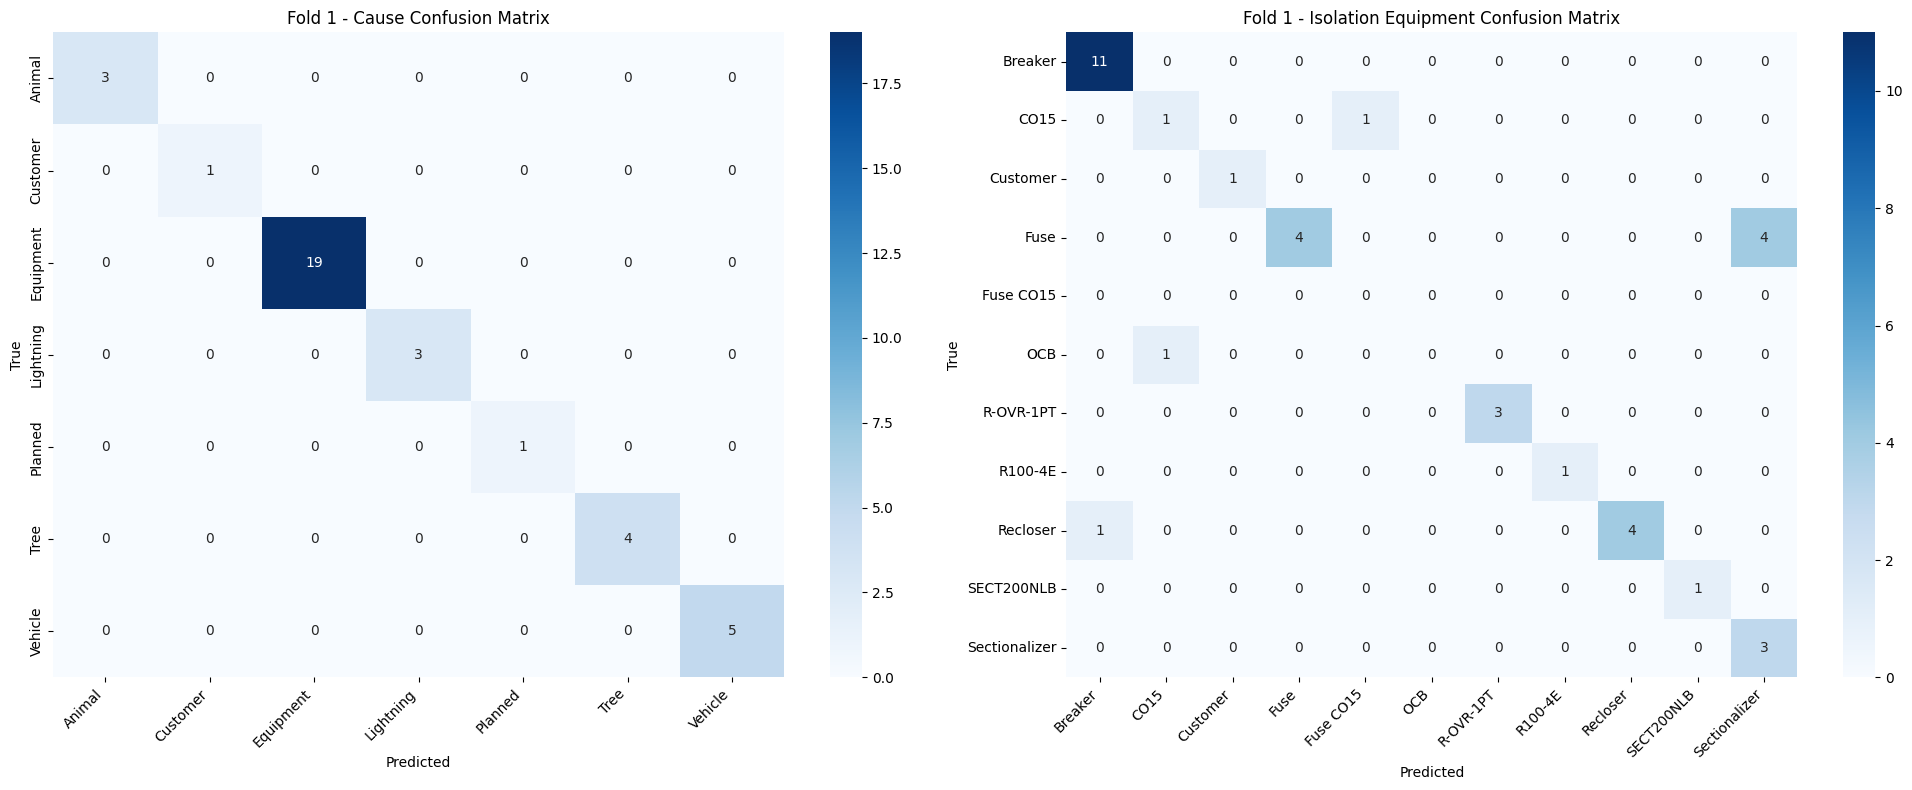


Classification Report - Cause (Fold 1):
              precision    recall  f1-score   support

      Animal       1.00      1.00      1.00         3
    Customer       1.00      1.00      1.00         1
   Equipment       1.00      1.00      1.00        19
   Lightning       1.00      1.00      1.00         3
     Planned       1.00      1.00      1.00         1
        Tree       1.00      1.00      1.00         4
     Vehicle       1.00      1.00      1.00         5

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36

Accuracy - Cause (Fold 1): 1.0000

Classification Report - Isolation Equipment (Fold 1):
               precision    recall  f1-score   support

      Breaker       0.92      1.00      0.96        11
         CO15       0.50      0.50      0.50         2
     Customer       1.00      1.00      1.00         1
         Fuse       1.00      0.50      0.67        

Map: 100%|██████████| 36/36 [00:00<00:00, 6904.84 examples/s]
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at ./distilbert-pq-mlm and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at ./distilbert-pq-mlm and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\rmathew2020\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will

Training Cause Model (Fold 2):


 20%|██        | 18/90 [00:11<00:42,  1.71it/s]

{'loss': 1.3954, 'grad_norm': 4.642135143280029, 'learning_rate': 0.00016, 'epoch': 1.0}



 20%|██        | 18/90 [00:11<00:42,  1.71it/s]

{'eval_loss': 0.6105754971504211, 'eval_accuracy': 0.8888888888888888, 'eval_precision': 0.8290123456790123, 'eval_f1': 0.8553240740740741, 'eval_runtime': 0.3944, 'eval_samples_per_second': 91.288, 'eval_steps_per_second': 12.679, 'epoch': 1.0}


 40%|████      | 36/90 [00:23<00:30,  1.75it/s]

{'loss': 0.4362, 'grad_norm': 4.36441707611084, 'learning_rate': 0.00012, 'epoch': 2.0}



 40%|████      | 36/90 [00:23<00:30,  1.75it/s]

{'eval_loss': 0.3806714117527008, 'eval_accuracy': 0.8888888888888888, 'eval_precision': 0.8888888888888888, 'eval_f1': 0.8774928774928775, 'eval_runtime': 0.3656, 'eval_samples_per_second': 98.469, 'eval_steps_per_second': 13.676, 'epoch': 2.0}


 60%|██████    | 54/90 [00:35<00:20,  1.72it/s]

{'loss': 0.1941, 'grad_norm': 0.13193243741989136, 'learning_rate': 8e-05, 'epoch': 3.0}



 60%|██████    | 54/90 [00:35<00:20,  1.72it/s]

{'eval_loss': 0.2313448041677475, 'eval_accuracy': 0.9444444444444444, 'eval_precision': 0.9361111111111112, 'eval_f1': 0.9362139917695474, 'eval_runtime': 0.4166, 'eval_samples_per_second': 86.418, 'eval_steps_per_second': 12.002, 'epoch': 3.0}


 80%|████████  | 72/90 [00:47<00:10,  1.71it/s]

{'loss': 0.0964, 'grad_norm': 0.193503275513649, 'learning_rate': 4e-05, 'epoch': 4.0}



 80%|████████  | 72/90 [00:48<00:10,  1.71it/s]

{'eval_loss': 0.3263690769672394, 'eval_accuracy': 0.9166666666666666, 'eval_precision': 0.9314814814814815, 'eval_f1': 0.9160731244064577, 'eval_runtime': 0.4382, 'eval_samples_per_second': 82.15, 'eval_steps_per_second': 11.41, 'epoch': 4.0}


100%|██████████| 90/90 [01:00<00:00,  1.71it/s]

{'loss': 0.0645, 'grad_norm': 0.11310035735368729, 'learning_rate': 0.0, 'epoch': 5.0}



100%|██████████| 90/90 [01:01<00:00,  1.71it/s]

{'eval_loss': 0.33219093084335327, 'eval_accuracy': 0.8888888888888888, 'eval_precision': 0.9314814814814815, 'eval_f1': 0.899320987654321, 'eval_runtime': 0.4812, 'eval_samples_per_second': 74.817, 'eval_steps_per_second': 10.391, 'epoch': 5.0}


100%|██████████| 90/90 [01:02<00:00,  1.44it/s]


{'train_runtime': 62.3305, 'train_samples_per_second': 11.391, 'train_steps_per_second': 1.444, 'train_loss': 0.43732983536190456, 'epoch': 5.0}

Training Isolation Model (Fold 2):


 20%|██        | 18/90 [00:11<00:42,  1.71it/s]

{'loss': 2.0554, 'grad_norm': 7.1424713134765625, 'learning_rate': 0.00016, 'epoch': 1.0}



 20%|██        | 18/90 [00:11<00:42,  1.71it/s]

{'eval_loss': 1.1005775928497314, 'eval_accuracy': 0.7222222222222222, 'eval_precision': 0.7416666666666667, 'eval_f1': 0.7029236195902863, 'eval_runtime': 0.4177, 'eval_samples_per_second': 86.186, 'eval_steps_per_second': 11.97, 'epoch': 1.0}


 40%|████      | 36/90 [00:23<00:32,  1.67it/s]

{'loss': 1.1106, 'grad_norm': 8.88466739654541, 'learning_rate': 0.00012, 'epoch': 2.0}



 40%|████      | 36/90 [00:24<00:32,  1.67it/s]

{'eval_loss': 0.6066084504127502, 'eval_accuracy': 0.8611111111111112, 'eval_precision': 0.8075757575757576, 'eval_f1': 0.8244047619047619, 'eval_runtime': 0.4616, 'eval_samples_per_second': 77.985, 'eval_steps_per_second': 10.831, 'epoch': 2.0}


 60%|██████    | 54/90 [00:36<00:20,  1.73it/s]

{'loss': 0.7014, 'grad_norm': 7.5882463455200195, 'learning_rate': 8e-05, 'epoch': 3.0}



 60%|██████    | 54/90 [00:36<00:20,  1.73it/s]

{'eval_loss': 0.4566323459148407, 'eval_accuracy': 0.9166666666666666, 'eval_precision': 0.9513888888888888, 'eval_f1': 0.9310776942355888, 'eval_runtime': 0.4003, 'eval_samples_per_second': 89.925, 'eval_steps_per_second': 12.49, 'epoch': 3.0}


 80%|████████  | 72/90 [00:48<00:10,  1.72it/s]

{'loss': 0.4545, 'grad_norm': 3.6924164295196533, 'learning_rate': 4e-05, 'epoch': 4.0}



 80%|████████  | 72/90 [00:49<00:10,  1.72it/s]

{'eval_loss': 0.4849882125854492, 'eval_accuracy': 0.8333333333333334, 'eval_precision': 0.9074074074074073, 'eval_f1': 0.8660660660660661, 'eval_runtime': 0.4202, 'eval_samples_per_second': 85.683, 'eval_steps_per_second': 11.9, 'epoch': 4.0}


100%|██████████| 90/90 [01:02<00:00,  1.58it/s]

{'loss': 0.3636, 'grad_norm': 4.720562934875488, 'learning_rate': 0.0, 'epoch': 5.0}



100%|██████████| 90/90 [01:02<00:00,  1.58it/s]

{'eval_loss': 0.42768076062202454, 'eval_accuracy': 0.8611111111111112, 'eval_precision': 0.9444444444444444, 'eval_f1': 0.8919919919919921, 'eval_runtime': 0.5322, 'eval_samples_per_second': 67.638, 'eval_steps_per_second': 9.394, 'epoch': 5.0}


100%|██████████| 90/90 [01:03<00:00,  1.41it/s]

{'train_runtime': 63.9786, 'train_samples_per_second': 11.097, 'train_steps_per_second': 1.407, 'train_loss': 0.9370805687374539, 'epoch': 5.0}


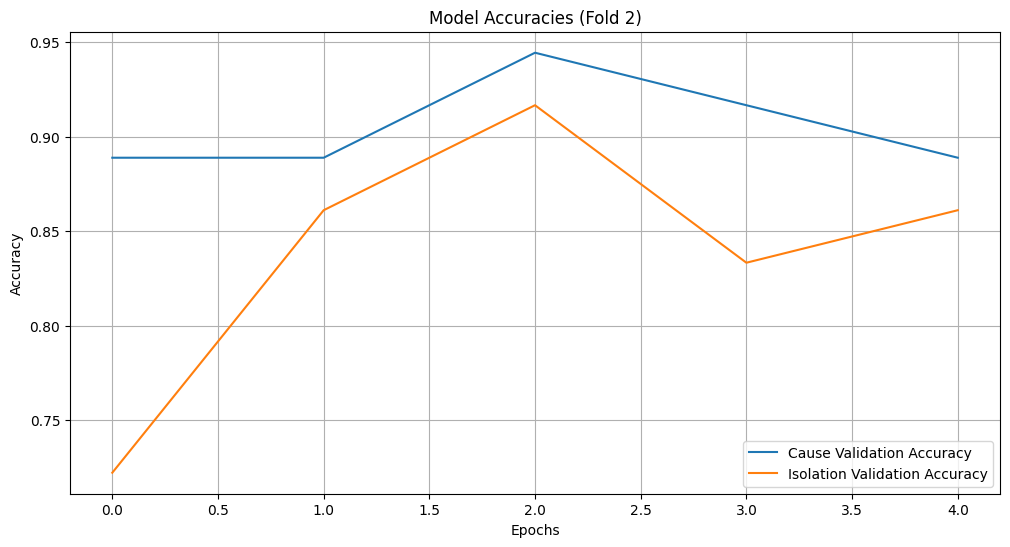

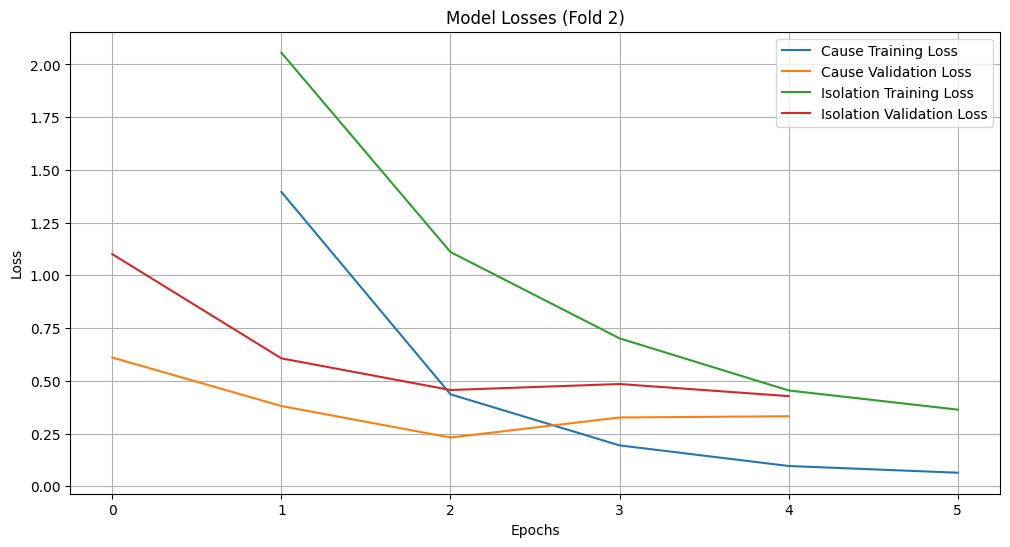


Evaluating models (Fold 2):


100%|██████████| 5/5 [00:00<00:00, 16.12it/s]



Fold 2 Times:
Training time: 0:02:07
Evaluation time: 0:00:00
Total time: 0:02:07

Fold 2 Results:
Cause - Accuracy: 0.9444, Precision: 0.9361, F1: 0.9362
Isolation - Accuracy: 0.8611, Precision: 0.9444, F1: 0.8920


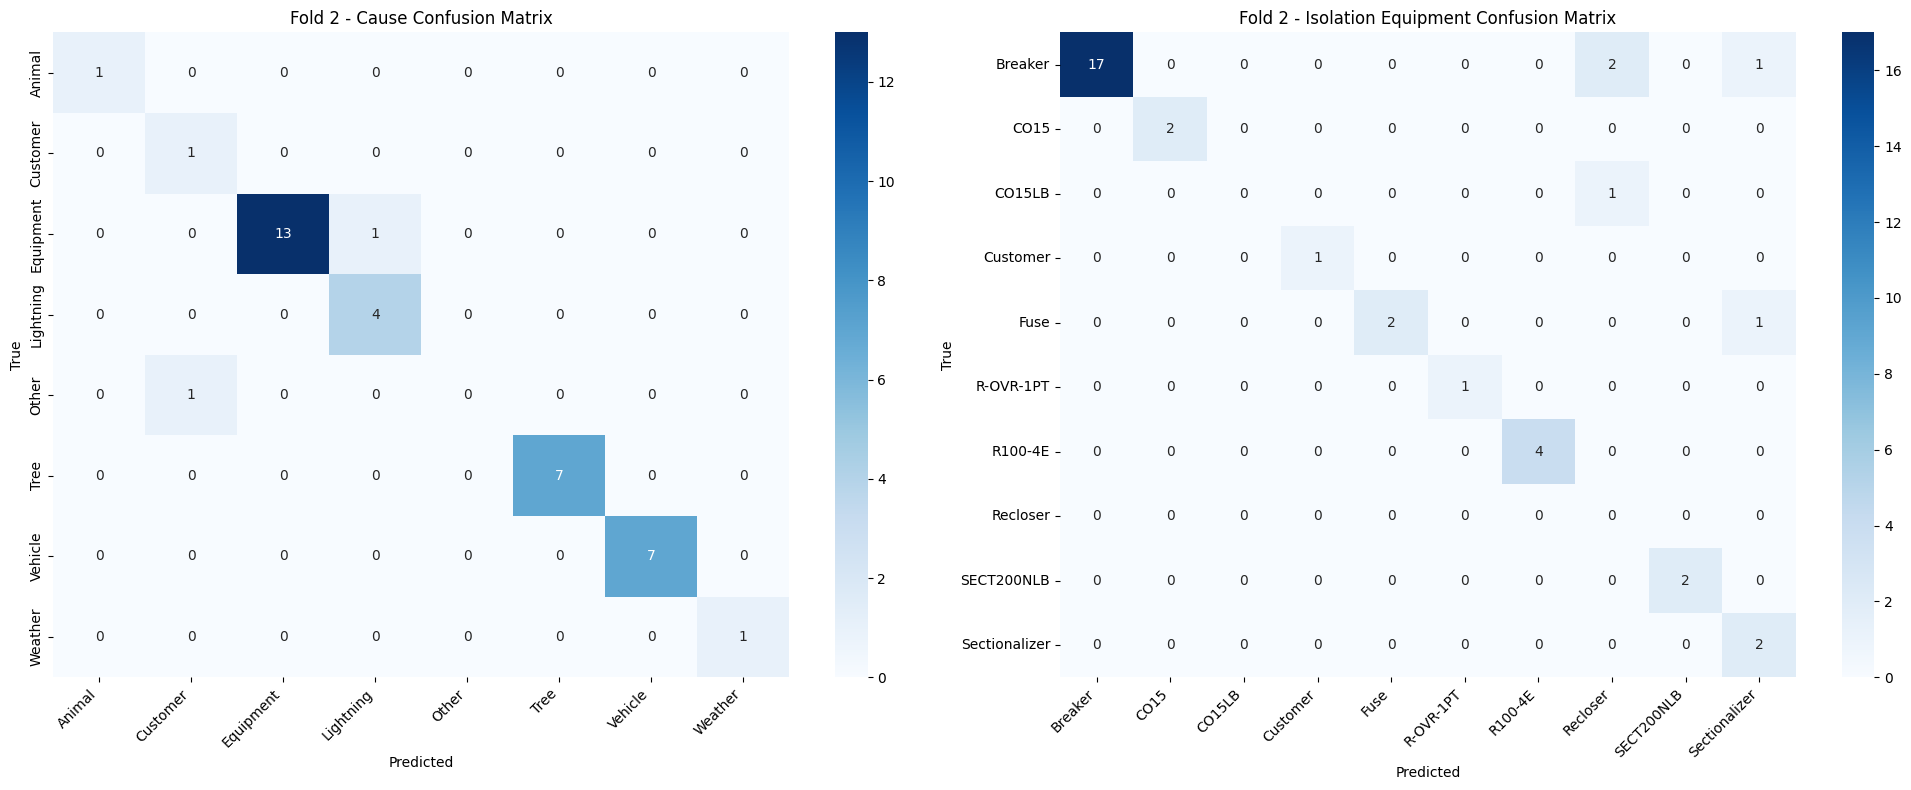


Classification Report - Cause (Fold 2):
              precision    recall  f1-score   support

      Animal       1.00      1.00      1.00         1
    Customer       0.50      1.00      0.67         1
   Equipment       1.00      0.93      0.96        14
   Lightning       0.80      1.00      0.89         4
       Other       0.00      0.00      0.00         1
        Tree       1.00      1.00      1.00         7
     Vehicle       1.00      1.00      1.00         7
     Weather       1.00      1.00      1.00         1

    accuracy                           0.94        36
   macro avg       0.79      0.87      0.81        36
weighted avg       0.94      0.94      0.94        36

Accuracy - Cause (Fold 2): 0.9444

Classification Report - Isolation Equipment (Fold 2):
               precision    recall  f1-score   support

      Breaker       1.00      0.85      0.92        20
         CO15       1.00      1.00      1.00         2
       CO15LB       0.00      0.00      0.00         

Map: 100%|██████████| 36/36 [00:00<00:00, 2712.96 examples/s]
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at ./distilbert-pq-mlm and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at ./distilbert-pq-mlm and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\rmathew2020\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will

Training Cause Model (Fold 3):


 20%|██        | 18/90 [00:12<00:45,  1.58it/s]

{'loss': 1.4415, 'grad_norm': 4.317965030670166, 'learning_rate': 0.00016, 'epoch': 1.0}



 20%|██        | 18/90 [00:12<00:45,  1.58it/s]

{'eval_loss': 0.7120760679244995, 'eval_accuracy': 0.8055555555555556, 'eval_precision': 0.7222222222222222, 'eval_f1': 0.7522222222222222, 'eval_runtime': 0.4497, 'eval_samples_per_second': 80.049, 'eval_steps_per_second': 11.118, 'epoch': 1.0}


 40%|████      | 36/90 [00:25<00:34,  1.54it/s]

{'loss': 0.4467, 'grad_norm': 1.808480978012085, 'learning_rate': 0.00012, 'epoch': 2.0}



 40%|████      | 36/90 [00:25<00:34,  1.54it/s]

{'eval_loss': 0.40462836623191833, 'eval_accuracy': 0.8888888888888888, 'eval_precision': 0.8703703703703705, 'eval_f1': 0.8698148148148148, 'eval_runtime': 0.4992, 'eval_samples_per_second': 72.109, 'eval_steps_per_second': 10.015, 'epoch': 2.0}


 60%|██████    | 54/90 [00:38<00:23,  1.53it/s]

{'loss': 0.2215, 'grad_norm': 0.1621699035167694, 'learning_rate': 8e-05, 'epoch': 3.0}



 60%|██████    | 54/90 [00:39<00:23,  1.53it/s]

{'eval_loss': 0.17604464292526245, 'eval_accuracy': 0.9166666666666666, 'eval_precision': 0.863095238095238, 'eval_f1': 0.8847736625514403, 'eval_runtime': 0.5102, 'eval_samples_per_second': 70.559, 'eval_steps_per_second': 9.8, 'epoch': 3.0}


 80%|████████  | 72/90 [00:52<00:11,  1.61it/s]

{'loss': 0.1338, 'grad_norm': 0.11161640286445618, 'learning_rate': 4e-05, 'epoch': 4.0}



 80%|████████  | 72/90 [00:52<00:11,  1.61it/s]

{'eval_loss': 0.1382564753293991, 'eval_accuracy': 0.9722222222222222, 'eval_precision': 0.9465811965811967, 'eval_f1': 0.9588888888888888, 'eval_runtime': 0.4437, 'eval_samples_per_second': 81.135, 'eval_steps_per_second': 11.269, 'epoch': 4.0}


100%|██████████| 90/90 [01:05<00:00,  1.62it/s]

{'loss': 0.0712, 'grad_norm': 0.16584858298301697, 'learning_rate': 0.0, 'epoch': 5.0}



100%|██████████| 90/90 [01:06<00:00,  1.62it/s]

{'eval_loss': 0.10660585761070251, 'eval_accuracy': 0.9722222222222222, 'eval_precision': 0.9465811965811967, 'eval_f1': 0.9588888888888888, 'eval_runtime': 0.5025, 'eval_samples_per_second': 71.649, 'eval_steps_per_second': 9.951, 'epoch': 5.0}


100%|██████████| 90/90 [01:07<00:00,  1.34it/s]


{'train_runtime': 67.3467, 'train_samples_per_second': 10.542, 'train_steps_per_second': 1.336, 'train_loss': 0.4629386067390442, 'epoch': 5.0}

Training Isolation Model (Fold 3):


 20%|██        | 18/90 [00:11<00:43,  1.66it/s]

{'loss': 2.1164, 'grad_norm': 19.75952911376953, 'learning_rate': 0.00016, 'epoch': 1.0}



 20%|██        | 18/90 [00:11<00:43,  1.66it/s]

{'eval_loss': 1.7921221256256104, 'eval_accuracy': 0.4166666666666667, 'eval_precision': 0.46056547619047616, 'eval_f1': 0.42678571428571427, 'eval_runtime': 0.4412, 'eval_samples_per_second': 81.596, 'eval_steps_per_second': 11.333, 'epoch': 1.0}


 40%|████      | 36/90 [00:24<00:32,  1.65it/s]

{'loss': 1.5888, 'grad_norm': 13.897103309631348, 'learning_rate': 0.00012, 'epoch': 2.0}



 40%|████      | 36/90 [00:24<00:32,  1.65it/s]

{'eval_loss': 1.2385362386703491, 'eval_accuracy': 0.5555555555555556, 'eval_precision': 0.37103174603174605, 'eval_f1': 0.43897754137115835, 'eval_runtime': 0.445, 'eval_samples_per_second': 80.894, 'eval_steps_per_second': 11.235, 'epoch': 2.0}


 60%|██████    | 54/90 [00:36<00:21,  1.65it/s]

{'loss': 1.1699, 'grad_norm': 5.639032363891602, 'learning_rate': 8e-05, 'epoch': 3.0}



 60%|██████    | 54/90 [00:37<00:21,  1.65it/s]

{'eval_loss': 0.8878687620162964, 'eval_accuracy': 0.6666666666666666, 'eval_precision': 0.644524959742351, 'eval_f1': 0.6051587301587301, 'eval_runtime': 0.438, 'eval_samples_per_second': 82.183, 'eval_steps_per_second': 11.414, 'epoch': 3.0}


 80%|████████  | 72/90 [00:49<00:10,  1.65it/s]

{'loss': 0.8739, 'grad_norm': 4.832261085510254, 'learning_rate': 4e-05, 'epoch': 4.0}



 80%|████████  | 72/90 [00:50<00:10,  1.65it/s]

{'eval_loss': 0.7807299494743347, 'eval_accuracy': 0.7777777777777778, 'eval_precision': 0.6861916264090177, 'eval_f1': 0.719047619047619, 'eval_runtime': 0.452, 'eval_samples_per_second': 79.651, 'eval_steps_per_second': 11.063, 'epoch': 4.0}


100%|██████████| 90/90 [01:03<00:00,  1.66it/s]

{'loss': 0.7062, 'grad_norm': 4.378706932067871, 'learning_rate': 0.0, 'epoch': 5.0}



100%|██████████| 90/90 [01:03<00:00,  1.66it/s]

{'eval_loss': 0.6473193764686584, 'eval_accuracy': 0.7777777777777778, 'eval_precision': 0.7662698412698412, 'eval_f1': 0.7363756613756614, 'eval_runtime': 0.4302, 'eval_samples_per_second': 83.675, 'eval_steps_per_second': 11.622, 'epoch': 5.0}


100%|██████████| 90/90 [01:04<00:00,  1.39it/s]

{'train_runtime': 64.8462, 'train_samples_per_second': 10.949, 'train_steps_per_second': 1.388, 'train_loss': 1.2910329288906521, 'epoch': 5.0}


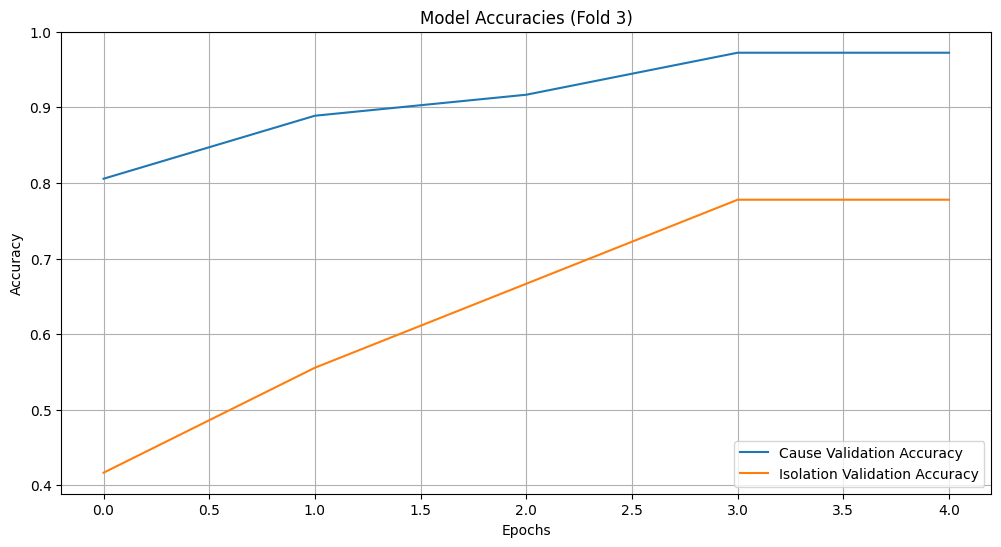

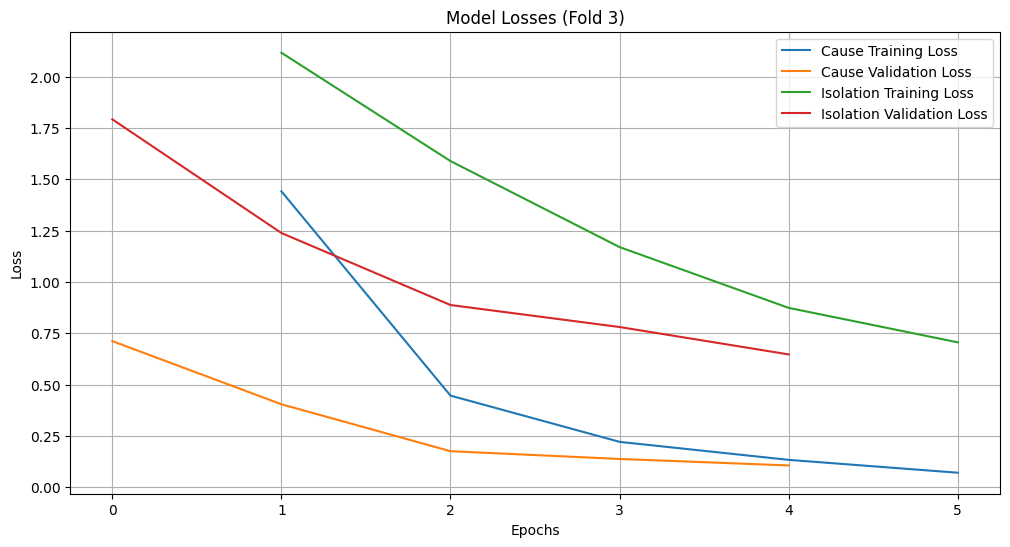


Evaluating models (Fold 3):


100%|██████████| 5/5 [00:00<00:00, 16.18it/s]



Fold 3 Times:
Training time: 0:02:13
Evaluation time: 0:00:00
Total time: 0:02:13

Fold 3 Results:
Cause - Accuracy: 0.9722, Precision: 0.9466, F1: 0.9589
Isolation - Accuracy: 0.7778, Precision: 0.7663, F1: 0.7364


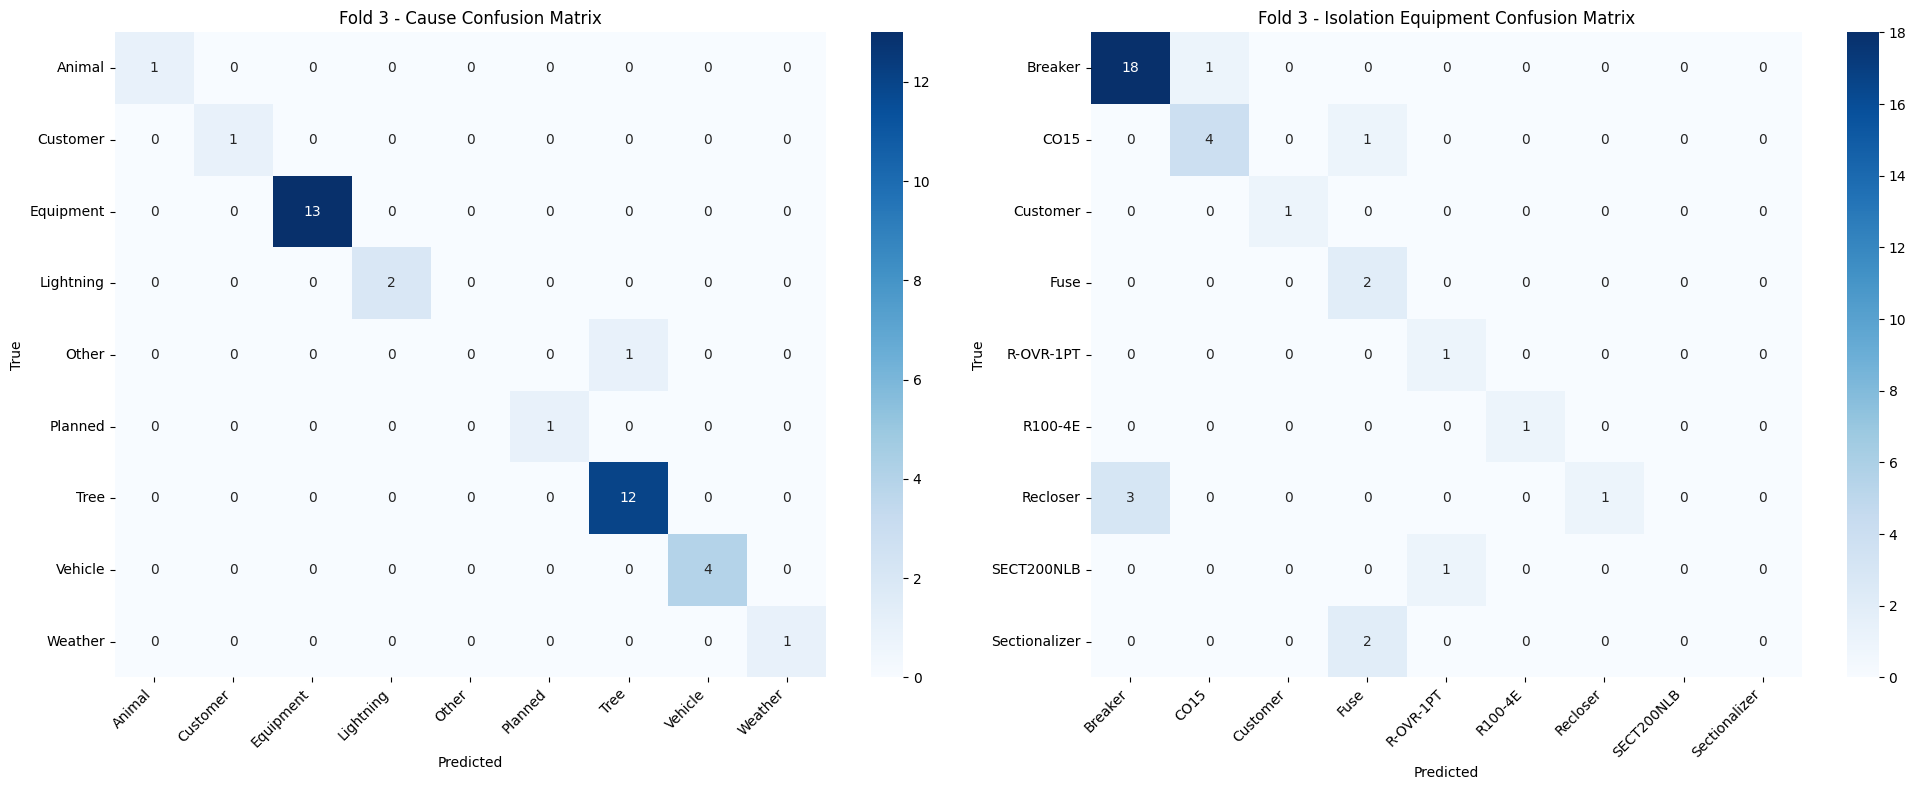


Classification Report - Cause (Fold 3):
              precision    recall  f1-score   support

      Animal       1.00      1.00      1.00         1
    Customer       1.00      1.00      1.00         1
   Equipment       1.00      1.00      1.00        13
   Lightning       1.00      1.00      1.00         2
       Other       0.00      0.00      0.00         1
     Planned       1.00      1.00      1.00         1
        Tree       0.92      1.00      0.96        12
     Vehicle       1.00      1.00      1.00         4
     Weather       1.00      1.00      1.00         1

    accuracy                           0.97        36
   macro avg       0.88      0.89      0.88        36
weighted avg       0.95      0.97      0.96        36

Accuracy - Cause (Fold 3): 0.9722

Classification Report - Isolation Equipment (Fold 3):
               precision    recall  f1-score   support

      Breaker       0.86      0.95      0.90        19
         CO15       0.80      0.80      0.80         5

Map: 100%|██████████| 35/35 [00:00<00:00, 47848.97 examples/s]
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at ./distilbert-pq-mlm and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at ./distilbert-pq-mlm and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\rmathew2020\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and wil

Training Cause Model (Fold 4):


 20%|██        | 18/90 [00:11<00:43,  1.65it/s]

{'loss': 1.5087, 'grad_norm': 7.168667316436768, 'learning_rate': 0.00016, 'epoch': 1.0}



 20%|██        | 18/90 [00:11<00:43,  1.65it/s]

{'eval_loss': 0.9389908909797668, 'eval_accuracy': 0.7428571428571429, 'eval_precision': 0.5605616605616606, 'eval_f1': 0.6361960620025137, 'eval_runtime': 0.4268, 'eval_samples_per_second': 82.014, 'eval_steps_per_second': 11.716, 'epoch': 1.0}


 40%|████      | 36/90 [00:23<00:32,  1.64it/s]

{'loss': 0.5244, 'grad_norm': 1.0165541172027588, 'learning_rate': 0.00012, 'epoch': 2.0}



 40%|████      | 36/90 [00:24<00:32,  1.64it/s]

{'eval_loss': 0.423274964094162, 'eval_accuracy': 0.9428571428571428, 'eval_precision': 0.8933333333333333, 'eval_f1': 0.9163265306122449, 'eval_runtime': 0.4012, 'eval_samples_per_second': 87.238, 'eval_steps_per_second': 12.463, 'epoch': 2.0}


 60%|██████    | 54/90 [00:36<00:20,  1.71it/s]

{'loss': 0.1896, 'grad_norm': 0.7763751149177551, 'learning_rate': 8e-05, 'epoch': 3.0}



 60%|██████    | 54/90 [00:36<00:20,  1.71it/s]

{'eval_loss': 0.4425361454486847, 'eval_accuracy': 0.9428571428571428, 'eval_precision': 0.8933333333333333, 'eval_f1': 0.9163265306122449, 'eval_runtime': 0.3838, 'eval_samples_per_second': 91.194, 'eval_steps_per_second': 13.028, 'epoch': 3.0}


 80%|████████  | 72/90 [00:48<00:10,  1.67it/s]

{'loss': 0.1235, 'grad_norm': 0.16061043739318848, 'learning_rate': 4e-05, 'epoch': 4.0}



 80%|████████  | 72/90 [00:49<00:10,  1.67it/s]

{'eval_loss': 0.42846447229385376, 'eval_accuracy': 0.9428571428571428, 'eval_precision': 0.8933333333333333, 'eval_f1': 0.9163265306122449, 'eval_runtime': 0.3925, 'eval_samples_per_second': 89.182, 'eval_steps_per_second': 12.74, 'epoch': 4.0}


100%|██████████| 90/90 [01:01<00:00,  1.69it/s]

{'loss': 0.0794, 'grad_norm': 0.18659234046936035, 'learning_rate': 0.0, 'epoch': 5.0}



100%|██████████| 90/90 [01:02<00:00,  1.69it/s]

{'eval_loss': 0.38721463084220886, 'eval_accuracy': 0.9142857142857143, 'eval_precision': 0.866938775510204, 'eval_f1': 0.8884004884004885, 'eval_runtime': 0.5016, 'eval_samples_per_second': 69.779, 'eval_steps_per_second': 9.968, 'epoch': 5.0}


100%|██████████| 90/90 [01:03<00:00,  1.42it/s]


{'train_runtime': 63.444, 'train_samples_per_second': 11.27, 'train_steps_per_second': 1.419, 'train_loss': 0.4851110961702135, 'epoch': 5.0}

Training Isolation Model (Fold 4):


 20%|██        | 18/90 [00:11<00:45,  1.59it/s]

{'loss': 1.9796, 'grad_norm': 3.863400936126709, 'learning_rate': 0.00016, 'epoch': 1.0}



 20%|██        | 18/90 [00:11<00:45,  1.59it/s]

{'eval_loss': 1.6676498651504517, 'eval_accuracy': 0.4857142857142857, 'eval_precision': 0.29238095238095235, 'eval_f1': 0.3575091575091575, 'eval_runtime': 0.4021, 'eval_samples_per_second': 87.034, 'eval_steps_per_second': 12.433, 'epoch': 1.0}


 40%|████      | 36/90 [00:24<00:34,  1.59it/s]

{'loss': 1.1776, 'grad_norm': 7.532440662384033, 'learning_rate': 0.00012, 'epoch': 2.0}



 40%|████      | 36/90 [00:24<00:34,  1.59it/s]

{'eval_loss': 1.3725996017456055, 'eval_accuracy': 0.6571428571428571, 'eval_precision': 0.6228571428571429, 'eval_f1': 0.5842659644502962, 'eval_runtime': 0.4284, 'eval_samples_per_second': 81.699, 'eval_steps_per_second': 11.671, 'epoch': 2.0}


 60%|██████    | 54/90 [00:37<00:22,  1.62it/s]

{'loss': 0.8261, 'grad_norm': 3.7527573108673096, 'learning_rate': 8e-05, 'epoch': 3.0}



 60%|██████    | 54/90 [00:37<00:22,  1.62it/s]

{'eval_loss': 0.7686734795570374, 'eval_accuracy': 0.8285714285714286, 'eval_precision': 0.819403453689168, 'eval_f1': 0.7857142857142857, 'eval_runtime': 0.425, 'eval_samples_per_second': 82.354, 'eval_steps_per_second': 11.765, 'epoch': 3.0}


 80%|████████  | 72/90 [00:49<00:10,  1.65it/s]

{'loss': 0.6052, 'grad_norm': 3.4991519451141357, 'learning_rate': 4e-05, 'epoch': 4.0}



 80%|████████  | 72/90 [00:50<00:10,  1.65it/s]

{'eval_loss': 0.8387983441352844, 'eval_accuracy': 0.8285714285714286, 'eval_precision': 0.819795918367347, 'eval_f1': 0.7964126984126983, 'eval_runtime': 0.4387, 'eval_samples_per_second': 79.775, 'eval_steps_per_second': 11.396, 'epoch': 4.0}


100%|██████████| 90/90 [01:03<00:00,  1.62it/s]

{'loss': 0.4859, 'grad_norm': 2.3837413787841797, 'learning_rate': 0.0, 'epoch': 5.0}



100%|██████████| 90/90 [01:03<00:00,  1.62it/s]

{'eval_loss': 0.7033820748329163, 'eval_accuracy': 0.8285714285714286, 'eval_precision': 0.803076923076923, 'eval_f1': 0.7952380952380952, 'eval_runtime': 0.4638, 'eval_samples_per_second': 75.466, 'eval_steps_per_second': 10.781, 'epoch': 5.0}


100%|██████████| 90/90 [01:04<00:00,  1.39it/s]

{'train_runtime': 64.8602, 'train_samples_per_second': 11.024, 'train_steps_per_second': 1.388, 'train_loss': 1.0148984485202366, 'epoch': 5.0}


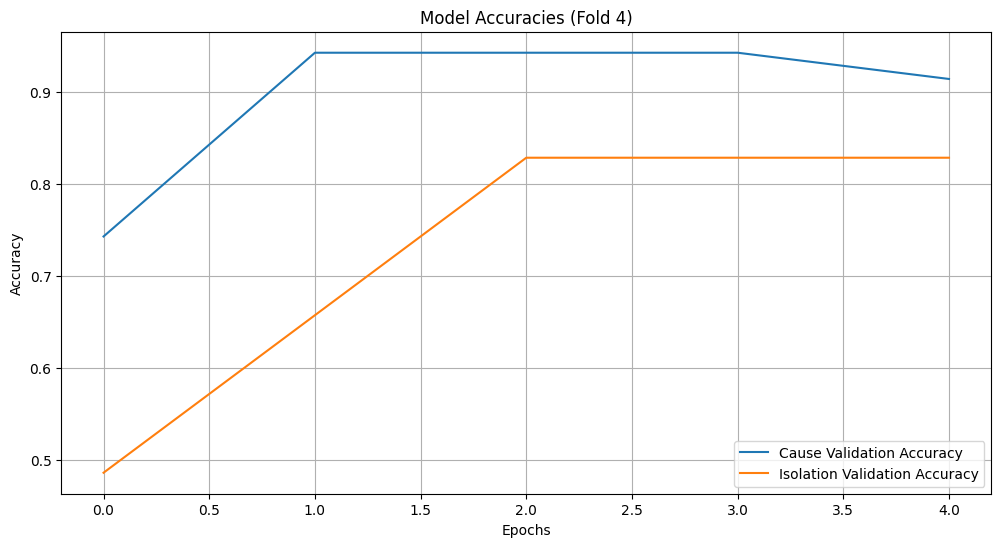

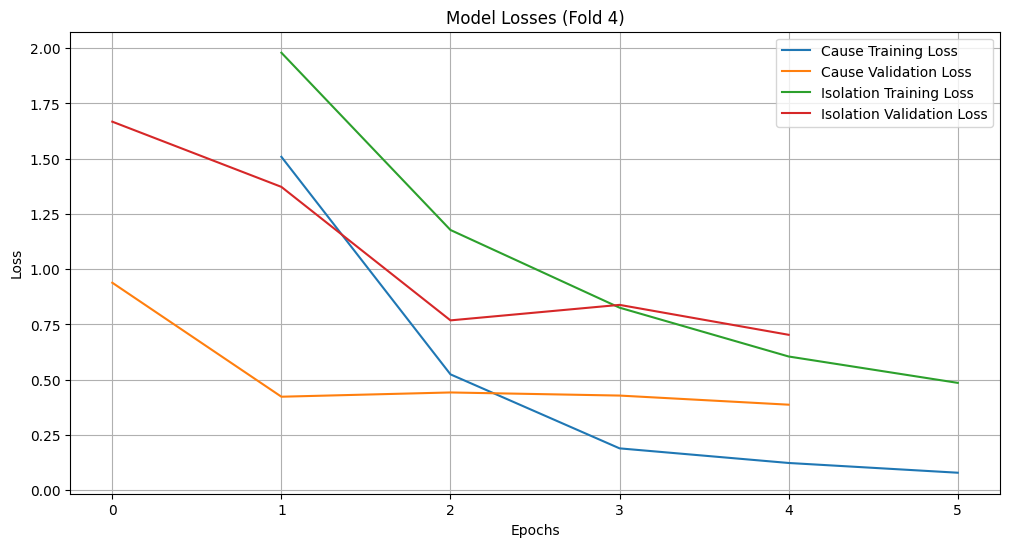


Evaluating models (Fold 4):


100%|██████████| 5/5 [00:00<00:00, 16.68it/s]



Fold 4 Times:
Training time: 0:02:09
Evaluation time: 0:00:00
Total time: 0:02:09

Fold 4 Results:
Cause - Accuracy: 0.9143, Precision: 0.8669, F1: 0.8884
Isolation - Accuracy: 0.8286, Precision: 0.8031, F1: 0.7952


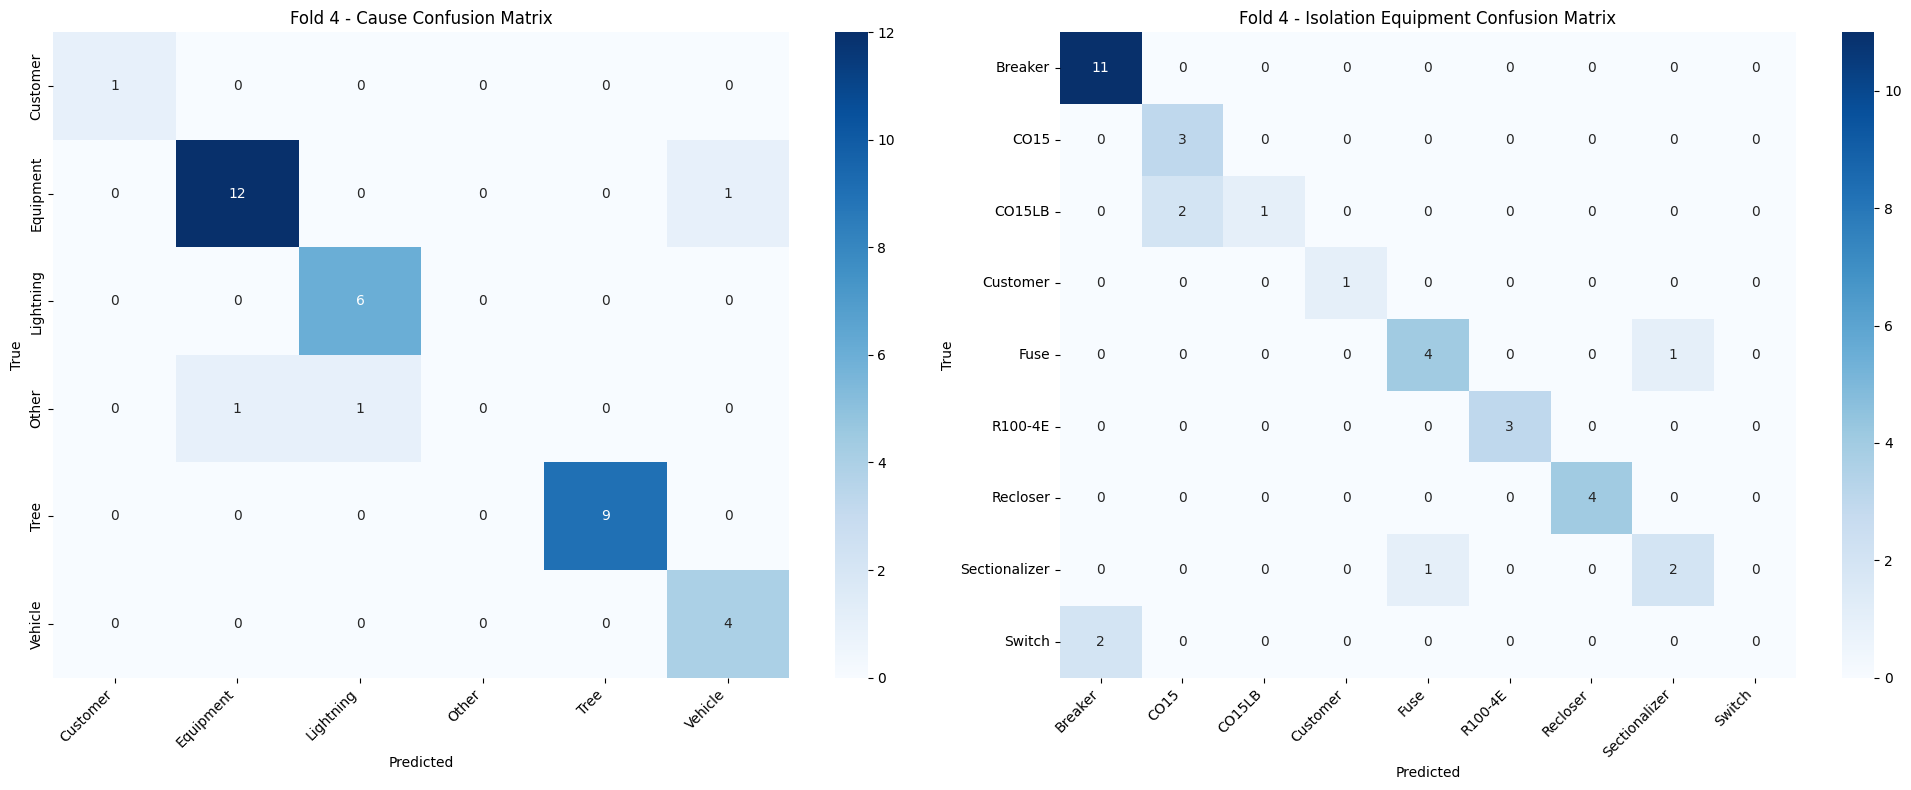


Classification Report - Cause (Fold 4):
              precision    recall  f1-score   support

    Customer       1.00      1.00      1.00         1
   Equipment       0.92      0.92      0.92        13
   Lightning       0.86      1.00      0.92         6
       Other       0.00      0.00      0.00         2
        Tree       1.00      1.00      1.00         9
     Vehicle       0.80      1.00      0.89         4

    accuracy                           0.91        35
   macro avg       0.76      0.82      0.79        35
weighted avg       0.87      0.91      0.89        35

Accuracy - Cause (Fold 4): 0.9143

Classification Report - Isolation Equipment (Fold 4):
               precision    recall  f1-score   support

      Breaker       0.85      1.00      0.92        11
         CO15       0.60      1.00      0.75         3
       CO15LB       1.00      0.33      0.50         3
     Customer       1.00      1.00      1.00         1
         Fuse       0.80      0.80      0.80       

Map: 100%|██████████| 35/35 [00:00<00:00, 6206.95 examples/s]
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at ./distilbert-pq-mlm and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at ./distilbert-pq-mlm and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\rmathew2020\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will

Training Cause Model (Fold 5):


 20%|██        | 18/90 [00:10<00:39,  1.80it/s]

{'loss': 1.345, 'grad_norm': 3.8054614067077637, 'learning_rate': 0.00016, 'epoch': 1.0}



 20%|██        | 18/90 [00:11<00:39,  1.80it/s]

{'eval_loss': 0.7984712719917297, 'eval_accuracy': 0.8285714285714286, 'eval_precision': 0.7182539682539683, 'eval_f1': 0.7663265306122449, 'eval_runtime': 0.4872, 'eval_samples_per_second': 71.838, 'eval_steps_per_second': 10.263, 'epoch': 1.0}


 40%|████      | 36/90 [00:22<00:29,  1.84it/s]

{'loss': 0.3894, 'grad_norm': 1.06771981716156, 'learning_rate': 0.00012, 'epoch': 2.0}



 40%|████      | 36/90 [00:22<00:29,  1.84it/s]

{'eval_loss': 0.5768371820449829, 'eval_accuracy': 0.8857142857142857, 'eval_precision': 0.8192076830732292, 'eval_f1': 0.8433416046319272, 'eval_runtime': 0.4864, 'eval_samples_per_second': 71.958, 'eval_steps_per_second': 10.28, 'epoch': 2.0}


 60%|██████    | 54/90 [00:34<00:20,  1.78it/s]

{'loss': 0.1672, 'grad_norm': 0.23770974576473236, 'learning_rate': 8e-05, 'epoch': 3.0}



 60%|██████    | 54/90 [00:34<00:20,  1.78it/s]

{'eval_loss': 0.35995087027549744, 'eval_accuracy': 0.9428571428571428, 'eval_precision': 0.948843537414966, 'eval_f1': 0.9349248452696729, 'eval_runtime': 0.4528, 'eval_samples_per_second': 77.305, 'eval_steps_per_second': 11.044, 'epoch': 3.0}


 80%|████████  | 72/90 [00:45<00:09,  1.81it/s]

{'loss': 0.0703, 'grad_norm': 3.092871904373169, 'learning_rate': 4e-05, 'epoch': 4.0}



 80%|████████  | 72/90 [00:46<00:09,  1.81it/s]

{'eval_loss': 0.42107829451560974, 'eval_accuracy': 0.9428571428571428, 'eval_precision': 0.95, 'eval_f1': 0.9352380952380953, 'eval_runtime': 0.4763, 'eval_samples_per_second': 73.49, 'eval_steps_per_second': 10.499, 'epoch': 4.0}


100%|██████████| 90/90 [00:58<00:00,  1.81it/s]

{'loss': 0.0421, 'grad_norm': 0.25950372219085693, 'learning_rate': 0.0, 'epoch': 5.0}



100%|██████████| 90/90 [00:58<00:00,  1.81it/s]

{'eval_loss': 0.42286917567253113, 'eval_accuracy': 0.9428571428571428, 'eval_precision': 0.95, 'eval_f1': 0.9352380952380953, 'eval_runtime': 0.5183, 'eval_samples_per_second': 67.527, 'eval_steps_per_second': 9.647, 'epoch': 5.0}


100%|██████████| 90/90 [00:59<00:00,  1.50it/s]


{'train_runtime': 59.8632, 'train_samples_per_second': 11.944, 'train_steps_per_second': 1.503, 'train_loss': 0.4028142213821411, 'epoch': 5.0}

Training Isolation Model (Fold 5):


 20%|██        | 18/90 [00:10<00:40,  1.79it/s]

{'loss': 2.0326, 'grad_norm': 4.531139850616455, 'learning_rate': 0.00016, 'epoch': 1.0}



 20%|██        | 18/90 [00:11<00:40,  1.79it/s]

{'eval_loss': 1.647247552871704, 'eval_accuracy': 0.6, 'eval_precision': 0.4714285714285714, 'eval_f1': 0.5212121212121212, 'eval_runtime': 0.4661, 'eval_samples_per_second': 75.097, 'eval_steps_per_second': 10.728, 'epoch': 1.0}


 40%|████      | 36/90 [00:22<00:29,  1.85it/s]

{'loss': 1.0328, 'grad_norm': 4.2269792556762695, 'learning_rate': 0.00012, 'epoch': 2.0}



 40%|████      | 36/90 [00:23<00:29,  1.85it/s]

{'eval_loss': 1.6807864904403687, 'eval_accuracy': 0.5142857142857142, 'eval_precision': 0.4671428571428572, 'eval_f1': 0.4798491830749896, 'eval_runtime': 0.4865, 'eval_samples_per_second': 71.945, 'eval_steps_per_second': 10.278, 'epoch': 2.0}


 60%|██████    | 54/90 [00:34<00:21,  1.68it/s]

{'loss': 0.5732, 'grad_norm': 4.0261054039001465, 'learning_rate': 8e-05, 'epoch': 3.0}



 60%|██████    | 54/90 [00:35<00:21,  1.68it/s]

{'eval_loss': 1.649655818939209, 'eval_accuracy': 0.5428571428571428, 'eval_precision': 0.6103174603174603, 'eval_f1': 0.5279877112135177, 'eval_runtime': 0.5449, 'eval_samples_per_second': 64.231, 'eval_steps_per_second': 9.176, 'epoch': 3.0}


 80%|████████  | 72/90 [00:47<00:11,  1.62it/s]

{'loss': 0.3694, 'grad_norm': 7.108985900878906, 'learning_rate': 4e-05, 'epoch': 4.0}



 80%|████████  | 72/90 [00:48<00:11,  1.62it/s]

{'eval_loss': 1.564285397529602, 'eval_accuracy': 0.6285714285714286, 'eval_precision': 0.6755102040816326, 'eval_f1': 0.6342857142857142, 'eval_runtime': 0.5702, 'eval_samples_per_second': 61.382, 'eval_steps_per_second': 8.769, 'epoch': 4.0}


100%|██████████| 90/90 [01:01<00:00,  1.79it/s]

{'loss': 0.3032, 'grad_norm': 2.977654457092285, 'learning_rate': 0.0, 'epoch': 5.0}



100%|██████████| 90/90 [01:01<00:00,  1.79it/s]

{'eval_loss': 1.4865490198135376, 'eval_accuracy': 0.6857142857142857, 'eval_precision': 0.6187074829931973, 'eval_f1': 0.6422734254992319, 'eval_runtime': 0.5857, 'eval_samples_per_second': 59.76, 'eval_steps_per_second': 8.537, 'epoch': 5.0}


100%|██████████| 90/90 [01:02<00:00,  1.43it/s]

{'train_runtime': 62.9493, 'train_samples_per_second': 11.358, 'train_steps_per_second': 1.43, 'train_loss': 0.862257809109158, 'epoch': 5.0}


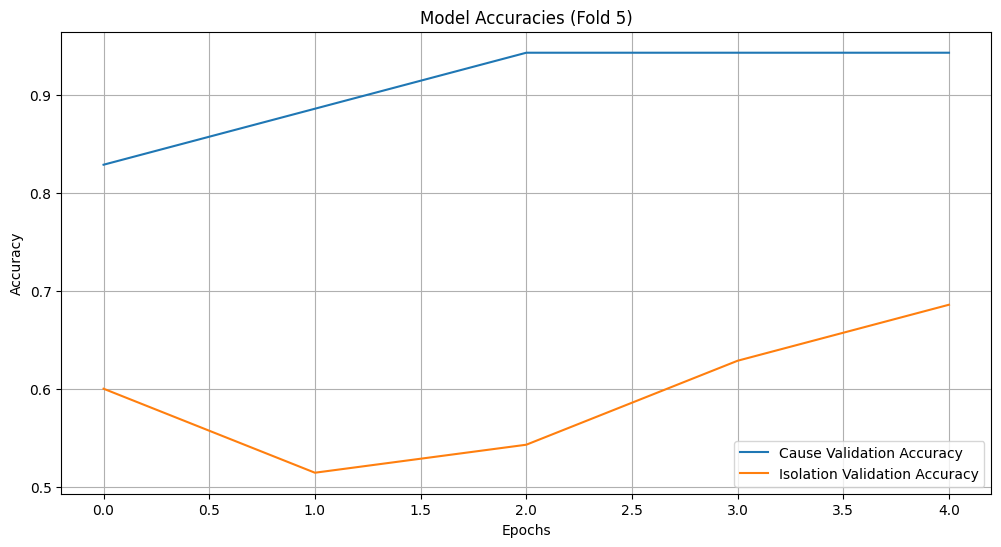

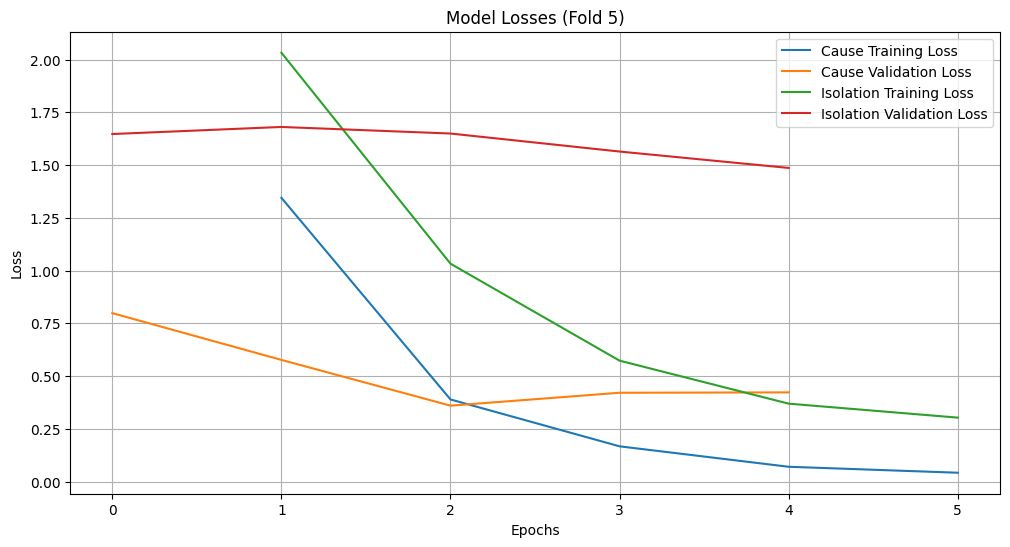


Evaluating models (Fold 5):


100%|██████████| 5/5 [00:00<00:00, 14.91it/s]



Fold 5 Times:
Training time: 0:02:03
Evaluation time: 0:00:00
Total time: 0:02:04

Fold 5 Results:
Cause - Accuracy: 0.9429, Precision: 0.9488, F1: 0.9349
Isolation - Accuracy: 0.6857, Precision: 0.6187, F1: 0.6423


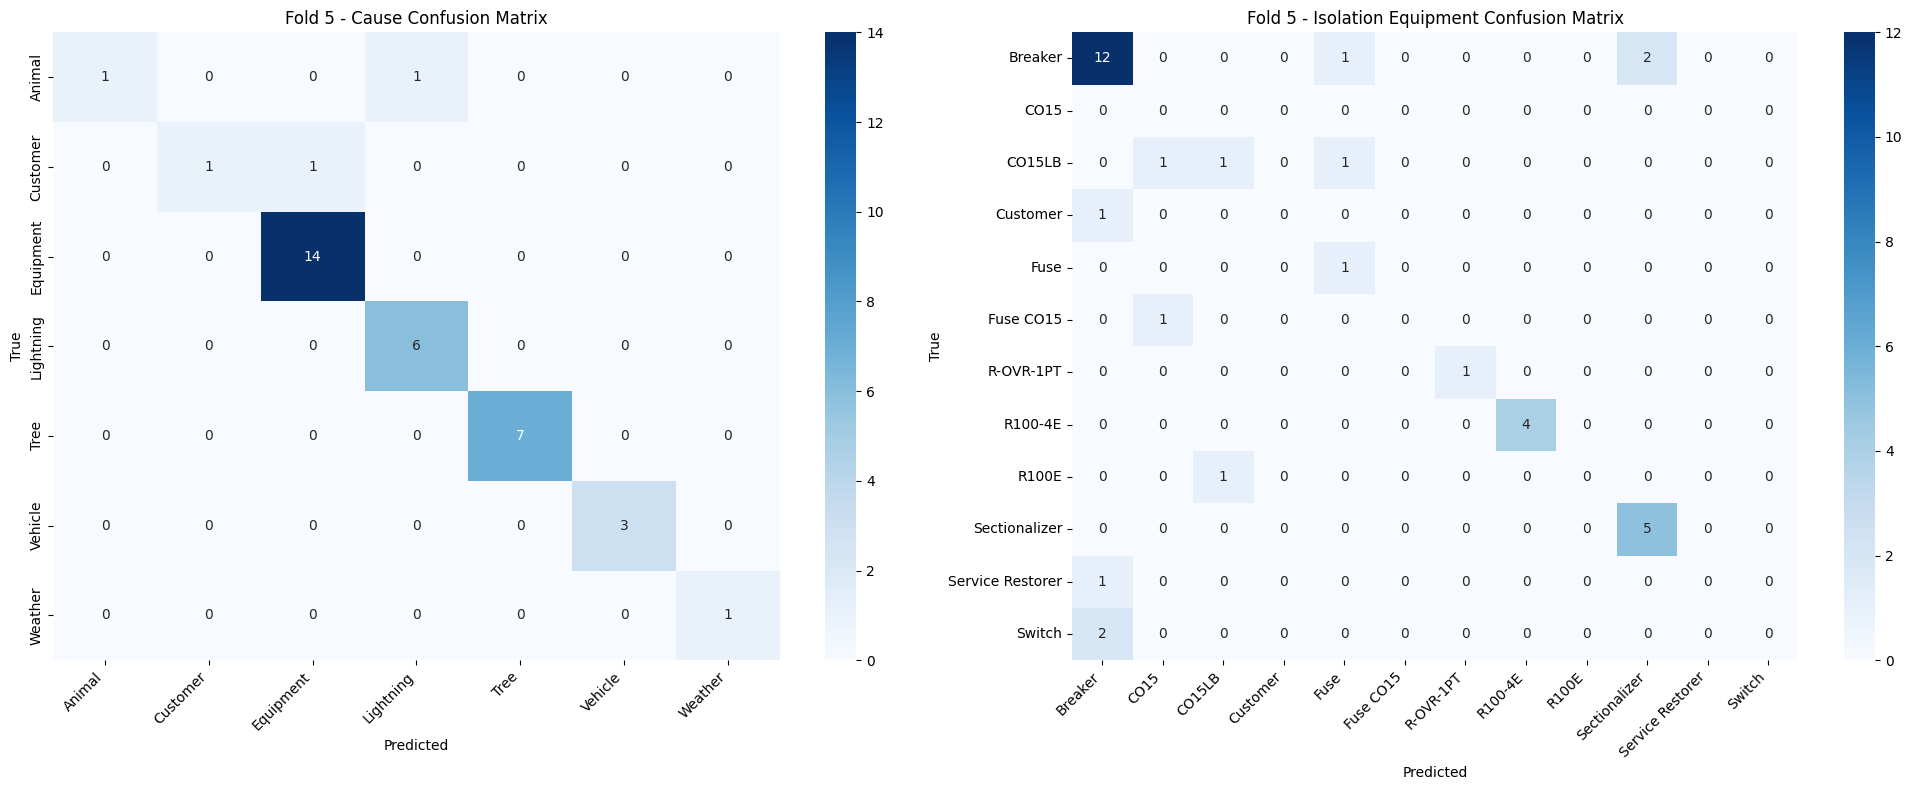


Classification Report - Cause (Fold 5):
              precision    recall  f1-score   support

      Animal       1.00      0.50      0.67         2
    Customer       1.00      0.50      0.67         2
   Equipment       0.93      1.00      0.97        14
   Lightning       0.86      1.00      0.92         6
        Tree       1.00      1.00      1.00         7
     Vehicle       1.00      1.00      1.00         3
     Weather       1.00      1.00      1.00         1

    accuracy                           0.94        35
   macro avg       0.97      0.86      0.89        35
weighted avg       0.95      0.94      0.93        35

Accuracy - Cause (Fold 5): 0.9429

Classification Report - Isolation Equipment (Fold 5):
                  precision    recall  f1-score   support

         Breaker       0.75      0.80      0.77        15
            CO15       0.00      0.00      0.00         0
          CO15LB       0.50      0.33      0.40         3
        Customer       0.00      0.00   

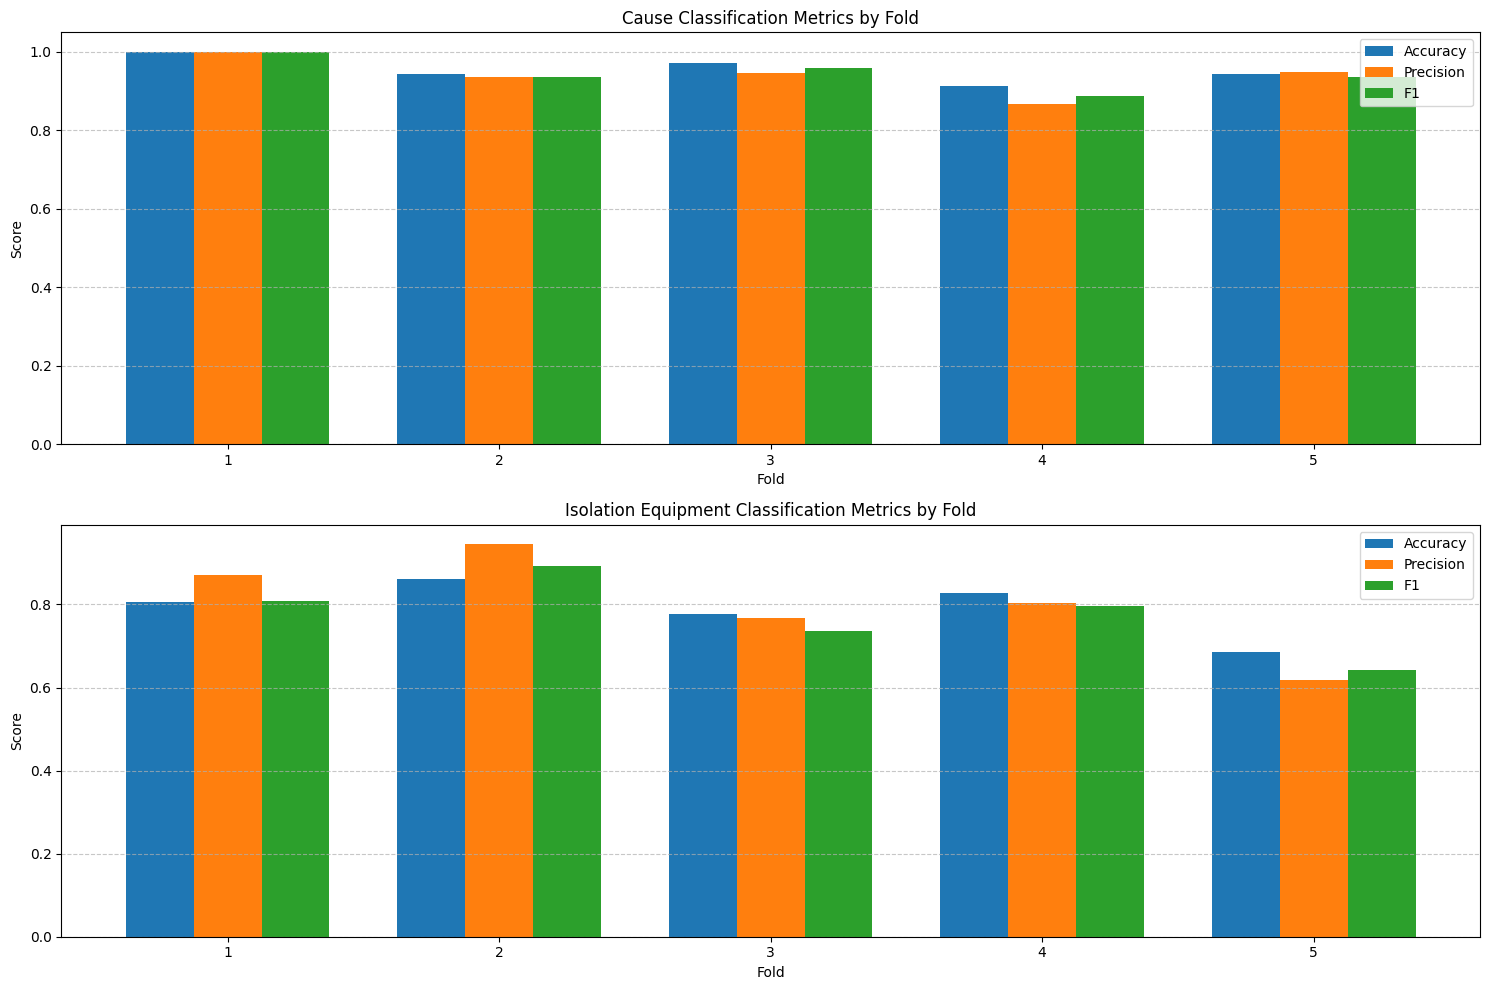


Example Text Classification:

Text: Circuit breaker tripped due to storm
Predicted cause: Lightning
Predicted isolation: Breaker

Text: Customer requested service disconnection
Predicted cause: Equipment
Predicted isolation: Fuse

Text: Transformer failure after lightning strike
Predicted cause: Equipment
Predicted isolation: CO15
Predicted cause: Tree
Predicted isolation: Breaker


In [ ]:
import numpy as np
import pandas as pd
import time
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, accuracy_score
from transformers import AutoModelForSequenceClassification, AutoTokenizer, TrainingArguments, Trainer, DataCollatorWithPadding
import torch
import evaluate
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from datasets import Dataset
import os
from datetime import timedelta

# Set parameters
data_path = "PQEvents_Ticket_csv.csv"
text_column_name = "Details"
label_column_name = "Cause"

model_name = "distilbert-base-uncased"
test_size = 0.2
num_labels = 2
n_splits = 5  # Number of folds for K-fold cross-validation
adaptation_path = "./distilbert-pq-mlm"


# Create directory for results
os.makedirs("./results", exist_ok=True)

# Load and preprocess data
df = pd.read_csv(data_path)

# First, clean up Cause column
df = df[~df['Cause'].isin(['Unknown', 'Undetermined'])]  # Remove rows with these values in Cause column 
df['Cause'] = df['Cause'].replace(['Customer Request', 'Customer Caused'], 'Customer')

# Replace Unknown/Undetermined in Isolation Equipment Code
df['Isolation Equipment Code'] = df['Isolation Equipment Code'].replace(['Unknown', 'Undetermined'], np.nan)

# Only drop rows where Cause is NaN
df = df.dropna(subset=['Cause'])

# If 'Cause' is 'Customer' and 'Isolation Equipment Code' is NaN, set 'Isolation Equipment Code' to 'Customer'
df.loc[(df['Cause'] == 'Customer') & (df['Isolation Equipment Code'].isna()), 'Isolation Equipment Code'] = 'Customer'

# Drop rows where 'Isolation Equipment Code' is NaN, but only for causes other than 'Customer'
df = df.dropna(subset=['Isolation Equipment Code'])

# Keep only rows where 'Details' is a string
df = df[df['Details'].apply(lambda x: isinstance(x, str))]

# Function to clean text data
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    return text

# Apply text cleaning
df['Details'] = df['Details'].apply(clean_text)

# Print distributions
print("\nUnique Cause Classes with Counts:")
print("-" * 40)
cause_unique = df['Cause'].value_counts()
for cause, count in cause_unique.items():
    print(f"{cause:<20} {count:>5}")

print("\nIsolation Equipment Codes for Customer causes:")
print(df[df['Cause'] == 'Customer']['Isolation Equipment Code'].value_counts(dropna=False))

print(f"\nDataset shape: {df.shape}")

# Create label encoders
le_cause = preprocessing.LabelEncoder()
le_isolation = preprocessing.LabelEncoder()

# Fit both encoders
le_cause.fit(df[label_column_name].tolist())
le_isolation.fit(df['Isolation Equipment Code'].tolist())

# Transform labels
df['cause_label'] = le_cause.transform(df[label_column_name].tolist())
df['isolation_label'] = le_isolation.transform(df['Isolation Equipment Code'].tolist())

# Print out the labels with their corresponding encoded values
label_mapping = dict(zip(le_cause.classes_, le_cause.transform(le_cause.classes_)))
print("Cause Label Mapping:")
for label, encoded_value in label_mapping.items():
    print(f"{label}: {encoded_value}")

print()

# Print out the labels with their corresponding encoded values
label_mapping = dict(zip(le_isolation.classes_, le_isolation.transform(le_isolation.classes_)))
print("Isolation Equipment Label Mapping:")
for label, encoded_value in label_mapping.items():
    print(f"{label}: {encoded_value}")

df['text_cleaned'] = df[text_column_name]

# Count the number of data points for each cause
cause_counts = df[label_column_name].value_counts()
code_counts = df['Isolation Equipment Code'].value_counts()

# Print the counts
print("\nCause counts:")
print(cause_counts)
print("\nIsolation Equipment Code counts:")
print(code_counts)

# Initialize KFold cross-validator
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Preprocessing functions
def preprocess_function_cause(examples):
    tokenized = tokenizer(examples["text"], truncation=True, padding=True)
    tokenized["labels"] = examples["cause_label"]
    return tokenized

def preprocess_function_isolation(examples):
    tokenized = tokenizer(examples["text"], truncation=True, padding=True)
    tokenized["labels"] = examples["isolation_label"]
    return tokenized

# Initialize data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Metrics
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    
    # Calculate multiple metrics
    accuracy = accuracy_score(labels, predictions)
    precision = precision_score(labels, predictions, average='weighted', zero_division=0)
    f1 = f1_score(labels, predictions, average='weighted', zero_division=0)
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'f1': f1
    }

# Function to plot training metrics
def plot_training_metrics(cause_trainer, isolation_trainer, fold=None):
    """Plot training and validation metrics from both trainers"""
    
    # Get training histories
    cause_history = cause_trainer.state.log_history
    isolation_history = isolation_trainer.state.log_history
    
    # Extract metrics
    cause_train_loss = []
    cause_eval_loss = []
    isolation_train_loss = []
    isolation_eval_loss = []
    cause_accuracy = []
    isolation_accuracy = []
    epochs = []
    
    # Process cause trainer history
    for entry in cause_history:
        if 'loss' in entry and 'epoch' in entry and 'eval_loss' not in entry:
            cause_train_loss.append(entry['loss'])
            epochs.append(entry['epoch'])
        if 'eval_loss' in entry:
            cause_eval_loss.append(entry['eval_loss'])
            cause_accuracy.append(entry['eval_accuracy'])
    
    # Process isolation trainer history
    for entry in isolation_history:
        if 'loss' in entry and 'epoch' in entry and 'eval_loss' not in entry:
            isolation_train_loss.append(entry['loss'])
        if 'eval_loss' in entry:
            isolation_eval_loss.append(entry['eval_loss'])
            isolation_accuracy.append(entry['eval_accuracy'])
    
    fold_title = f" (Fold {fold})" if fold is not None else ""
    
    # Plot accuracies
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(cause_accuracy)), cause_accuracy, label='Cause Validation Accuracy')
    plt.plot(range(len(isolation_accuracy)), isolation_accuracy, label='Isolation Validation Accuracy') 
    plt.title(f'Model Accuracies{fold_title}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()
    
    # Plot losses
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, cause_train_loss, label='Cause Training Loss')
    plt.plot(range(len(cause_eval_loss)), cause_eval_loss, label='Cause Validation Loss')
    plt.plot(epochs, isolation_train_loss, label='Isolation Training Loss')
    plt.plot(range(len(isolation_eval_loss)), isolation_eval_loss, label='Isolation Validation Loss')
    plt.title(f'Model Losses{fold_title}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()

# Function to create confusion matrices
def plot_confusion_matrices(true_labels, predicted_labels, label_encoder, title_prefix="", ax=None):
    """Plot confusion matrix for given true and predicted labels"""
    
    # Get unique labels present in data
    unique_labels = np.unique(np.concatenate([true_labels, predicted_labels]))
    class_names = label_encoder.classes_[unique_labels]
    
    # Create confusion matrix
    conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=unique_labels)
    
    # Plot
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))
    
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names,
                ax=ax)
    ax.set_title(f'{title_prefix} Confusion Matrix')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    
    return conf_matrix

# Function to classify text
def classify_text(text, cause_model, isolation_model, tokenizer):
    """Classify text using the trained cause and isolation models"""
    
    # Clean and preprocess input text
    cleaned_text = clean_text(text)
    
    # Tokenize the cleaned text
    inputs = tokenizer(cleaned_text, 
                      return_tensors="pt",
                      truncation=True, 
                      padding=True)
    
    # Get predictions from both models
    with torch.no_grad():
        cause_outputs = cause_model(**inputs)
        isolation_outputs = isolation_model(**inputs)
    
    # Get predicted classes
    cause_class = torch.argmax(cause_outputs.logits, dim=-1)
    isolation_class = torch.argmax(isolation_outputs.logits, dim=-1)
    
    # Map predictions to labels
    predicted_cause = le_cause.inverse_transform([cause_class.item()])[0]
    predicted_isolation = le_isolation.inverse_transform([isolation_class.item()])[0]
    
    return predicted_cause, predicted_isolation

# Lists to store results across folds
cause_accuracies = []
cause_precisions = []
cause_f1_scores = []
isolation_accuracies = []
isolation_precisions = []
isolation_f1_scores = []
fold_times = []

# Run K-fold cross-validation
for fold, (train_idx, test_idx) in enumerate(kf.split(df)):
    print(f"\n{'='*80}\nFold {fold+1}/{n_splits}\n{'='*80}")
    
    # Split data for this fold
    df_train = df.iloc[train_idx]
    df_test = df.iloc[test_idx]
    
    # Create datasets
    train_dataset = Dataset.from_dict({
        'text': df_train['text_cleaned'],
        'cause_label': df_train['cause_label'],
        'isolation_label': df_train['isolation_label']
    })

    test_dataset = Dataset.from_dict({
        'text': df_test['text_cleaned'], 
        'cause_label': df_test['cause_label'],
        'isolation_label': df_test['isolation_label']
    })
    
    # Tokenize datasets
    tokenized_train_cause = train_dataset.map(
        preprocess_function_cause,
        batched=True,
        remove_columns=train_dataset.column_names
    )

    tokenized_test_cause = test_dataset.map(
        preprocess_function_cause,
        batched=True,
        remove_columns=test_dataset.column_names
    )

    tokenized_train_isolation = train_dataset.map(
        preprocess_function_isolation,
        batched=True,
        remove_columns=train_dataset.column_names
    )

    tokenized_test_isolation = test_dataset.map(
        preprocess_function_isolation,
        batched=True,
        remove_columns=test_dataset.column_names
    )
    
    # Create models for this fold
    cause_model = AutoModelForSequenceClassification.from_pretrained(
        adaptation_path, 
        num_labels=len(le_cause.classes_)
    )

    isolation_model = AutoModelForSequenceClassification.from_pretrained(
        adaptation_path,
        num_labels=len(le_isolation.classes_)
    )
    
    # Training arguments
    training_args = TrainingArguments(
        output_dir=f"./resultsberta/fold_{fold+1}",
        learning_rate=2e-4,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        num_train_epochs=5,  # Reduced for demonstration
        weight_decay=0.01,
        evaluation_strategy="epoch",
        logging_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
    )
    
    # Create trainers
    cause_trainer = Trainer(
        model=cause_model,
        args=training_args,
        train_dataset=tokenized_train_cause,
        eval_dataset=tokenized_test_cause,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics
    )

    isolation_trainer = Trainer(
        model=isolation_model,
        args=training_args,
        train_dataset=tokenized_train_isolation,
        eval_dataset=tokenized_test_isolation,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics
    )
    
    # Start timing for training
    start_time = time.time()
    
    # Train the models
    print(f"Training Cause Model (Fold {fold+1}):")
    cause_trainer.train()
    
    print(f"\nTraining Isolation Model (Fold {fold+1}):")
    isolation_trainer.train()
    
    # End timing for training
    train_end_time = time.time()
    training_time = train_end_time - start_time
    
    # Plot training metrics for this fold
    plot_training_metrics(cause_trainer, isolation_trainer, fold+1)
    
    # Start timing for evaluation
    eval_start_time = time.time()
    
    # Evaluate on test set
    print(f"\nEvaluating models (Fold {fold+1}):")
    
    # Get predictions for both models on test set
    cause_predictions = cause_trainer.predict(tokenized_test_cause)
    isolation_predictions = isolation_trainer.predict(tokenized_test_isolation)
    
    # End timing for evaluation
    eval_end_time = time.time()
    eval_time = eval_end_time - eval_start_time
    
    # Total time for this fold
    fold_total_time = training_time + eval_time
    fold_times.append(fold_total_time)
    
    print(f"\nFold {fold+1} Times:")
    print(f"Training time: {timedelta(seconds=int(training_time))}")
    print(f"Evaluation time: {timedelta(seconds=int(eval_time))}")
    print(f"Total time: {timedelta(seconds=int(fold_total_time))}")
    
    # Extract predictions
    cause_preds = np.argmax(cause_predictions.predictions, axis=1)
    isolation_preds = np.argmax(isolation_predictions.predictions, axis=1)
    
    # Get ground truth values
    cause_true = df_test['cause_label'].values
    isolation_true = df_test['isolation_label'].values
    
    # Calculate metrics
    cause_accuracy = accuracy_score(cause_true, cause_preds)
    cause_precision = precision_score(cause_true, cause_preds, average='weighted', zero_division=0)
    cause_f1 = f1_score(cause_true, cause_preds, average='weighted', zero_division=0)
    
    isolation_accuracy = accuracy_score(isolation_true, isolation_preds)
    isolation_precision = precision_score(isolation_true, isolation_preds, average='weighted', zero_division=0)
    isolation_f1 = f1_score(isolation_true, isolation_preds, average='weighted', zero_division=0)
    
    # Store metrics
    cause_accuracies.append(cause_accuracy)
    cause_precisions.append(cause_precision)
    cause_f1_scores.append(cause_f1)
    isolation_accuracies.append(isolation_accuracy)
    isolation_precisions.append(isolation_precision)
    isolation_f1_scores.append(isolation_f1)
    
    # Print metrics for this fold
    print(f"\nFold {fold+1} Results:")
    print(f"Cause - Accuracy: {cause_accuracy:.4f}, Precision: {cause_precision:.4f}, F1: {cause_f1:.4f}")
    print(f"Isolation - Accuracy: {isolation_accuracy:.4f}, Precision: {isolation_precision:.4f}, F1: {isolation_f1:.4f}")
    
    # Create confusion matrices
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    plot_confusion_matrices(cause_true, cause_preds, le_cause, f"Fold {fold+1} - Cause", ax1)
    plot_confusion_matrices(isolation_true, isolation_preds, le_isolation, f"Fold {fold+1} - Isolation Equipment", ax2)
    
    plt.tight_layout()
    plt.show()
    
    # Get unique labels present in test data for classification report
    unique_cause_labels = np.unique(np.concatenate([cause_true, cause_preds]))
    unique_isolation_labels = np.unique(np.concatenate([isolation_true, isolation_preds]))

    # Get class names for present labels
    cause_class_names = le_cause.classes_[unique_cause_labels]
    isolation_class_names = le_isolation.classes_[unique_isolation_labels]
    
    # Print classification reports
    print(f"\nClassification Report - Cause (Fold {fold+1}):")
    print(classification_report(
        cause_true, cause_preds,
        labels=unique_cause_labels,
        target_names=cause_class_names,
        zero_division=0
    ))
    print(f"Accuracy - Cause (Fold {fold+1}): {accuracy_score(cause_true, cause_preds):.4f}")

    print(f"\nClassification Report - Isolation Equipment (Fold {fold+1}):")
    print(classification_report(
        isolation_true, isolation_preds,
        labels=unique_isolation_labels,
        target_names=isolation_class_names,
        zero_division=0
    ))
    print(f"Accuracy - Isolation Equipment (Fold {fold+1}): {accuracy_score(isolation_true, isolation_preds):.4f}")


# Print average results across all folds
print("\n" + "="*80)
print("AVERAGE RESULTS ACROSS ALL FOLDS")
print("="*80)

print(f"Cause - Avg Accuracy: {np.mean(cause_accuracies):.4f} ± {np.std(cause_accuracies):.4f}")
print(f"Cause - Avg Precision: {np.mean(cause_precisions):.4f} ± {np.std(cause_precisions):.4f}")
print(f"Cause - Avg F1: {np.mean(cause_f1_scores):.4f} ± {np.std(cause_f1_scores):.4f}")

print(f"Isolation - Avg Accuracy: {np.mean(isolation_accuracies):.4f} ± {np.std(isolation_accuracies):.4f}")
print(f"Isolation - Avg Precision: {np.mean(isolation_precisions):.4f} ± {np.std(isolation_precisions):.4f}")
print(f"Isolation - Avg F1: {np.mean(isolation_f1_scores):.4f} ± {np.std(isolation_f1_scores):.4f}")

print(f"\nAverage Time per Fold: {timedelta(seconds=int(np.mean(fold_times)))}")
print(f"Total Time for all Folds: {timedelta(seconds=int(np.sum(fold_times)))}")

# Plot metrics across folds
plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
x = np.arange(1, n_splits+1)
width = 0.25
plt.bar(x - width, cause_accuracies, width, label='Accuracy')
plt.bar(x, cause_precisions, width, label='Precision')
plt.bar(x + width, cause_f1_scores, width, label='F1')
plt.xlabel('Fold')
plt.ylabel('Score')
plt.title('Cause Classification Metrics by Fold')
plt.xticks(x)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.subplot(2, 1, 2)
plt.bar(x - width, isolation_accuracies, width, label='Accuracy')
plt.bar(x, isolation_precisions, width, label='Precision')
plt.bar(x + width, isolation_f1_scores, width, label='F1')
plt.xlabel('Fold')
plt.ylabel('Score')
plt.title('Isolation Equipment Classification Metrics by Fold')
plt.xticks(x)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Save best model from last fold for inference
cause_model.save_pretrained("./resultsberta/best_cause_model")
isolation_model.save_pretrained("./resultsberta/best_isolation_model")
tokenizer.save_pretrained("./resultsberta/tokenizer")

# Example for text classification
print("\nExample Text Classification:")
sample_texts = [
    "Circuit breaker tripped due to storm",
    "Customer requested service disconnection",
    "Transformer failure after lightning strike"
]

for text in sample_texts:
    cause, isolation = classify_text(text, cause_model, isolation_model, tokenizer)
    print(f"\nText: {text}")
    print(f"Predicted cause: {cause}")
    print(f"Predicted isolation: {isolation}")

# Interactive classification
while True:
    text = input("\nEnter text to classify (or 'quit' to exit): ")
    if text.lower() == 'quit':
        break
    cause, isolation = classify_text(text, cause_model, isolation_model, tokenizer)
    print(f"Predicted cause: {cause}")
    print(f"Predicted isolation: {isolation}")

# early stopping bert

In [2]:
import numpy as np
import pandas as pd
import time
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, accuracy_score
from transformers import AutoModelForSequenceClassification, AutoTokenizer, TrainingArguments, Trainer, DataCollatorWithPadding
import torch
import evaluate
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from datasets import Dataset
import os
from datetime import timedelta

# Set parameters
data_path = "PQEvents_Ticket_csv.csv"
text_column_name = "Details"
label_column_name = "Cause"

model_name = "distilbert-base-uncased"
test_size = 0.2
num_labels = 2
n_splits = 5  # Number of folds for K-fold cross-validation
max_epochs = 10  # Maximum number of epochs
early_stopping_patience = 2  # Number of epochs with no improvement after which training will stop
early_stopping_threshold = 0.001  # Minimum change to qualify as an improvement

# Create directory for results
os.makedirs("./results", exist_ok=True)

# Load and preprocess data
df = pd.read_csv(data_path)

# First, clean up Cause column
df = df[~df['Cause'].isin(['Unknown', 'Undetermined'])]  # Remove rows with these values in Cause column 
df['Cause'] = df['Cause'].replace(['Customer Request', 'Customer Caused'], 'Customer')

# Replace Unknown/Undetermined in Isolation Equipment Code
df['Isolation Equipment Code'] = df['Isolation Equipment Code'].replace(['Unknown', 'Undetermined'], np.nan)

# Only drop rows where Cause is NaN
df = df.dropna(subset=['Cause'])

# If 'Cause' is 'Customer' and 'Isolation Equipment Code' is NaN, set 'Isolation Equipment Code' to 'Customer'
df.loc[(df['Cause'] == 'Customer') & (df['Isolation Equipment Code'].isna()), 'Isolation Equipment Code'] = 'Customer'

# Drop rows where 'Isolation Equipment Code' is NaN, but only for causes other than 'Customer'
df = df.dropna(subset=['Isolation Equipment Code'])

# Keep only rows where 'Details' is a string
df = df[df['Details'].apply(lambda x: isinstance(x, str))]

# Function to clean text data
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    return text

# Apply text cleaning
df['Details'] = df['Details'].apply(clean_text)

# Print distributions
print("\nUnique Cause Classes with Counts:")
print("-" * 40)
cause_unique = df['Cause'].value_counts()
for cause, count in cause_unique.items():
    print(f"{cause:<20} {count:>5}")

print("\nIsolation Equipment Codes for Customer causes:")
print(df[df['Cause'] == 'Customer']['Isolation Equipment Code'].value_counts(dropna=False))

print(f"\nDataset shape: {df.shape}")

# Create label encoders
le_cause = preprocessing.LabelEncoder()
le_isolation = preprocessing.LabelEncoder()

# Fit both encoders
le_cause.fit(df[label_column_name].tolist())
le_isolation.fit(df['Isolation Equipment Code'].tolist())

# Transform labels
df['cause_label'] = le_cause.transform(df[label_column_name].tolist())
df['isolation_label'] = le_isolation.transform(df['Isolation Equipment Code'].tolist())

# Print out the labels with their corresponding encoded values
label_mapping = dict(zip(le_cause.classes_, le_cause.transform(le_cause.classes_)))
print("Cause Label Mapping:")
for label, encoded_value in label_mapping.items():
    print(f"{label}: {encoded_value}")

print()

# Print out the labels with their corresponding encoded values
label_mapping = dict(zip(le_isolation.classes_, le_isolation.transform(le_isolation.classes_)))
print("Isolation Equipment Label Mapping:")
for label, encoded_value in label_mapping.items():
    print(f"{label}: {encoded_value}")

df['text_cleaned'] = df[text_column_name]

# Count the number of data points for each cause
cause_counts = df[label_column_name].value_counts()
code_counts = df['Isolation Equipment Code'].value_counts()

# Print the counts
print("\nCause counts:")
print(cause_counts)
print("\nIsolation Equipment Code counts:")
print(code_counts)

# Initialize KFold cross-validator
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Preprocessing functions
def preprocess_function_cause(examples):
    tokenized = tokenizer(examples["text"], truncation=True, padding=True)
    tokenized["labels"] = examples["cause_label"]
    return tokenized

def preprocess_function_isolation(examples):
    tokenized = tokenizer(examples["text"], truncation=True, padding=True)
    tokenized["labels"] = examples["isolation_label"]
    return tokenized

# Initialize data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Metrics
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    
    # Calculate multiple metrics
    accuracy = accuracy_score(labels, predictions)
    precision = precision_score(labels, predictions, average='weighted', zero_division=0)
    f1 = f1_score(labels, predictions, average='weighted', zero_division=0)
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'f1': f1
    }

# Custom callback for early stopping based on validation accuracy
class EarlyStoppingCallback:
    def __init__(self, patience=early_stopping_patience, threshold=early_stopping_threshold):
        self.patience = patience
        self.threshold = threshold
        self.best_accuracy = 0
        self.no_improvement_count = 0
        self.should_stop = False
        self.accuracies = []

    def on_evaluate(self, args, state, control, metrics):
        current_accuracy = metrics.get("eval_accuracy", 0)
        self.accuracies.append(current_accuracy)
        
        # Check if improvement
        if current_accuracy > self.best_accuracy + self.threshold:
            self.best_accuracy = current_accuracy
            self.no_improvement_count = 0
        else:
            self.no_improvement_count += 1
            
        # Check if we should stop
        if self.no_improvement_count >= self.patience:
            self.should_stop = True
            control.should_training_stop = True
            print(f"\nEarly stopping triggered! No accuracy improvement for {self.patience} consecutive evaluations.")
            print(f"Best accuracy: {self.best_accuracy:.4f}, Current accuracy: {current_accuracy:.4f}")
            print(f"Accuracy history: {[f'{acc:.4f}' for acc in self.accuracies]}")

    def check_if_should_stop(self):
        return self.should_stop

# Function to plot training metrics
def plot_training_metrics(cause_trainer, isolation_trainer, fold=None):
    """Plot training and validation metrics from both trainers"""
    
    # Get training histories
    cause_history = cause_trainer.state.log_history
    isolation_history = isolation_trainer.state.log_history
    
    # Extract metrics
    cause_train_loss = []
    cause_eval_loss = []
    isolation_train_loss = []
    isolation_eval_loss = []
    cause_accuracy = []
    isolation_accuracy = []
    cause_epochs = []
    isolation_epochs = []
    
    # Process cause trainer history
    for entry in cause_history:
        if 'loss' in entry and 'epoch' in entry and 'eval_loss' not in entry:
            cause_train_loss.append(entry['loss'])
            cause_epochs.append(entry['epoch'])
        if 'eval_loss' in entry:
            cause_eval_loss.append(entry['eval_loss'])
            cause_accuracy.append(entry['eval_accuracy'])
    
    # Process isolation trainer history
    for entry in isolation_history:
        if 'loss' in entry and 'epoch' in entry and 'eval_loss' not in entry:
            isolation_train_loss.append(entry['loss'])
            isolation_epochs.append(entry['epoch'])
        if 'eval_loss' in entry:
            isolation_eval_loss.append(entry['eval_loss'])
            isolation_accuracy.append(entry['eval_accuracy'])
    
    fold_title = f" (Fold {fold})" if fold is not None else ""
    
    # Plot accuracies
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(cause_accuracy)), cause_accuracy, label='Cause Validation Accuracy')
    plt.plot(range(len(isolation_accuracy)), isolation_accuracy, label='Isolation Validation Accuracy') 
    plt.title(f'Model Accuracies{fold_title}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.savefig(f"./results/fold_{fold}_accuracies.png")
    plt.close()
    
    # Plot losses - separately for each model to avoid dimension mismatch
    plt.figure(figsize=(12, 6))
    
    # Cause model losses
    plt.plot(cause_epochs, cause_train_loss, label='Cause Training Loss')
    plt.plot(range(len(cause_eval_loss)), cause_eval_loss, label='Cause Validation Loss')
    
    # Isolation model losses
    plt.plot(isolation_epochs, isolation_train_loss, label='Isolation Training Loss')
    plt.plot(range(len(isolation_eval_loss)), isolation_eval_loss, label='Isolation Validation Loss')
    
    plt.title(f'Model Losses{fold_title}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.savefig(f"./results/fold_{fold}_losses.png")
    plt.close()

# Function to create confusion matrices
def plot_confusion_matrices(true_labels, predicted_labels, label_encoder, title_prefix="", ax=None):
    """Plot confusion matrix for given true and predicted labels"""
    
    # Get unique labels present in data
    unique_labels = np.unique(np.concatenate([true_labels, predicted_labels]))
    class_names = label_encoder.classes_[unique_labels]
    
    # Create confusion matrix
    conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=unique_labels)
    
    # Plot
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))
    
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names,
                ax=ax)
    ax.set_title(f'{title_prefix} Confusion Matrix')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    
    return conf_matrix

# Function to classify text
def classify_text(text, cause_model, isolation_model, tokenizer):
    """Classify text using the trained cause and isolation models"""
    
    # Clean and preprocess input text
    cleaned_text = clean_text(text)
    
    # Tokenize the cleaned text
    inputs = tokenizer(cleaned_text, 
                      return_tensors="pt",
                      truncation=True, 
                      padding=True)
    
    # Get predictions from both models
    with torch.no_grad():
        cause_outputs = cause_model(**inputs)
        isolation_outputs = isolation_model(**inputs)
    
    # Get predicted classes
    cause_class = torch.argmax(cause_outputs.logits, dim=-1)
    isolation_class = torch.argmax(isolation_outputs.logits, dim=-1)
    
    # Map predictions to labels
    predicted_cause = le_cause.inverse_transform([cause_class.item()])[0]
    predicted_isolation = le_isolation.inverse_transform([isolation_class.item()])[0]
    
    return predicted_cause, predicted_isolation

# Lists to store results across folds
cause_accuracies = []
cause_precisions = []
cause_f1_scores = []
isolation_accuracies = []
isolation_precisions = []
isolation_f1_scores = []
fold_times = []
cause_epochs_trained = []
isolation_epochs_trained = []

# Run K-fold cross-validation
for fold, (train_idx, test_idx) in enumerate(kf.split(df)):
    print(f"\n{'='*80}\nFold {fold+1}/{n_splits}\n{'='*80}")
    
    # Split data for this fold
    df_train = df.iloc[train_idx]
    df_test = df.iloc[test_idx]
    
    # Create datasets
    train_dataset = Dataset.from_dict({
        'text': df_train['text_cleaned'],
        'cause_label': df_train['cause_label'],
        'isolation_label': df_train['isolation_label']
    })

    test_dataset = Dataset.from_dict({
        'text': df_test['text_cleaned'], 
        'cause_label': df_test['cause_label'],
        'isolation_label': df_test['isolation_label']
    })
    
    # Tokenize datasets
    tokenized_train_cause = train_dataset.map(
        preprocess_function_cause,
        batched=True,
        remove_columns=train_dataset.column_names
    )

    tokenized_test_cause = test_dataset.map(
        preprocess_function_cause,
        batched=True,
        remove_columns=test_dataset.column_names
    )

    tokenized_train_isolation = train_dataset.map(
        preprocess_function_isolation,
        batched=True,
        remove_columns=train_dataset.column_names
    )

    tokenized_test_isolation = test_dataset.map(
        preprocess_function_isolation,
        batched=True,
        remove_columns=test_dataset.column_names
    )
    
    # Create models for this fold
    cause_model = AutoModelForSequenceClassification.from_pretrained(
        model_name, 
        num_labels=len(le_cause.classes_)
    )

    isolation_model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=len(le_isolation.classes_)
    )
    
    # Initialize early stopping callbacks
    cause_early_stopping = EarlyStoppingCallback()
    isolation_early_stopping = EarlyStoppingCallback()
    
    # Training arguments
    training_args = TrainingArguments(
        output_dir=f"./results/fold_{fold+1}",
        learning_rate=2e-4,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        num_train_epochs=max_epochs,  # Maximum number of epochs
        weight_decay=0.01,
        evaluation_strategy="epoch",
        logging_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="accuracy",
    )
    
    # Define a custom callback to check early stopping after each evaluation
    class EarlyStoppingTrainer(Trainer):
        def __init__(self, early_stopping_callback=None, *args, **kwargs):
            super().__init__(*args, **kwargs)
            self.early_stopping_callback = early_stopping_callback
            self.epochs_trained = 0
            
        def evaluate(self, *args, **kwargs):
            metrics = super().evaluate(*args, **kwargs)
            
            # Update epochs trained counter
            self.epochs_trained += 1
            
            # Call early stopping callback with metrics
            if self.early_stopping_callback:
                self.early_stopping_callback.on_evaluate(self.args, self.state, self.control, metrics)
                
                # Check if training should stop
                if self.early_stopping_callback.check_if_should_stop():
                    print(f"Early stopping triggered at epoch {self.epochs_trained}")
                    self.control.should_training_stop = True
                    
            return metrics
    
    # Create trainers with early stopping
    cause_trainer = EarlyStoppingTrainer(
        early_stopping_callback=cause_early_stopping,
        model=cause_model,
        args=training_args,
        train_dataset=tokenized_train_cause,
        eval_dataset=tokenized_test_cause,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics
    )

    isolation_trainer = EarlyStoppingTrainer(
        early_stopping_callback=isolation_early_stopping,
        model=isolation_model,
        args=training_args,
        train_dataset=tokenized_train_isolation,
        eval_dataset=tokenized_test_isolation,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics
    )
    
    # Start timing for training
    start_time = time.time()
    
    # Train the models
    print(f"Training Cause Model (Fold {fold+1}):")
    cause_trainer.train()
    cause_epochs_trained.append(cause_trainer.epochs_trained)
    print(f"Cause model trained for {cause_trainer.epochs_trained} epochs")
    
    print(f"\nTraining Isolation Model (Fold {fold+1}):")
    isolation_trainer.train()
    isolation_epochs_trained.append(isolation_trainer.epochs_trained)
    print(f"Isolation model trained for {isolation_trainer.epochs_trained} epochs")
    
    # End timing for training
    train_end_time = time.time()
    training_time = train_end_time - start_time
    
    # Plot training metrics for this fold
    plot_training_metrics(cause_trainer, isolation_trainer, fold+1)
    
    # Start timing for evaluation
    eval_start_time = time.time()
    
    # Evaluate on test set
    print(f"\nEvaluating models (Fold {fold+1}):")
    
    # Get predictions for both models on test set
    cause_predictions = cause_trainer.predict(tokenized_test_cause)
    isolation_predictions = isolation_trainer.predict(tokenized_test_isolation)
    
    # End timing for evaluation
    eval_end_time = time.time()
    eval_time = eval_end_time - eval_start_time
    
    # Total time for this fold
    fold_total_time = training_time + eval_time
    fold_times.append(fold_total_time)
    
    print(f"\nFold {fold+1} Times:")
    print(f"Training time: {timedelta(seconds=int(training_time))}")
    print(f"Evaluation time: {timedelta(seconds=int(eval_time))}")
    print(f"Total time: {timedelta(seconds=int(fold_total_time))}")
    
    # Extract predictions
    cause_preds = np.argmax(cause_predictions.predictions, axis=1)
    isolation_preds = np.argmax(isolation_predictions.predictions, axis=1)
    
    # Get ground truth values
    cause_true = df_test['cause_label'].values
    isolation_true = df_test['isolation_label'].values
    
    # Calculate metrics
    cause_accuracy = accuracy_score(cause_true, cause_preds)
    cause_precision = precision_score(cause_true, cause_preds, average='weighted', zero_division=0)
    cause_f1 = f1_score(cause_true, cause_preds, average='weighted', zero_division=0)
    
    isolation_accuracy = accuracy_score(isolation_true, isolation_preds)
    isolation_precision = precision_score(isolation_true, isolation_preds, average='weighted', zero_division=0)
    isolation_f1 = f1_score(isolation_true, isolation_preds, average='weighted', zero_division=0)
    
    # Store metrics
    cause_accuracies.append(cause_accuracy)
    cause_precisions.append(cause_precision)
    cause_f1_scores.append(cause_f1)
    isolation_accuracies.append(isolation_accuracy)
    isolation_precisions.append(isolation_precision)
    isolation_f1_scores.append(isolation_f1)
    
    # Print metrics for this fold
    print(f"\nFold {fold+1} Results:")
    print(f"Cause - Accuracy: {cause_accuracy:.4f}, Precision: {cause_precision:.4f}, F1: {cause_f1:.4f}")
    print(f"Isolation - Accuracy: {isolation_accuracy:.4f}, Precision: {isolation_precision:.4f}, F1: {isolation_f1:.4f}")
    
    # Create confusion matrices
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    plot_confusion_matrices(cause_true, cause_preds, le_cause, f"Fold {fold+1} - Cause", ax1)
    plot_confusion_matrices(isolation_true, isolation_preds, le_isolation, f"Fold {fold+1} - Isolation Equipment", ax2)
    
    plt.tight_layout()
    plt.savefig(f"./results/fold_{fold+1}_confusion_matrices.png")
    plt.close()
    
    # Get unique labels present in test data for classification report
    unique_cause_labels = np.unique(np.concatenate([cause_true, cause_preds]))
    unique_isolation_labels = np.unique(np.concatenate([isolation_true, isolation_preds]))

    # Get class names for present labels
    cause_class_names = le_cause.classes_[unique_cause_labels]
    isolation_class_names = le_isolation.classes_[unique_isolation_labels]
    
    # Print classification reports
    print(f"\nClassification Report - Cause (Fold {fold+1}):")
    print(classification_report(
        cause_true, cause_preds,
        labels=unique_cause_labels,
        target_names=cause_class_names,
        zero_division=0
    ))
    print(f"Accuracy - Cause (Fold {fold+1}): {accuracy_score(cause_true, cause_preds):.4f}")

    print(f"\nClassification Report - Isolation Equipment (Fold {fold+1}):")
    print(classification_report(
        isolation_true, isolation_preds,
        labels=unique_isolation_labels,
        target_names=isolation_class_names,
        zero_division=0
    ))
    print(f"Accuracy - Isolation Equipment (Fold {fold+1}): {accuracy_score(isolation_true, isolation_preds):.4f}")


# Print average results across all folds
print("\n" + "="*80)
print("AVERAGE RESULTS ACROSS ALL FOLDS")
print("="*80)

print(f"Cause - Avg Accuracy: {np.mean(cause_accuracies):.4f} ± {np.std(cause_accuracies):.4f}")
print(f"Cause - Avg Precision: {np.mean(cause_precisions):.4f} ± {np.std(cause_precisions):.4f}")
print(f"Cause - Avg F1: {np.mean(cause_f1_scores):.4f} ± {np.std(cause_f1_scores):.4f}")
print(f"Cause - Avg Epochs Trained: {np.mean(cause_epochs_trained):.2f} ± {np.std(cause_epochs_trained):.2f}")

print(f"Isolation - Avg Accuracy: {np.mean(isolation_accuracies):.4f} ± {np.std(isolation_accuracies):.4f}")
print(f"Isolation - Avg Precision: {np.mean(isolation_precisions):.4f} ± {np.std(isolation_precisions):.4f}")
print(f"Isolation - Avg F1: {np.mean(isolation_f1_scores):.4f} ± {np.std(isolation_f1_scores):.4f}")
print(f"Isolation - Avg Epochs Trained: {np.mean(isolation_epochs_trained):.2f} ± {np.std(isolation_epochs_trained):.2f}")

print(f"\nAverage Time per Fold: {timedelta(seconds=int(np.mean(fold_times)))}")
print(f"Total Time for all Folds: {timedelta(seconds=int(np.sum(fold_times)))}")

# Plot metrics across folds
plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
x = np.arange(1, n_splits+1)
width = 0.25
plt.bar(x - width, cause_accuracies, width, label='Accuracy')
plt.bar(x, cause_precisions, width, label='Precision')
plt.bar(x + width, cause_f1_scores, width, label='F1')
plt.xlabel('Fold')
plt.ylabel('Score')
plt.title('Cause Classification Metrics by Fold')
plt.xticks(x)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.subplot(2, 1, 2)
plt.bar(x - width, isolation_accuracies, width, label='Accuracy')
plt.bar(x, isolation_precisions, width, label='Precision')
plt.bar(x + width, isolation_f1_scores, width, label='F1')
plt.xlabel('Fold')
plt.ylabel('Score')
plt.title('Isolation Equipment Classification Metrics by Fold')
plt.xticks(x)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig("./results/metrics_by_fold.png")
plt.close()

# Plot epochs trained for each fold
plt.figure(figsize=(10, 6))
width = 0.35
plt.bar(x - width/2, cause_epochs_trained, width, label='Cause Model')
plt.bar(x + width/2, isolation_epochs_trained, width, label='Isolation Model')
plt.xlabel('Fold')
plt.ylabel('Epochs Trained')
plt.title('Training Epochs by Fold')
plt.xticks(x)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig("./results/epochs_trained.png")
plt.close()

# Save best model from last fold for inference
cause_model.save_pretrained("./results/best_cause_model")
isolation_model.save_pretrained("./results/best_isolation_model")
tokenizer.save_pretrained("./results/tokenizer")

# Example for text classification
print("\nExample Text Classification:")
sample_texts = [
    "Circuit breaker tripped due to storm",
    "Customer requested service disconnection",
    "Transformer failure after lightning strike"
]

for text in sample_texts:
    cause, isolation = classify_text(text, cause_model, isolation_model, tokenizer)
    print(f"\nText: {text}")
    print(f"Predicted cause: {cause}")
    print(f"Predicted isolation: {isolation}")

# Interactive classification
while True:
    text = input("\nEnter text to classify (or 'quit' to exit): ")
    if text.lower() == 'quit':
        break
    cause, isolation = classify_text(text, cause_model, isolation_model, tokenizer)
    print(f"Predicted cause: {cause}")
    print(f"Predicted isolation: {isolation}")


Unique Cause Classes with Counts:
----------------------------------------
Equipment               73
Tree                    39
Vehicle                 23
Lightning               21
Animal                   7
Customer                 6
Other                    4
Weather                  3
Planned                  2

Isolation Equipment Codes for Customer causes:
Isolation Equipment Code
Customer    5
Switch      1
Name: count, dtype: int64

Dataset shape: (178, 12)
Cause Label Mapping:
Animal: 0
Customer: 1
Equipment: 2
Lightning: 3
Other: 4
Planned: 5
Tree: 6
Vehicle: 7
Weather: 8

Isolation Equipment Label Mapping:
Breaker: 0
CO15: 1
CO15LB: 2
Customer: 3
Fuse: 4
Fuse CO15: 5
OCB: 6
R-OVR-1PT: 7
R100-4E: 8
R100E: 9
Recloser: 10
SECT200NLB: 11
Sectionalizer: 12
Service Restorer: 13
Switch: 14

Cause counts:
Cause
Equipment    73
Tree         39
Vehicle      23
Lightning    21
Animal        7
Customer      6
Other         4
Weather       3
Planned       2
Name: count, dtype: int64

I

Map: 100%|██████████| 36/36 [00:00<00:00, 2395.22 examples/s]
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\rmathew2020\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated 

Training Cause Model (Fold 1):


 10%|█         | 18/180 [00:13<01:55,  1.41it/s]

{'loss': 1.4071, 'grad_norm': 2.8473024368286133, 'learning_rate': 0.00018, 'epoch': 1.0}



 10%|█         | 18/180 [00:14<01:55,  1.41it/s]

{'eval_loss': 0.4655602276325226, 'eval_accuracy': 0.9722222222222222, 'eval_precision': 0.9458333333333333, 'eval_f1': 0.9586894586894587, 'eval_runtime': 0.4373, 'eval_samples_per_second': 82.318, 'eval_steps_per_second': 11.433, 'epoch': 1.0}


 20%|██        | 36/180 [00:28<01:38,  1.46it/s]

{'loss': 0.5057, 'grad_norm': 0.41954949498176575, 'learning_rate': 0.00016, 'epoch': 2.0}


                                                
 20%|██        | 36/180 [00:28<01:38,  1.46it/s]

{'eval_loss': 0.2764767110347748, 'eval_accuracy': 0.9722222222222222, 'eval_precision': 0.9458333333333333, 'eval_f1': 0.9586894586894587, 'eval_runtime': 0.4554, 'eval_samples_per_second': 79.05, 'eval_steps_per_second': 10.979, 'epoch': 2.0}


 30%|███       | 54/180 [00:42<01:23,  1.51it/s]

{'loss': 0.3622, 'grad_norm': 6.880695343017578, 'learning_rate': 0.00014, 'epoch': 3.0}



 30%|███       | 54/180 [00:42<01:23,  1.51it/s]

{'eval_loss': 0.09269389510154724, 'eval_accuracy': 0.9722222222222222, 'eval_precision': 0.9583333333333334, 'eval_f1': 0.9629629629629631, 'eval_runtime': 0.4325, 'eval_samples_per_second': 83.235, 'eval_steps_per_second': 11.56, 'epoch': 3.0}

Early stopping triggered! No accuracy improvement for 2 consecutive evaluations.
Best accuracy: 0.9722, Current accuracy: 0.9722
Accuracy history: ['0.9722', '0.9722', '0.9722']
Early stopping triggered at epoch 3


 30%|███       | 54/180 [00:43<01:42,  1.23it/s]


{'train_runtime': 43.8991, 'train_samples_per_second': 32.347, 'train_steps_per_second': 4.1, 'train_loss': 0.7583210291685881, 'epoch': 3.0}
Cause model trained for 3 epochs

Training Isolation Model (Fold 1):


 10%|█         | 18/180 [00:12<01:50,  1.46it/s]

{'loss': 2.0189, 'grad_norm': 6.929620265960693, 'learning_rate': 0.00018, 'epoch': 1.0}



 10%|█         | 18/180 [00:12<01:50,  1.46it/s]

{'eval_loss': 1.9884058237075806, 'eval_accuracy': 0.3333333333333333, 'eval_precision': 0.12380952380952381, 'eval_f1': 0.17391304347826086, 'eval_runtime': 0.6082, 'eval_samples_per_second': 59.189, 'eval_steps_per_second': 8.221, 'epoch': 1.0}


 20%|██        | 36/180 [00:27<01:39,  1.45it/s]

{'loss': 1.2542, 'grad_norm': 6.92408561706543, 'learning_rate': 0.00016, 'epoch': 2.0}



 20%|██        | 36/180 [00:27<01:39,  1.45it/s]

{'eval_loss': 1.2822632789611816, 'eval_accuracy': 0.6111111111111112, 'eval_precision': 0.4903926482873851, 'eval_f1': 0.5148148148148148, 'eval_runtime': 0.4727, 'eval_samples_per_second': 76.16, 'eval_steps_per_second': 10.578, 'epoch': 2.0}


 30%|███       | 54/180 [00:41<01:27,  1.45it/s]

{'loss': 0.76, 'grad_norm': 7.315485000610352, 'learning_rate': 0.00014, 'epoch': 3.0}



 30%|███       | 54/180 [00:42<01:27,  1.45it/s]

{'eval_loss': 1.1002157926559448, 'eval_accuracy': 0.7222222222222222, 'eval_precision': 0.860648148148148, 'eval_f1': 0.6980160204797885, 'eval_runtime': 0.5008, 'eval_samples_per_second': 71.888, 'eval_steps_per_second': 9.985, 'epoch': 3.0}


 40%|████      | 72/180 [00:56<01:15,  1.44it/s]

{'loss': 0.56, 'grad_norm': 7.330814838409424, 'learning_rate': 0.00012, 'epoch': 4.0}



 40%|████      | 72/180 [00:56<01:15,  1.44it/s]

{'eval_loss': 0.7531058192253113, 'eval_accuracy': 0.8055555555555556, 'eval_precision': 0.8713624338624338, 'eval_f1': 0.8083199141170155, 'eval_runtime': 0.4681, 'eval_samples_per_second': 76.9, 'eval_steps_per_second': 10.681, 'epoch': 4.0}


 50%|█████     | 90/180 [01:10<01:06,  1.36it/s]

{'loss': 0.3381, 'grad_norm': 0.7702491879463196, 'learning_rate': 0.0001, 'epoch': 5.0}



 50%|█████     | 90/180 [01:11<01:06,  1.36it/s]

{'eval_loss': 0.9276354312896729, 'eval_accuracy': 0.75, 'eval_precision': 0.7897970085470085, 'eval_f1': 0.724537037037037, 'eval_runtime': 0.5171, 'eval_samples_per_second': 69.619, 'eval_steps_per_second': 9.669, 'epoch': 5.0}


 60%|██████    | 108/180 [01:25<00:50,  1.42it/s]

{'loss': 0.2384, 'grad_norm': 1.1333842277526855, 'learning_rate': 8e-05, 'epoch': 6.0}



 60%|██████    | 108/180 [01:26<00:50,  1.42it/s]

{'eval_loss': 0.9658820033073425, 'eval_accuracy': 0.75, 'eval_precision': 0.8634259259259259, 'eval_f1': 0.740727321524423, 'eval_runtime': 0.4918, 'eval_samples_per_second': 73.204, 'eval_steps_per_second': 10.167, 'epoch': 6.0}

Early stopping triggered! No accuracy improvement for 2 consecutive evaluations.
Best accuracy: 0.8056, Current accuracy: 0.7500
Accuracy history: ['0.3333', '0.6111', '0.7222', '0.8056', '0.7500', '0.7500']
Early stopping triggered at epoch 6


 60%|██████    | 108/180 [01:27<00:58,  1.23it/s]


{'train_runtime': 87.5337, 'train_samples_per_second': 16.222, 'train_steps_per_second': 2.056, 'train_loss': 0.8616074323654175, 'epoch': 6.0}
Isolation model trained for 6 epochs

Evaluating models (Fold 1):


100%|██████████| 5/5 [00:00<00:00, 11.14it/s]



Fold 1 Times:
Training time: 0:02:12
Evaluation time: 0:00:01
Total time: 0:02:13

Fold 1 Results:
Cause - Accuracy: 0.9722, Precision: 0.9458, F1: 0.9587
Isolation - Accuracy: 0.8056, Precision: 0.8714, F1: 0.8083

Classification Report - Cause (Fold 1):
              precision    recall  f1-score   support

      Animal       1.00      1.00      1.00         3
    Customer       1.00      1.00      1.00         1
   Equipment       0.95      1.00      0.97        19
   Lightning       1.00      1.00      1.00         3
     Planned       0.00      0.00      0.00         1
        Tree       1.00      1.00      1.00         4
     Vehicle       1.00      1.00      1.00         5

    accuracy                           0.97        36
   macro avg       0.85      0.86      0.85        36
weighted avg       0.95      0.97      0.96        36

Accuracy - Cause (Fold 1): 0.9722

Classification Report - Isolation Equipment (Fold 1):
               precision    recall  f1-score   support

 

Map: 100%|██████████| 36/36 [00:00<00:00, 7200.87 examples/s]
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\rmathew2020\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated 

Training Cause Model (Fold 2):


 10%|█         | 18/180 [00:13<01:52,  1.44it/s]

{'loss': 1.4331, 'grad_norm': 4.682127475738525, 'learning_rate': 0.00018, 'epoch': 1.0}



 10%|█         | 18/180 [00:13<01:52,  1.44it/s]

{'eval_loss': 1.0231088399887085, 'eval_accuracy': 0.6944444444444444, 'eval_precision': 0.6440972222222222, 'eval_f1': 0.6420611916264091, 'eval_runtime': 0.5027, 'eval_samples_per_second': 71.607, 'eval_steps_per_second': 9.945, 'epoch': 1.0}


 20%|██        | 36/180 [00:27<01:39,  1.45it/s]

{'loss': 0.5988, 'grad_norm': 3.351588010787964, 'learning_rate': 0.00016, 'epoch': 2.0}



 20%|██        | 36/180 [00:28<01:39,  1.45it/s]

{'eval_loss': 0.5860823392868042, 'eval_accuracy': 0.8611111111111112, 'eval_precision': 0.8549382716049383, 'eval_f1': 0.8440170940170941, 'eval_runtime': 0.459, 'eval_samples_per_second': 78.437, 'eval_steps_per_second': 10.894, 'epoch': 2.0}


 30%|███       | 54/180 [00:42<01:28,  1.42it/s]

{'loss': 0.2866, 'grad_norm': 0.16442963480949402, 'learning_rate': 0.00014, 'epoch': 3.0}



 30%|███       | 54/180 [00:42<01:28,  1.42it/s]

{'eval_loss': 0.3890378475189209, 'eval_accuracy': 0.8611111111111112, 'eval_precision': 0.8308531746031745, 'eval_f1': 0.8342268842268843, 'eval_runtime': 0.5139, 'eval_samples_per_second': 70.057, 'eval_steps_per_second': 9.73, 'epoch': 3.0}


 40%|████      | 72/180 [00:57<01:15,  1.43it/s]

{'loss': 0.1381, 'grad_norm': 0.13110917806625366, 'learning_rate': 0.00012, 'epoch': 4.0}



 40%|████      | 72/180 [00:57<01:15,  1.43it/s]

{'eval_loss': 0.29225003719329834, 'eval_accuracy': 0.9444444444444444, 'eval_precision': 0.963888888888889, 'eval_f1': 0.9484805318138653, 'eval_runtime': 0.519, 'eval_samples_per_second': 69.367, 'eval_steps_per_second': 9.634, 'epoch': 4.0}


 50%|█████     | 90/180 [01:11<01:02,  1.44it/s]

{'loss': 0.0696, 'grad_norm': 0.059080615639686584, 'learning_rate': 0.0001, 'epoch': 5.0}



 50%|█████     | 90/180 [01:11<01:02,  1.44it/s]

{'eval_loss': 0.44824647903442383, 'eval_accuracy': 0.9166666666666666, 'eval_precision': 0.963888888888889, 'eval_f1': 0.9317283950617283, 'eval_runtime': 0.5168, 'eval_samples_per_second': 69.661, 'eval_steps_per_second': 9.675, 'epoch': 5.0}


 60%|██████    | 108/180 [01:25<00:45,  1.59it/s]

{'loss': 0.0483, 'grad_norm': 1.2270692586898804, 'learning_rate': 8e-05, 'epoch': 6.0}



 60%|██████    | 108/180 [01:25<00:45,  1.59it/s]

{'eval_loss': 0.37954992055892944, 'eval_accuracy': 0.9166666666666666, 'eval_precision': 0.9351851851851853, 'eval_f1': 0.92008547008547, 'eval_runtime': 0.4392, 'eval_samples_per_second': 81.961, 'eval_steps_per_second': 11.383, 'epoch': 6.0}

Early stopping triggered! No accuracy improvement for 2 consecutive evaluations.
Best accuracy: 0.9444, Current accuracy: 0.9167
Accuracy history: ['0.6944', '0.8611', '0.8611', '0.9444', '0.9167', '0.9167']
Early stopping triggered at epoch 6


 60%|██████    | 108/180 [01:26<00:57,  1.25it/s]


{'train_runtime': 86.6995, 'train_samples_per_second': 16.378, 'train_steps_per_second': 2.076, 'train_loss': 0.4290854550070233, 'epoch': 6.0}
Cause model trained for 6 epochs

Training Isolation Model (Fold 2):


 10%|█         | 18/180 [00:12<01:40,  1.61it/s]

{'loss': 2.0696, 'grad_norm': 5.3690409660339355, 'learning_rate': 0.00018, 'epoch': 1.0}


                                                
 10%|█         | 18/180 [00:12<01:40,  1.61it/s]

{'eval_loss': 1.1564030647277832, 'eval_accuracy': 0.7777777777777778, 'eval_precision': 0.6615226337448559, 'eval_f1': 0.704294720252167, 'eval_runtime': 0.4729, 'eval_samples_per_second': 76.121, 'eval_steps_per_second': 10.572, 'epoch': 1.0}


 20%|██        | 36/180 [00:25<01:30,  1.59it/s]

{'loss': 1.1268, 'grad_norm': 9.450855255126953, 'learning_rate': 0.00016, 'epoch': 2.0}



 20%|██        | 36/180 [00:26<01:30,  1.59it/s]

{'eval_loss': 0.5487089157104492, 'eval_accuracy': 0.9166666666666666, 'eval_precision': 0.911111111111111, 'eval_f1': 0.9050925925925927, 'eval_runtime': 0.454, 'eval_samples_per_second': 79.302, 'eval_steps_per_second': 11.014, 'epoch': 2.0}


 30%|███       | 54/180 [00:40<01:33,  1.35it/s]

{'loss': 0.6506, 'grad_norm': 11.076419830322266, 'learning_rate': 0.00014, 'epoch': 3.0}



 30%|███       | 54/180 [00:41<01:33,  1.35it/s]

{'eval_loss': 0.4270588457584381, 'eval_accuracy': 0.8888888888888888, 'eval_precision': 0.9444444444444444, 'eval_f1': 0.9077972709551657, 'eval_runtime': 0.5041, 'eval_samples_per_second': 71.413, 'eval_steps_per_second': 9.918, 'epoch': 3.0}


 40%|████      | 72/180 [00:55<01:14,  1.45it/s]

{'loss': 0.4049, 'grad_norm': 2.7259111404418945, 'learning_rate': 0.00012, 'epoch': 4.0}


                                                
 40%|████      | 72/180 [00:55<01:14,  1.45it/s]

{'eval_loss': 0.4750312268733978, 'eval_accuracy': 0.7777777777777778, 'eval_precision': 0.9388888888888888, 'eval_f1': 0.8264991181657848, 'eval_runtime': 0.5022, 'eval_samples_per_second': 71.686, 'eval_steps_per_second': 9.956, 'epoch': 4.0}

Early stopping triggered! No accuracy improvement for 2 consecutive evaluations.
Best accuracy: 0.9167, Current accuracy: 0.7778
Accuracy history: ['0.7778', '0.9167', '0.8889', '0.7778']
Early stopping triggered at epoch 4


 40%|████      | 72/180 [00:56<01:24,  1.27it/s]


{'train_runtime': 56.6421, 'train_samples_per_second': 25.07, 'train_steps_per_second': 3.178, 'train_loss': 1.0629769696129694, 'epoch': 4.0}
Isolation model trained for 4 epochs

Evaluating models (Fold 2):


100%|██████████| 5/5 [00:00<00:00, 13.76it/s]



Fold 2 Times:
Training time: 0:02:24
Evaluation time: 0:00:00
Total time: 0:02:25

Fold 2 Results:
Cause - Accuracy: 0.9444, Precision: 0.9639, F1: 0.9485
Isolation - Accuracy: 0.9167, Precision: 0.9111, F1: 0.9051

Classification Report - Cause (Fold 2):
              precision    recall  f1-score   support

      Animal       1.00      1.00      1.00         1
    Customer       1.00      1.00      1.00         1
   Equipment       1.00      0.86      0.92        14
   Lightning       0.80      1.00      0.89         4
       Other       0.50      1.00      0.67         1
        Tree       1.00      1.00      1.00         7
     Vehicle       1.00      1.00      1.00         7
     Weather       1.00      1.00      1.00         1

    accuracy                           0.94        36
   macro avg       0.91      0.98      0.93        36
weighted avg       0.96      0.94      0.95        36

Accuracy - Cause (Fold 2): 0.9444

Classification Report - Isolation Equipment (Fold 2):
   

Map: 100%|██████████| 36/36 [00:00<00:00, 5142.00 examples/s]
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\rmathew2020\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated 

Training Cause Model (Fold 3):


 10%|█         | 18/180 [00:13<01:57,  1.37it/s]

{'loss': 1.4849, 'grad_norm': 2.479001998901367, 'learning_rate': 0.00018, 'epoch': 1.0}



 10%|█         | 18/180 [00:14<01:57,  1.37it/s]

{'eval_loss': 0.712945818901062, 'eval_accuracy': 0.8611111111111112, 'eval_precision': 0.7492432336182335, 'eval_f1': 0.7993103448275861, 'eval_runtime': 0.522, 'eval_samples_per_second': 68.965, 'eval_steps_per_second': 9.578, 'epoch': 1.0}


 20%|██        | 36/180 [00:28<01:37,  1.47it/s]

{'loss': 0.5111, 'grad_norm': 1.0394939184188843, 'learning_rate': 0.00016, 'epoch': 2.0}



 20%|██        | 36/180 [00:29<01:37,  1.47it/s]

{'eval_loss': 0.3450947701931, 'eval_accuracy': 0.8888888888888888, 'eval_precision': 0.8083333333333333, 'eval_f1': 0.8425925925925926, 'eval_runtime': 0.6606, 'eval_samples_per_second': 54.5, 'eval_steps_per_second': 7.569, 'epoch': 2.0}


 30%|███       | 54/180 [00:43<01:31,  1.38it/s]

{'loss': 0.251, 'grad_norm': 0.1676541119813919, 'learning_rate': 0.00014, 'epoch': 3.0}



 30%|███       | 54/180 [00:44<01:31,  1.38it/s]

{'eval_loss': 0.3093702793121338, 'eval_accuracy': 0.9444444444444444, 'eval_precision': 0.9444444444444444, 'eval_f1': 0.9392592592592592, 'eval_runtime': 0.5118, 'eval_samples_per_second': 70.339, 'eval_steps_per_second': 9.769, 'epoch': 3.0}


 40%|████      | 72/180 [00:58<01:16,  1.42it/s]

{'loss': 0.1307, 'grad_norm': 0.059445712715387344, 'learning_rate': 0.00012, 'epoch': 4.0}



 40%|████      | 72/180 [00:58<01:16,  1.42it/s]

{'eval_loss': 0.15399445593357086, 'eval_accuracy': 0.9444444444444444, 'eval_precision': 0.9166666666666666, 'eval_f1': 0.925925925925926, 'eval_runtime': 0.4985, 'eval_samples_per_second': 72.211, 'eval_steps_per_second': 10.029, 'epoch': 4.0}


 50%|█████     | 90/180 [01:12<01:01,  1.45it/s]

{'loss': 0.0973, 'grad_norm': 0.0401538647711277, 'learning_rate': 0.0001, 'epoch': 5.0}



 50%|█████     | 90/180 [01:13<01:01,  1.45it/s]

{'eval_loss': 0.17897047102451324, 'eval_accuracy': 0.9444444444444444, 'eval_precision': 0.8962962962962963, 'eval_f1': 0.9186507936507936, 'eval_runtime': 0.4762, 'eval_samples_per_second': 75.596, 'eval_steps_per_second': 10.499, 'epoch': 5.0}

Early stopping triggered! No accuracy improvement for 2 consecutive evaluations.
Best accuracy: 0.9444, Current accuracy: 0.9444
Accuracy history: ['0.8611', '0.8889', '0.9444', '0.9444', '0.9444']
Early stopping triggered at epoch 5


 50%|█████     | 90/180 [01:14<01:14,  1.21it/s]


{'train_runtime': 74.294, 'train_samples_per_second': 19.113, 'train_steps_per_second': 2.423, 'train_loss': 0.4949995756149292, 'epoch': 5.0}
Cause model trained for 5 epochs

Training Isolation Model (Fold 3):


 10%|█         | 18/180 [00:13<01:54,  1.42it/s]

{'loss': 2.2227, 'grad_norm': 8.13277530670166, 'learning_rate': 0.00018, 'epoch': 1.0}



 10%|█         | 18/180 [00:14<01:54,  1.42it/s]

{'eval_loss': 1.487060308456421, 'eval_accuracy': 0.5555555555555556, 'eval_precision': 0.3142857142857143, 'eval_f1': 0.3991769547325103, 'eval_runtime': 0.4958, 'eval_samples_per_second': 72.61, 'eval_steps_per_second': 10.085, 'epoch': 1.0}


 20%|██        | 36/180 [00:28<01:43,  1.39it/s]

{'loss': 1.3925, 'grad_norm': 5.995409965515137, 'learning_rate': 0.00016, 'epoch': 2.0}



 20%|██        | 36/180 [00:29<01:43,  1.39it/s]

{'eval_loss': 0.8070805072784424, 'eval_accuracy': 0.8888888888888888, 'eval_precision': 0.9087962962962963, 'eval_f1': 0.8804487179487179, 'eval_runtime': 0.4952, 'eval_samples_per_second': 72.693, 'eval_steps_per_second': 10.096, 'epoch': 2.0}


 30%|███       | 54/180 [00:43<01:20,  1.56it/s]

{'loss': 0.8425, 'grad_norm': 10.503130912780762, 'learning_rate': 0.00014, 'epoch': 3.0}



 30%|███       | 54/180 [00:44<01:20,  1.56it/s]

{'eval_loss': 0.5504259467124939, 'eval_accuracy': 0.8888888888888888, 'eval_precision': 0.9314814814814816, 'eval_f1': 0.9009259259259258, 'eval_runtime': 0.4351, 'eval_samples_per_second': 82.737, 'eval_steps_per_second': 11.491, 'epoch': 3.0}


 40%|████      | 72/180 [00:58<01:21,  1.33it/s]

{'loss': 0.5767, 'grad_norm': 1.542843222618103, 'learning_rate': 0.00012, 'epoch': 4.0}



 40%|████      | 72/180 [00:58<01:21,  1.33it/s]

{'eval_loss': 0.447772353887558, 'eval_accuracy': 0.8055555555555556, 'eval_precision': 0.8981481481481483, 'eval_f1': 0.8117046533713199, 'eval_runtime': 0.5464, 'eval_samples_per_second': 65.889, 'eval_steps_per_second': 9.151, 'epoch': 4.0}

Early stopping triggered! No accuracy improvement for 2 consecutive evaluations.
Best accuracy: 0.8889, Current accuracy: 0.8056
Accuracy history: ['0.5556', '0.8889', '0.8889', '0.8056']
Early stopping triggered at epoch 4


 40%|████      | 72/180 [00:59<01:29,  1.20it/s]


{'train_runtime': 59.9894, 'train_samples_per_second': 23.671, 'train_steps_per_second': 3.001, 'train_loss': 1.2585830953386095, 'epoch': 4.0}
Isolation model trained for 4 epochs

Evaluating models (Fold 3):


100%|██████████| 5/5 [00:00<00:00,  8.77it/s]



Fold 3 Times:
Training time: 0:02:15
Evaluation time: 0:00:01
Total time: 0:02:16

Fold 3 Results:
Cause - Accuracy: 0.9444, Precision: 0.9444, F1: 0.9393
Isolation - Accuracy: 0.8889, Precision: 0.9088, F1: 0.8804

Classification Report - Cause (Fold 3):
              precision    recall  f1-score   support

      Animal       1.00      1.00      1.00         1
    Customer       1.00      1.00      1.00         1
   Equipment       1.00      0.92      0.96        13
   Lightning       0.50      1.00      0.67         2
       Other       0.00      0.00      0.00         1
     Planned       1.00      1.00      1.00         1
        Tree       1.00      1.00      1.00        12
     Vehicle       1.00      1.00      1.00         4
     Weather       1.00      1.00      1.00         1

    accuracy                           0.94        36
   macro avg       0.83      0.88      0.85        36
weighted avg       0.94      0.94      0.94        36

Accuracy - Cause (Fold 3): 0.9444

Cla

Map: 100%|██████████| 35/35 [00:00<00:00, 5388.96 examples/s]
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\rmathew2020\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated 

Training Cause Model (Fold 4):


 10%|█         | 18/180 [00:14<01:55,  1.41it/s]

{'loss': 1.4446, 'grad_norm': 13.69979476928711, 'learning_rate': 0.00018, 'epoch': 1.0}


                                                
 10%|█         | 18/180 [00:14<01:55,  1.41it/s]

{'eval_loss': 1.081257700920105, 'eval_accuracy': 0.7142857142857143, 'eval_precision': 0.5314574314574315, 'eval_f1': 0.6086635944700461, 'eval_runtime': 0.5037, 'eval_samples_per_second': 69.48, 'eval_steps_per_second': 9.926, 'epoch': 1.0}


 20%|██        | 36/180 [00:28<01:44,  1.37it/s]

{'loss': 0.5037, 'grad_norm': 3.972054958343506, 'learning_rate': 0.00016, 'epoch': 2.0}



 20%|██        | 36/180 [00:29<01:44,  1.37it/s]

{'eval_loss': 0.589398980140686, 'eval_accuracy': 0.8857142857142857, 'eval_precision': 0.8503571428571428, 'eval_f1': 0.8610246188339494, 'eval_runtime': 0.4431, 'eval_samples_per_second': 78.987, 'eval_steps_per_second': 11.284, 'epoch': 2.0}


 30%|███       | 54/180 [00:43<01:30,  1.39it/s]

{'loss': 0.2921, 'grad_norm': 6.641236782073975, 'learning_rate': 0.00014, 'epoch': 3.0}



 30%|███       | 54/180 [00:43<01:30,  1.39it/s]

{'eval_loss': 0.4366148114204407, 'eval_accuracy': 0.9142857142857143, 'eval_precision': 0.8933333333333333, 'eval_f1': 0.9012004801920768, 'eval_runtime': 0.462, 'eval_samples_per_second': 75.757, 'eval_steps_per_second': 10.822, 'epoch': 3.0}


 40%|████      | 72/180 [00:59<01:21,  1.33it/s]

{'loss': 0.0914, 'grad_norm': 0.45051977038383484, 'learning_rate': 0.00012, 'epoch': 4.0}


                                                
 40%|████      | 72/180 [00:59<01:21,  1.33it/s]

{'eval_loss': 0.547187864780426, 'eval_accuracy': 0.9142857142857143, 'eval_precision': 0.8732142857142857, 'eval_f1': 0.8893074471167777, 'eval_runtime': 0.5163, 'eval_samples_per_second': 67.788, 'eval_steps_per_second': 9.684, 'epoch': 4.0}


 50%|█████     | 90/180 [01:14<01:05,  1.37it/s]

{'loss': 0.022, 'grad_norm': 0.0985022634267807, 'learning_rate': 0.0001, 'epoch': 5.0}



 50%|█████     | 90/180 [01:15<01:05,  1.37it/s]

{'eval_loss': 0.5923736095428467, 'eval_accuracy': 0.9142857142857143, 'eval_precision': 0.8704761904761904, 'eval_f1': 0.8885020674936641, 'eval_runtime': 0.5657, 'eval_samples_per_second': 61.869, 'eval_steps_per_second': 8.838, 'epoch': 5.0}

Early stopping triggered! No accuracy improvement for 2 consecutive evaluations.
Best accuracy: 0.9143, Current accuracy: 0.9143
Accuracy history: ['0.7143', '0.8857', '0.9143', '0.9143', '0.9143']
Early stopping triggered at epoch 5


 50%|█████     | 90/180 [01:16<01:16,  1.18it/s]


{'train_runtime': 76.3008, 'train_samples_per_second': 18.742, 'train_steps_per_second': 2.359, 'train_loss': 0.4707686629560259, 'epoch': 5.0}
Cause model trained for 5 epochs

Training Isolation Model (Fold 4):


 10%|█         | 18/180 [00:14<02:07,  1.27it/s]

{'loss': 2.0204, 'grad_norm': 5.099679470062256, 'learning_rate': 0.00018, 'epoch': 1.0}


                                                
 10%|█         | 18/180 [00:14<02:07,  1.27it/s]

{'eval_loss': 1.9880481958389282, 'eval_accuracy': 0.37142857142857144, 'eval_precision': 0.1967436974789916, 'eval_f1': 0.24815610454708203, 'eval_runtime': 0.588, 'eval_samples_per_second': 59.519, 'eval_steps_per_second': 8.503, 'epoch': 1.0}


 20%|██        | 36/180 [00:30<01:43,  1.39it/s]

{'loss': 1.4819, 'grad_norm': 5.499839782714844, 'learning_rate': 0.00016, 'epoch': 2.0}



 20%|██        | 36/180 [00:30<01:43,  1.39it/s]

{'eval_loss': 1.5775030851364136, 'eval_accuracy': 0.42857142857142855, 'eval_precision': 0.21868131868131868, 'eval_f1': 0.28483177054605624, 'eval_runtime': 0.4976, 'eval_samples_per_second': 70.342, 'eval_steps_per_second': 10.049, 'epoch': 2.0}


 30%|███       | 54/180 [00:45<01:30,  1.39it/s]

{'loss': 1.0335, 'grad_norm': 4.455904960632324, 'learning_rate': 0.00014, 'epoch': 3.0}



 30%|███       | 54/180 [00:46<01:30,  1.39it/s]

{'eval_loss': 1.033937931060791, 'eval_accuracy': 0.6857142857142857, 'eval_precision': 0.6733333333333333, 'eval_f1': 0.6332810047095762, 'eval_runtime': 0.4844, 'eval_samples_per_second': 72.253, 'eval_steps_per_second': 10.322, 'epoch': 3.0}


 40%|████      | 72/180 [01:01<01:22,  1.31it/s]

{'loss': 0.7272, 'grad_norm': 3.6252434253692627, 'learning_rate': 0.00012, 'epoch': 4.0}


                                                
 40%|████      | 72/180 [01:01<01:22,  1.31it/s]

{'eval_loss': 0.8878927230834961, 'eval_accuracy': 0.7142857142857143, 'eval_precision': 0.5816483516483517, 'eval_f1': 0.6325396825396824, 'eval_runtime': 0.5329, 'eval_samples_per_second': 65.676, 'eval_steps_per_second': 9.382, 'epoch': 4.0}


 50%|█████     | 90/180 [01:16<01:07,  1.33it/s]

{'loss': 0.6481, 'grad_norm': 2.653831720352173, 'learning_rate': 0.0001, 'epoch': 5.0}



 50%|█████     | 90/180 [01:17<01:07,  1.33it/s]

{'eval_loss': 0.6882210969924927, 'eval_accuracy': 0.8, 'eval_precision': 0.7316483516483517, 'eval_f1': 0.7452380952380953, 'eval_runtime': 0.4996, 'eval_samples_per_second': 70.059, 'eval_steps_per_second': 10.008, 'epoch': 5.0}


 60%|██████    | 108/180 [01:31<00:50,  1.42it/s]

{'loss': 0.5036, 'grad_norm': 7.883133411407471, 'learning_rate': 8e-05, 'epoch': 6.0}


                                                 
 60%|██████    | 108/180 [01:31<00:50,  1.42it/s]

{'eval_loss': 0.5617669224739075, 'eval_accuracy': 0.8285714285714286, 'eval_precision': 0.7887912087912088, 'eval_f1': 0.798095238095238, 'eval_runtime': 0.6285, 'eval_samples_per_second': 55.689, 'eval_steps_per_second': 7.956, 'epoch': 6.0}


 70%|███████   | 126/180 [01:46<00:40,  1.35it/s]

{'loss': 0.4485, 'grad_norm': 3.488283634185791, 'learning_rate': 6e-05, 'epoch': 7.0}


                                                 
 70%|███████   | 126/180 [01:46<00:40,  1.35it/s]

{'eval_loss': 0.604560911655426, 'eval_accuracy': 0.8285714285714286, 'eval_precision': 0.803076923076923, 'eval_f1': 0.7952380952380952, 'eval_runtime': 0.5456, 'eval_samples_per_second': 64.146, 'eval_steps_per_second': 9.164, 'epoch': 7.0}


 80%|████████  | 144/180 [02:00<00:23,  1.50it/s]

{'loss': 0.3487, 'grad_norm': 2.749398708343506, 'learning_rate': 4e-05, 'epoch': 8.0}



 80%|████████  | 144/180 [02:01<00:23,  1.50it/s]

{'eval_loss': 0.6302824020385742, 'eval_accuracy': 0.8285714285714286, 'eval_precision': 0.803076923076923, 'eval_f1': 0.7952380952380952, 'eval_runtime': 0.4581, 'eval_samples_per_second': 76.394, 'eval_steps_per_second': 10.913, 'epoch': 8.0}

Early stopping triggered! No accuracy improvement for 2 consecutive evaluations.
Best accuracy: 0.8286, Current accuracy: 0.8286
Accuracy history: ['0.3714', '0.4286', '0.6857', '0.7143', '0.8000', '0.8286', '0.8286', '0.8286']
Early stopping triggered at epoch 8


 80%|████████  | 144/180 [02:02<00:30,  1.18it/s]


{'train_runtime': 122.0527, 'train_samples_per_second': 11.716, 'train_steps_per_second': 1.475, 'train_loss': 0.9014881385697259, 'epoch': 8.0}
Isolation model trained for 8 epochs

Evaluating models (Fold 4):


100%|██████████| 5/5 [00:00<00:00, 18.73it/s]



Fold 4 Times:
Training time: 0:03:19
Evaluation time: 0:00:00
Total time: 0:03:20

Fold 4 Results:
Cause - Accuracy: 0.9143, Precision: 0.8933, F1: 0.9012
Isolation - Accuracy: 0.8286, Precision: 0.7888, F1: 0.7981

Classification Report - Cause (Fold 4):
              precision    recall  f1-score   support

      Animal       0.00      0.00      0.00         0
    Customer       1.00      1.00      1.00         1
   Equipment       0.87      1.00      0.93        13
   Lightning       1.00      1.00      1.00         6
       Other       0.00      0.00      0.00         2
        Tree       1.00      0.89      0.94         9
     Vehicle       1.00      1.00      1.00         4

    accuracy                           0.91        35
   macro avg       0.70      0.70      0.70        35
weighted avg       0.89      0.91      0.90        35

Accuracy - Cause (Fold 4): 0.9143

Classification Report - Isolation Equipment (Fold 4):
               precision    recall  f1-score   support

 

Map: 100%|██████████| 35/35 [00:00<00:00, 7162.40 examples/s]
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\rmathew2020\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated 

Training Cause Model (Fold 5):


 10%|█         | 18/180 [00:11<01:37,  1.67it/s]

{'loss': 1.3463, 'grad_norm': 4.170650959014893, 'learning_rate': 0.00018, 'epoch': 1.0}


                                                
 10%|█         | 18/180 [00:11<01:37,  1.67it/s]

{'eval_loss': 0.7834609746932983, 'eval_accuracy': 0.8571428571428571, 'eval_precision': 0.7968253968253969, 'eval_f1': 0.8166666666666668, 'eval_runtime': 0.506, 'eval_samples_per_second': 69.174, 'eval_steps_per_second': 9.882, 'epoch': 1.0}


 20%|██        | 36/180 [00:24<01:28,  1.62it/s]

{'loss': 0.4171, 'grad_norm': 2.8322348594665527, 'learning_rate': 0.00016, 'epoch': 2.0}


                                                
 20%|██        | 36/180 [00:24<01:28,  1.62it/s]

{'eval_loss': 0.6176928281784058, 'eval_accuracy': 0.8571428571428571, 'eval_precision': 0.8151260504201682, 'eval_f1': 0.8279569892473118, 'eval_runtime': 0.567, 'eval_samples_per_second': 61.73, 'eval_steps_per_second': 8.819, 'epoch': 2.0}


 30%|███       | 54/180 [00:38<01:34,  1.33it/s]

{'loss': 0.1807, 'grad_norm': 0.22408072650432587, 'learning_rate': 0.00014, 'epoch': 3.0}


                                                
 30%|███       | 54/180 [00:39<01:34,  1.33it/s]

{'eval_loss': 0.36640027165412903, 'eval_accuracy': 0.9142857142857143, 'eval_precision': 0.8917006802721088, 'eval_f1': 0.8968296071744348, 'eval_runtime': 0.5522, 'eval_samples_per_second': 63.387, 'eval_steps_per_second': 9.055, 'epoch': 3.0}


 40%|████      | 72/180 [00:52<01:10,  1.52it/s]

{'loss': 0.0956, 'grad_norm': 6.17763090133667, 'learning_rate': 0.00012, 'epoch': 4.0}


                                                
 40%|████      | 72/180 [00:52<01:10,  1.52it/s]

{'eval_loss': 0.2774333655834198, 'eval_accuracy': 0.9428571428571428, 'eval_precision': 0.9733333333333333, 'eval_f1': 0.948111658456486, 'eval_runtime': 0.5657, 'eval_samples_per_second': 61.874, 'eval_steps_per_second': 8.839, 'epoch': 4.0}


 50%|█████     | 90/180 [01:06<00:57,  1.56it/s]

{'loss': 0.0345, 'grad_norm': 0.06651286035776138, 'learning_rate': 0.0001, 'epoch': 5.0}


                                                
 50%|█████     | 90/180 [01:06<00:57,  1.56it/s]

{'eval_loss': 0.5537658929824829, 'eval_accuracy': 0.8857142857142857, 'eval_precision': 0.8397959183673469, 'eval_f1': 0.8553846153846153, 'eval_runtime': 0.5826, 'eval_samples_per_second': 60.074, 'eval_steps_per_second': 8.582, 'epoch': 5.0}


 60%|██████    | 108/180 [01:20<00:49,  1.45it/s]

{'loss': 0.0298, 'grad_norm': 0.025458693504333496, 'learning_rate': 8e-05, 'epoch': 6.0}


                                                 
 60%|██████    | 108/180 [01:20<00:49,  1.45it/s]

{'eval_loss': 0.6503319144248962, 'eval_accuracy': 0.9142857142857143, 'eval_precision': 0.8928571428571429, 'eval_f1': 0.8971428571428571, 'eval_runtime': 0.5878, 'eval_samples_per_second': 59.543, 'eval_steps_per_second': 8.506, 'epoch': 6.0}

Early stopping triggered! No accuracy improvement for 2 consecutive evaluations.
Best accuracy: 0.9429, Current accuracy: 0.9143
Accuracy history: ['0.8571', '0.8571', '0.9143', '0.9429', '0.8857', '0.9143']
Early stopping triggered at epoch 6


 60%|██████    | 108/180 [01:21<00:54,  1.32it/s]


{'train_runtime': 81.6111, 'train_samples_per_second': 17.522, 'train_steps_per_second': 2.206, 'train_loss': 0.3506634710011659, 'epoch': 6.0}
Cause model trained for 6 epochs

Training Isolation Model (Fold 5):


 10%|█         | 18/180 [00:12<01:50,  1.46it/s]

{'loss': 2.0065, 'grad_norm': 4.548348426818848, 'learning_rate': 0.00018, 'epoch': 1.0}



 10%|█         | 18/180 [00:13<01:50,  1.46it/s]

{'eval_loss': 1.8041353225708008, 'eval_accuracy': 0.5142857142857142, 'eval_precision': 0.4880952380952381, 'eval_f1': 0.4901098901098901, 'eval_runtime': 0.5878, 'eval_samples_per_second': 59.547, 'eval_steps_per_second': 8.507, 'epoch': 1.0}


 20%|██        | 36/180 [00:27<01:38,  1.47it/s]

{'loss': 0.9891, 'grad_norm': 7.851256847381592, 'learning_rate': 0.00016, 'epoch': 2.0}



 20%|██        | 36/180 [00:28<01:38,  1.47it/s]

{'eval_loss': 1.6595906019210815, 'eval_accuracy': 0.45714285714285713, 'eval_precision': 0.47490842490842494, 'eval_f1': 0.45337519623233913, 'eval_runtime': 0.6616, 'eval_samples_per_second': 52.898, 'eval_steps_per_second': 7.557, 'epoch': 2.0}


 30%|███       | 54/180 [00:42<01:31,  1.37it/s]

{'loss': 0.6775, 'grad_norm': 4.415216445922852, 'learning_rate': 0.00014, 'epoch': 3.0}



 30%|███       | 54/180 [00:43<01:31,  1.37it/s]

{'eval_loss': 1.7592511177062988, 'eval_accuracy': 0.5142857142857142, 'eval_precision': 0.4885714285714286, 'eval_f1': 0.49090909090909085, 'eval_runtime': 0.6202, 'eval_samples_per_second': 56.431, 'eval_steps_per_second': 8.062, 'epoch': 3.0}

Early stopping triggered! No accuracy improvement for 2 consecutive evaluations.
Best accuracy: 0.5143, Current accuracy: 0.5143
Accuracy history: ['0.5143', '0.4571', '0.5143']
Early stopping triggered at epoch 3


 30%|███       | 54/180 [00:44<01:42,  1.22it/s]


{'train_runtime': 44.1541, 'train_samples_per_second': 32.387, 'train_steps_per_second': 4.077, 'train_loss': 1.2243759190594707, 'epoch': 3.0}
Isolation model trained for 3 epochs

Evaluating models (Fold 5):


100%|██████████| 5/5 [00:00<00:00, 11.87it/s]



Fold 5 Times:
Training time: 0:02:06
Evaluation time: 0:00:01
Total time: 0:02:07

Fold 5 Results:
Cause - Accuracy: 0.9429, Precision: 0.9733, F1: 0.9481
Isolation - Accuracy: 0.5143, Precision: 0.4881, F1: 0.4901

Classification Report - Cause (Fold 5):
              precision    recall  f1-score   support

      Animal       1.00      0.50      0.67         2
    Customer       1.00      0.50      0.67         2
   Equipment       0.93      1.00      0.97        14
   Lightning       1.00      1.00      1.00         6
       Other       0.00      0.00      0.00         0
        Tree       1.00      1.00      1.00         7
     Vehicle       1.00      1.00      1.00         3
     Weather       1.00      1.00      1.00         1

    accuracy                           0.94        35
   macro avg       0.87      0.75      0.79        35
weighted avg       0.97      0.94      0.95        35

Accuracy - Cause (Fold 5): 0.9429

Classification Report - Isolation Equipment (Fold 5):
   

# early stopping bert adaptation


Unique Cause Classes with Counts:
----------------------------------------
Equipment               73
Tree                    39
Vehicle                 23
Lightning               21
Animal                   7
Customer                 6
Other                    4
Weather                  3
Planned                  2

Isolation Equipment Codes for Customer causes:
Isolation Equipment Code
Customer    5
Switch      1
Name: count, dtype: int64

Dataset shape: (178, 12)
Cause Label Mapping:
Animal: 0
Customer: 1
Equipment: 2
Lightning: 3
Other: 4
Planned: 5
Tree: 6
Vehicle: 7
Weather: 8

Isolation Equipment Label Mapping:
Breaker: 0
CO15: 1
CO15LB: 2
Customer: 3
Fuse: 4
Fuse CO15: 5
OCB: 6
R-OVR-1PT: 7
R100-4E: 8
R100E: 9
Recloser: 10
SECT200NLB: 11
Sectionalizer: 12
Service Restorer: 13
Switch: 14

Cause counts:
Cause
Equipment    73
Tree         39
Vehicle      23
Lightning    21
Animal        7
Customer      6
Other         4
Weather       3
Planned       2
Name: count, dtype: int64

I

Map: 100%|██████████| 36/36 [00:00<00:00, 6004.01 examples/s]
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at ./distilbert-pq-mlm and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at ./distilbert-pq-mlm and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\rmathew2020\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will

Training Cause Model (Fold 1):


  3%|▎         | 18/540 [00:13<05:53,  1.48it/s]

{'loss': 1.4359, 'grad_norm': 3.177889585494995, 'learning_rate': 0.00019333333333333333, 'epoch': 1.0}



  3%|▎         | 18/540 [00:14<05:53,  1.48it/s]

{'eval_loss': 0.5463815927505493, 'eval_accuracy': 0.9166666666666666, 'eval_precision': 0.9087962962962963, 'eval_f1': 0.8948005698005699, 'eval_runtime': 0.4764, 'eval_samples_per_second': 75.559, 'eval_steps_per_second': 10.494, 'epoch': 1.0}


  7%|▋         | 36/540 [00:27<05:40,  1.48it/s]

{'loss': 0.4468, 'grad_norm': 0.3401549458503723, 'learning_rate': 0.0001866666666666667, 'epoch': 2.0}



  7%|▋         | 36/540 [00:28<05:40,  1.48it/s]

{'eval_loss': 0.278563529253006, 'eval_accuracy': 0.9444444444444444, 'eval_precision': 0.921957671957672, 'eval_f1': 0.9291666666666667, 'eval_runtime': 0.4294, 'eval_samples_per_second': 83.831, 'eval_steps_per_second': 11.643, 'epoch': 2.0}


 10%|█         | 54/540 [00:41<05:26,  1.49it/s]

{'loss': 0.3221, 'grad_norm': 11.897547721862793, 'learning_rate': 0.00018, 'epoch': 3.0}



 10%|█         | 54/540 [00:42<05:26,  1.49it/s]

{'eval_loss': 0.08712973445653915, 'eval_accuracy': 0.9722222222222222, 'eval_precision': 0.9458333333333333, 'eval_f1': 0.9586894586894587, 'eval_runtime': 0.4138, 'eval_samples_per_second': 86.996, 'eval_steps_per_second': 12.083, 'epoch': 3.0}


 13%|█▎        | 72/540 [00:55<05:07,  1.52it/s]

{'loss': 0.1837, 'grad_norm': 0.06347937136888504, 'learning_rate': 0.00017333333333333334, 'epoch': 4.0}



 13%|█▎        | 72/540 [00:56<05:07,  1.52it/s]

{'eval_loss': 0.07238233089447021, 'eval_accuracy': 0.9722222222222222, 'eval_precision': 0.9458333333333333, 'eval_f1': 0.9586894586894587, 'eval_runtime': 0.382, 'eval_samples_per_second': 94.241, 'eval_steps_per_second': 13.089, 'epoch': 4.0}


 17%|█▋        | 90/540 [01:08<04:23,  1.71it/s]

{'loss': 0.1721, 'grad_norm': 0.04006272181868553, 'learning_rate': 0.0001666666666666667, 'epoch': 5.0}



 17%|█▋        | 90/540 [01:08<04:23,  1.71it/s]

{'eval_loss': 0.045318905264139175, 'eval_accuracy': 1.0, 'eval_precision': 1.0, 'eval_f1': 1.0, 'eval_runtime': 0.4334, 'eval_samples_per_second': 83.068, 'eval_steps_per_second': 11.537, 'epoch': 5.0}


 20%|██        | 108/540 [01:21<04:27,  1.62it/s]

{'loss': 0.04, 'grad_norm': 0.04186515510082245, 'learning_rate': 0.00016, 'epoch': 6.0}



 20%|██        | 108/540 [01:21<04:27,  1.62it/s]

{'eval_loss': 0.019548343494534492, 'eval_accuracy': 1.0, 'eval_precision': 1.0, 'eval_f1': 1.0, 'eval_runtime': 0.3862, 'eval_samples_per_second': 93.211, 'eval_steps_per_second': 12.946, 'epoch': 6.0}


 23%|██▎       | 126/540 [01:35<04:54,  1.41it/s]

{'loss': 0.0207, 'grad_norm': 0.044928111135959625, 'learning_rate': 0.00015333333333333334, 'epoch': 7.0}



 23%|██▎       | 126/540 [01:35<04:54,  1.41it/s]

{'eval_loss': 0.007996894419193268, 'eval_accuracy': 1.0, 'eval_precision': 1.0, 'eval_f1': 1.0, 'eval_runtime': 0.4242, 'eval_samples_per_second': 84.86, 'eval_steps_per_second': 11.786, 'epoch': 7.0}

Early stopping triggered! No accuracy improvement for 2 consecutive evaluations.
Best accuracy: 1.0000, Current accuracy: 1.0000
Accuracy history: ['0.9167', '0.9444', '0.9722', '0.9722', '1.0000', '1.0000', '1.0000']
Early stopping triggered at epoch 7


 23%|██▎       | 126/540 [01:36<05:18,  1.30it/s]


{'train_runtime': 96.9761, 'train_samples_per_second': 43.928, 'train_steps_per_second': 5.568, 'train_loss': 0.37447823111027007, 'epoch': 7.0}
Cause model trained for 7 epochs

Training Isolation Model (Fold 1):


  3%|▎         | 18/540 [00:13<05:54,  1.47it/s]

{'loss': 2.0062, 'grad_norm': 6.731806755065918, 'learning_rate': 0.00019333333333333333, 'epoch': 1.0}



  3%|▎         | 18/540 [00:13<05:54,  1.47it/s]

{'eval_loss': 1.8329215049743652, 'eval_accuracy': 0.3611111111111111, 'eval_precision': 0.18218954248366012, 'eval_f1': 0.21419753086419752, 'eval_runtime': 0.4101, 'eval_samples_per_second': 87.781, 'eval_steps_per_second': 12.192, 'epoch': 1.0}


  7%|▋         | 36/540 [00:28<05:54,  1.42it/s]

{'loss': 1.1538, 'grad_norm': 8.31624698638916, 'learning_rate': 0.0001866666666666667, 'epoch': 2.0}



  7%|▋         | 36/540 [00:28<05:54,  1.42it/s]

{'eval_loss': 1.1632431745529175, 'eval_accuracy': 0.6666666666666666, 'eval_precision': 0.7061011904761905, 'eval_f1': 0.6394473838918283, 'eval_runtime': 0.4333, 'eval_samples_per_second': 83.08, 'eval_steps_per_second': 11.539, 'epoch': 2.0}


 10%|█         | 54/540 [00:41<05:10,  1.56it/s]

{'loss': 0.6309, 'grad_norm': 7.058652400970459, 'learning_rate': 0.00018, 'epoch': 3.0}



 10%|█         | 54/540 [00:42<05:10,  1.56it/s]

{'eval_loss': 0.7337027788162231, 'eval_accuracy': 0.8055555555555556, 'eval_precision': 0.8574735449735449, 'eval_f1': 0.7990606548577563, 'eval_runtime': 0.4172, 'eval_samples_per_second': 86.283, 'eval_steps_per_second': 11.984, 'epoch': 3.0}


 13%|█▎        | 72/540 [00:55<05:11,  1.50it/s]

{'loss': 0.3541, 'grad_norm': 2.9661221504211426, 'learning_rate': 0.00017333333333333334, 'epoch': 4.0}



 13%|█▎        | 72/540 [00:56<05:11,  1.50it/s]

{'eval_loss': 0.7681729793548584, 'eval_accuracy': 0.8055555555555556, 'eval_precision': 0.8574735449735449, 'eval_f1': 0.7990606548577563, 'eval_runtime': 0.4704, 'eval_samples_per_second': 76.53, 'eval_steps_per_second': 10.629, 'epoch': 4.0}


 17%|█▋        | 90/540 [01:10<05:06,  1.47it/s]

{'loss': 0.274, 'grad_norm': 0.4079594612121582, 'learning_rate': 0.0001666666666666667, 'epoch': 5.0}



 17%|█▋        | 90/540 [01:10<05:06,  1.47it/s]

{'eval_loss': 1.311655879020691, 'eval_accuracy': 0.75, 'eval_precision': 0.7574074074074074, 'eval_f1': 0.7292260208926876, 'eval_runtime': 0.4747, 'eval_samples_per_second': 75.837, 'eval_steps_per_second': 10.533, 'epoch': 5.0}

Early stopping triggered! No accuracy improvement for 2 consecutive evaluations.
Best accuracy: 0.8056, Current accuracy: 0.7500
Accuracy history: ['0.3611', '0.6667', '0.8056', '0.8056', '0.7500']
Early stopping triggered at epoch 5


 17%|█▋        | 90/540 [01:11<05:58,  1.26it/s]


{'train_runtime': 71.7169, 'train_samples_per_second': 59.4, 'train_steps_per_second': 7.53, 'train_loss': 0.8838083373175727, 'epoch': 5.0}
Isolation model trained for 5 epochs

Evaluating models (Fold 1):


100%|██████████| 5/5 [00:00<00:00, 15.46it/s]



Fold 1 Times:
Training time: 0:02:49
Evaluation time: 0:00:00
Total time: 0:02:50

Fold 1 Results:
Cause - Accuracy: 1.0000, Precision: 1.0000, F1: 1.0000
Isolation - Accuracy: 0.8056, Precision: 0.8575, F1: 0.7991


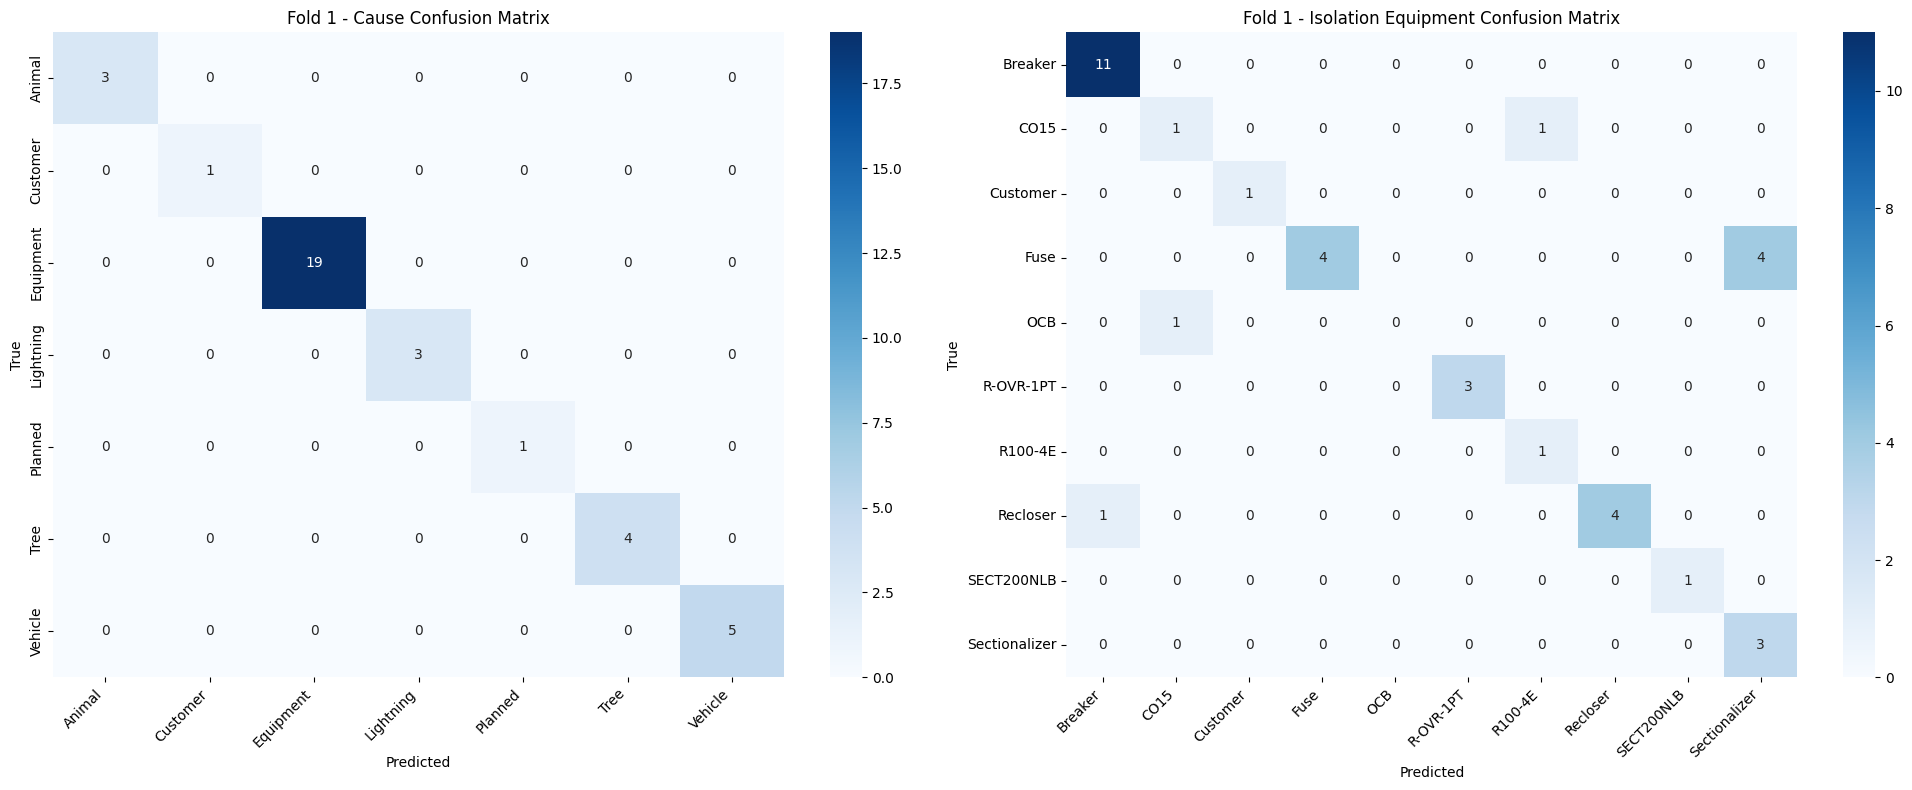


Classification Report - Cause (Fold 1):
              precision    recall  f1-score   support

      Animal       1.00      1.00      1.00         3
    Customer       1.00      1.00      1.00         1
   Equipment       1.00      1.00      1.00        19
   Lightning       1.00      1.00      1.00         3
     Planned       1.00      1.00      1.00         1
        Tree       1.00      1.00      1.00         4
     Vehicle       1.00      1.00      1.00         5

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36

Accuracy - Cause (Fold 1): 1.0000

Fold 2/5


Map: 100%|██████████| 36/36 [00:00<00:00, 4927.07 examples/s]
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at ./distilbert-pq-mlm and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at ./distilbert-pq-mlm and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\rmathew2020\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will

Training Cause Model (Fold 2):


  3%|▎         | 18/540 [00:13<05:50,  1.49it/s]

{'loss': 1.3932, 'grad_norm': 5.836428642272949, 'learning_rate': 0.00019333333333333333, 'epoch': 1.0}



  3%|▎         | 18/540 [00:13<05:50,  1.49it/s]

{'eval_loss': 0.5386520624160767, 'eval_accuracy': 0.8611111111111112, 'eval_precision': 0.7894179894179894, 'eval_f1': 0.8183559735283874, 'eval_runtime': 0.4696, 'eval_samples_per_second': 76.661, 'eval_steps_per_second': 10.647, 'epoch': 1.0}


  7%|▋         | 36/540 [00:27<05:52,  1.43it/s]

{'loss': 0.3877, 'grad_norm': 2.066309690475464, 'learning_rate': 0.0001866666666666667, 'epoch': 2.0}



  7%|▋         | 36/540 [00:28<05:52,  1.43it/s]

{'eval_loss': 0.3372489809989929, 'eval_accuracy': 0.9166666666666666, 'eval_precision': 0.9246031746031745, 'eval_f1': 0.912004662004662, 'eval_runtime': 0.4653, 'eval_samples_per_second': 77.371, 'eval_steps_per_second': 10.746, 'epoch': 2.0}


 10%|█         | 54/540 [00:41<05:36,  1.44it/s]

{'loss': 0.1661, 'grad_norm': 0.09000243991613388, 'learning_rate': 0.00018, 'epoch': 3.0}



 10%|█         | 54/540 [00:42<05:36,  1.44it/s]

{'eval_loss': 0.34006384015083313, 'eval_accuracy': 0.9166666666666666, 'eval_precision': 0.9212962962962964, 'eval_f1': 0.910826210826211, 'eval_runtime': 0.4496, 'eval_samples_per_second': 80.064, 'eval_steps_per_second': 11.12, 'epoch': 3.0}


 13%|█▎        | 72/540 [00:56<05:10,  1.51it/s]

{'loss': 0.0741, 'grad_norm': 0.0686502754688263, 'learning_rate': 0.00017333333333333334, 'epoch': 4.0}



 13%|█▎        | 72/540 [00:56<05:10,  1.51it/s]

{'eval_loss': 0.2479768544435501, 'eval_accuracy': 0.9166666666666666, 'eval_precision': 0.9212962962962964, 'eval_f1': 0.910826210826211, 'eval_runtime': 0.4552, 'eval_samples_per_second': 79.084, 'eval_steps_per_second': 10.984, 'epoch': 4.0}

Early stopping triggered! No accuracy improvement for 2 consecutive evaluations.
Best accuracy: 0.9167, Current accuracy: 0.9167
Accuracy history: ['0.8611', '0.9167', '0.9167', '0.9167']
Early stopping triggered at epoch 4


 13%|█▎        | 72/540 [00:57<06:14,  1.25it/s]


{'train_runtime': 57.6097, 'train_samples_per_second': 73.946, 'train_steps_per_second': 9.373, 'train_loss': 0.505278488000234, 'epoch': 4.0}
Cause model trained for 4 epochs

Training Isolation Model (Fold 2):


  3%|▎         | 18/540 [00:13<05:56,  1.46it/s]

{'loss': 2.0483, 'grad_norm': 6.913987636566162, 'learning_rate': 0.00019333333333333333, 'epoch': 1.0}



  3%|▎         | 18/540 [00:13<05:56,  1.46it/s]

{'eval_loss': 1.2049784660339355, 'eval_accuracy': 0.7222222222222222, 'eval_precision': 0.5914750957854407, 'eval_f1': 0.6349962207105064, 'eval_runtime': 0.5176, 'eval_samples_per_second': 69.548, 'eval_steps_per_second': 9.659, 'epoch': 1.0}


  7%|▋         | 36/540 [00:28<05:48,  1.45it/s]

{'loss': 1.1824, 'grad_norm': 7.312667369842529, 'learning_rate': 0.0001866666666666667, 'epoch': 2.0}



  7%|▋         | 36/540 [00:28<05:48,  1.45it/s]

{'eval_loss': 0.7590686082839966, 'eval_accuracy': 0.8333333333333334, 'eval_precision': 0.7436868686868687, 'eval_f1': 0.7804232804232805, 'eval_runtime': 0.5052, 'eval_samples_per_second': 71.265, 'eval_steps_per_second': 9.898, 'epoch': 2.0}


 10%|█         | 54/540 [00:42<05:35,  1.45it/s]

{'loss': 0.7055, 'grad_norm': 10.293013572692871, 'learning_rate': 0.00018, 'epoch': 3.0}



 10%|█         | 54/540 [00:43<05:35,  1.45it/s]

{'eval_loss': 0.46030962467193604, 'eval_accuracy': 0.8611111111111112, 'eval_precision': 0.8518518518518517, 'eval_f1': 0.8422364672364673, 'eval_runtime': 0.4666, 'eval_samples_per_second': 77.153, 'eval_steps_per_second': 10.716, 'epoch': 3.0}


 13%|█▎        | 72/540 [00:57<05:24,  1.44it/s]

{'loss': 0.5192, 'grad_norm': 4.960122585296631, 'learning_rate': 0.00017333333333333334, 'epoch': 4.0}



 13%|█▎        | 72/540 [00:57<05:24,  1.44it/s]

{'eval_loss': 0.49168893694877625, 'eval_accuracy': 0.8888888888888888, 'eval_precision': 0.9097222222222222, 'eval_f1': 0.894040657198552, 'eval_runtime': 0.4903, 'eval_samples_per_second': 73.426, 'eval_steps_per_second': 10.198, 'epoch': 4.0}


 17%|█▋        | 90/540 [01:11<05:07,  1.46it/s]

{'loss': 0.3641, 'grad_norm': 5.234996795654297, 'learning_rate': 0.0001666666666666667, 'epoch': 5.0}



 17%|█▋        | 90/540 [01:12<05:07,  1.46it/s]

{'eval_loss': 0.750671923160553, 'eval_accuracy': 0.8333333333333334, 'eval_precision': 0.9236111111111112, 'eval_f1': 0.8624338624338623, 'eval_runtime': 0.5005, 'eval_samples_per_second': 71.935, 'eval_steps_per_second': 9.991, 'epoch': 5.0}


 20%|██        | 108/540 [01:26<04:39,  1.55it/s]

{'loss': 0.3414, 'grad_norm': 6.336643695831299, 'learning_rate': 0.00016, 'epoch': 6.0}



 20%|██        | 108/540 [01:26<04:39,  1.55it/s]

{'eval_loss': 0.6204137206077576, 'eval_accuracy': 0.8333333333333334, 'eval_precision': 0.9203703703703702, 'eval_f1': 0.8505898755898756, 'eval_runtime': 0.4429, 'eval_samples_per_second': 81.286, 'eval_steps_per_second': 11.29, 'epoch': 6.0}

Early stopping triggered! No accuracy improvement for 2 consecutive evaluations.
Best accuracy: 0.8889, Current accuracy: 0.8333
Accuracy history: ['0.7222', '0.8333', '0.8611', '0.8889', '0.8333', '0.8333']
Early stopping triggered at epoch 6


 20%|██        | 108/540 [01:27<05:50,  1.23it/s]


{'train_runtime': 87.522, 'train_samples_per_second': 48.673, 'train_steps_per_second': 6.17, 'train_loss': 0.8601451847288344, 'epoch': 6.0}
Isolation model trained for 6 epochs

Evaluating models (Fold 2):


100%|██████████| 5/5 [00:00<00:00, 14.73it/s]



Fold 2 Times:
Training time: 0:02:25
Evaluation time: 0:00:00
Total time: 0:02:26

Fold 2 Results:
Cause - Accuracy: 0.9167, Precision: 0.9246, F1: 0.9120
Isolation - Accuracy: 0.8889, Precision: 0.9097, F1: 0.8940


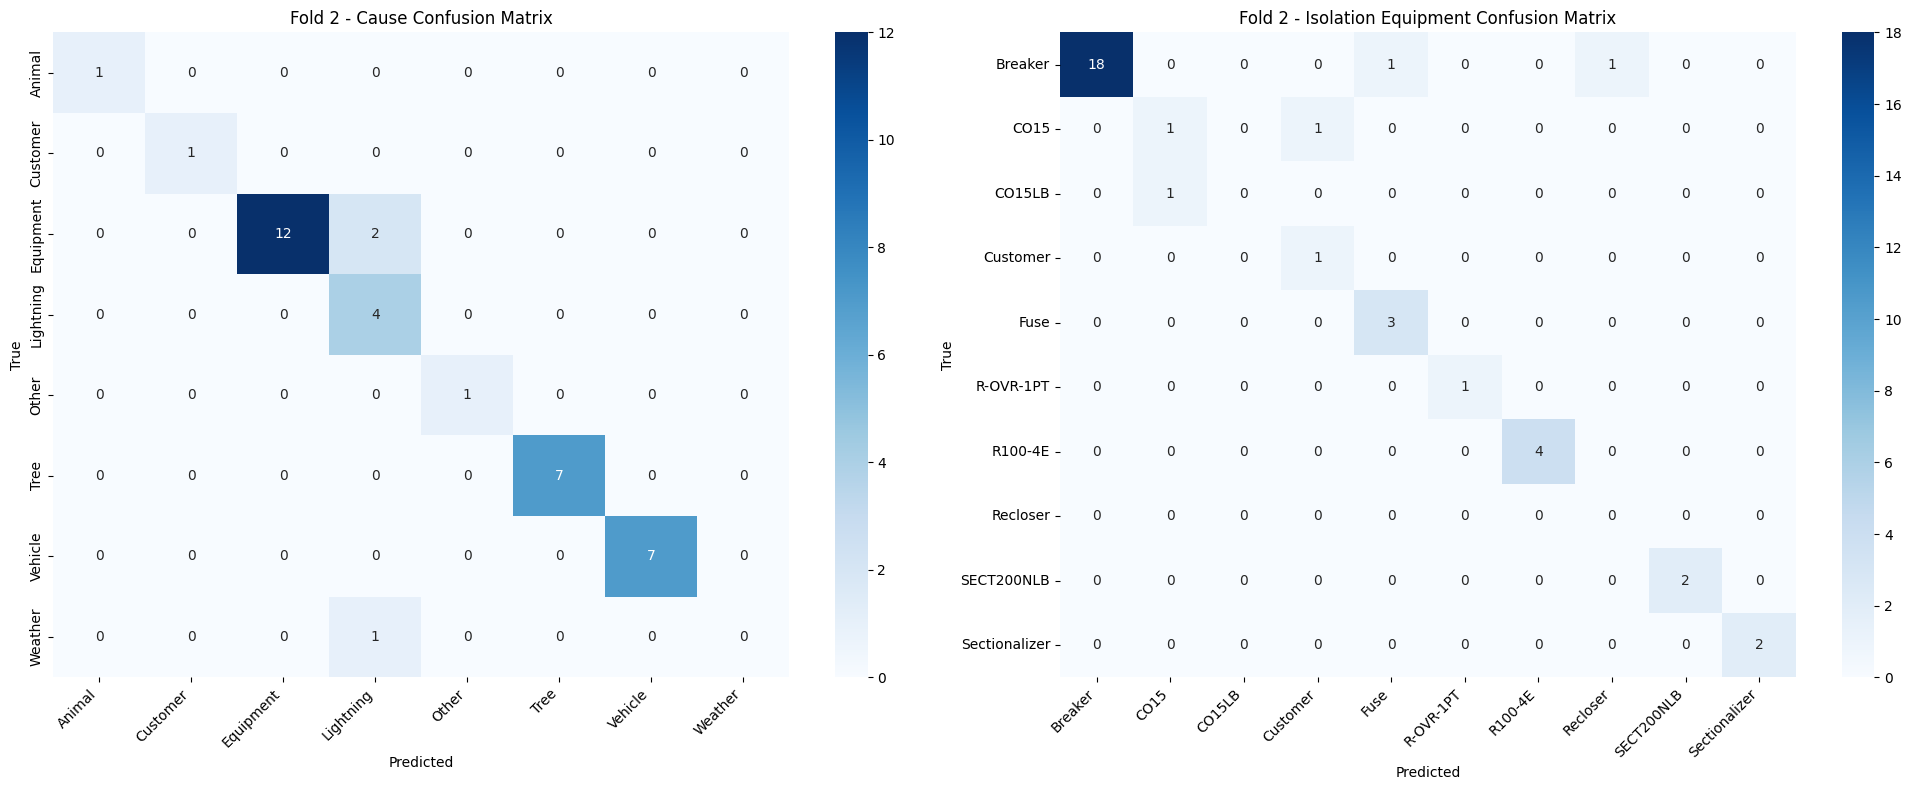


Classification Report - Cause (Fold 2):
              precision    recall  f1-score   support

      Animal       1.00      1.00      1.00         1
    Customer       1.00      1.00      1.00         1
   Equipment       1.00      0.86      0.92        14
   Lightning       0.57      1.00      0.73         4
       Other       1.00      1.00      1.00         1
        Tree       1.00      1.00      1.00         7
     Vehicle       1.00      1.00      1.00         7
     Weather       0.00      0.00      0.00         1

    accuracy                           0.92        36
   macro avg       0.82      0.86      0.83        36
weighted avg       0.92      0.92      0.91        36

Accuracy - Cause (Fold 2): 0.9167

Fold 3/5


Map: 100%|██████████| 36/36 [00:00<00:00, 6428.60 examples/s]
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at ./distilbert-pq-mlm and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at ./distilbert-pq-mlm and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\rmathew2020\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will

Training Cause Model (Fold 3):


  3%|▎         | 18/540 [00:12<05:26,  1.60it/s]

{'loss': 1.4295, 'grad_norm': 4.502751350402832, 'learning_rate': 0.00019333333333333333, 'epoch': 1.0}



  3%|▎         | 18/540 [00:12<05:26,  1.60it/s]

{'eval_loss': 0.7955329418182373, 'eval_accuracy': 0.7777777777777778, 'eval_precision': 0.7555555555555555, 'eval_f1': 0.7399355877616747, 'eval_runtime': 0.4309, 'eval_samples_per_second': 83.553, 'eval_steps_per_second': 11.605, 'epoch': 1.0}


  7%|▋         | 36/540 [00:26<06:00,  1.40it/s]

{'loss': 0.4949, 'grad_norm': 2.0771613121032715, 'learning_rate': 0.0001866666666666667, 'epoch': 2.0}



  7%|▋         | 36/540 [00:27<06:00,  1.40it/s]

{'eval_loss': 0.28910720348358154, 'eval_accuracy': 0.9166666666666666, 'eval_precision': 0.875, 'eval_f1': 0.8888888888888888, 'eval_runtime': 0.4925, 'eval_samples_per_second': 73.101, 'eval_steps_per_second': 10.153, 'epoch': 2.0}


 10%|█         | 54/540 [00:41<05:29,  1.47it/s]

{'loss': 0.2325, 'grad_norm': 0.3549293279647827, 'learning_rate': 0.00018, 'epoch': 3.0}



 10%|█         | 54/540 [00:41<05:29,  1.47it/s]

{'eval_loss': 0.13329792022705078, 'eval_accuracy': 0.9444444444444444, 'eval_precision': 0.9166666666666666, 'eval_f1': 0.925925925925926, 'eval_runtime': 0.4676, 'eval_samples_per_second': 76.99, 'eval_steps_per_second': 10.693, 'epoch': 3.0}


 13%|█▎        | 72/540 [00:55<05:01,  1.55it/s]

{'loss': 0.0995, 'grad_norm': 0.05525185540318489, 'learning_rate': 0.00017333333333333334, 'epoch': 4.0}



 13%|█▎        | 72/540 [00:55<05:01,  1.55it/s]

{'eval_loss': 0.06889903545379639, 'eval_accuracy': 0.9722222222222222, 'eval_precision': 0.9583333333333334, 'eval_f1': 0.9629629629629631, 'eval_runtime': 0.4913, 'eval_samples_per_second': 73.268, 'eval_steps_per_second': 10.176, 'epoch': 4.0}


 17%|█▋        | 90/540 [01:10<05:24,  1.39it/s]

{'loss': 0.0742, 'grad_norm': 0.04697820544242859, 'learning_rate': 0.0001666666666666667, 'epoch': 5.0}



 17%|█▋        | 90/540 [01:10<05:24,  1.39it/s]

{'eval_loss': 0.04442796856164932, 'eval_accuracy': 0.9722222222222222, 'eval_precision': 0.9583333333333334, 'eval_f1': 0.9629629629629631, 'eval_runtime': 0.5485, 'eval_samples_per_second': 65.628, 'eval_steps_per_second': 9.115, 'epoch': 5.0}


 20%|██        | 108/540 [01:23<04:36,  1.56it/s]

{'loss': 0.0291, 'grad_norm': 0.034718550741672516, 'learning_rate': 0.00016, 'epoch': 6.0}



 20%|██        | 108/540 [01:24<04:36,  1.56it/s]

{'eval_loss': 0.03841390833258629, 'eval_accuracy': 0.9722222222222222, 'eval_precision': 0.9583333333333334, 'eval_f1': 0.9629629629629631, 'eval_runtime': 0.5033, 'eval_samples_per_second': 71.535, 'eval_steps_per_second': 9.935, 'epoch': 6.0}

Early stopping triggered! No accuracy improvement for 2 consecutive evaluations.
Best accuracy: 0.9722, Current accuracy: 0.9722
Accuracy history: ['0.7778', '0.9167', '0.9444', '0.9722', '0.9722', '0.9722']
Early stopping triggered at epoch 6


 20%|██        | 108/540 [01:25<05:42,  1.26it/s]


{'train_runtime': 85.6259, 'train_samples_per_second': 49.751, 'train_steps_per_second': 6.307, 'train_loss': 0.3932749424819593, 'epoch': 6.0}
Cause model trained for 6 epochs

Training Isolation Model (Fold 3):


  3%|▎         | 18/540 [00:13<05:59,  1.45it/s]

{'loss': 2.2506, 'grad_norm': 8.004264831542969, 'learning_rate': 0.00019333333333333333, 'epoch': 1.0}



  3%|▎         | 18/540 [00:13<05:59,  1.45it/s]

{'eval_loss': 1.6262245178222656, 'eval_accuracy': 0.5555555555555556, 'eval_precision': 0.3142857142857143, 'eval_f1': 0.3991769547325103, 'eval_runtime': 0.4942, 'eval_samples_per_second': 72.851, 'eval_steps_per_second': 10.118, 'epoch': 1.0}


  7%|▋         | 36/540 [00:27<05:43,  1.47it/s]

{'loss': 1.5773, 'grad_norm': 10.320085525512695, 'learning_rate': 0.0001866666666666667, 'epoch': 2.0}



  7%|▋         | 36/540 [00:28<05:43,  1.47it/s]

{'eval_loss': 1.0252013206481934, 'eval_accuracy': 0.6666666666666666, 'eval_precision': 0.5287037037037037, 'eval_f1': 0.5690192743764172, 'eval_runtime': 0.4506, 'eval_samples_per_second': 79.885, 'eval_steps_per_second': 11.095, 'epoch': 2.0}


 10%|█         | 54/540 [00:42<05:38,  1.44it/s]

{'loss': 1.0614, 'grad_norm': 6.002501010894775, 'learning_rate': 0.00018, 'epoch': 3.0}



 10%|█         | 54/540 [00:42<05:38,  1.44it/s]

{'eval_loss': 0.6646237969398499, 'eval_accuracy': 0.6944444444444444, 'eval_precision': 0.6079059829059829, 'eval_f1': 0.633179012345679, 'eval_runtime': 0.4879, 'eval_samples_per_second': 73.789, 'eval_steps_per_second': 10.248, 'epoch': 3.0}


 13%|█▎        | 72/540 [00:56<05:22,  1.45it/s]

{'loss': 0.7458, 'grad_norm': 13.809680938720703, 'learning_rate': 0.00017333333333333334, 'epoch': 4.0}



 13%|█▎        | 72/540 [00:57<05:22,  1.45it/s]

{'eval_loss': 0.4743667244911194, 'eval_accuracy': 0.8611111111111112, 'eval_precision': 0.8446969696969697, 'eval_f1': 0.8433265582655827, 'eval_runtime': 0.4877, 'eval_samples_per_second': 73.814, 'eval_steps_per_second': 10.252, 'epoch': 4.0}


 17%|█▋        | 90/540 [01:11<05:13,  1.43it/s]

{'loss': 0.6292, 'grad_norm': 3.066643476486206, 'learning_rate': 0.0001666666666666667, 'epoch': 5.0}



 17%|█▋        | 90/540 [01:11<05:13,  1.43it/s]

{'eval_loss': 0.42046910524368286, 'eval_accuracy': 0.8611111111111112, 'eval_precision': 0.9333333333333333, 'eval_f1': 0.878383190883191, 'eval_runtime': 0.5034, 'eval_samples_per_second': 71.514, 'eval_steps_per_second': 9.933, 'epoch': 5.0}


 20%|██        | 108/540 [01:26<05:17,  1.36it/s]

{'loss': 0.5879, 'grad_norm': 7.394259452819824, 'learning_rate': 0.00016, 'epoch': 6.0}



 20%|██        | 108/540 [01:27<05:17,  1.36it/s]

{'eval_loss': 0.39715632796287537, 'eval_accuracy': 0.8888888888888888, 'eval_precision': 0.9722222222222222, 'eval_f1': 0.9139764764764765, 'eval_runtime': 0.6846, 'eval_samples_per_second': 52.583, 'eval_steps_per_second': 7.303, 'epoch': 6.0}


 23%|██▎       | 126/540 [01:41<04:53,  1.41it/s]

{'loss': 0.3935, 'grad_norm': 0.6388313174247742, 'learning_rate': 0.00015333333333333334, 'epoch': 7.0}



 23%|██▎       | 126/540 [01:41<04:53,  1.41it/s]

{'eval_loss': 0.26940467953681946, 'eval_accuracy': 0.8888888888888888, 'eval_precision': 0.9722222222222222, 'eval_f1': 0.9139764764764765, 'eval_runtime': 0.5064, 'eval_samples_per_second': 71.086, 'eval_steps_per_second': 9.873, 'epoch': 7.0}


 27%|██▋       | 144/540 [01:58<06:02,  1.09it/s]

{'loss': 0.2657, 'grad_norm': 3.9303629398345947, 'learning_rate': 0.00014666666666666666, 'epoch': 8.0}



 27%|██▋       | 144/540 [01:58<06:02,  1.09it/s]

{'eval_loss': 0.2654989957809448, 'eval_accuracy': 0.9166666666666666, 'eval_precision': 1.0, 'eval_f1': 0.9510135135135135, 'eval_runtime': 0.566, 'eval_samples_per_second': 63.603, 'eval_steps_per_second': 8.834, 'epoch': 8.0}


 30%|███       | 162/540 [02:14<04:46,  1.32it/s]

{'loss': 0.2102, 'grad_norm': 3.396193504333496, 'learning_rate': 0.00014, 'epoch': 9.0}



 30%|███       | 162/540 [02:14<04:46,  1.32it/s]

{'eval_loss': 0.5313823819160461, 'eval_accuracy': 0.8333333333333334, 'eval_precision': 0.9407407407407408, 'eval_f1': 0.8686183732752362, 'eval_runtime': 0.583, 'eval_samples_per_second': 61.752, 'eval_steps_per_second': 8.577, 'epoch': 9.0}


 33%|███▎      | 180/540 [02:30<04:31,  1.32it/s]

{'loss': 0.2177, 'grad_norm': 0.252096563577652, 'learning_rate': 0.00013333333333333334, 'epoch': 10.0}



 33%|███▎      | 180/540 [02:30<04:31,  1.32it/s]

{'eval_loss': 0.3567003607749939, 'eval_accuracy': 0.8888888888888888, 'eval_precision': 0.9722222222222222, 'eval_f1': 0.9174382716049381, 'eval_runtime': 0.6003, 'eval_samples_per_second': 59.973, 'eval_steps_per_second': 8.33, 'epoch': 10.0}

Early stopping triggered! No accuracy improvement for 2 consecutive evaluations.
Best accuracy: 0.9167, Current accuracy: 0.8889
Accuracy history: ['0.5556', '0.6667', '0.6944', '0.8611', '0.8611', '0.8889', '0.8889', '0.9167', '0.8333', '0.8889']
Early stopping triggered at epoch 10


 33%|███▎      | 180/540 [02:32<05:04,  1.18it/s]


{'train_runtime': 152.2617, 'train_samples_per_second': 27.978, 'train_steps_per_second': 3.547, 'train_loss': 0.7939184029897054, 'epoch': 10.0}
Isolation model trained for 10 epochs

Evaluating models (Fold 3):


100%|██████████| 5/5 [00:00<00:00, 13.13it/s]



Fold 3 Times:
Training time: 0:03:58
Evaluation time: 0:00:00
Total time: 0:03:59

Fold 3 Results:
Cause - Accuracy: 0.9722, Precision: 0.9583, F1: 0.9630
Isolation - Accuracy: 0.9167, Precision: 1.0000, F1: 0.9510


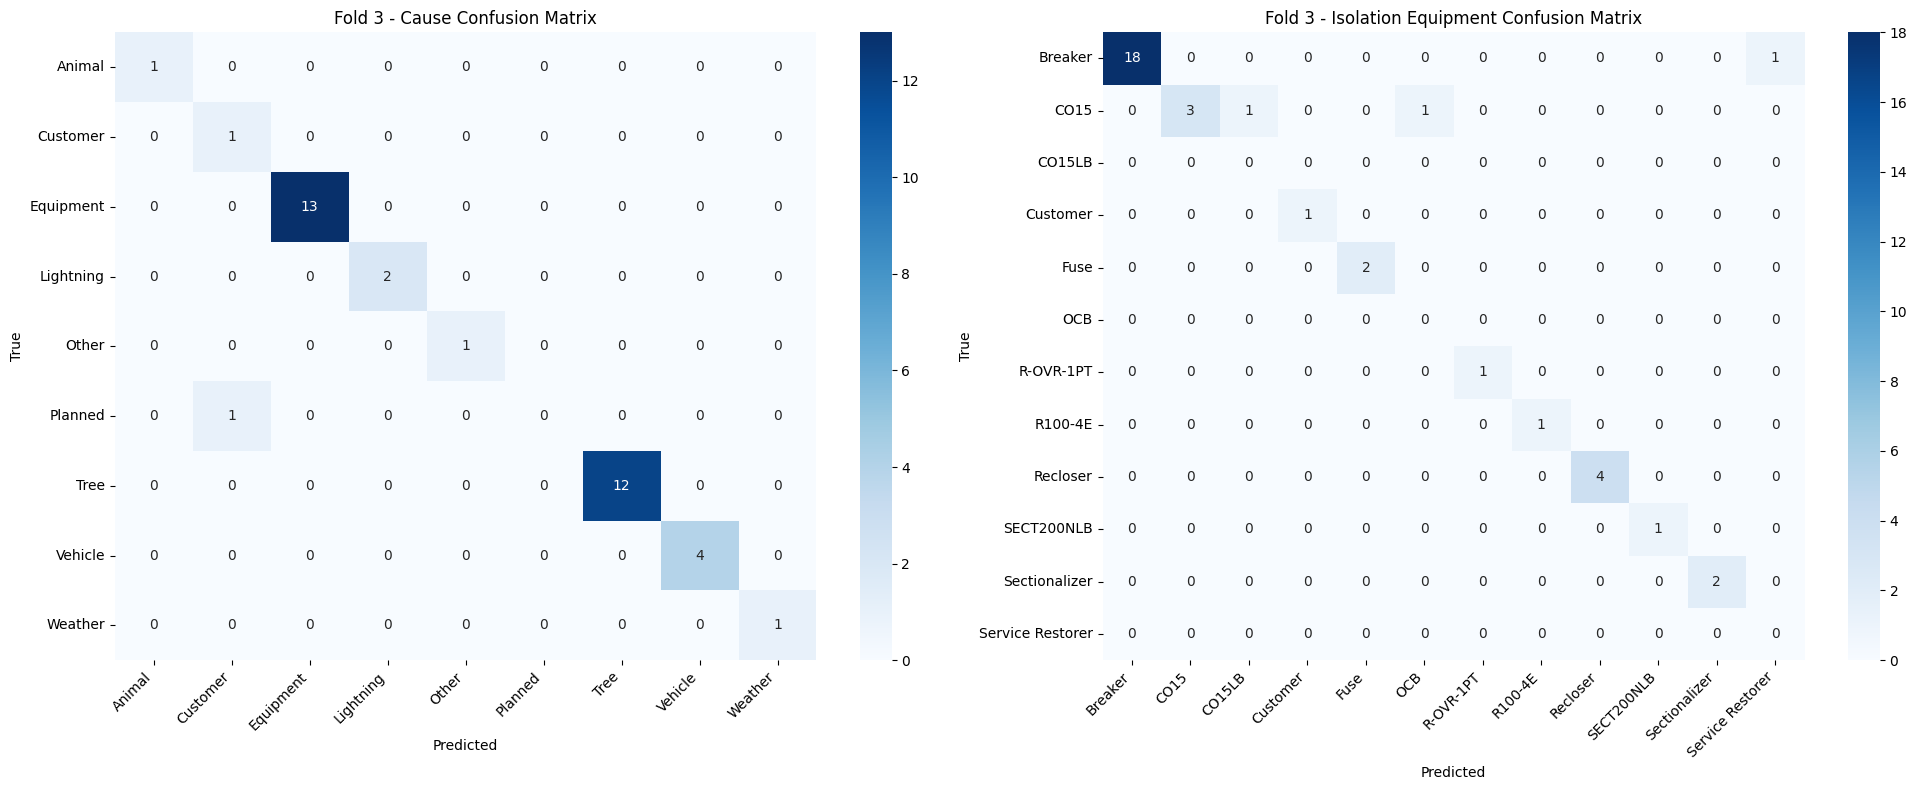


Classification Report - Cause (Fold 3):
              precision    recall  f1-score   support

      Animal       1.00      1.00      1.00         1
    Customer       0.50      1.00      0.67         1
   Equipment       1.00      1.00      1.00        13
   Lightning       1.00      1.00      1.00         2
       Other       1.00      1.00      1.00         1
     Planned       0.00      0.00      0.00         1
        Tree       1.00      1.00      1.00        12
     Vehicle       1.00      1.00      1.00         4
     Weather       1.00      1.00      1.00         1

    accuracy                           0.97        36
   macro avg       0.83      0.89      0.85        36
weighted avg       0.96      0.97      0.96        36

Accuracy - Cause (Fold 3): 0.9722

Fold 4/5


Map: 100%|██████████| 35/35 [00:00<00:00, 1999.68 examples/s]
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at ./distilbert-pq-mlm and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at ./distilbert-pq-mlm and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\rmathew2020\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will

Training Cause Model (Fold 4):


  3%|▎         | 18/540 [00:16<08:05,  1.08it/s]

{'loss': 1.5027, 'grad_norm': 3.8289735317230225, 'learning_rate': 0.00019333333333333333, 'epoch': 1.0}



  3%|▎         | 18/540 [00:17<08:05,  1.08it/s]

{'eval_loss': 0.9479812383651733, 'eval_accuracy': 0.7142857142857143, 'eval_precision': 0.5398496240601504, 'eval_f1': 0.6119897959183673, 'eval_runtime': 0.6308, 'eval_samples_per_second': 55.485, 'eval_steps_per_second': 7.926, 'epoch': 1.0}


  7%|▋         | 36/540 [00:32<05:53,  1.43it/s]

{'loss': 0.4983, 'grad_norm': 0.8471584320068359, 'learning_rate': 0.0001866666666666667, 'epoch': 2.0}



  7%|▋         | 36/540 [00:33<05:53,  1.43it/s]

{'eval_loss': 0.5655489563941956, 'eval_accuracy': 0.9142857142857143, 'eval_precision': 0.8647619047619047, 'eval_f1': 0.8877551020408163, 'eval_runtime': 0.4449, 'eval_samples_per_second': 78.673, 'eval_steps_per_second': 11.239, 'epoch': 2.0}


 10%|█         | 54/540 [00:47<05:51,  1.38it/s]

{'loss': 0.1842, 'grad_norm': 1.2292495965957642, 'learning_rate': 0.00018, 'epoch': 3.0}



 10%|█         | 54/540 [00:48<05:51,  1.38it/s]

{'eval_loss': 0.40314772725105286, 'eval_accuracy': 0.9142857142857143, 'eval_precision': 0.8640816326530611, 'eval_f1': 0.887565066512435, 'eval_runtime': 0.4585, 'eval_samples_per_second': 76.34, 'eval_steps_per_second': 10.906, 'epoch': 3.0}


 13%|█▎        | 72/540 [01:01<05:05,  1.53it/s]

{'loss': 0.0892, 'grad_norm': 0.2166663408279419, 'learning_rate': 0.00017333333333333334, 'epoch': 4.0}



 13%|█▎        | 72/540 [01:02<05:05,  1.53it/s]

{'eval_loss': 0.5562693476676941, 'eval_accuracy': 0.9142857142857143, 'eval_precision': 0.879047619047619, 'eval_f1': 0.8916766706682674, 'eval_runtime': 0.429, 'eval_samples_per_second': 81.587, 'eval_steps_per_second': 11.655, 'epoch': 4.0}

Early stopping triggered! No accuracy improvement for 2 consecutive evaluations.
Best accuracy: 0.9143, Current accuracy: 0.9143
Accuracy history: ['0.7143', '0.9143', '0.9143', '0.9143']
Early stopping triggered at epoch 4


 13%|█▎        | 72/540 [01:03<06:51,  1.14it/s]


{'train_runtime': 63.2267, 'train_samples_per_second': 67.851, 'train_steps_per_second': 8.541, 'train_loss': 0.5686233772171868, 'epoch': 4.0}
Cause model trained for 4 epochs

Training Isolation Model (Fold 4):


  3%|▎         | 18/540 [00:15<07:05,  1.23it/s]

{'loss': 2.0439, 'grad_norm': 5.1004486083984375, 'learning_rate': 0.00019333333333333333, 'epoch': 1.0}



  3%|▎         | 18/540 [00:15<07:05,  1.23it/s]

{'eval_loss': 2.0892772674560547, 'eval_accuracy': 0.37142857142857144, 'eval_precision': 0.2520634920634921, 'eval_f1': 0.2816326530612245, 'eval_runtime': 0.5554, 'eval_samples_per_second': 63.017, 'eval_steps_per_second': 9.002, 'epoch': 1.0}


  7%|▋         | 36/540 [00:31<06:13,  1.35it/s]

{'loss': 1.3774, 'grad_norm': 7.292491912841797, 'learning_rate': 0.0001866666666666667, 'epoch': 2.0}



  7%|▋         | 36/540 [00:31<06:13,  1.35it/s]

{'eval_loss': 1.309617042541504, 'eval_accuracy': 0.5428571428571428, 'eval_precision': 0.44418811002661934, 'eval_f1': 0.41669467787114844, 'eval_runtime': 0.5361, 'eval_samples_per_second': 65.286, 'eval_steps_per_second': 9.327, 'epoch': 2.0}


 10%|█         | 54/540 [00:47<06:19,  1.28it/s]

{'loss': 0.869, 'grad_norm': 4.348444938659668, 'learning_rate': 0.00018, 'epoch': 3.0}



 10%|█         | 54/540 [00:48<06:19,  1.28it/s]

{'eval_loss': 0.8222488164901733, 'eval_accuracy': 0.7714285714285715, 'eval_precision': 0.8224489795918367, 'eval_f1': 0.7473469387755103, 'eval_runtime': 0.5392, 'eval_samples_per_second': 64.916, 'eval_steps_per_second': 9.274, 'epoch': 3.0}


 13%|█▎        | 72/540 [01:02<05:12,  1.50it/s]

{'loss': 0.6086, 'grad_norm': 10.116436004638672, 'learning_rate': 0.00017333333333333334, 'epoch': 4.0}



 13%|█▎        | 72/540 [01:02<05:12,  1.50it/s]

{'eval_loss': 0.6689336895942688, 'eval_accuracy': 0.8, 'eval_precision': 0.8040293040293041, 'eval_f1': 0.7634199134199134, 'eval_runtime': 0.4411, 'eval_samples_per_second': 79.34, 'eval_steps_per_second': 11.334, 'epoch': 4.0}


 17%|█▋        | 90/540 [01:16<05:43,  1.31it/s]

{'loss': 0.4243, 'grad_norm': 2.5416178703308105, 'learning_rate': 0.0001666666666666667, 'epoch': 5.0}



 17%|█▋        | 90/540 [01:17<05:43,  1.31it/s]

{'eval_loss': 0.6396759748458862, 'eval_accuracy': 0.7714285714285715, 'eval_precision': 0.7983673469387755, 'eval_f1': 0.734734693877551, 'eval_runtime': 0.5285, 'eval_samples_per_second': 66.222, 'eval_steps_per_second': 9.46, 'epoch': 5.0}


 20%|██        | 108/540 [01:33<05:46,  1.25it/s]

{'loss': 0.4104, 'grad_norm': 38.83837890625, 'learning_rate': 0.00016, 'epoch': 6.0}



 20%|██        | 108/540 [01:34<05:46,  1.25it/s]

{'eval_loss': 0.6128605604171753, 'eval_accuracy': 0.8285714285714286, 'eval_precision': 0.803076923076923, 'eval_f1': 0.7952380952380952, 'eval_runtime': 0.4418, 'eval_samples_per_second': 79.219, 'eval_steps_per_second': 11.317, 'epoch': 6.0}


 23%|██▎       | 126/540 [01:47<04:38,  1.48it/s]

{'loss': 0.3225, 'grad_norm': 3.7283551692962646, 'learning_rate': 0.00015333333333333334, 'epoch': 7.0}



 23%|██▎       | 126/540 [01:48<04:38,  1.48it/s]

{'eval_loss': 0.4667142629623413, 'eval_accuracy': 0.8571428571428571, 'eval_precision': 0.9052380952380953, 'eval_f1': 0.8458592132505175, 'eval_runtime': 0.4648, 'eval_samples_per_second': 75.304, 'eval_steps_per_second': 10.758, 'epoch': 7.0}


 27%|██▋       | 144/540 [02:01<04:27,  1.48it/s]

{'loss': 0.2652, 'grad_norm': 0.11199205368757248, 'learning_rate': 0.00014666666666666666, 'epoch': 8.0}



 27%|██▋       | 144/540 [02:02<04:27,  1.48it/s]

{'eval_loss': 0.6248922944068909, 'eval_accuracy': 0.8571428571428571, 'eval_precision': 0.8776190476190476, 'eval_f1': 0.8471014492753622, 'eval_runtime': 0.4551, 'eval_samples_per_second': 76.911, 'eval_steps_per_second': 10.987, 'epoch': 8.0}


 30%|███       | 162/540 [02:15<04:16,  1.47it/s]

{'loss': 0.2758, 'grad_norm': 2.697986364364624, 'learning_rate': 0.00014, 'epoch': 9.0}



 30%|███       | 162/540 [02:16<04:16,  1.47it/s]

{'eval_loss': 0.6635979413986206, 'eval_accuracy': 0.8571428571428571, 'eval_precision': 0.8957142857142858, 'eval_f1': 0.8517006802721089, 'eval_runtime': 0.4895, 'eval_samples_per_second': 71.506, 'eval_steps_per_second': 10.215, 'epoch': 9.0}

Early stopping triggered! No accuracy improvement for 2 consecutive evaluations.
Best accuracy: 0.8571, Current accuracy: 0.8571
Accuracy history: ['0.3714', '0.5429', '0.7714', '0.8000', '0.7714', '0.8286', '0.8571', '0.8571', '0.8571']
Early stopping triggered at epoch 9


 30%|███       | 162/540 [02:17<05:20,  1.18it/s]


{'train_runtime': 137.3816, 'train_samples_per_second': 31.227, 'train_steps_per_second': 3.931, 'train_loss': 0.7330013969798147, 'epoch': 9.0}
Isolation model trained for 9 epochs

Evaluating models (Fold 4):


100%|██████████| 5/5 [00:00<00:00, 16.03it/s]



Fold 4 Times:
Training time: 0:03:21
Evaluation time: 0:00:00
Total time: 0:03:22

Fold 4 Results:
Cause - Accuracy: 0.9143, Precision: 0.8648, F1: 0.8878
Isolation - Accuracy: 0.8571, Precision: 0.9052, F1: 0.8459


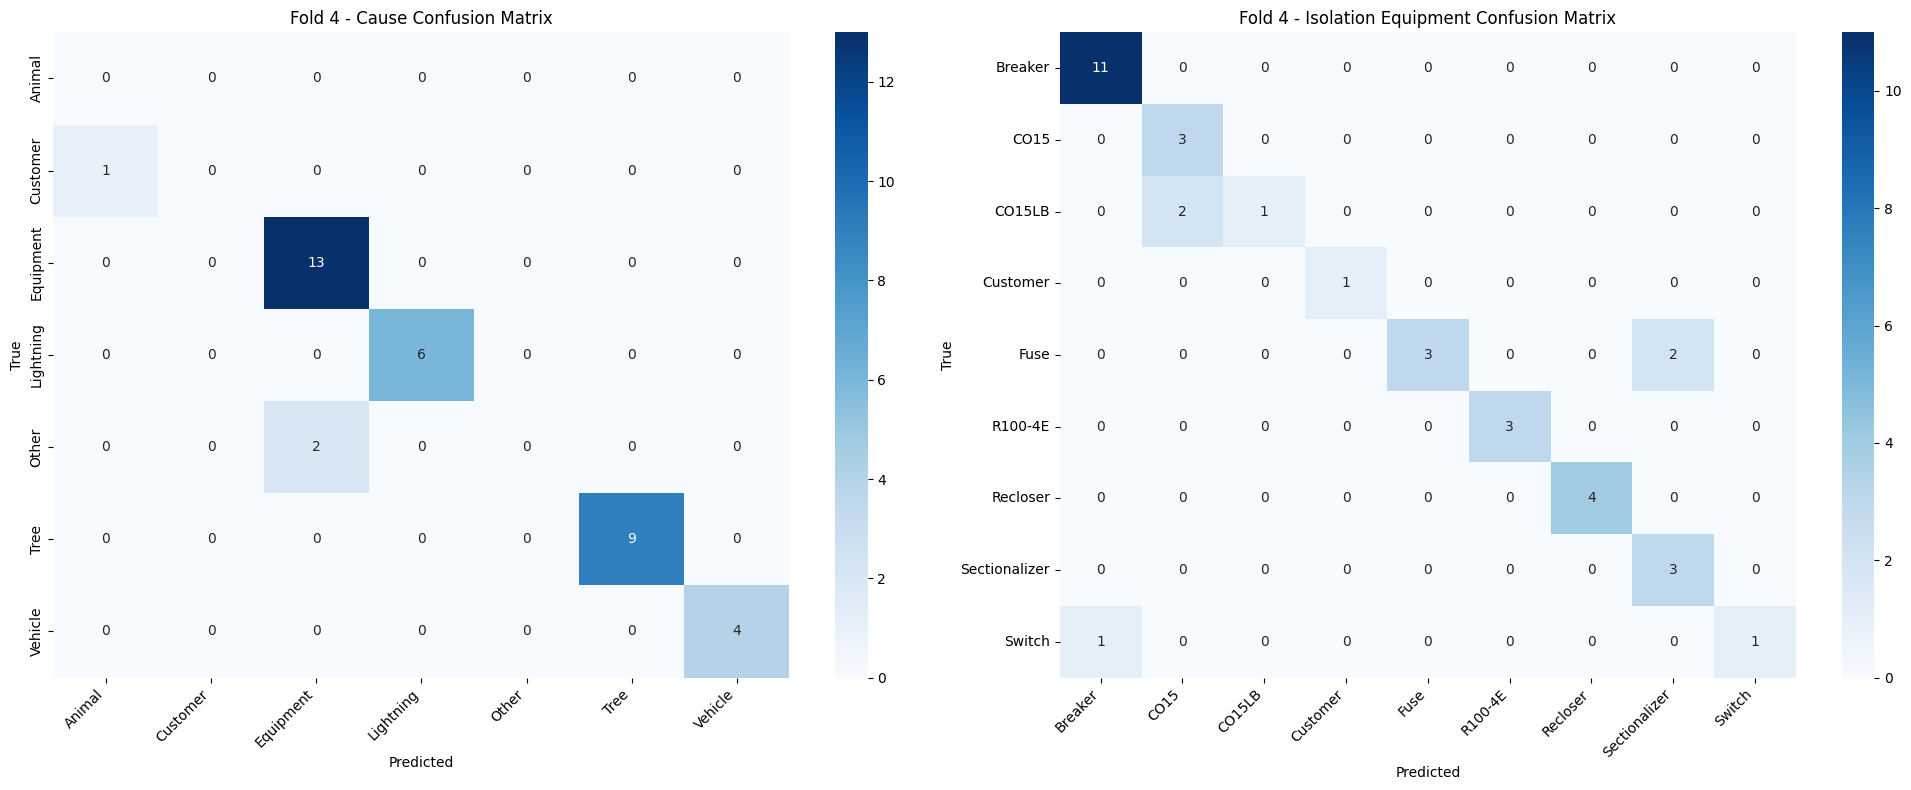


Classification Report - Cause (Fold 4):
              precision    recall  f1-score   support

      Animal       0.00      0.00      0.00         0
    Customer       0.00      0.00      0.00         1
   Equipment       0.87      1.00      0.93        13
   Lightning       1.00      1.00      1.00         6
       Other       0.00      0.00      0.00         2
        Tree       1.00      1.00      1.00         9
     Vehicle       1.00      1.00      1.00         4

    accuracy                           0.91        35
   macro avg       0.55      0.57      0.56        35
weighted avg       0.86      0.91      0.89        35

Accuracy - Cause (Fold 4): 0.9143

Fold 5/5


Map: 100%|██████████| 35/35 [00:00<00:00, 6957.38 examples/s]
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at ./distilbert-pq-mlm and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at ./distilbert-pq-mlm and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\rmathew2020\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will

Training Cause Model (Fold 5):


  3%|▎         | 18/540 [00:11<05:23,  1.61it/s]

{'loss': 1.2814, 'grad_norm': 4.017325401306152, 'learning_rate': 0.00019333333333333333, 'epoch': 1.0}



  3%|▎         | 18/540 [00:12<05:23,  1.61it/s]

{'eval_loss': 0.6993923783302307, 'eval_accuracy': 0.8571428571428571, 'eval_precision': 0.7968253968253969, 'eval_f1': 0.8166666666666668, 'eval_runtime': 0.5632, 'eval_samples_per_second': 62.147, 'eval_steps_per_second': 8.878, 'epoch': 1.0}


  7%|▋         | 36/540 [00:24<05:04,  1.65it/s]

{'loss': 0.3585, 'grad_norm': 0.6913079023361206, 'learning_rate': 0.0001866666666666667, 'epoch': 2.0}



  7%|▋         | 36/540 [00:25<05:04,  1.65it/s]

{'eval_loss': 0.30822062492370605, 'eval_accuracy': 0.9428571428571428, 'eval_precision': 0.9519047619047618, 'eval_f1': 0.9358667604973023, 'eval_runtime': 0.5436, 'eval_samples_per_second': 64.391, 'eval_steps_per_second': 9.199, 'epoch': 2.0}


 10%|█         | 54/540 [00:37<05:02,  1.61it/s]

{'loss': 0.1985, 'grad_norm': 0.0841466560959816, 'learning_rate': 0.00018, 'epoch': 3.0}



 10%|█         | 54/540 [00:38<05:02,  1.61it/s]

{'eval_loss': 0.306487500667572, 'eval_accuracy': 0.9142857142857143, 'eval_precision': 0.8785714285714286, 'eval_f1': 0.8876190476190476, 'eval_runtime': 0.534, 'eval_samples_per_second': 65.538, 'eval_steps_per_second': 9.363, 'epoch': 3.0}


 13%|█▎        | 72/540 [00:50<04:56,  1.58it/s]

{'loss': 0.0822, 'grad_norm': 3.023303508758545, 'learning_rate': 0.00017333333333333334, 'epoch': 4.0}



 13%|█▎        | 72/540 [00:51<04:56,  1.58it/s]

{'eval_loss': 0.5638761520385742, 'eval_accuracy': 0.9142857142857143, 'eval_precision': 0.8928571428571429, 'eval_f1': 0.8971428571428571, 'eval_runtime': 0.565, 'eval_samples_per_second': 61.946, 'eval_steps_per_second': 8.849, 'epoch': 4.0}

Early stopping triggered! No accuracy improvement for 2 consecutive evaluations.
Best accuracy: 0.9429, Current accuracy: 0.9143
Accuracy history: ['0.8571', '0.9429', '0.9143', '0.9143']
Early stopping triggered at epoch 4


 13%|█▎        | 72/540 [00:52<05:41,  1.37it/s]


{'train_runtime': 52.4982, 'train_samples_per_second': 81.717, 'train_steps_per_second': 10.286, 'train_loss': 0.4801659435033798, 'epoch': 4.0}
Cause model trained for 4 epochs

Training Isolation Model (Fold 5):


  3%|▎         | 18/540 [00:11<05:22,  1.62it/s]

{'loss': 2.1025, 'grad_norm': 4.908798694610596, 'learning_rate': 0.00019333333333333333, 'epoch': 1.0}



  3%|▎         | 18/540 [00:12<05:22,  1.62it/s]

{'eval_loss': 1.893221139907837, 'eval_accuracy': 0.5428571428571428, 'eval_precision': 0.5130102040816327, 'eval_f1': 0.5176395289298515, 'eval_runtime': 0.5327, 'eval_samples_per_second': 65.701, 'eval_steps_per_second': 9.386, 'epoch': 1.0}


  7%|▋         | 36/540 [00:25<05:21,  1.57it/s]

{'loss': 1.1091, 'grad_norm': 8.979316711425781, 'learning_rate': 0.0001866666666666667, 'epoch': 2.0}



  7%|▋         | 36/540 [00:25<05:21,  1.57it/s]

{'eval_loss': 1.6926531791687012, 'eval_accuracy': 0.6285714285714286, 'eval_precision': 0.5477591036414566, 'eval_f1': 0.5796103896103896, 'eval_runtime': 0.6015, 'eval_samples_per_second': 58.192, 'eval_steps_per_second': 8.313, 'epoch': 2.0}


 10%|█         | 54/540 [00:38<04:54,  1.65it/s]

{'loss': 0.598, 'grad_norm': 4.974079132080078, 'learning_rate': 0.00018, 'epoch': 3.0}



 10%|█         | 54/540 [00:38<04:54,  1.65it/s]

{'eval_loss': 1.6682114601135254, 'eval_accuracy': 0.5142857142857142, 'eval_precision': 0.43214285714285716, 'eval_f1': 0.4608946608946609, 'eval_runtime': 0.5048, 'eval_samples_per_second': 69.331, 'eval_steps_per_second': 9.904, 'epoch': 3.0}


 13%|█▎        | 72/540 [00:51<04:55,  1.59it/s]

{'loss': 0.4139, 'grad_norm': 6.23759651184082, 'learning_rate': 0.00017333333333333334, 'epoch': 4.0}



 13%|█▎        | 72/540 [00:52<04:55,  1.59it/s]

{'eval_loss': 1.6523634195327759, 'eval_accuracy': 0.6857142857142857, 'eval_precision': 0.6187074829931973, 'eval_f1': 0.6422734254992319, 'eval_runtime': 0.5466, 'eval_samples_per_second': 64.027, 'eval_steps_per_second': 9.147, 'epoch': 4.0}


 17%|█▋        | 90/540 [01:04<04:39,  1.61it/s]

{'loss': 0.291, 'grad_norm': 7.688715934753418, 'learning_rate': 0.0001666666666666667, 'epoch': 5.0}



 17%|█▋        | 90/540 [01:05<04:39,  1.61it/s]

{'eval_loss': 2.105026960372925, 'eval_accuracy': 0.6285714285714286, 'eval_precision': 0.6540816326530612, 'eval_f1': 0.6232258064516129, 'eval_runtime': 0.5612, 'eval_samples_per_second': 62.371, 'eval_steps_per_second': 8.91, 'epoch': 5.0}


 20%|██        | 108/540 [01:18<04:29,  1.60it/s]

{'loss': 0.2771, 'grad_norm': 1.6660561561584473, 'learning_rate': 0.00016, 'epoch': 6.0}



 20%|██        | 108/540 [01:18<04:29,  1.60it/s]

{'eval_loss': 1.961422085762024, 'eval_accuracy': 0.6857142857142857, 'eval_precision': 0.6261904761904761, 'eval_f1': 0.6499790532048597, 'eval_runtime': 0.545, 'eval_samples_per_second': 64.215, 'eval_steps_per_second': 9.174, 'epoch': 6.0}

Early stopping triggered! No accuracy improvement for 2 consecutive evaluations.
Best accuracy: 0.6857, Current accuracy: 0.6857
Accuracy history: ['0.5429', '0.6286', '0.5143', '0.6857', '0.6286', '0.6857']
Early stopping triggered at epoch 6


 20%|██        | 108/540 [01:19<05:18,  1.36it/s]


{'train_runtime': 79.6726, 'train_samples_per_second': 53.845, 'train_steps_per_second': 6.778, 'train_loss': 0.7986035567742807, 'epoch': 6.0}
Isolation model trained for 6 epochs

Evaluating models (Fold 5):


100%|██████████| 5/5 [00:00<00:00, 12.39it/s]



Fold 5 Times:
Training time: 0:02:13
Evaluation time: 0:00:01
Total time: 0:02:14

Fold 5 Results:
Cause - Accuracy: 0.9429, Precision: 0.9519, F1: 0.9359
Isolation - Accuracy: 0.6857, Precision: 0.6187, F1: 0.6423


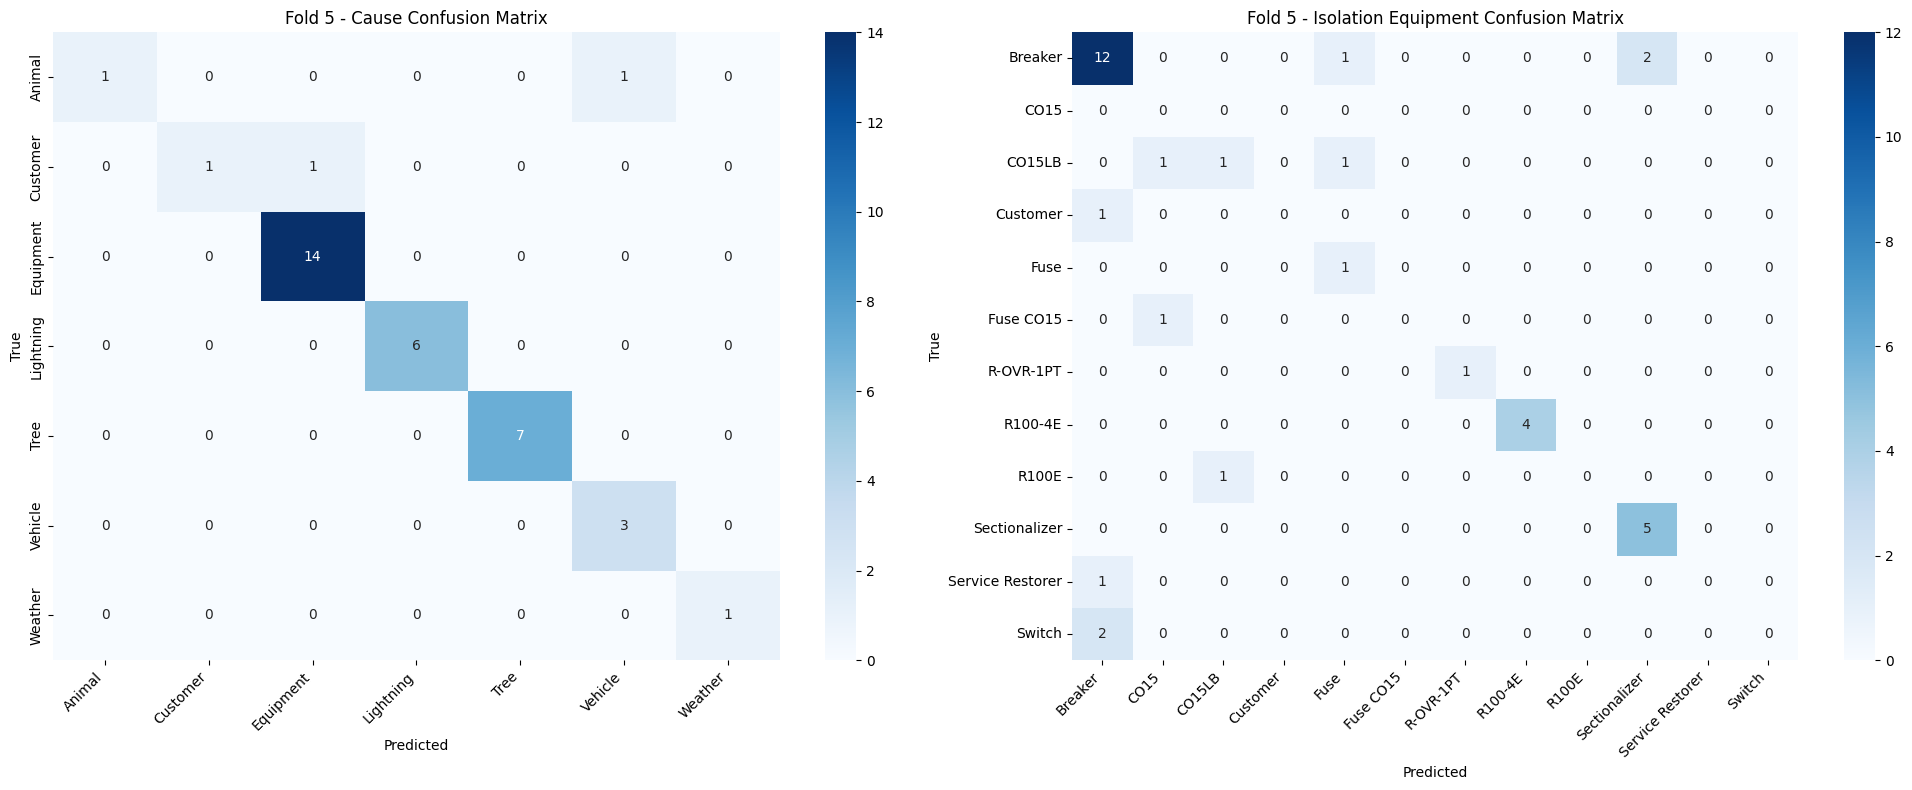


Classification Report - Cause (Fold 5):
              precision    recall  f1-score   support

      Animal       1.00      0.50      0.67         2
    Customer       1.00      0.50      0.67         2
   Equipment       0.93      1.00      0.97        14
   Lightning       1.00      1.00      1.00         6
        Tree       1.00      1.00      1.00         7
     Vehicle       0.75      1.00      0.86         3
     Weather       1.00      1.00      1.00         1

    accuracy                           0.94        35
   macro avg       0.95      0.86      0.88        35
weighted avg       0.95      0.94      0.94        35

Accuracy - Cause (Fold 5): 0.9429

AVERAGE RESULTS ACROSS ALL FOLDS
Cause - Avg Accuracy: 0.9492 ± 0.0329
Cause - Avg Precision: 0.9399 ± 0.0447
Cause - Avg F1: 0.9397 ± 0.0391
Cause - Avg Epochs Trained: 5.00 ± 1.26
Isolation - Avg Accuracy: 0.8308 ± 0.0814
Isolation - Avg Precision: 0.8582 ± 0.1283
Isolation - Avg F1: 0.8264 ± 0.1050
Isolation - Avg Epochs T

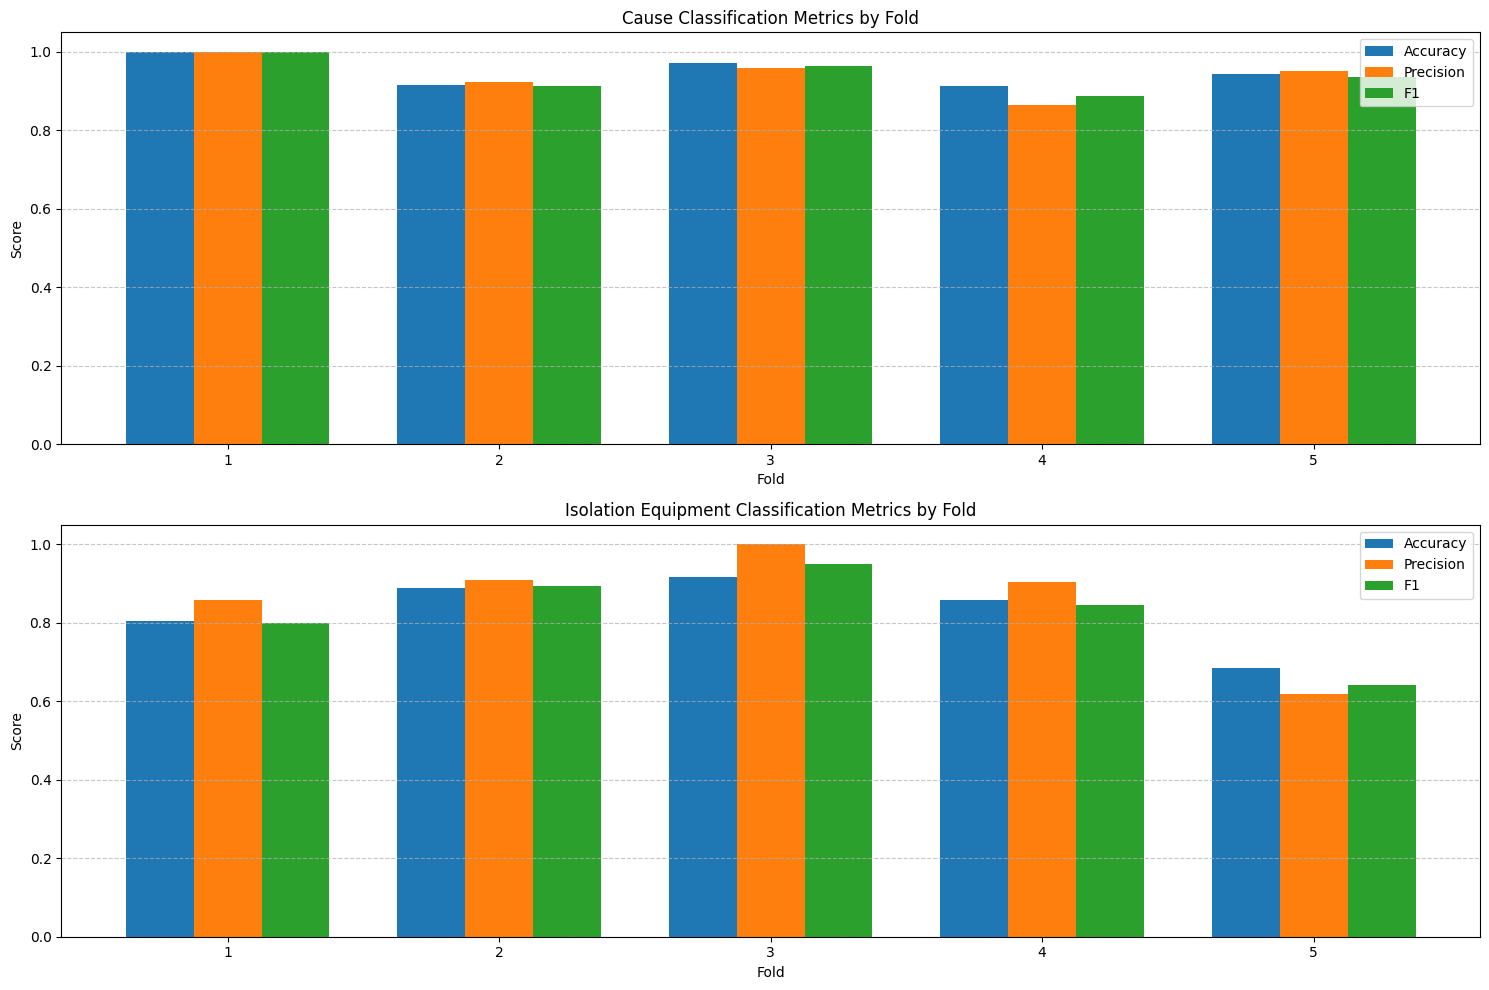


Example Text Classification:

Text: Circuit breaker tripped due to storm
Predicted cause: Equipment
Predicted isolation: Breaker

Text: Customer requested service disconnection
Predicted cause: Vehicle
Predicted isolation: Fuse

Text: Transformer failure after lightning strike
Predicted cause: Equipment
Predicted isolation: Breaker
Predicted cause: Tree
Predicted isolation: Breaker


In [6]:
import numpy as np
import pandas as pd
import time
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, accuracy_score
from transformers import AutoModelForSequenceClassification, AutoTokenizer, TrainingArguments, Trainer, DataCollatorWithPadding
import torch
import evaluate
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from datasets import Dataset
import os
from datetime import timedelta

# Set parameters
data_path = "PQEvents_Ticket_csv.csv"
text_column_name = "Details"
label_column_name = "Cause"

model_name = "distilbert-base-uncased"
test_size = 0.2
num_labels = 2
n_splits = 5  # Number of folds for K-fold cross-validation
adaptation_path = "./distilbert-pq-mlm"
max_epochs = 30  # Maximum number of epochs
early_stopping_patience = 2  # Number of epochs with no improvement after which training will stop
early_stopping_threshold = 0.001  # Minimum change to qualify as an improvement

# Create directory for results
os.makedirs("./resultsberta", exist_ok=True)

# Load and preprocess data
df = pd.read_csv(data_path)

# First, clean up Cause column
df = df[~df['Cause'].isin(['Unknown', 'Undetermined'])]  # Remove rows with these values in Cause column 
df['Cause'] = df['Cause'].replace(['Customer Request', 'Customer Caused'], 'Customer')

# Replace Unknown/Undetermined in Isolation Equipment Code
df['Isolation Equipment Code'] = df['Isolation Equipment Code'].replace(['Unknown', 'Undetermined'], np.nan)

# Only drop rows where Cause is NaN
df = df.dropna(subset=['Cause'])

# If 'Cause' is 'Customer' and 'Isolation Equipment Code' is NaN, set 'Isolation Equipment Code' to 'Customer'
df.loc[(df['Cause'] == 'Customer') & (df['Isolation Equipment Code'].isna()), 'Isolation Equipment Code'] = 'Customer'

# Drop rows where 'Isolation Equipment Code' is NaN, but only for causes other than 'Customer'
df = df.dropna(subset=['Isolation Equipment Code'])

# Keep only rows where 'Details' is a string
df = df[df['Details'].apply(lambda x: isinstance(x, str))]

# Function to clean text data
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    return text

# Apply text cleaning
df['Details'] = df['Details'].apply(clean_text)

# Print distributions
print("\nUnique Cause Classes with Counts:")
print("-" * 40)
cause_unique = df['Cause'].value_counts()
for cause, count in cause_unique.items():
    print(f"{cause:<20} {count:>5}")

print("\nIsolation Equipment Codes for Customer causes:")
print(df[df['Cause'] == 'Customer']['Isolation Equipment Code'].value_counts(dropna=False))

print(f"\nDataset shape: {df.shape}")

# Create label encoders
le_cause = preprocessing.LabelEncoder()
le_isolation = preprocessing.LabelEncoder()

# Fit both encoders
le_cause.fit(df[label_column_name].tolist())
le_isolation.fit(df['Isolation Equipment Code'].tolist())

# Transform labels
df['cause_label'] = le_cause.transform(df[label_column_name].tolist())
df['isolation_label'] = le_isolation.transform(df['Isolation Equipment Code'].tolist())

# Print out the labels with their corresponding encoded values
label_mapping = dict(zip(le_cause.classes_, le_cause.transform(le_cause.classes_)))
print("Cause Label Mapping:")
for label, encoded_value in label_mapping.items():
    print(f"{label}: {encoded_value}")

print()

# Print out the labels with their corresponding encoded values
label_mapping = dict(zip(le_isolation.classes_, le_isolation.transform(le_isolation.classes_)))
print("Isolation Equipment Label Mapping:")
for label, encoded_value in label_mapping.items():
    print(f"{label}: {encoded_value}")

df['text_cleaned'] = df[text_column_name]

# Count the number of data points for each cause
cause_counts = df[label_column_name].value_counts()
code_counts = df['Isolation Equipment Code'].value_counts()

# Print the counts
print("\nCause counts:")
print(cause_counts)
print("\nIsolation Equipment Code counts:")
print(code_counts)

# Initialize KFold cross-validator
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Preprocessing functions
def preprocess_function_cause(examples):
    tokenized = tokenizer(examples["text"], truncation=True, padding=True)
    tokenized["labels"] = examples["cause_label"]
    return tokenized

def preprocess_function_isolation(examples):
    tokenized = tokenizer(examples["text"], truncation=True, padding=True)
    tokenized["labels"] = examples["isolation_label"]
    return tokenized

# Initialize data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Metrics
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    
    # Calculate multiple metrics
    accuracy = accuracy_score(labels, predictions)
    precision = precision_score(labels, predictions, average='weighted', zero_division=0)
    f1 = f1_score(labels, predictions, average='weighted', zero_division=0)
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'f1': f1
    }

# Custom callback for early stopping based on validation accuracy
class EarlyStoppingCallback:
    def __init__(self, patience=early_stopping_patience, threshold=early_stopping_threshold):
        self.patience = patience
        self.threshold = threshold
        self.best_accuracy = 0
        self.no_improvement_count = 0
        self.should_stop = False
        self.accuracies = []

    def on_evaluate(self, args, state, control, metrics):
        current_accuracy = metrics.get("eval_accuracy", 0)
        self.accuracies.append(current_accuracy)
        
        # Check if improvement
        if current_accuracy > self.best_accuracy + self.threshold:
            self.best_accuracy = current_accuracy
            self.no_improvement_count = 0
        else:
            self.no_improvement_count += 1
            
        # Check if we should stop
        if self.no_improvement_count >= self.patience:
            self.should_stop = True
            control.should_training_stop = True
            print(f"\nEarly stopping triggered! No accuracy improvement for {self.patience} consecutive evaluations.")
            print(f"Best accuracy: {self.best_accuracy:.4f}, Current accuracy: {current_accuracy:.4f}")
            print(f"Accuracy history: {[f'{acc:.4f}' for acc in self.accuracies]}")

    def check_if_should_stop(self):
        return self.should_stop

# Function to plot training metrics
def plot_training_metrics(cause_trainer, isolation_trainer, fold=None):
    """Plot training and validation metrics from both trainers"""
    
    # Get training histories
    cause_history = cause_trainer.state.log_history
    isolation_history = isolation_trainer.state.log_history
    
    # Extract metrics
    cause_train_loss = []
    cause_eval_loss = []
    isolation_train_loss = []
    isolation_eval_loss = []
    cause_accuracy = []
    isolation_accuracy = []
    cause_epochs = []
    isolation_epochs = []
    
    # Process cause trainer history
    for entry in cause_history:
        if 'loss' in entry and 'epoch' in entry and 'eval_loss' not in entry:
            cause_train_loss.append(entry['loss'])
            cause_epochs.append(entry['epoch'])
        if 'eval_loss' in entry:
            cause_eval_loss.append(entry['eval_loss'])
            cause_accuracy.append(entry['eval_accuracy'])
    
    # Process isolation trainer history
    for entry in isolation_history:
        if 'loss' in entry and 'epoch' in entry and 'eval_loss' not in entry:
            isolation_train_loss.append(entry['loss'])
            isolation_epochs.append(entry['epoch'])
        if 'eval_loss' in entry:
            isolation_eval_loss.append(entry['eval_loss'])
            isolation_accuracy.append(entry['eval_accuracy'])
    
    fold_title = f" (Fold {fold})" if fold is not None else ""
    
    # Plot accuracies
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(cause_accuracy)), cause_accuracy, label='Cause Validation Accuracy')
    plt.plot(range(len(isolation_accuracy)), isolation_accuracy, label='Isolation Validation Accuracy') 
    plt.title(f'Model Accuracies{fold_title}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.savefig(f"./resultsberta/fold_{fold}_accuracies.png")
    plt.close()
    
    # Plot losses - separately for each model to avoid dimension mismatch
    plt.figure(figsize=(12, 6))
    
    # Cause model losses
    plt.plot(cause_epochs, cause_train_loss, label='Cause Training Loss')
    plt.plot(range(len(cause_eval_loss)), cause_eval_loss, label='Cause Validation Loss')
    
    # Isolation model losses
    plt.plot(isolation_epochs, isolation_train_loss, label='Isolation Training Loss')
    plt.plot(range(len(isolation_eval_loss)), isolation_eval_loss, label='Isolation Validation Loss')
    
    plt.title(f'Model Losses{fold_title}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.savefig(f"./resultsberta/fold_{fold}_losses.png")
    plt.close()

# Function to create confusion matrices
def plot_confusion_matrices(true_labels, predicted_labels, label_encoder, title_prefix="", ax=None):
    """Plot confusion matrix for given true and predicted labels"""
    
    # Get unique labels present in data
    unique_labels = np.unique(np.concatenate([true_labels, predicted_labels]))
    class_names = label_encoder.classes_[unique_labels]
    
    # Create confusion matrix
    conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=unique_labels)
    
    # Plot
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))
    
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names,
                ax=ax)
    ax.set_title(f'{title_prefix} Confusion Matrix')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    
    return conf_matrix

# Function to classify text
def classify_text(text, cause_model, isolation_model, tokenizer):
    """Classify text using the trained cause and isolation models"""
    
    # Clean and preprocess input text
    cleaned_text = clean_text(text)
    
    # Tokenize the cleaned text
    inputs = tokenizer(cleaned_text, 
                      return_tensors="pt",
                      truncation=True, 
                      padding=True)
    
    # Get predictions from both models
    with torch.no_grad():
        cause_outputs = cause_model(**inputs)
        isolation_outputs = isolation_model(**inputs)
    
    # Get predicted classes
    cause_class = torch.argmax(cause_outputs.logits, dim=-1)
    isolation_class = torch.argmax(isolation_outputs.logits, dim=-1)
    
    # Map predictions to labels
    predicted_cause = le_cause.inverse_transform([cause_class.item()])[0]
    predicted_isolation = le_isolation.inverse_transform([isolation_class.item()])[0]
    
    return predicted_cause, predicted_isolation

# Lists to store results across folds
cause_accuracies = []
cause_precisions = []
cause_f1_scores = []
isolation_accuracies = []
isolation_precisions = []
isolation_f1_scores = []
fold_times = []
cause_epochs_trained = []
isolation_epochs_trained = []


# Run K-fold cross-validation
for fold, (train_idx, test_idx) in enumerate(kf.split(df)):
    print(f"\n{'='*80}\nFold {fold+1}/{n_splits}\n{'='*80}")
    
    # Split data for this fold
    df_train = df.iloc[train_idx]
    df_test = df.iloc[test_idx]
    
    # Create datasets
    train_dataset = Dataset.from_dict({
        'text': df_train['text_cleaned'],
        'cause_label': df_train['cause_label'],
        'isolation_label': df_train['isolation_label']
    })

    test_dataset = Dataset.from_dict({
        'text': df_test['text_cleaned'], 
        'cause_label': df_test['cause_label'],
        'isolation_label': df_test['isolation_label']
    })
    
    # Tokenize datasets
    tokenized_train_cause = train_dataset.map(
        preprocess_function_cause,
        batched=True,
        remove_columns=train_dataset.column_names
    )

    tokenized_test_cause = test_dataset.map(
        preprocess_function_cause,
        batched=True,
        remove_columns=test_dataset.column_names
    )

    tokenized_train_isolation = train_dataset.map(
        preprocess_function_isolation,
        batched=True,
        remove_columns=train_dataset.column_names
    )

    tokenized_test_isolation = test_dataset.map(
        preprocess_function_isolation,
        batched=True,
        remove_columns=test_dataset.column_names
    )
    
    # Create models for this fold
    cause_model = AutoModelForSequenceClassification.from_pretrained(
        adaptation_path, 
        num_labels=len(le_cause.classes_)
    )

    isolation_model = AutoModelForSequenceClassification.from_pretrained(
        adaptation_path,
        num_labels=len(le_isolation.classes_)
    )

        # Initialize early stopping callbacks
    cause_early_stopping = EarlyStoppingCallback()
    isolation_early_stopping = EarlyStoppingCallback()
    
    # Training arguments
    training_args = TrainingArguments(
        output_dir=f"./resultsberta/fold_{fold+1}",
        learning_rate=2e-4,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        num_train_epochs=max_epochs,  # Maximum number of epochs
        weight_decay=0.01,
        evaluation_strategy="epoch",
        logging_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="accuracy",
    )
    
   # Define a custom callback to check early stopping after each evaluation
    class EarlyStoppingTrainer(Trainer):
        def __init__(self, early_stopping_callback=None, *args, **kwargs):
            super().__init__(*args, **kwargs)
            self.early_stopping_callback = early_stopping_callback
            self.epochs_trained = 0
            
        def evaluate(self, *args, **kwargs):
            metrics = super().evaluate(*args, **kwargs)
            
            # Update epochs trained counter
            self.epochs_trained += 1
            
            # Call early stopping callback with metrics
            if self.early_stopping_callback:
                self.early_stopping_callback.on_evaluate(self.args, self.state, self.control, metrics)
                
                # Check if training should stop
                if self.early_stopping_callback.check_if_should_stop():
                    print(f"Early stopping triggered at epoch {self.epochs_trained}")
                    self.control.should_training_stop = True
                    
            return metrics
    
    # Create trainers with early stopping
    cause_trainer = EarlyStoppingTrainer(
        early_stopping_callback=cause_early_stopping,
        model=cause_model,
        args=training_args,
        train_dataset=tokenized_train_cause,
        eval_dataset=tokenized_test_cause,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics
    )

    isolation_trainer = EarlyStoppingTrainer(
        early_stopping_callback=isolation_early_stopping,
        model=isolation_model,
        args=training_args,
        train_dataset=tokenized_train_isolation,
        eval_dataset=tokenized_test_isolation,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics
    )
    
    # Start timing for training
    start_time = time.time()
    
    # Train the models
    print(f"Training Cause Model (Fold {fold+1}):")
    cause_trainer.train()
    cause_epochs_trained.append(cause_trainer.epochs_trained)
    print(f"Cause model trained for {cause_trainer.epochs_trained} epochs")
    
    print(f"\nTraining Isolation Model (Fold {fold+1}):")
    isolation_trainer.train()
    isolation_epochs_trained.append(isolation_trainer.epochs_trained)
    print(f"Isolation model trained for {isolation_trainer.epochs_trained} epochs")
    
    # End timing for training
    train_end_time = time.time()
    training_time = train_end_time - start_time
    
    # Plot training metrics for this fold
    plot_training_metrics(cause_trainer, isolation_trainer, fold+1)
    
    # Start timing for evaluation
    eval_start_time = time.time()
    
    # Evaluate on test set
    print(f"\nEvaluating models (Fold {fold+1}):")
    
    # Get predictions for both models on test set
    cause_predictions = cause_trainer.predict(tokenized_test_cause)
    isolation_predictions = isolation_trainer.predict(tokenized_test_isolation)
    
    # End timing for evaluation
    eval_end_time = time.time()
    eval_time = eval_end_time - eval_start_time
    
    # Total time for this fold
    fold_total_time = training_time + eval_time
    fold_times.append(fold_total_time)
    
    print(f"\nFold {fold+1} Times:")
    print(f"Training time: {timedelta(seconds=int(training_time))}")
    print(f"Evaluation time: {timedelta(seconds=int(eval_time))}")
    print(f"Total time: {timedelta(seconds=int(fold_total_time))}")
    
    # Extract predictions
    cause_preds = np.argmax(cause_predictions.predictions, axis=1)
    isolation_preds = np.argmax(isolation_predictions.predictions, axis=1)
    
    # Get ground truth values
    cause_true = df_test['cause_label'].values
    isolation_true = df_test['isolation_label'].values
    
    # Calculate metrics
    cause_accuracy = accuracy_score(cause_true, cause_preds)
    cause_precision = precision_score(cause_true, cause_preds, average='weighted', zero_division=0)
    cause_f1 = f1_score(cause_true, cause_preds, average='weighted', zero_division=0)
    
    isolation_accuracy = accuracy_score(isolation_true, isolation_preds)
    isolation_precision = precision_score(isolation_true, isolation_preds, average='weighted', zero_division=0)
    isolation_f1 = f1_score(isolation_true, isolation_preds, average='weighted', zero_division=0)
    
    # Store metrics
    cause_accuracies.append(cause_accuracy)
    cause_precisions.append(cause_precision)
    cause_f1_scores.append(cause_f1)
    isolation_accuracies.append(isolation_accuracy)
    isolation_precisions.append(isolation_precision)
    isolation_f1_scores.append(isolation_f1)
    
    # Print metrics for this fold
    print(f"\nFold {fold+1} Results:")
    print(f"Cause - Accuracy: {cause_accuracy:.4f}, Precision: {cause_precision:.4f}, F1: {cause_f1:.4f}")
    print(f"Isolation - Accuracy: {isolation_accuracy:.4f}, Precision: {isolation_precision:.4f}, F1: {isolation_f1:.4f}")
    
    # Create confusion matrices
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    plot_confusion_matrices(cause_true, cause_preds, le_cause, f"Fold {fold+1} - Cause", ax1)
    plot_confusion_matrices(isolation_true, isolation_preds, le_isolation, f"Fold {fold+1} - Isolation Equipment", ax2)
    
    plt.tight_layout()
    plt.savefig(f"./resultsberta/fold_{fold+1}_confusion_matrices.png")
    plt.show()
    plt.close()
    
    # Get unique labels present in test data for classification report
    unique_cause_labels = np.unique(np.concatenate([cause_true, cause_preds]))
    unique_isolation_labels = np.unique(np.concatenate([isolation_true, isolation_preds]))

    # Get class names for present labels
    cause_class_names = le_cause.classes_[unique_cause_labels]
    isolation_class_names = le_isolation.classes_[unique_isolation_labels]
    
    # Print classification reports
    print(f"\nClassification Report - Cause (Fold {fold+1}):")
    print(classification_report(
        cause_true, cause_preds,
        labels=unique_cause_labels,
        target_names=cause_class_names,
        zero_division=0
    ))
    print(f"Accuracy - Cause (Fold {fold+1}): {accuracy_score(cause_true, cause_preds):.4f}")

    # print(f"\nClassification Report - Isolation Equipment (Fold {fold+1}):")
    # print(classification_report(
    #     isolation_true, isolation_preds,
    #     labels=unique_isolation_labels,
    #     target_names=isolation_class_names,
    #     zero_division=0
    # ))
    # print(f"Accuracy - Isolation Equipment (Fold {fold+1}): {accuracy_score(isolation_true, isolation_preds):.4f}")


# Print average results across all folds
print("\n" + "="*80)
print("AVERAGE RESULTS ACROSS ALL FOLDS")
print("="*80)

print(f"Cause - Avg Accuracy: {np.mean(cause_accuracies):.4f} ± {np.std(cause_accuracies):.4f}")
print(f"Cause - Avg Precision: {np.mean(cause_precisions):.4f} ± {np.std(cause_precisions):.4f}")
print(f"Cause - Avg F1: {np.mean(cause_f1_scores):.4f} ± {np.std(cause_f1_scores):.4f}")
print(f"Cause - Avg Epochs Trained: {np.mean(cause_epochs_trained):.2f} ± {np.std(cause_epochs_trained):.2f}")

print(f"Isolation - Avg Accuracy: {np.mean(isolation_accuracies):.4f} ± {np.std(isolation_accuracies):.4f}")
print(f"Isolation - Avg Precision: {np.mean(isolation_precisions):.4f} ± {np.std(isolation_precisions):.4f}")
print(f"Isolation - Avg F1: {np.mean(isolation_f1_scores):.4f} ± {np.std(isolation_f1_scores):.4f}")
print(f"Isolation - Avg Epochs Trained: {np.mean(isolation_epochs_trained):.2f} ± {np.std(isolation_epochs_trained):.2f}")

print(f"\nAverage Time per Fold: {timedelta(seconds=int(np.mean(fold_times)))}")
print(f"Total Time for all Folds: {timedelta(seconds=int(np.sum(fold_times)))}")

# Plot metrics across folds
plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
x = np.arange(1, n_splits+1)
width = 0.25
plt.bar(x - width, cause_accuracies, width, label='Accuracy')
plt.bar(x, cause_precisions, width, label='Precision')
plt.bar(x + width, cause_f1_scores, width, label='F1')
plt.xlabel('Fold')
plt.ylabel('Score')
plt.title('Cause Classification Metrics by Fold')
plt.xticks(x)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.subplot(2, 1, 2)
plt.bar(x - width, isolation_accuracies, width, label='Accuracy')
plt.bar(x, isolation_precisions, width, label='Precision')
plt.bar(x + width, isolation_f1_scores, width, label='F1')
plt.xlabel('Fold')
plt.ylabel('Score')
plt.title('Isolation Equipment Classification Metrics by Fold')
plt.xticks(x)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()
plt.savefig("./resultsberta/metrics_by_fold.png")
plt.close()

# Plot epochs trained for each fold
plt.figure(figsize=(10, 6))
width = 0.35
plt.bar(x - width/2, cause_epochs_trained, width, label='Cause Model')
plt.bar(x + width/2, isolation_epochs_trained, width, label='Isolation Model')
plt.xlabel('Fold')
plt.ylabel('Epochs Trained')
plt.title('Training Epochs by Fold')
plt.xticks(x)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig("./resultsberta/epochs_trained.png")
plt.close()

# Save best model from last fold for inference
cause_model.save_pretrained("./resultsberta/best_cause_model")
isolation_model.save_pretrained("./resultsberta/best_isolation_model")
tokenizer.save_pretrained("./resultsberta/tokenizer")

# Example for text classification
print("\nExample Text Classification:")
sample_texts = [
    "Circuit breaker tripped due to storm",
    "Customer requested service disconnection",
    "Transformer failure after lightning strike"
]

for text in sample_texts:
    cause, isolation = classify_text(text, cause_model, isolation_model, tokenizer)
    print(f"\nText: {text}")
    print(f"Predicted cause: {cause}")
    print(f"Predicted isolation: {isolation}")

# Interactive classification
while True:
    text = input("\nEnter text to classify (or 'quit' to exit): ")
    if text.lower() == 'quit':
        break
    cause, isolation = classify_text(text, cause_model, isolation_model, tokenizer)
    print(f"Predicted cause: {cause}")
    print(f"Predicted isolation: {isolation}")

# bert no early adap


Unique Cause Classes with Counts:
----------------------------------------
Equipment               73
Tree                    39
Vehicle                 23
Lightning               21
Animal                   7
Customer                 6
Other                    4
Weather                  3
Planned                  2

Isolation Equipment Codes for Customer causes:
Isolation Equipment Code
Customer    5
Switch      1
Name: count, dtype: int64

Dataset shape: (178, 12)
Cause Label Mapping:
Animal: 0
Customer: 1
Equipment: 2
Lightning: 3
Other: 4
Planned: 5
Tree: 6
Vehicle: 7
Weather: 8

Isolation Equipment Label Mapping:
Breaker: 0
CO15: 1
CO15LB: 2
Customer: 3
Fuse: 4
Fuse CO15: 5
OCB: 6
R-OVR-1PT: 7
R100-4E: 8
R100E: 9
Recloser: 10
SECT200NLB: 11
Sectionalizer: 12
Service Restorer: 13
Switch: 14

Cause counts:
Cause
Equipment    73
Tree         39
Vehicle      23
Lightning    21
Animal        7
Customer      6
Other         4
Weather       3
Planned       2
Name: count, dtype: int64

I

Map: 100%|██████████| 36/36 [00:00<00:00, 7202.58 examples/s]
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at ./distilbert-pq-mlm and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at ./distilbert-pq-mlm and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\rmathew2020\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will

Training Cause Model (Fold 1):


 10%|█         | 18/180 [00:15<01:57,  1.38it/s]

{'loss': 1.3541, 'grad_norm': 2.8291866779327393, 'learning_rate': 0.00018, 'epoch': 1.0}



 10%|█         | 18/180 [00:15<01:57,  1.38it/s]

{'eval_loss': 0.5547975897789001, 'eval_accuracy': 0.8611111111111112, 'eval_precision': 0.7471014492753623, 'eval_f1': 0.7985008818342152, 'eval_runtime': 0.4841, 'eval_samples_per_second': 74.367, 'eval_steps_per_second': 10.329, 'epoch': 1.0}


 20%|██        | 36/180 [00:30<01:44,  1.37it/s]

{'loss': 0.4754, 'grad_norm': 0.5091974139213562, 'learning_rate': 0.00016, 'epoch': 2.0}



 20%|██        | 36/180 [00:30<01:44,  1.37it/s]

{'eval_loss': 0.20972269773483276, 'eval_accuracy': 0.9722222222222222, 'eval_precision': 0.9458333333333333, 'eval_f1': 0.9586894586894587, 'eval_runtime': 0.4571, 'eval_samples_per_second': 78.753, 'eval_steps_per_second': 10.938, 'epoch': 2.0}


 30%|███       | 54/180 [00:45<01:29,  1.40it/s]

{'loss': 0.2171, 'grad_norm': 8.221763610839844, 'learning_rate': 0.00014, 'epoch': 3.0}



 30%|███       | 54/180 [00:45<01:29,  1.40it/s]

{'eval_loss': 0.20786039531230927, 'eval_accuracy': 0.8888888888888888, 'eval_precision': 0.9117063492063492, 'eval_f1': 0.8919312169312169, 'eval_runtime': 0.4327, 'eval_samples_per_second': 83.196, 'eval_steps_per_second': 11.555, 'epoch': 3.0}


 40%|████      | 72/180 [01:00<01:18,  1.38it/s]

{'loss': 0.1176, 'grad_norm': 0.10692157596349716, 'learning_rate': 0.00012, 'epoch': 4.0}



 40%|████      | 72/180 [01:01<01:18,  1.38it/s]

{'eval_loss': 0.04652409255504608, 'eval_accuracy': 1.0, 'eval_precision': 1.0, 'eval_f1': 1.0, 'eval_runtime': 0.4588, 'eval_samples_per_second': 78.468, 'eval_steps_per_second': 10.898, 'epoch': 4.0}


 50%|█████     | 90/180 [01:15<01:03,  1.42it/s]

{'loss': 0.1221, 'grad_norm': 0.05180917680263519, 'learning_rate': 0.0001, 'epoch': 5.0}



 50%|█████     | 90/180 [01:16<01:03,  1.42it/s]

{'eval_loss': 0.027926256880164146, 'eval_accuracy': 1.0, 'eval_precision': 1.0, 'eval_f1': 1.0, 'eval_runtime': 0.5644, 'eval_samples_per_second': 63.79, 'eval_steps_per_second': 8.86, 'epoch': 5.0}


 60%|██████    | 108/180 [01:31<00:51,  1.40it/s]

{'loss': 0.03, 'grad_norm': 0.048058971762657166, 'learning_rate': 8e-05, 'epoch': 6.0}



 60%|██████    | 108/180 [01:31<00:51,  1.40it/s]

{'eval_loss': 0.017105214297771454, 'eval_accuracy': 1.0, 'eval_precision': 1.0, 'eval_f1': 1.0, 'eval_runtime': 0.442, 'eval_samples_per_second': 81.445, 'eval_steps_per_second': 11.312, 'epoch': 6.0}


 70%|███████   | 126/180 [01:46<00:37,  1.42it/s]

{'loss': 0.0134, 'grad_norm': 0.02304401621222496, 'learning_rate': 6e-05, 'epoch': 7.0}



 70%|███████   | 126/180 [01:46<00:37,  1.42it/s]

{'eval_loss': 0.009209098294377327, 'eval_accuracy': 1.0, 'eval_precision': 1.0, 'eval_f1': 1.0, 'eval_runtime': 0.4621, 'eval_samples_per_second': 77.904, 'eval_steps_per_second': 10.82, 'epoch': 7.0}


 80%|████████  | 144/180 [02:00<00:23,  1.51it/s]

{'loss': 0.0073, 'grad_norm': 0.02758275531232357, 'learning_rate': 4e-05, 'epoch': 8.0}



 80%|████████  | 144/180 [02:01<00:23,  1.51it/s]

{'eval_loss': 0.0074243685230612755, 'eval_accuracy': 1.0, 'eval_precision': 1.0, 'eval_f1': 1.0, 'eval_runtime': 0.4243, 'eval_samples_per_second': 84.837, 'eval_steps_per_second': 11.783, 'epoch': 8.0}


 90%|█████████ | 162/180 [02:15<00:12,  1.40it/s]

{'loss': 0.0053, 'grad_norm': 0.02572106570005417, 'learning_rate': 2e-05, 'epoch': 9.0}



 90%|█████████ | 162/180 [02:16<00:12,  1.40it/s]

{'eval_loss': 0.006462855730205774, 'eval_accuracy': 1.0, 'eval_precision': 1.0, 'eval_f1': 1.0, 'eval_runtime': 0.4936, 'eval_samples_per_second': 72.938, 'eval_steps_per_second': 10.13, 'epoch': 9.0}


100%|██████████| 180/180 [02:31<00:00,  1.40it/s]

{'loss': 0.0052, 'grad_norm': 0.13498172163963318, 'learning_rate': 0.0, 'epoch': 10.0}



100%|██████████| 180/180 [02:32<00:00,  1.40it/s]

{'eval_loss': 0.006212936248630285, 'eval_accuracy': 1.0, 'eval_precision': 1.0, 'eval_f1': 1.0, 'eval_runtime': 0.4622, 'eval_samples_per_second': 77.893, 'eval_steps_per_second': 10.818, 'epoch': 10.0}


100%|██████████| 180/180 [02:33<00:00,  1.17it/s]


{'train_runtime': 153.6364, 'train_samples_per_second': 9.243, 'train_steps_per_second': 1.172, 'train_loss': 0.2347536457495557, 'epoch': 10.0}

Training Isolation Model (Fold 1):


 10%|█         | 18/180 [00:14<02:05,  1.29it/s]

{'loss': 2.0446, 'grad_norm': 6.174243450164795, 'learning_rate': 0.00018, 'epoch': 1.0}



 10%|█         | 18/180 [00:15<02:05,  1.29it/s]

{'eval_loss': 1.931233525276184, 'eval_accuracy': 0.3611111111111111, 'eval_precision': 0.18218954248366012, 'eval_f1': 0.21419753086419752, 'eval_runtime': 0.4583, 'eval_samples_per_second': 78.554, 'eval_steps_per_second': 10.91, 'epoch': 1.0}


 20%|██        | 36/180 [00:29<01:36,  1.49it/s]

{'loss': 1.1554, 'grad_norm': 6.238248348236084, 'learning_rate': 0.00016, 'epoch': 2.0}



 20%|██        | 36/180 [00:30<01:36,  1.49it/s]

{'eval_loss': 1.3934704065322876, 'eval_accuracy': 0.6111111111111112, 'eval_precision': 0.4365004208754209, 'eval_f1': 0.4957965902410347, 'eval_runtime': 0.4057, 'eval_samples_per_second': 88.727, 'eval_steps_per_second': 12.323, 'epoch': 2.0}


 30%|███       | 54/180 [00:44<01:27,  1.45it/s]

{'loss': 0.7024, 'grad_norm': 8.35837459564209, 'learning_rate': 0.00014, 'epoch': 3.0}



 30%|███       | 54/180 [00:44<01:27,  1.45it/s]

{'eval_loss': 0.9640621542930603, 'eval_accuracy': 0.7777777777777778, 'eval_precision': 0.8726851851851851, 'eval_f1': 0.7573939881910897, 'eval_runtime': 0.5146, 'eval_samples_per_second': 69.956, 'eval_steps_per_second': 9.716, 'epoch': 3.0}


 40%|████      | 72/180 [00:59<01:16,  1.41it/s]

{'loss': 0.4666, 'grad_norm': 10.168132781982422, 'learning_rate': 0.00012, 'epoch': 4.0}



 40%|████      | 72/180 [01:00<01:16,  1.41it/s]

{'eval_loss': 0.7063363194465637, 'eval_accuracy': 0.8611111111111112, 'eval_precision': 0.8925925925925926, 'eval_f1': 0.8653218694885361, 'eval_runtime': 0.487, 'eval_samples_per_second': 73.92, 'eval_steps_per_second': 10.267, 'epoch': 4.0}


 50%|█████     | 90/180 [01:15<01:07,  1.33it/s]

{'loss': 0.2963, 'grad_norm': 2.2112843990325928, 'learning_rate': 0.0001, 'epoch': 5.0}



 50%|█████     | 90/180 [01:15<01:07,  1.33it/s]

{'eval_loss': 0.8566622138023376, 'eval_accuracy': 0.8055555555555556, 'eval_precision': 0.8713624338624338, 'eval_f1': 0.8083199141170155, 'eval_runtime': 0.5205, 'eval_samples_per_second': 69.17, 'eval_steps_per_second': 9.607, 'epoch': 5.0}


 60%|██████    | 108/180 [01:32<01:07,  1.07it/s]

{'loss': 0.2213, 'grad_norm': 0.7871993184089661, 'learning_rate': 8e-05, 'epoch': 6.0}



 60%|██████    | 108/180 [01:32<01:07,  1.07it/s]

{'eval_loss': 1.0832384824752808, 'eval_accuracy': 0.75, 'eval_precision': 0.8129629629629629, 'eval_f1': 0.7393270309936977, 'eval_runtime': 0.6683, 'eval_samples_per_second': 53.87, 'eval_steps_per_second': 7.482, 'epoch': 6.0}


 70%|███████   | 126/180 [01:50<00:44,  1.21it/s]

{'loss': 0.1938, 'grad_norm': 0.4576205611228943, 'learning_rate': 6e-05, 'epoch': 7.0}



 70%|███████   | 126/180 [01:50<00:44,  1.21it/s]

{'eval_loss': 0.9734713435173035, 'eval_accuracy': 0.75, 'eval_precision': 0.8129629629629629, 'eval_f1': 0.7393270309936977, 'eval_runtime': 0.6885, 'eval_samples_per_second': 52.288, 'eval_steps_per_second': 7.262, 'epoch': 7.0}


 80%|████████  | 144/180 [02:07<00:25,  1.40it/s]

{'loss': 0.1667, 'grad_norm': 6.187615871429443, 'learning_rate': 4e-05, 'epoch': 8.0}



 80%|████████  | 144/180 [02:08<00:25,  1.40it/s]

{'eval_loss': 0.7769419550895691, 'eval_accuracy': 0.8611111111111112, 'eval_precision': 0.8856481481481482, 'eval_f1': 0.8631479564450579, 'eval_runtime': 0.5738, 'eval_samples_per_second': 62.736, 'eval_steps_per_second': 8.713, 'epoch': 8.0}


 90%|█████████ | 162/180 [02:23<00:12,  1.43it/s]

{'loss': 0.121, 'grad_norm': 4.051436901092529, 'learning_rate': 2e-05, 'epoch': 9.0}



 90%|█████████ | 162/180 [02:24<00:12,  1.43it/s]

{'eval_loss': 0.78150475025177, 'eval_accuracy': 0.8611111111111112, 'eval_precision': 0.8856481481481482, 'eval_f1': 0.8631479564450579, 'eval_runtime': 0.5883, 'eval_samples_per_second': 61.197, 'eval_steps_per_second': 8.5, 'epoch': 9.0}


100%|██████████| 180/180 [02:40<00:00,  1.41it/s]

{'loss': 0.1353, 'grad_norm': 0.4046380817890167, 'learning_rate': 0.0, 'epoch': 10.0}



100%|██████████| 180/180 [02:40<00:00,  1.41it/s]

{'eval_loss': 0.8070014119148254, 'eval_accuracy': 0.8333333333333334, 'eval_precision': 0.8511904761904762, 'eval_f1': 0.8328218694885362, 'eval_runtime': 0.599, 'eval_samples_per_second': 60.096, 'eval_steps_per_second': 8.347, 'epoch': 10.0}


100%|██████████| 180/180 [02:42<00:00,  1.11it/s]

{'train_runtime': 162.1858, 'train_samples_per_second': 8.755, 'train_steps_per_second': 1.11, 'train_loss': 0.5503490342034234, 'epoch': 10.0}


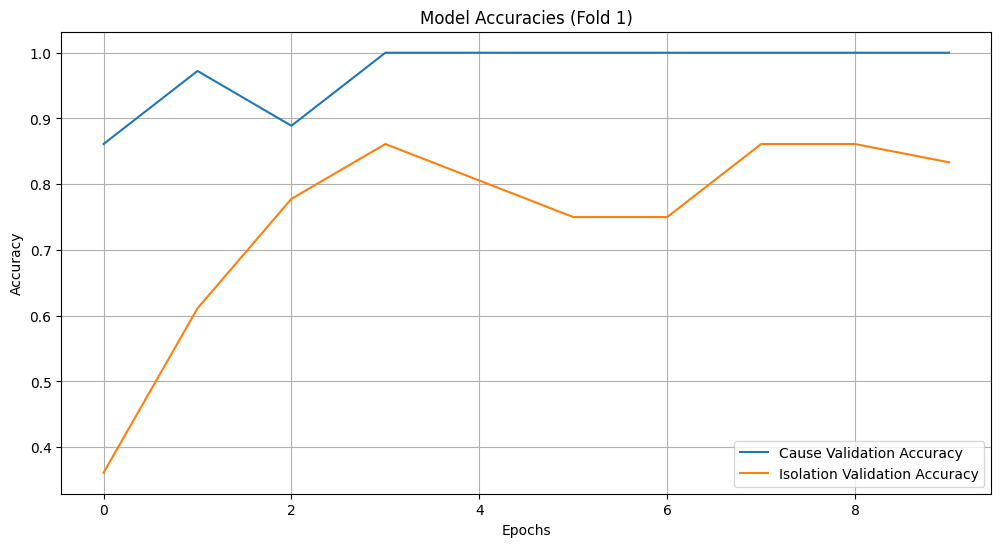

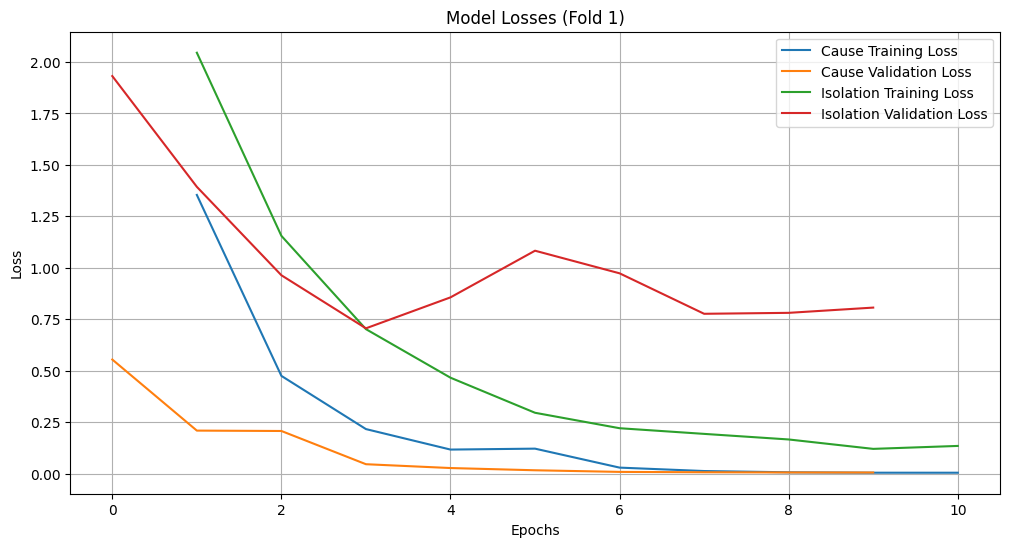


Evaluating models (Fold 1):


100%|██████████| 5/5 [00:00<00:00, 15.19it/s]



Fold 1 Times:
Training time: 0:05:17
Evaluation time: 0:00:00
Total time: 0:05:18

Fold 1 Results:
Cause - Accuracy: 1.0000, Precision: 1.0000, F1: 1.0000
Isolation - Accuracy: 0.8611, Precision: 0.8926, F1: 0.8653


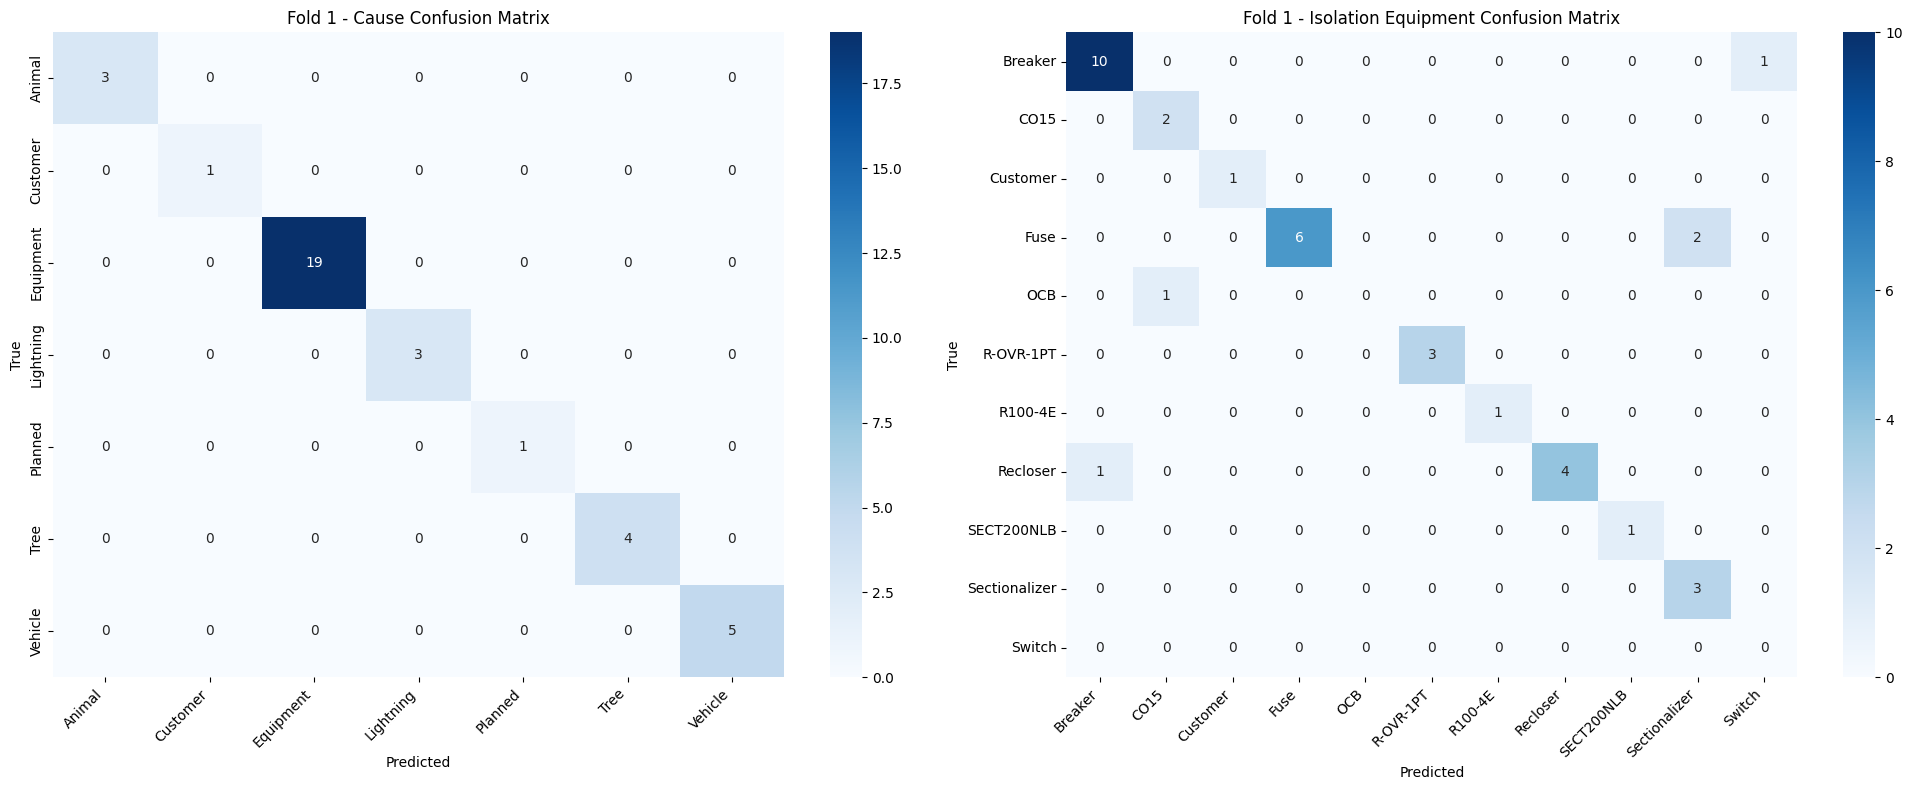


Classification Report - Cause (Fold 1):
              precision    recall  f1-score   support

      Animal       1.00      1.00      1.00         3
    Customer       1.00      1.00      1.00         1
   Equipment       1.00      1.00      1.00        19
   Lightning       1.00      1.00      1.00         3
     Planned       1.00      1.00      1.00         1
        Tree       1.00      1.00      1.00         4
     Vehicle       1.00      1.00      1.00         5

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36

Accuracy - Cause (Fold 1): 1.0000

Classification Report - Isolation Equipment (Fold 1):
               precision    recall  f1-score   support

      Breaker       0.91      0.91      0.91        11
         CO15       0.67      1.00      0.80         2
     Customer       1.00      1.00      1.00         1
         Fuse       1.00      0.75      0.86        

Map: 100%|██████████| 36/36 [00:00<00:00, 4500.19 examples/s]
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at ./distilbert-pq-mlm and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at ./distilbert-pq-mlm and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\rmathew2020\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will

Training Cause Model (Fold 2):


 10%|█         | 18/180 [00:14<01:46,  1.52it/s]

{'loss': 1.5197, 'grad_norm': 9.032689094543457, 'learning_rate': 0.00018, 'epoch': 1.0}



 10%|█         | 18/180 [00:15<01:46,  1.52it/s]

{'eval_loss': 0.8648356199264526, 'eval_accuracy': 0.8333333333333334, 'eval_precision': 0.8306327160493827, 'eval_f1': 0.8143019943019943, 'eval_runtime': 0.4482, 'eval_samples_per_second': 80.317, 'eval_steps_per_second': 11.155, 'epoch': 1.0}


 20%|██        | 36/180 [00:30<01:45,  1.36it/s]

{'loss': 0.4624, 'grad_norm': 7.934127330780029, 'learning_rate': 0.00016, 'epoch': 2.0}



 20%|██        | 36/180 [00:30<01:45,  1.36it/s]

{'eval_loss': 0.36190474033355713, 'eval_accuracy': 0.8611111111111112, 'eval_precision': 0.875, 'eval_f1': 0.8514814814814815, 'eval_runtime': 0.5262, 'eval_samples_per_second': 68.415, 'eval_steps_per_second': 9.502, 'epoch': 2.0}


 30%|███       | 54/180 [00:46<01:36,  1.31it/s]

{'loss': 0.1652, 'grad_norm': 0.4076909124851227, 'learning_rate': 0.00014, 'epoch': 3.0}



 30%|███       | 54/180 [00:46<01:36,  1.31it/s]

{'eval_loss': 0.3441290259361267, 'eval_accuracy': 0.8888888888888888, 'eval_precision': 0.8923611111111112, 'eval_f1': 0.8830484330484331, 'eval_runtime': 0.575, 'eval_samples_per_second': 62.612, 'eval_steps_per_second': 8.696, 'epoch': 3.0}


 40%|████      | 72/180 [01:02<01:21,  1.32it/s]

{'loss': 0.09, 'grad_norm': 0.0704021081328392, 'learning_rate': 0.00012, 'epoch': 4.0}



 40%|████      | 72/180 [01:03<01:21,  1.32it/s]

{'eval_loss': 0.4469005763530731, 'eval_accuracy': 0.8888888888888888, 'eval_precision': 0.8888888888888888, 'eval_f1': 0.8784188034188034, 'eval_runtime': 0.5327, 'eval_samples_per_second': 67.583, 'eval_steps_per_second': 9.386, 'epoch': 4.0}


 50%|█████     | 90/180 [01:18<01:10,  1.29it/s]

{'loss': 0.0869, 'grad_norm': 0.057962074875831604, 'learning_rate': 0.0001, 'epoch': 5.0}



 50%|█████     | 90/180 [01:19<01:10,  1.29it/s]

{'eval_loss': 0.22563692927360535, 'eval_accuracy': 0.9444444444444444, 'eval_precision': 0.9361111111111112, 'eval_f1': 0.9362139917695474, 'eval_runtime': 0.8737, 'eval_samples_per_second': 41.202, 'eval_steps_per_second': 5.722, 'epoch': 5.0}


 60%|██████    | 108/180 [01:34<00:51,  1.40it/s]

{'loss': 0.021, 'grad_norm': 1.1972838640213013, 'learning_rate': 8e-05, 'epoch': 6.0}



 60%|██████    | 108/180 [01:35<00:51,  1.40it/s]

{'eval_loss': 0.4332667589187622, 'eval_accuracy': 0.9166666666666666, 'eval_precision': 0.9212962962962964, 'eval_f1': 0.910826210826211, 'eval_runtime': 0.5237, 'eval_samples_per_second': 68.747, 'eval_steps_per_second': 9.548, 'epoch': 6.0}


 70%|███████   | 126/180 [01:50<00:41,  1.31it/s]

{'loss': 0.0101, 'grad_norm': 0.31867167353630066, 'learning_rate': 6e-05, 'epoch': 7.0}



 70%|███████   | 126/180 [01:50<00:41,  1.31it/s]

{'eval_loss': 0.3709075152873993, 'eval_accuracy': 0.9444444444444444, 'eval_precision': 0.963888888888889, 'eval_f1': 0.9484805318138653, 'eval_runtime': 0.5846, 'eval_samples_per_second': 61.579, 'eval_steps_per_second': 8.553, 'epoch': 7.0}


 80%|████████  | 144/180 [02:05<00:26,  1.34it/s]

{'loss': 0.0067, 'grad_norm': 0.028267493471503258, 'learning_rate': 4e-05, 'epoch': 8.0}



 80%|████████  | 144/180 [02:06<00:26,  1.34it/s]

{'eval_loss': 0.4389904737472534, 'eval_accuracy': 0.9166666666666666, 'eval_precision': 0.9212962962962964, 'eval_f1': 0.910826210826211, 'eval_runtime': 0.5159, 'eval_samples_per_second': 69.778, 'eval_steps_per_second': 9.691, 'epoch': 8.0}


 90%|█████████ | 162/180 [02:21<00:13,  1.36it/s]

{'loss': 0.0053, 'grad_norm': 0.048819009214639664, 'learning_rate': 2e-05, 'epoch': 9.0}



 90%|█████████ | 162/180 [02:22<00:13,  1.36it/s]

{'eval_loss': 0.445043683052063, 'eval_accuracy': 0.9166666666666666, 'eval_precision': 0.9212962962962964, 'eval_f1': 0.910826210826211, 'eval_runtime': 0.6001, 'eval_samples_per_second': 59.993, 'eval_steps_per_second': 8.332, 'epoch': 9.0}


100%|██████████| 180/180 [02:37<00:00,  1.41it/s]

{'loss': 0.0053, 'grad_norm': 0.12015749514102936, 'learning_rate': 0.0, 'epoch': 10.0}



100%|██████████| 180/180 [02:38<00:00,  1.41it/s]

{'eval_loss': 0.4470735192298889, 'eval_accuracy': 0.9166666666666666, 'eval_precision': 0.9212962962962964, 'eval_f1': 0.910826210826211, 'eval_runtime': 0.5339, 'eval_samples_per_second': 67.427, 'eval_steps_per_second': 9.365, 'epoch': 10.0}


100%|██████████| 180/180 [02:39<00:00,  1.13it/s]


{'train_runtime': 159.6904, 'train_samples_per_second': 8.892, 'train_steps_per_second': 1.127, 'train_loss': 0.23725429189701874, 'epoch': 10.0}

Training Isolation Model (Fold 2):


 10%|█         | 18/180 [00:19<02:35,  1.04it/s]

{'loss': 2.0882, 'grad_norm': 6.133776664733887, 'learning_rate': 0.00018, 'epoch': 1.0}



 10%|█         | 18/180 [00:20<02:35,  1.04it/s]

{'eval_loss': 1.161865234375, 'eval_accuracy': 0.6944444444444444, 'eval_precision': 0.49731182795698925, 'eval_f1': 0.5746187363834423, 'eval_runtime': 0.6219, 'eval_samples_per_second': 57.884, 'eval_steps_per_second': 8.04, 'epoch': 1.0}


 20%|██        | 36/180 [00:38<02:02,  1.17it/s]

{'loss': 1.2147, 'grad_norm': 5.764805316925049, 'learning_rate': 0.00016, 'epoch': 2.0}



 20%|██        | 36/180 [00:38<02:02,  1.17it/s]

{'eval_loss': 0.722817599773407, 'eval_accuracy': 0.8055555555555556, 'eval_precision': 0.8388888888888889, 'eval_f1': 0.8087231968810915, 'eval_runtime': 0.6332, 'eval_samples_per_second': 56.851, 'eval_steps_per_second': 7.896, 'epoch': 2.0}


 30%|███       | 54/180 [00:56<01:50,  1.14it/s]

{'loss': 0.6868, 'grad_norm': 15.310126304626465, 'learning_rate': 0.00014, 'epoch': 3.0}



 30%|███       | 54/180 [00:56<01:50,  1.14it/s]

{'eval_loss': 0.5549989342689514, 'eval_accuracy': 0.8333333333333334, 'eval_precision': 0.8888888888888888, 'eval_f1': 0.85224171539961, 'eval_runtime': 0.5625, 'eval_samples_per_second': 63.998, 'eval_steps_per_second': 8.889, 'epoch': 3.0}


 40%|████      | 72/180 [01:14<01:30,  1.19it/s]

{'loss': 0.4706, 'grad_norm': 7.3532328605651855, 'learning_rate': 0.00012, 'epoch': 4.0}



 40%|████      | 72/180 [01:14<01:30,  1.19it/s]

{'eval_loss': 0.512218713760376, 'eval_accuracy': 0.8333333333333334, 'eval_precision': 0.8657407407407408, 'eval_f1': 0.841130604288499, 'eval_runtime': 0.7037, 'eval_samples_per_second': 51.159, 'eval_steps_per_second': 7.105, 'epoch': 4.0}


 50%|█████     | 90/180 [01:34<01:40,  1.12s/it]

{'loss': 0.3797, 'grad_norm': 7.051872253417969, 'learning_rate': 0.0001, 'epoch': 5.0}



 50%|█████     | 90/180 [01:34<01:40,  1.12s/it]

{'eval_loss': 0.5471508502960205, 'eval_accuracy': 0.8055555555555556, 'eval_precision': 0.9444444444444444, 'eval_f1': 0.8567901234567902, 'eval_runtime': 0.5876, 'eval_samples_per_second': 61.262, 'eval_steps_per_second': 8.509, 'epoch': 5.0}


 60%|██████    | 108/180 [01:52<01:01,  1.17it/s]

{'loss': 0.3113, 'grad_norm': 34.735294342041016, 'learning_rate': 8e-05, 'epoch': 6.0}



 60%|██████    | 108/180 [01:53<01:01,  1.17it/s]

{'eval_loss': 0.46510615944862366, 'eval_accuracy': 0.8888888888888888, 'eval_precision': 0.9166666666666666, 'eval_f1': 0.8966861598440546, 'eval_runtime': 0.5823, 'eval_samples_per_second': 61.819, 'eval_steps_per_second': 8.586, 'epoch': 6.0}


 70%|███████   | 126/180 [02:10<00:43,  1.24it/s]

{'loss': 0.2713, 'grad_norm': 6.094850063323975, 'learning_rate': 6e-05, 'epoch': 7.0}



 70%|███████   | 126/180 [02:10<00:43,  1.24it/s]

{'eval_loss': 0.39407289028167725, 'eval_accuracy': 0.8888888888888888, 'eval_precision': 0.9444444444444444, 'eval_f1': 0.9077972709551657, 'eval_runtime': 0.5764, 'eval_samples_per_second': 62.46, 'eval_steps_per_second': 8.675, 'epoch': 7.0}


 80%|████████  | 144/180 [02:27<00:28,  1.25it/s]

{'loss': 0.2147, 'grad_norm': 0.38212594389915466, 'learning_rate': 4e-05, 'epoch': 8.0}



 80%|████████  | 144/180 [02:28<00:28,  1.25it/s]

{'eval_loss': 0.4200114607810974, 'eval_accuracy': 0.8888888888888888, 'eval_precision': 0.9388888888888888, 'eval_f1': 0.9025062656641604, 'eval_runtime': 0.5333, 'eval_samples_per_second': 67.502, 'eval_steps_per_second': 9.375, 'epoch': 8.0}


 90%|█████████ | 162/180 [02:45<00:15,  1.16it/s]

{'loss': 0.1948, 'grad_norm': 0.4069647192955017, 'learning_rate': 2e-05, 'epoch': 9.0}



 90%|█████████ | 162/180 [02:46<00:15,  1.16it/s]

{'eval_loss': 0.4221528470516205, 'eval_accuracy': 0.8888888888888888, 'eval_precision': 0.9388888888888888, 'eval_f1': 0.9025062656641604, 'eval_runtime': 0.6488, 'eval_samples_per_second': 55.486, 'eval_steps_per_second': 7.706, 'epoch': 9.0}


100%|██████████| 180/180 [03:03<00:00,  1.39it/s]

{'loss': 0.1987, 'grad_norm': 0.15097348392009735, 'learning_rate': 0.0, 'epoch': 10.0}



100%|██████████| 180/180 [03:04<00:00,  1.39it/s]

{'eval_loss': 0.4178987741470337, 'eval_accuracy': 0.8888888888888888, 'eval_precision': 0.9388888888888888, 'eval_f1': 0.9025062656641604, 'eval_runtime': 0.5258, 'eval_samples_per_second': 68.473, 'eval_steps_per_second': 9.51, 'epoch': 10.0}


100%|██████████| 180/180 [03:05<00:00,  1.03s/it]

{'train_runtime': 185.6666, 'train_samples_per_second': 7.648, 'train_steps_per_second': 0.969, 'train_loss': 0.6030799044503106, 'epoch': 10.0}


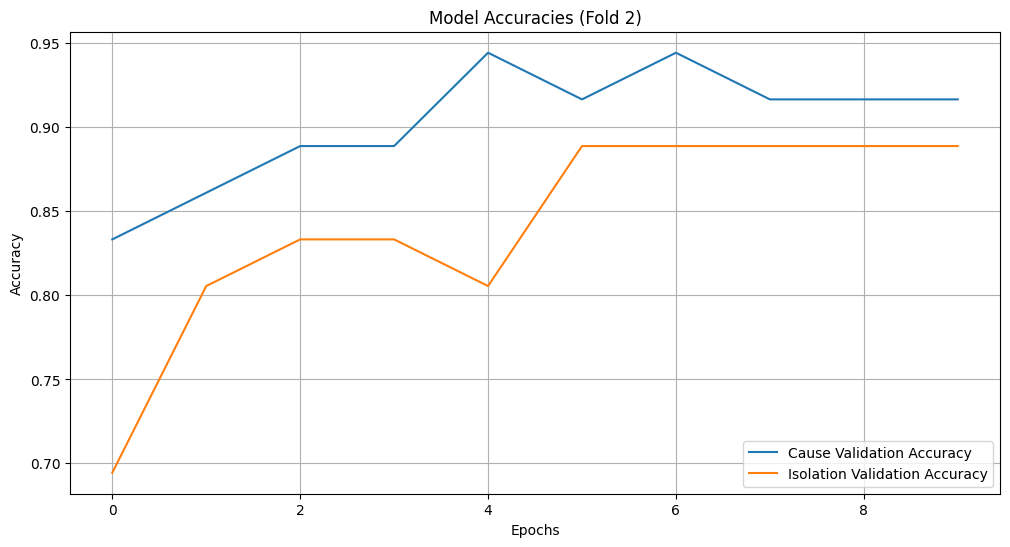

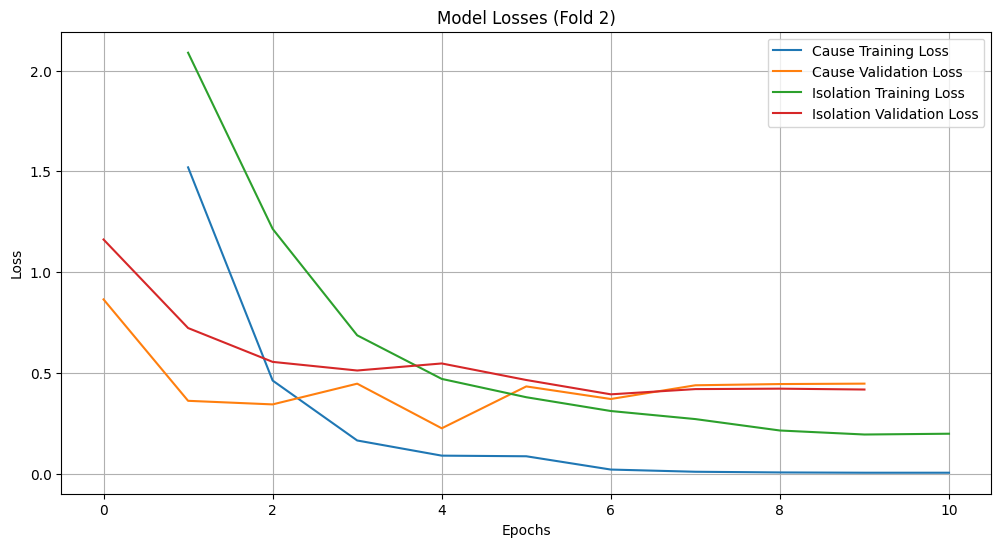


Evaluating models (Fold 2):


100%|██████████| 5/5 [00:00<00:00, 15.44it/s]



Fold 2 Times:
Training time: 0:05:46
Evaluation time: 0:00:00
Total time: 0:05:47

Fold 2 Results:
Cause - Accuracy: 0.9444, Precision: 0.9361, F1: 0.9362
Isolation - Accuracy: 0.8889, Precision: 0.9444, F1: 0.9078


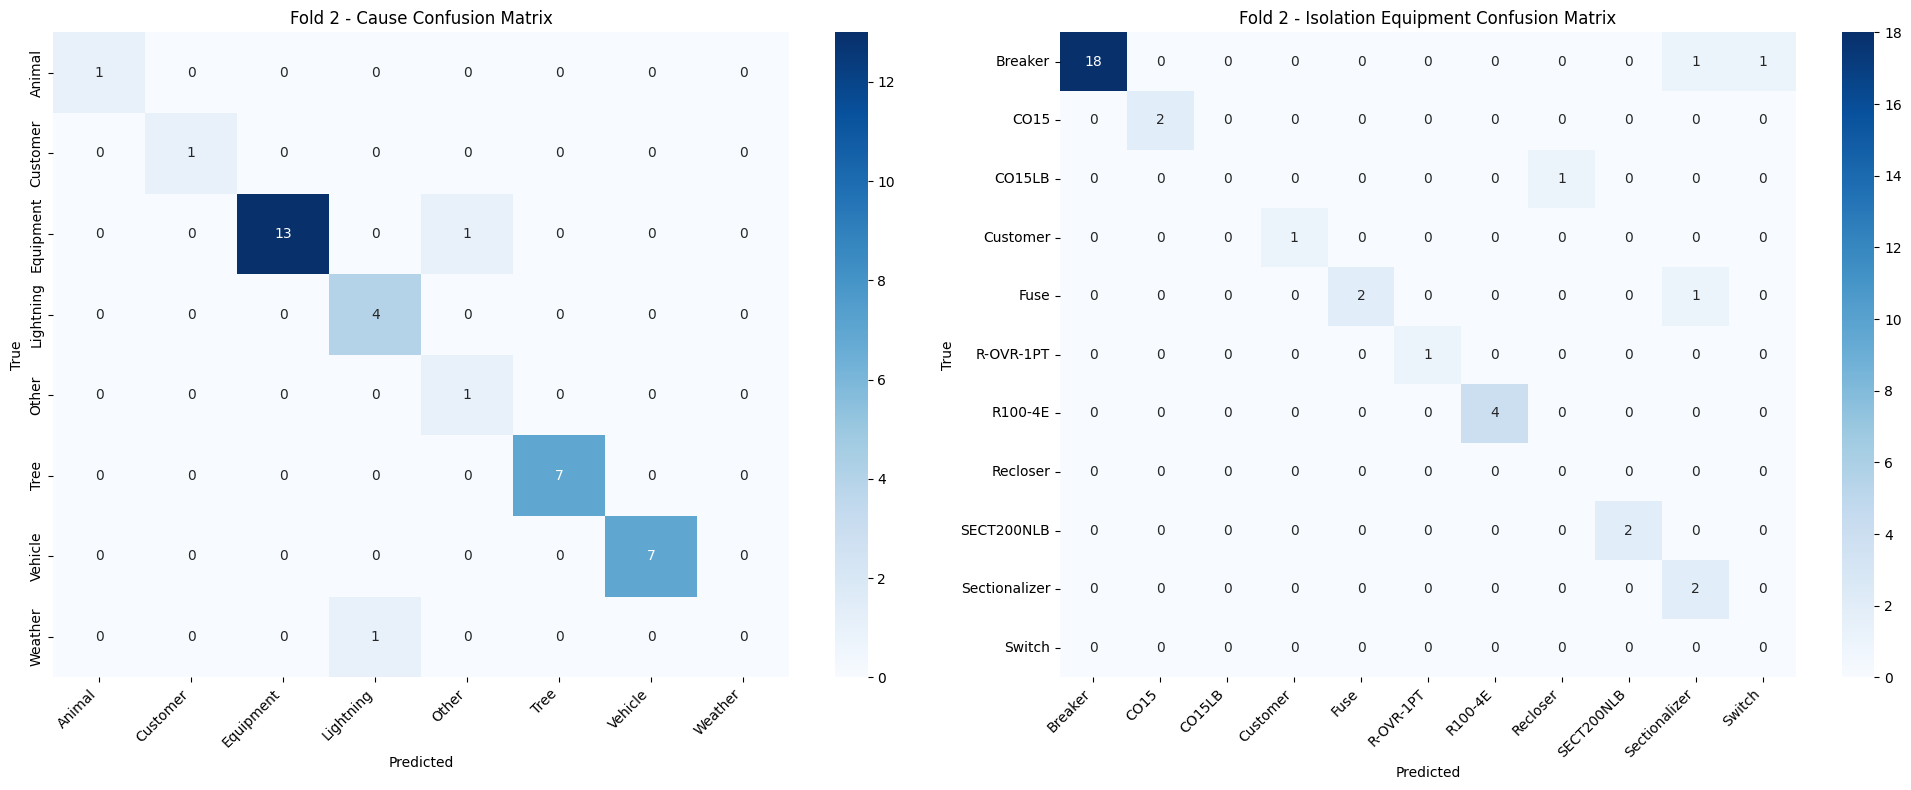


Classification Report - Cause (Fold 2):
              precision    recall  f1-score   support

      Animal       1.00      1.00      1.00         1
    Customer       1.00      1.00      1.00         1
   Equipment       1.00      0.93      0.96        14
   Lightning       0.80      1.00      0.89         4
       Other       0.50      1.00      0.67         1
        Tree       1.00      1.00      1.00         7
     Vehicle       1.00      1.00      1.00         7
     Weather       0.00      0.00      0.00         1

    accuracy                           0.94        36
   macro avg       0.79      0.87      0.81        36
weighted avg       0.94      0.94      0.94        36

Accuracy - Cause (Fold 2): 0.9444

Classification Report - Isolation Equipment (Fold 2):
               precision    recall  f1-score   support

      Breaker       1.00      0.90      0.95        20
         CO15       1.00      1.00      1.00         2
       CO15LB       0.00      0.00      0.00         

Map: 100%|██████████| 36/36 [00:00<00:00, 5143.76 examples/s]
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at ./distilbert-pq-mlm and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at ./distilbert-pq-mlm and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\rmathew2020\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will

Training Cause Model (Fold 3):


 10%|█         | 18/180 [00:14<01:55,  1.41it/s]

{'loss': 1.4766, 'grad_norm': 4.8805060386657715, 'learning_rate': 0.00018, 'epoch': 1.0}



 10%|█         | 18/180 [00:15<01:55,  1.41it/s]

{'eval_loss': 0.7531285881996155, 'eval_accuracy': 0.7777777777777778, 'eval_precision': 0.7350288600288599, 'eval_f1': 0.7444086598675971, 'eval_runtime': 0.4871, 'eval_samples_per_second': 73.914, 'eval_steps_per_second': 10.266, 'epoch': 1.0}


 20%|██        | 36/180 [00:29<01:42,  1.40it/s]

{'loss': 0.4394, 'grad_norm': 6.472646713256836, 'learning_rate': 0.00016, 'epoch': 2.0}



 20%|██        | 36/180 [00:30<01:42,  1.40it/s]

{'eval_loss': 0.25211793184280396, 'eval_accuracy': 0.9166666666666666, 'eval_precision': 0.8632478632478633, 'eval_f1': 0.8848148148148148, 'eval_runtime': 0.457, 'eval_samples_per_second': 78.782, 'eval_steps_per_second': 10.942, 'epoch': 2.0}


 30%|███       | 54/180 [00:44<01:27,  1.43it/s]

{'loss': 0.188, 'grad_norm': 0.06869887560606003, 'learning_rate': 0.00014, 'epoch': 3.0}



 30%|███       | 54/180 [00:45<01:27,  1.43it/s]

{'eval_loss': 0.25657138228416443, 'eval_accuracy': 0.9166666666666666, 'eval_precision': 0.8908730158730158, 'eval_f1': 0.8980586867060296, 'eval_runtime': 0.5056, 'eval_samples_per_second': 71.2, 'eval_steps_per_second': 9.889, 'epoch': 3.0}


 40%|████      | 72/180 [00:59<01:18,  1.37it/s]

{'loss': 0.0871, 'grad_norm': 0.05457349494099617, 'learning_rate': 0.00012, 'epoch': 4.0}



 40%|████      | 72/180 [01:00<01:18,  1.37it/s]

{'eval_loss': 0.1082286387681961, 'eval_accuracy': 0.9722222222222222, 'eval_precision': 0.9583333333333334, 'eval_f1': 0.9629629629629631, 'eval_runtime': 0.5179, 'eval_samples_per_second': 69.516, 'eval_steps_per_second': 9.655, 'epoch': 4.0}


 50%|█████     | 90/180 [01:14<01:03,  1.42it/s]

{'loss': 0.0394, 'grad_norm': 0.07061170786619186, 'learning_rate': 0.0001, 'epoch': 5.0}



 50%|█████     | 90/180 [01:15<01:03,  1.42it/s]

{'eval_loss': 0.05599062144756317, 'eval_accuracy': 1.0, 'eval_precision': 1.0, 'eval_f1': 1.0, 'eval_runtime': 0.4839, 'eval_samples_per_second': 74.4, 'eval_steps_per_second': 10.333, 'epoch': 5.0}


 60%|██████    | 108/180 [01:29<00:50,  1.42it/s]

{'loss': 0.0234, 'grad_norm': 0.04963028430938721, 'learning_rate': 8e-05, 'epoch': 6.0}



 60%|██████    | 108/180 [01:30<00:50,  1.42it/s]

{'eval_loss': 0.02285211905837059, 'eval_accuracy': 1.0, 'eval_precision': 1.0, 'eval_f1': 1.0, 'eval_runtime': 0.5168, 'eval_samples_per_second': 69.66, 'eval_steps_per_second': 9.675, 'epoch': 6.0}


 70%|███████   | 126/180 [01:44<00:37,  1.44it/s]

{'loss': 0.0105, 'grad_norm': 0.08545979857444763, 'learning_rate': 6e-05, 'epoch': 7.0}



 70%|███████   | 126/180 [01:45<00:37,  1.44it/s]

{'eval_loss': 0.014159058220684528, 'eval_accuracy': 1.0, 'eval_precision': 1.0, 'eval_f1': 1.0, 'eval_runtime': 0.5605, 'eval_samples_per_second': 64.228, 'eval_steps_per_second': 8.921, 'epoch': 7.0}


 80%|████████  | 144/180 [01:59<00:25,  1.43it/s]

{'loss': 0.0071, 'grad_norm': 0.03876420110464096, 'learning_rate': 4e-05, 'epoch': 8.0}



 80%|████████  | 144/180 [02:00<00:25,  1.43it/s]

{'eval_loss': 0.00863412395119667, 'eval_accuracy': 1.0, 'eval_precision': 1.0, 'eval_f1': 1.0, 'eval_runtime': 0.4905, 'eval_samples_per_second': 73.4, 'eval_steps_per_second': 10.194, 'epoch': 8.0}


 90%|█████████ | 162/180 [02:14<00:12,  1.42it/s]

{'loss': 0.0054, 'grad_norm': 0.07113911211490631, 'learning_rate': 2e-05, 'epoch': 9.0}



 90%|█████████ | 162/180 [02:15<00:12,  1.42it/s]

{'eval_loss': 0.0075567010790109634, 'eval_accuracy': 1.0, 'eval_precision': 1.0, 'eval_f1': 1.0, 'eval_runtime': 0.5632, 'eval_samples_per_second': 63.919, 'eval_steps_per_second': 8.878, 'epoch': 9.0}


100%|██████████| 180/180 [02:30<00:00,  1.42it/s]

{'loss': 0.005, 'grad_norm': 0.08606653660535812, 'learning_rate': 0.0, 'epoch': 10.0}



100%|██████████| 180/180 [02:31<00:00,  1.42it/s]

{'eval_loss': 0.007054378744214773, 'eval_accuracy': 1.0, 'eval_precision': 1.0, 'eval_f1': 1.0, 'eval_runtime': 0.7399, 'eval_samples_per_second': 48.658, 'eval_steps_per_second': 6.758, 'epoch': 10.0}


100%|██████████| 180/180 [02:32<00:00,  1.18it/s]


{'train_runtime': 152.4869, 'train_samples_per_second': 9.312, 'train_steps_per_second': 1.18, 'train_loss': 0.22818800728354188, 'epoch': 10.0}

Training Isolation Model (Fold 3):


 10%|█         | 18/180 [00:15<01:55,  1.40it/s]

{'loss': 2.1178, 'grad_norm': 6.503794193267822, 'learning_rate': 0.00018, 'epoch': 1.0}



 10%|█         | 18/180 [00:16<01:55,  1.40it/s]

{'eval_loss': 1.3329999446868896, 'eval_accuracy': 0.6388888888888888, 'eval_precision': 0.4428277483833039, 'eval_f1': 0.5162372517444981, 'eval_runtime': 0.5187, 'eval_samples_per_second': 69.402, 'eval_steps_per_second': 9.639, 'epoch': 1.0}


 20%|██        | 36/180 [00:31<01:56,  1.23it/s]

{'loss': 1.2874, 'grad_norm': 4.77073860168457, 'learning_rate': 0.00016, 'epoch': 2.0}



 20%|██        | 36/180 [00:32<01:56,  1.23it/s]

{'eval_loss': 0.8366501927375793, 'eval_accuracy': 0.8333333333333334, 'eval_precision': 0.8344907407407407, 'eval_f1': 0.8009761699684181, 'eval_runtime': 0.7366, 'eval_samples_per_second': 48.872, 'eval_steps_per_second': 6.788, 'epoch': 2.0}


 30%|███       | 54/180 [00:48<01:36,  1.30it/s]

{'loss': 0.8106, 'grad_norm': 6.716381549835205, 'learning_rate': 0.00014, 'epoch': 3.0}



 30%|███       | 54/180 [00:49<01:36,  1.30it/s]

{'eval_loss': 0.4933963418006897, 'eval_accuracy': 0.9166666666666666, 'eval_precision': 0.9675925925925927, 'eval_f1': 0.9263888888888889, 'eval_runtime': 0.5207, 'eval_samples_per_second': 69.135, 'eval_steps_per_second': 9.602, 'epoch': 3.0}


 40%|████      | 72/180 [01:03<01:17,  1.39it/s]

{'loss': 0.532, 'grad_norm': 3.9004547595977783, 'learning_rate': 0.00012, 'epoch': 4.0}



 40%|████      | 72/180 [01:04<01:17,  1.39it/s]

{'eval_loss': 0.43005964159965515, 'eval_accuracy': 0.8888888888888888, 'eval_precision': 0.9333333333333333, 'eval_f1': 0.8969017094017094, 'eval_runtime': 0.4807, 'eval_samples_per_second': 74.892, 'eval_steps_per_second': 10.402, 'epoch': 4.0}


 50%|█████     | 90/180 [01:20<01:05,  1.38it/s]

{'loss': 0.448, 'grad_norm': 1.734236240386963, 'learning_rate': 0.0001, 'epoch': 5.0}



 50%|█████     | 90/180 [01:21<01:05,  1.38it/s]

{'eval_loss': 0.37361663579940796, 'eval_accuracy': 0.9166666666666666, 'eval_precision': 0.9537037037037037, 'eval_f1': 0.9263888888888889, 'eval_runtime': 0.5109, 'eval_samples_per_second': 70.463, 'eval_steps_per_second': 9.787, 'epoch': 5.0}


 60%|██████    | 108/180 [01:39<01:08,  1.06it/s]

{'loss': 0.3295, 'grad_norm': 11.914113998413086, 'learning_rate': 8e-05, 'epoch': 6.0}



 60%|██████    | 108/180 [01:40<01:08,  1.06it/s]

{'eval_loss': 0.3233308792114258, 'eval_accuracy': 0.8888888888888888, 'eval_precision': 0.9675925925925924, 'eval_f1': 0.9155864197530863, 'eval_runtime': 0.536, 'eval_samples_per_second': 67.167, 'eval_steps_per_second': 9.329, 'epoch': 6.0}


 70%|███████   | 126/180 [01:57<00:43,  1.26it/s]

{'loss': 0.2412, 'grad_norm': 0.6530905961990356, 'learning_rate': 6e-05, 'epoch': 7.0}



 70%|███████   | 126/180 [01:58<00:43,  1.26it/s]

{'eval_loss': 0.22636264562606812, 'eval_accuracy': 0.9166666666666666, 'eval_precision': 1.0, 'eval_f1': 0.9510135135135135, 'eval_runtime': 0.5125, 'eval_samples_per_second': 70.239, 'eval_steps_per_second': 9.755, 'epoch': 7.0}


 80%|████████  | 144/180 [02:14<00:26,  1.35it/s]

{'loss': 0.2087, 'grad_norm': 4.552579879760742, 'learning_rate': 4e-05, 'epoch': 8.0}



 80%|████████  | 144/180 [02:14<00:26,  1.35it/s]

{'eval_loss': 0.29854774475097656, 'eval_accuracy': 0.8888888888888888, 'eval_precision': 0.9814814814814814, 'eval_f1': 0.9248456790123457, 'eval_runtime': 0.4946, 'eval_samples_per_second': 72.786, 'eval_steps_per_second': 10.109, 'epoch': 8.0}


 90%|█████████ | 162/180 [02:29<00:12,  1.40it/s]

{'loss': 0.1881, 'grad_norm': 2.238267183303833, 'learning_rate': 2e-05, 'epoch': 9.0}



 90%|█████████ | 162/180 [02:30<00:12,  1.40it/s]

{'eval_loss': 0.2754058539867401, 'eval_accuracy': 0.8888888888888888, 'eval_precision': 0.9814814814814814, 'eval_f1': 0.9248456790123457, 'eval_runtime': 0.4975, 'eval_samples_per_second': 72.363, 'eval_steps_per_second': 10.05, 'epoch': 9.0}


100%|██████████| 180/180 [02:45<00:00,  1.38it/s]

{'loss': 0.1688, 'grad_norm': 0.1623435914516449, 'learning_rate': 0.0, 'epoch': 10.0}



100%|██████████| 180/180 [02:46<00:00,  1.38it/s]

{'eval_loss': 0.27790403366088867, 'eval_accuracy': 0.8888888888888888, 'eval_precision': 0.9814814814814814, 'eval_f1': 0.9248456790123457, 'eval_runtime': 0.5469, 'eval_samples_per_second': 65.83, 'eval_steps_per_second': 9.143, 'epoch': 10.0}


100%|██████████| 180/180 [02:47<00:00,  1.08it/s]

{'train_runtime': 167.3999, 'train_samples_per_second': 8.483, 'train_steps_per_second': 1.075, 'train_loss': 0.6332152393129137, 'epoch': 10.0}


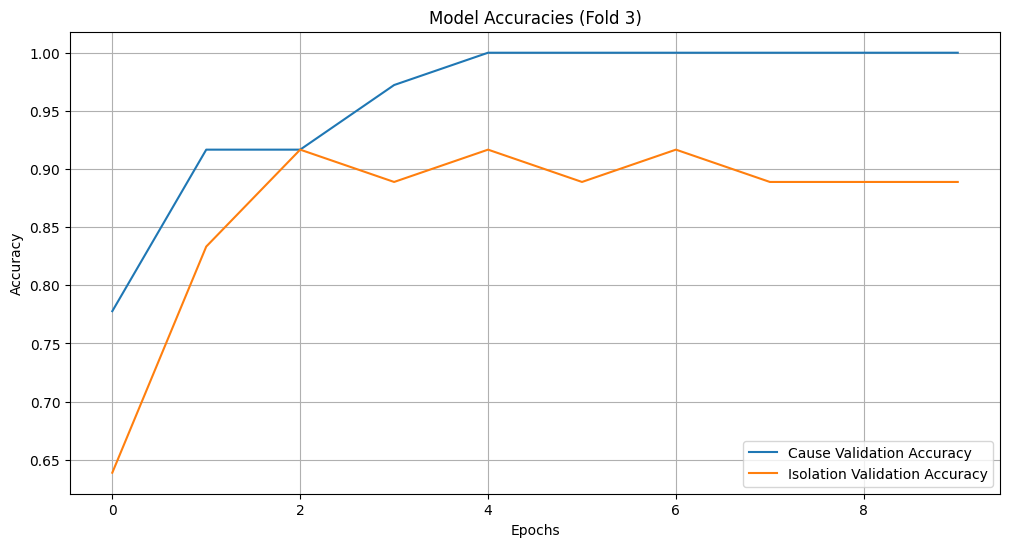

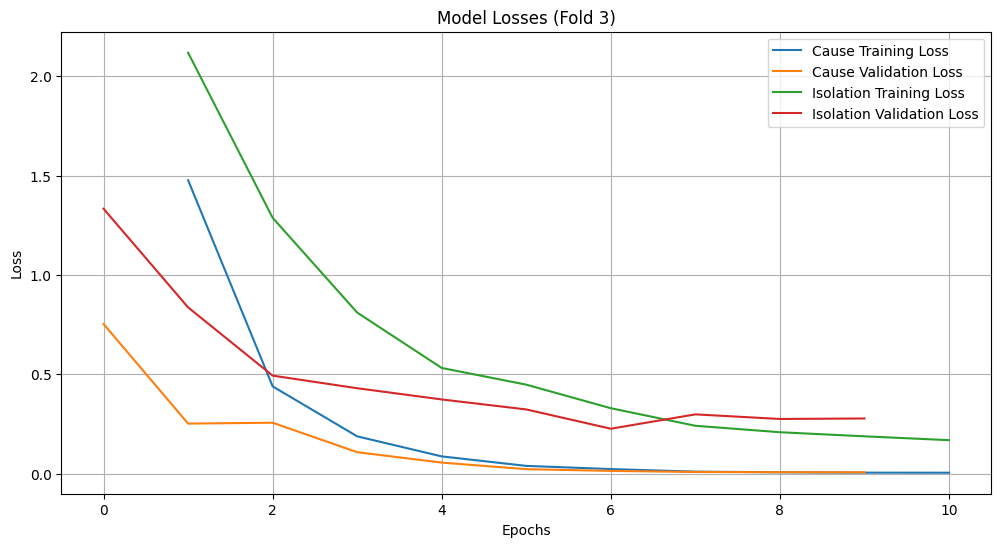


Evaluating models (Fold 3):


100%|██████████| 5/5 [00:00<00:00, 13.33it/s]



Fold 3 Times:
Training time: 0:05:20
Evaluation time: 0:00:00
Total time: 0:05:21

Fold 3 Results:
Cause - Accuracy: 1.0000, Precision: 1.0000, F1: 1.0000
Isolation - Accuracy: 0.9167, Precision: 1.0000, F1: 0.9510


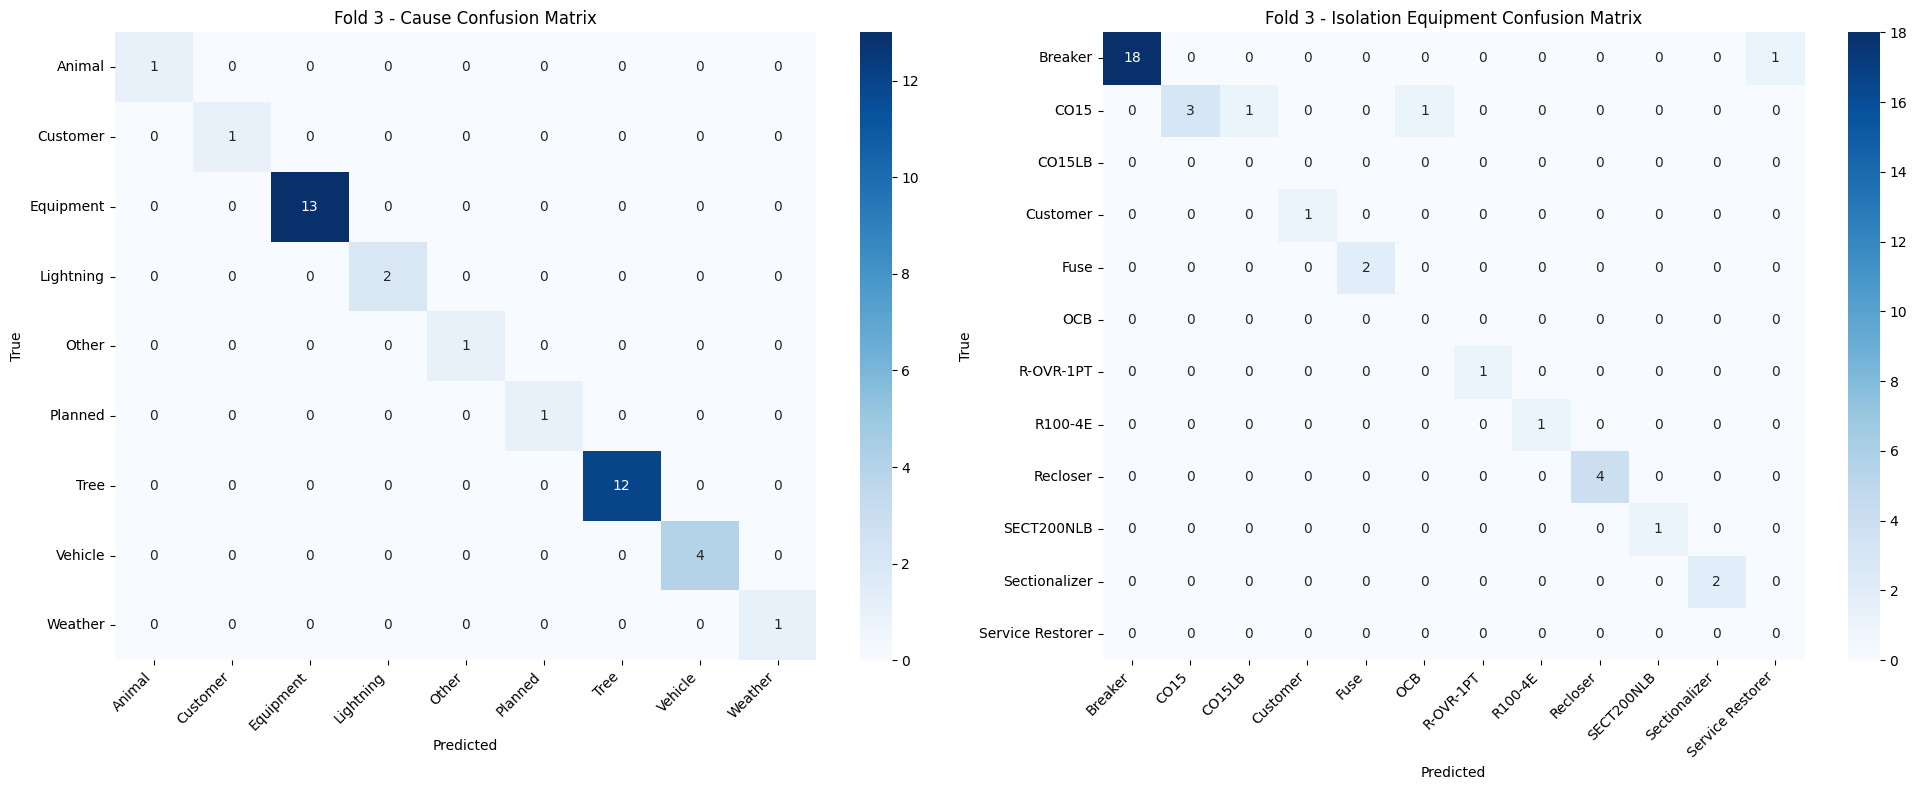


Classification Report - Cause (Fold 3):
              precision    recall  f1-score   support

      Animal       1.00      1.00      1.00         1
    Customer       1.00      1.00      1.00         1
   Equipment       1.00      1.00      1.00        13
   Lightning       1.00      1.00      1.00         2
       Other       1.00      1.00      1.00         1
     Planned       1.00      1.00      1.00         1
        Tree       1.00      1.00      1.00        12
     Vehicle       1.00      1.00      1.00         4
     Weather       1.00      1.00      1.00         1

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36

Accuracy - Cause (Fold 3): 1.0000

Classification Report - Isolation Equipment (Fold 3):
                  precision    recall  f1-score   support

         Breaker       1.00      0.95      0.97        19
            CO15       1.00      0.60      0.75 

Map: 100%|██████████| 35/35 [00:00<00:00, 13572.54 examples/s]
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at ./distilbert-pq-mlm and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at ./distilbert-pq-mlm and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\rmathew2020\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and wil

Training Cause Model (Fold 4):


 10%|█         | 18/180 [00:15<01:58,  1.36it/s]

{'loss': 1.3551, 'grad_norm': 5.216475486755371, 'learning_rate': 0.00018, 'epoch': 1.0}



 10%|█         | 18/180 [00:15<01:58,  1.36it/s]

{'eval_loss': 0.713275671005249, 'eval_accuracy': 0.8571428571428571, 'eval_precision': 0.7978896103896104, 'eval_f1': 0.8158620689655172, 'eval_runtime': 0.4687, 'eval_samples_per_second': 74.668, 'eval_steps_per_second': 10.667, 'epoch': 1.0}


 20%|██        | 36/180 [00:30<01:40,  1.43it/s]

{'loss': 0.3396, 'grad_norm': 1.3781532049179077, 'learning_rate': 0.00016, 'epoch': 2.0}



 20%|██        | 36/180 [00:30<01:40,  1.43it/s]

{'eval_loss': 0.6273187398910522, 'eval_accuracy': 0.9142857142857143, 'eval_precision': 0.8732142857142857, 'eval_f1': 0.8888490819525302, 'eval_runtime': 0.4475, 'eval_samples_per_second': 78.211, 'eval_steps_per_second': 11.173, 'epoch': 2.0}


 30%|███       | 54/180 [00:50<01:51,  1.13it/s]

{'loss': 0.1738, 'grad_norm': 0.8285753726959229, 'learning_rate': 0.00014, 'epoch': 3.0}



 30%|███       | 54/180 [00:50<01:51,  1.13it/s]

{'eval_loss': 0.4327951967716217, 'eval_accuracy': 0.9142857142857143, 'eval_precision': 0.8714285714285714, 'eval_f1': 0.889795918367347, 'eval_runtime': 0.4939, 'eval_samples_per_second': 70.87, 'eval_steps_per_second': 10.124, 'epoch': 3.0}


 40%|████      | 72/180 [01:06<01:21,  1.33it/s]

{'loss': 0.0551, 'grad_norm': 0.06287100166082382, 'learning_rate': 0.00012, 'epoch': 4.0}



 40%|████      | 72/180 [01:07<01:21,  1.33it/s]

{'eval_loss': 0.4145355224609375, 'eval_accuracy': 0.9428571428571428, 'eval_precision': 0.8918367346938776, 'eval_f1': 0.9159137159137157, 'eval_runtime': 0.5919, 'eval_samples_per_second': 59.133, 'eval_steps_per_second': 8.448, 'epoch': 4.0}


 50%|█████     | 90/180 [01:26<01:23,  1.08it/s]

{'loss': 0.018, 'grad_norm': 1.0238784551620483, 'learning_rate': 0.0001, 'epoch': 5.0}



 50%|█████     | 90/180 [01:27<01:23,  1.08it/s]

{'eval_loss': 0.3939078748226166, 'eval_accuracy': 0.9142857142857143, 'eval_precision': 0.8714285714285714, 'eval_f1': 0.889795918367347, 'eval_runtime': 0.6431, 'eval_samples_per_second': 54.427, 'eval_steps_per_second': 7.775, 'epoch': 5.0}


 60%|██████    | 108/180 [01:43<00:57,  1.25it/s]

{'loss': 0.0058, 'grad_norm': 0.01567748561501503, 'learning_rate': 8e-05, 'epoch': 6.0}



 60%|██████    | 108/180 [01:43<00:57,  1.25it/s]

{'eval_loss': 0.4418789744377136, 'eval_accuracy': 0.9428571428571428, 'eval_precision': 0.8918367346938776, 'eval_f1': 0.9159137159137157, 'eval_runtime': 0.5744, 'eval_samples_per_second': 60.936, 'eval_steps_per_second': 8.705, 'epoch': 6.0}


 70%|███████   | 126/180 [01:58<00:39,  1.36it/s]

{'loss': 0.0049, 'grad_norm': 0.11637313663959503, 'learning_rate': 6e-05, 'epoch': 7.0}



 70%|███████   | 126/180 [01:59<00:39,  1.36it/s]

{'eval_loss': 0.44960835576057434, 'eval_accuracy': 0.9428571428571428, 'eval_precision': 0.8918367346938776, 'eval_f1': 0.9159137159137157, 'eval_runtime': 0.5086, 'eval_samples_per_second': 68.81, 'eval_steps_per_second': 9.83, 'epoch': 7.0}


 80%|████████  | 144/180 [02:15<00:25,  1.41it/s]

{'loss': 0.0035, 'grad_norm': 0.018282368779182434, 'learning_rate': 4e-05, 'epoch': 8.0}



 80%|████████  | 144/180 [02:16<00:25,  1.41it/s]

{'eval_loss': 0.45283523201942444, 'eval_accuracy': 0.9428571428571428, 'eval_precision': 0.8918367346938776, 'eval_f1': 0.9159137159137157, 'eval_runtime': 0.497, 'eval_samples_per_second': 70.429, 'eval_steps_per_second': 10.061, 'epoch': 8.0}


 90%|█████████ | 162/180 [02:32<00:14,  1.28it/s]

{'loss': 0.0033, 'grad_norm': 0.01868581399321556, 'learning_rate': 2e-05, 'epoch': 9.0}



 90%|█████████ | 162/180 [02:33<00:14,  1.28it/s]

{'eval_loss': 0.4552251100540161, 'eval_accuracy': 0.9428571428571428, 'eval_precision': 0.8918367346938776, 'eval_f1': 0.9159137159137157, 'eval_runtime': 0.5658, 'eval_samples_per_second': 61.855, 'eval_steps_per_second': 8.836, 'epoch': 9.0}


100%|██████████| 180/180 [02:51<00:00,  1.25it/s]

{'loss': 0.0033, 'grad_norm': 0.12305758893489838, 'learning_rate': 0.0, 'epoch': 10.0}



100%|██████████| 180/180 [02:53<00:00,  1.25it/s]

{'eval_loss': 0.45616835355758667, 'eval_accuracy': 0.9428571428571428, 'eval_precision': 0.8918367346938776, 'eval_f1': 0.9159137159137157, 'eval_runtime': 1.5406, 'eval_samples_per_second': 22.718, 'eval_steps_per_second': 3.245, 'epoch': 10.0}


100%|██████████| 180/180 [02:54<00:00,  1.03it/s]


{'train_runtime': 174.6587, 'train_samples_per_second': 8.187, 'train_steps_per_second': 1.031, 'train_loss': 0.19623614986323648, 'epoch': 10.0}

Training Isolation Model (Fold 4):


 10%|█         | 18/180 [00:15<01:54,  1.41it/s]

{'loss': 1.9927, 'grad_norm': 6.281060695648193, 'learning_rate': 0.00018, 'epoch': 1.0}



 10%|█         | 18/180 [00:16<01:54,  1.41it/s]

{'eval_loss': 1.690777063369751, 'eval_accuracy': 0.42857142857142855, 'eval_precision': 0.24185714285714285, 'eval_f1': 0.2796330653473511, 'eval_runtime': 0.4505, 'eval_samples_per_second': 77.698, 'eval_steps_per_second': 11.1, 'epoch': 1.0}


 20%|██        | 36/180 [00:31<01:42,  1.40it/s]

{'loss': 1.0977, 'grad_norm': 4.477169036865234, 'learning_rate': 0.00016, 'epoch': 2.0}



 20%|██        | 36/180 [00:31<01:42,  1.40it/s]

{'eval_loss': 1.083532691001892, 'eval_accuracy': 0.6571428571428571, 'eval_precision': 0.5051870748299319, 'eval_f1': 0.5599807599807599, 'eval_runtime': 0.4625, 'eval_samples_per_second': 75.681, 'eval_steps_per_second': 10.812, 'epoch': 2.0}


 30%|███       | 54/180 [00:46<01:35,  1.32it/s]

{'loss': 0.6532, 'grad_norm': 3.175302743911743, 'learning_rate': 0.00014, 'epoch': 3.0}



 30%|███       | 54/180 [00:47<01:35,  1.32it/s]

{'eval_loss': 0.7665331959724426, 'eval_accuracy': 0.8, 'eval_precision': 0.8173626373626374, 'eval_f1': 0.7625850340136054, 'eval_runtime': 0.4618, 'eval_samples_per_second': 75.788, 'eval_steps_per_second': 10.827, 'epoch': 3.0}


 40%|████      | 72/180 [01:02<01:18,  1.37it/s]

{'loss': 0.4502, 'grad_norm': 4.933396816253662, 'learning_rate': 0.00012, 'epoch': 4.0}



 40%|████      | 72/180 [01:02<01:18,  1.37it/s]

{'eval_loss': 0.8220089077949524, 'eval_accuracy': 0.7714285714285715, 'eval_precision': 0.7350340136054422, 'eval_f1': 0.7310797773654916, 'eval_runtime': 0.4472, 'eval_samples_per_second': 78.256, 'eval_steps_per_second': 11.179, 'epoch': 4.0}


 50%|█████     | 90/180 [01:17<01:07,  1.34it/s]

{'loss': 0.361, 'grad_norm': 4.406343460083008, 'learning_rate': 0.0001, 'epoch': 5.0}



 50%|█████     | 90/180 [01:18<01:07,  1.34it/s]

{'eval_loss': 0.6838455200195312, 'eval_accuracy': 0.8285714285714286, 'eval_precision': 0.819795918367347, 'eval_f1': 0.7928979591836735, 'eval_runtime': 0.5714, 'eval_samples_per_second': 61.249, 'eval_steps_per_second': 8.75, 'epoch': 5.0}


 60%|██████    | 108/180 [01:33<00:52,  1.38it/s]

{'loss': 0.2961, 'grad_norm': 4.851594924926758, 'learning_rate': 8e-05, 'epoch': 6.0}



 60%|██████    | 108/180 [01:33<00:52,  1.38it/s]

{'eval_loss': 0.536531388759613, 'eval_accuracy': 0.8571428571428571, 'eval_precision': 0.8959340659340659, 'eval_f1': 0.842517006802721, 'eval_runtime': 0.4631, 'eval_samples_per_second': 75.585, 'eval_steps_per_second': 10.798, 'epoch': 6.0}


 70%|███████   | 126/180 [01:48<00:38,  1.41it/s]

{'loss': 0.2469, 'grad_norm': 4.018205165863037, 'learning_rate': 6e-05, 'epoch': 7.0}



 70%|███████   | 126/180 [01:48<00:38,  1.41it/s]

{'eval_loss': 0.607587456703186, 'eval_accuracy': 0.8285714285714286, 'eval_precision': 0.8247619047619048, 'eval_f1': 0.7945054945054945, 'eval_runtime': 0.4428, 'eval_samples_per_second': 79.039, 'eval_steps_per_second': 11.291, 'epoch': 7.0}


 80%|████████  | 144/180 [02:05<00:40,  1.13s/it]

{'loss': 0.2043, 'grad_norm': 0.09573063254356384, 'learning_rate': 4e-05, 'epoch': 8.0}



 80%|████████  | 144/180 [02:06<00:40,  1.13s/it]

{'eval_loss': 0.5864636301994324, 'eval_accuracy': 0.8285714285714286, 'eval_precision': 0.8247619047619048, 'eval_f1': 0.7945054945054945, 'eval_runtime': 1.1367, 'eval_samples_per_second': 30.79, 'eval_steps_per_second': 4.399, 'epoch': 8.0}


 90%|█████████ | 162/180 [02:22<00:13,  1.38it/s]

{'loss': 0.2045, 'grad_norm': 4.014232158660889, 'learning_rate': 2e-05, 'epoch': 9.0}



 90%|█████████ | 162/180 [02:23<00:13,  1.38it/s]

{'eval_loss': 0.7395872473716736, 'eval_accuracy': 0.8, 'eval_precision': 0.8103571428571429, 'eval_f1': 0.7675132275132275, 'eval_runtime': 0.4844, 'eval_samples_per_second': 72.259, 'eval_steps_per_second': 10.323, 'epoch': 9.0}


100%|██████████| 180/180 [02:41<00:00,  1.18it/s]

{'loss': 0.1781, 'grad_norm': 0.7023330926895142, 'learning_rate': 0.0, 'epoch': 10.0}



100%|██████████| 180/180 [02:42<00:00,  1.18it/s]

{'eval_loss': 0.6729548573493958, 'eval_accuracy': 0.8571428571428571, 'eval_precision': 0.8983673469387755, 'eval_f1': 0.8432380952380952, 'eval_runtime': 0.7641, 'eval_samples_per_second': 45.803, 'eval_steps_per_second': 6.543, 'epoch': 10.0}


100%|██████████| 180/180 [02:43<00:00,  1.10it/s]

{'train_runtime': 163.6965, 'train_samples_per_second': 8.736, 'train_steps_per_second': 1.1, 'train_loss': 0.5684548391236199, 'epoch': 10.0}


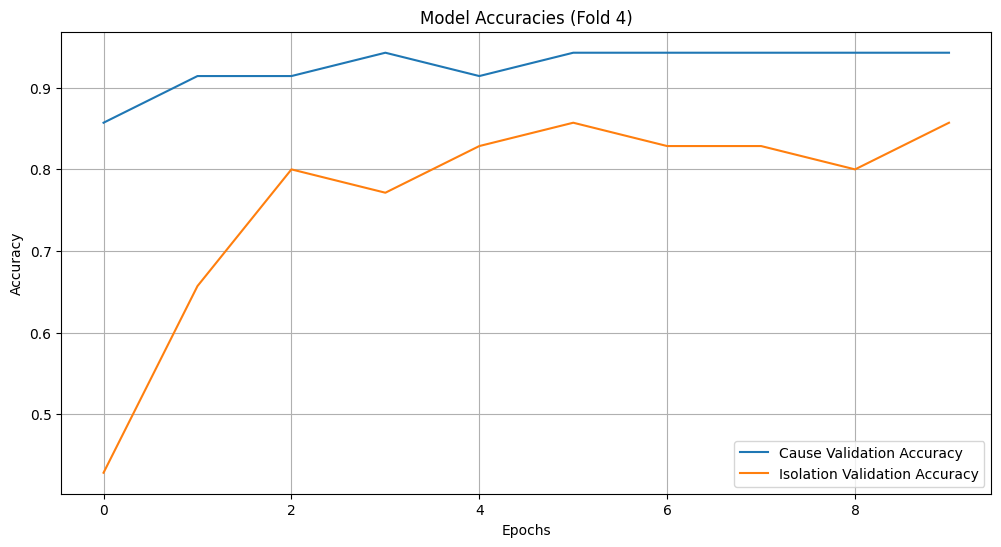

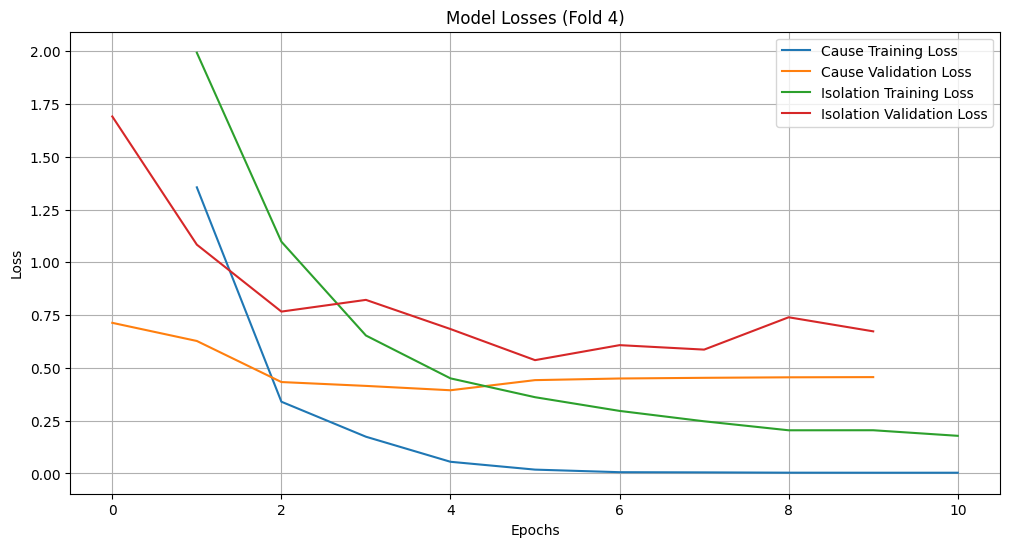


Evaluating models (Fold 4):


100%|██████████| 5/5 [00:00<00:00, 11.42it/s]



Fold 4 Times:
Training time: 0:05:39
Evaluation time: 0:00:01
Total time: 0:05:41

Fold 4 Results:
Cause - Accuracy: 0.9143, Precision: 0.8714, F1: 0.8898
Isolation - Accuracy: 0.8571, Precision: 0.8959, F1: 0.8425


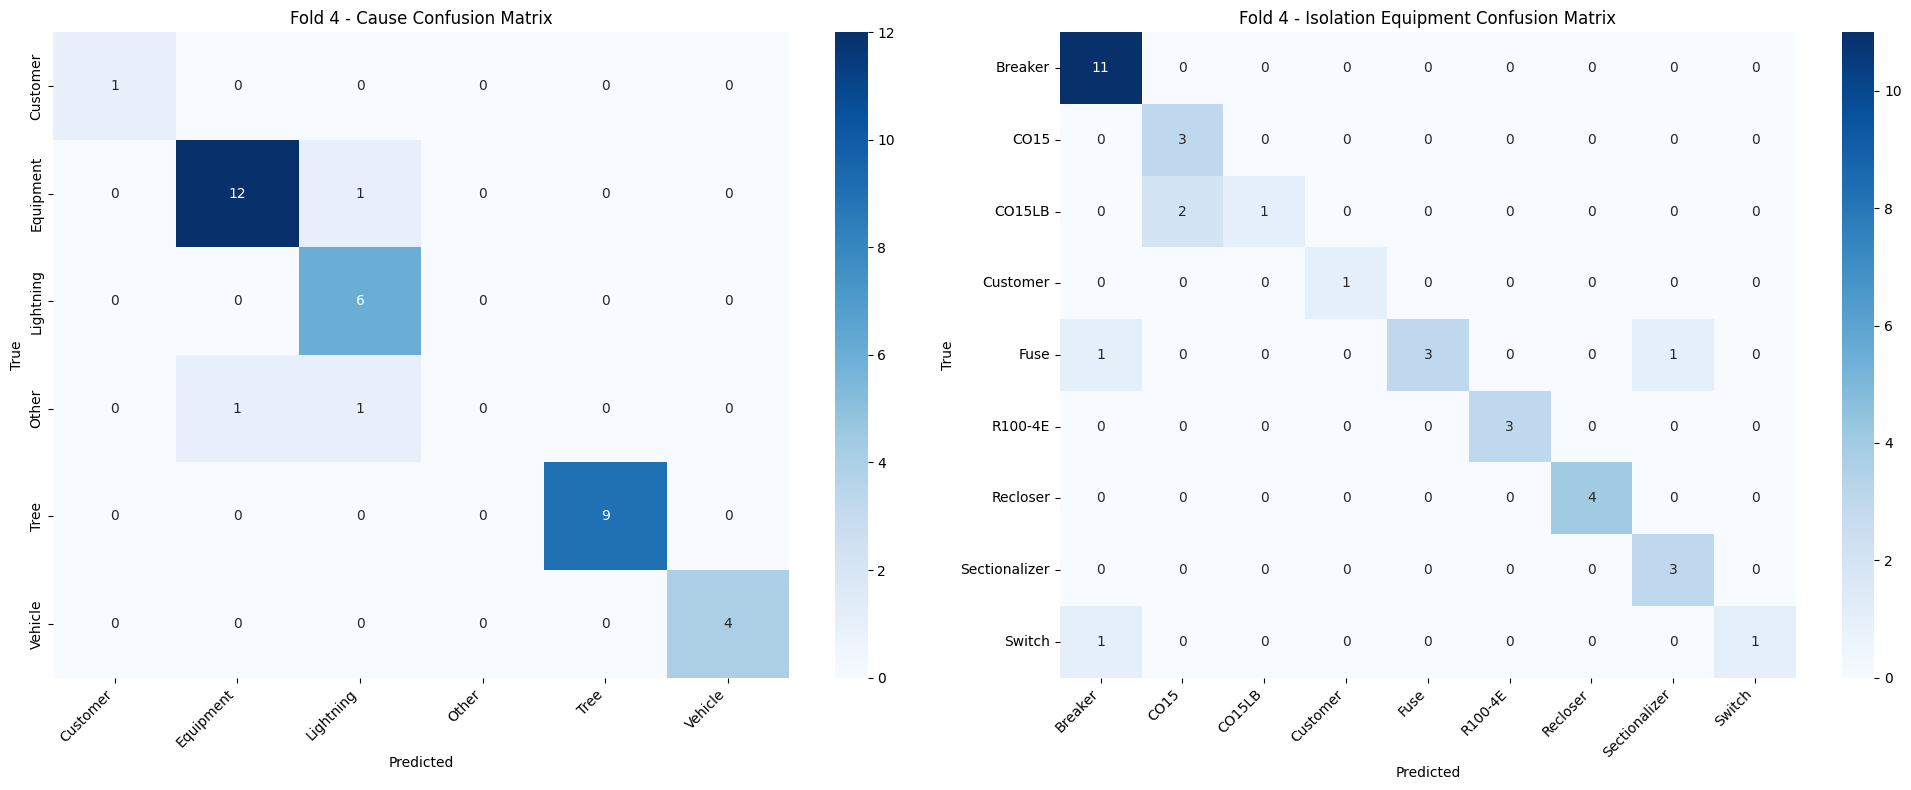


Classification Report - Cause (Fold 4):
              precision    recall  f1-score   support

    Customer       1.00      1.00      1.00         1
   Equipment       0.92      0.92      0.92        13
   Lightning       0.75      1.00      0.86         6
       Other       0.00      0.00      0.00         2
        Tree       1.00      1.00      1.00         9
     Vehicle       1.00      1.00      1.00         4

    accuracy                           0.91        35
   macro avg       0.78      0.82      0.80        35
weighted avg       0.87      0.91      0.89        35

Accuracy - Cause (Fold 4): 0.9143

Classification Report - Isolation Equipment (Fold 4):
               precision    recall  f1-score   support

      Breaker       0.85      1.00      0.92        11
         CO15       0.60      1.00      0.75         3
       CO15LB       1.00      0.33      0.50         3
     Customer       1.00      1.00      1.00         1
         Fuse       1.00      0.60      0.75       

Map: 100%|██████████| 35/35 [00:00<00:00, 4374.93 examples/s]
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at ./distilbert-pq-mlm and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at ./distilbert-pq-mlm and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\rmathew2020\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will

Training Cause Model (Fold 5):


 10%|█         | 18/180 [00:18<01:58,  1.37it/s]

{'loss': 1.3286, 'grad_norm': 3.4873244762420654, 'learning_rate': 0.00018, 'epoch': 1.0}



 10%|█         | 18/180 [00:18<01:58,  1.37it/s]

{'eval_loss': 0.8271262049674988, 'eval_accuracy': 0.8571428571428571, 'eval_precision': 0.7968253968253969, 'eval_f1': 0.8166666666666668, 'eval_runtime': 0.5889, 'eval_samples_per_second': 59.436, 'eval_steps_per_second': 8.491, 'epoch': 1.0}


 20%|██        | 36/180 [00:38<02:05,  1.14it/s]

{'loss': 0.3673, 'grad_norm': 0.803779661655426, 'learning_rate': 0.00016, 'epoch': 2.0}



 20%|██        | 36/180 [00:39<02:05,  1.14it/s]

{'eval_loss': 0.4877614676952362, 'eval_accuracy': 0.9142857142857143, 'eval_precision': 0.8722689075630252, 'eval_f1': 0.8850998463901689, 'eval_runtime': 0.6906, 'eval_samples_per_second': 50.682, 'eval_steps_per_second': 7.24, 'epoch': 2.0}


 30%|███       | 54/180 [00:56<01:42,  1.23it/s]

{'loss': 0.1463, 'grad_norm': 0.11694785952568054, 'learning_rate': 0.00014, 'epoch': 3.0}



 30%|███       | 54/180 [00:57<01:42,  1.23it/s]

{'eval_loss': 0.3957584500312805, 'eval_accuracy': 0.9428571428571428, 'eval_precision': 0.95, 'eval_f1': 0.9352380952380953, 'eval_runtime': 0.6656, 'eval_samples_per_second': 52.582, 'eval_steps_per_second': 7.512, 'epoch': 3.0}


 40%|████      | 72/180 [01:12<01:14,  1.44it/s]

{'loss': 0.0513, 'grad_norm': 5.511244773864746, 'learning_rate': 0.00012, 'epoch': 4.0}



 40%|████      | 72/180 [01:13<01:14,  1.44it/s]

{'eval_loss': 0.38823065161705017, 'eval_accuracy': 0.9428571428571428, 'eval_precision': 0.95, 'eval_f1': 0.9352380952380953, 'eval_runtime': 0.5747, 'eval_samples_per_second': 60.899, 'eval_steps_per_second': 8.7, 'epoch': 4.0}


 50%|█████     | 90/180 [01:27<01:01,  1.47it/s]

{'loss': 0.0119, 'grad_norm': 0.04851652681827545, 'learning_rate': 0.0001, 'epoch': 5.0}



 50%|█████     | 90/180 [01:27<01:01,  1.47it/s]

{'eval_loss': 0.3769754469394684, 'eval_accuracy': 0.9428571428571428, 'eval_precision': 0.9733333333333333, 'eval_f1': 0.948111658456486, 'eval_runtime': 0.6065, 'eval_samples_per_second': 57.709, 'eval_steps_per_second': 8.244, 'epoch': 5.0}


 60%|██████    | 108/180 [01:42<00:52,  1.38it/s]

{'loss': 0.0064, 'grad_norm': 0.022513261064887047, 'learning_rate': 8e-05, 'epoch': 6.0}



 60%|██████    | 108/180 [01:43<00:52,  1.38it/s]

{'eval_loss': 0.42933008074760437, 'eval_accuracy': 0.9428571428571428, 'eval_precision': 0.9733333333333333, 'eval_f1': 0.948111658456486, 'eval_runtime': 0.6666, 'eval_samples_per_second': 52.502, 'eval_steps_per_second': 7.5, 'epoch': 6.0}


 70%|███████   | 126/180 [01:58<00:36,  1.46it/s]

{'loss': 0.0046, 'grad_norm': 0.028243934735655785, 'learning_rate': 6e-05, 'epoch': 7.0}



 70%|███████   | 126/180 [01:58<00:36,  1.46it/s]

{'eval_loss': 0.441685289144516, 'eval_accuracy': 0.9428571428571428, 'eval_precision': 0.9733333333333333, 'eval_f1': 0.948111658456486, 'eval_runtime': 0.6033, 'eval_samples_per_second': 58.012, 'eval_steps_per_second': 8.287, 'epoch': 7.0}


 80%|████████  | 144/180 [02:12<00:24,  1.46it/s]

{'loss': 0.004, 'grad_norm': 0.019254539161920547, 'learning_rate': 4e-05, 'epoch': 8.0}



 80%|████████  | 144/180 [02:13<00:24,  1.46it/s]

{'eval_loss': 0.4485252797603607, 'eval_accuracy': 0.9428571428571428, 'eval_precision': 0.9733333333333333, 'eval_f1': 0.948111658456486, 'eval_runtime': 0.5935, 'eval_samples_per_second': 58.972, 'eval_steps_per_second': 8.425, 'epoch': 8.0}


 90%|█████████ | 162/180 [02:27<00:12,  1.46it/s]

{'loss': 0.0033, 'grad_norm': 0.05689610168337822, 'learning_rate': 2e-05, 'epoch': 9.0}



 90%|█████████ | 162/180 [02:27<00:12,  1.46it/s]

{'eval_loss': 0.45131465792655945, 'eval_accuracy': 0.9428571428571428, 'eval_precision': 0.9733333333333333, 'eval_f1': 0.948111658456486, 'eval_runtime': 0.5827, 'eval_samples_per_second': 60.064, 'eval_steps_per_second': 8.581, 'epoch': 9.0}


100%|██████████| 180/180 [02:44<00:00,  1.38it/s]

{'loss': 0.0034, 'grad_norm': 0.03517104685306549, 'learning_rate': 0.0, 'epoch': 10.0}



100%|██████████| 180/180 [02:44<00:00,  1.38it/s]

{'eval_loss': 0.4528295397758484, 'eval_accuracy': 0.9428571428571428, 'eval_precision': 0.9733333333333333, 'eval_f1': 0.948111658456486, 'eval_runtime': 0.7277, 'eval_samples_per_second': 48.096, 'eval_steps_per_second': 6.871, 'epoch': 10.0}


100%|██████████| 180/180 [02:46<00:00,  1.08it/s]


{'train_runtime': 166.1445, 'train_samples_per_second': 8.607, 'train_steps_per_second': 1.083, 'train_loss': 0.19271000309122932, 'epoch': 10.0}

Training Isolation Model (Fold 5):


 10%|█         | 18/180 [00:15<02:20,  1.15it/s]

{'loss': 2.0484, 'grad_norm': 4.879527568817139, 'learning_rate': 0.00018, 'epoch': 1.0}



 10%|█         | 18/180 [00:16<02:20,  1.15it/s]

{'eval_loss': 1.8305245637893677, 'eval_accuracy': 0.5428571428571428, 'eval_precision': 0.3891748003549245, 'eval_f1': 0.4432330827067669, 'eval_runtime': 0.8314, 'eval_samples_per_second': 42.098, 'eval_steps_per_second': 6.014, 'epoch': 1.0}


 20%|██        | 36/180 [00:31<01:37,  1.48it/s]

{'loss': 0.9665, 'grad_norm': 3.6289968490600586, 'learning_rate': 0.00016, 'epoch': 2.0}



 20%|██        | 36/180 [00:31<01:37,  1.48it/s]

{'eval_loss': 1.6066968441009521, 'eval_accuracy': 0.5428571428571428, 'eval_precision': 0.43926482873851297, 'eval_f1': 0.4763025210084033, 'eval_runtime': 0.6875, 'eval_samples_per_second': 50.909, 'eval_steps_per_second': 7.273, 'epoch': 2.0}


 30%|███       | 54/180 [00:47<01:37,  1.29it/s]

{'loss': 0.4965, 'grad_norm': 4.942018508911133, 'learning_rate': 0.00014, 'epoch': 3.0}



 30%|███       | 54/180 [00:48<01:37,  1.29it/s]

{'eval_loss': 1.6868982315063477, 'eval_accuracy': 0.6, 'eval_precision': 0.611904761904762, 'eval_f1': 0.5899605003291639, 'eval_runtime': 0.6021, 'eval_samples_per_second': 58.13, 'eval_steps_per_second': 8.304, 'epoch': 3.0}


 40%|████      | 72/180 [01:02<01:13,  1.46it/s]

{'loss': 0.3132, 'grad_norm': 6.435710430145264, 'learning_rate': 0.00012, 'epoch': 4.0}



 40%|████      | 72/180 [01:02<01:13,  1.46it/s]

{'eval_loss': 1.8282279968261719, 'eval_accuracy': 0.6285714285714286, 'eval_precision': 0.6535714285714286, 'eval_f1': 0.6224321556579621, 'eval_runtime': 0.5625, 'eval_samples_per_second': 62.222, 'eval_steps_per_second': 8.889, 'epoch': 4.0}


 50%|█████     | 90/180 [01:15<00:55,  1.62it/s]

{'loss': 0.2392, 'grad_norm': 4.838194370269775, 'learning_rate': 0.0001, 'epoch': 5.0}



 50%|█████     | 90/180 [01:16<00:55,  1.62it/s]

{'eval_loss': 1.9219646453857422, 'eval_accuracy': 0.6285714285714286, 'eval_precision': 0.6547619047619048, 'eval_f1': 0.6242462146148782, 'eval_runtime': 0.5469, 'eval_samples_per_second': 63.999, 'eval_steps_per_second': 9.143, 'epoch': 5.0}


 60%|██████    | 108/180 [01:29<00:45,  1.58it/s]

{'loss': 0.1992, 'grad_norm': 0.3570939302444458, 'learning_rate': 8e-05, 'epoch': 6.0}



 60%|██████    | 108/180 [01:29<00:45,  1.58it/s]

{'eval_loss': 1.584546685218811, 'eval_accuracy': 0.6857142857142857, 'eval_precision': 0.6187074829931973, 'eval_f1': 0.6422734254992319, 'eval_runtime': 0.5317, 'eval_samples_per_second': 65.829, 'eval_steps_per_second': 9.404, 'epoch': 6.0}


 70%|███████   | 126/180 [01:42<00:35,  1.51it/s]

{'loss': 0.1647, 'grad_norm': 0.4700529873371124, 'learning_rate': 6e-05, 'epoch': 7.0}



 70%|███████   | 126/180 [01:44<00:35,  1.51it/s]

{'eval_loss': 1.5446754693984985, 'eval_accuracy': 0.6857142857142857, 'eval_precision': 0.6187074829931973, 'eval_f1': 0.6422734254992319, 'eval_runtime': 1.75, 'eval_samples_per_second': 20.0, 'eval_steps_per_second': 2.857, 'epoch': 7.0}


 80%|████████  | 144/180 [02:08<00:53,  1.48s/it]

{'loss': 0.1276, 'grad_norm': 0.06463940441608429, 'learning_rate': 4e-05, 'epoch': 8.0}



 80%|████████  | 144/180 [02:09<00:53,  1.48s/it]

{'eval_loss': 1.5845022201538086, 'eval_accuracy': 0.6571428571428571, 'eval_precision': 0.7326530612244898, 'eval_f1': 0.6723809523809523, 'eval_runtime': 0.846, 'eval_samples_per_second': 41.369, 'eval_steps_per_second': 5.91, 'epoch': 8.0}


 90%|█████████ | 162/180 [02:28<00:14,  1.26it/s]

{'loss': 0.1132, 'grad_norm': 1.0557055473327637, 'learning_rate': 2e-05, 'epoch': 9.0}



 90%|█████████ | 162/180 [02:28<00:14,  1.26it/s]

{'eval_loss': 1.7133361101150513, 'eval_accuracy': 0.6285714285714286, 'eval_precision': 0.6540816326530612, 'eval_f1': 0.6232258064516129, 'eval_runtime': 0.7276, 'eval_samples_per_second': 48.104, 'eval_steps_per_second': 6.872, 'epoch': 9.0}


100%|██████████| 180/180 [02:44<00:00,  1.35it/s]

{'loss': 0.0875, 'grad_norm': 0.10693623870611191, 'learning_rate': 0.0, 'epoch': 10.0}



100%|██████████| 180/180 [02:45<00:00,  1.35it/s]

{'eval_loss': 1.7360138893127441, 'eval_accuracy': 0.6571428571428571, 'eval_precision': 0.6690476190476191, 'eval_f1': 0.6471033574720211, 'eval_runtime': 0.7605, 'eval_samples_per_second': 46.019, 'eval_steps_per_second': 6.574, 'epoch': 10.0}


100%|██████████| 180/180 [02:46<00:00,  1.08it/s]


{'train_runtime': 166.702, 'train_samples_per_second': 8.578, 'train_steps_per_second': 1.08, 'train_loss': 0.47560034460491607, 'epoch': 10.0}


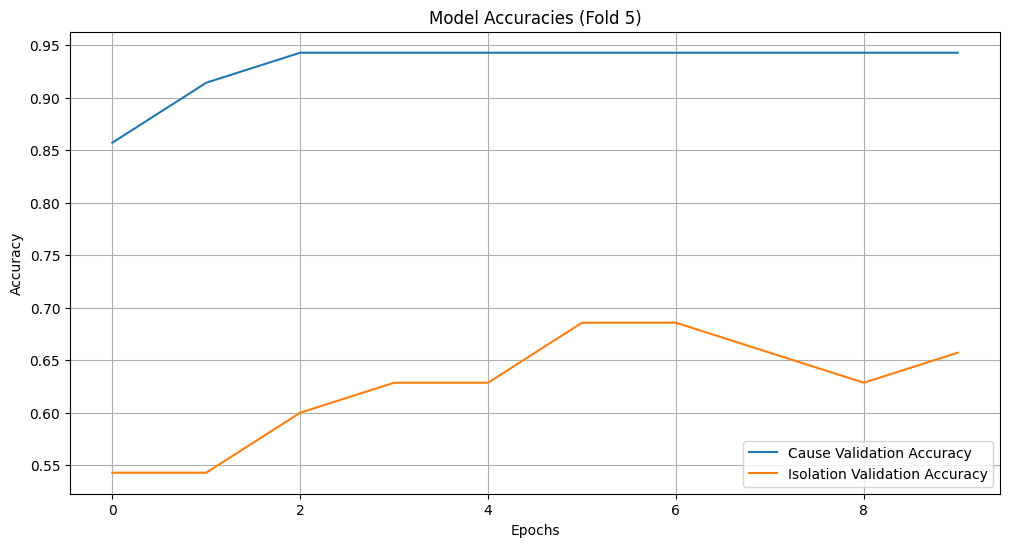

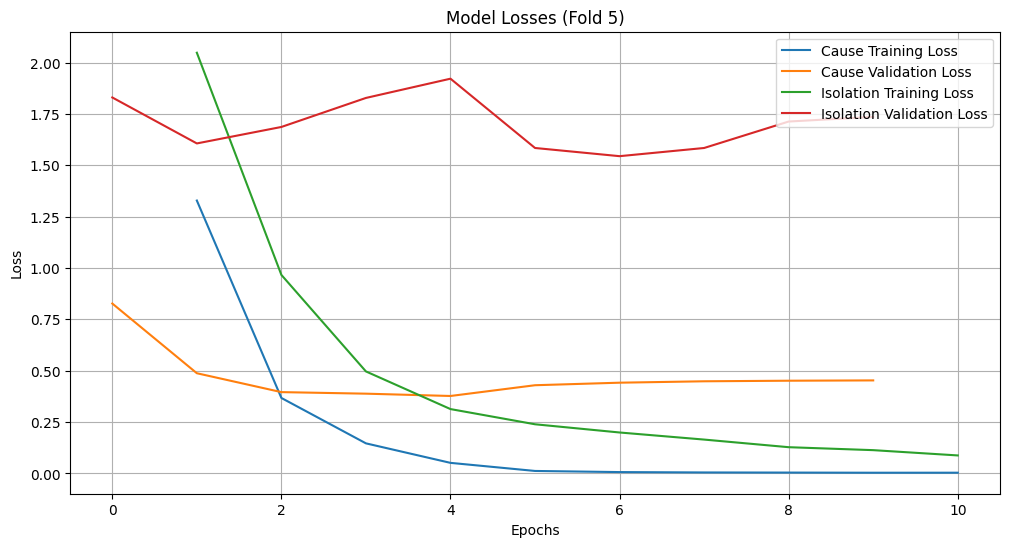


Evaluating models (Fold 5):


100%|██████████| 5/5 [00:00<00:00, 10.58it/s]



Fold 5 Times:
Training time: 0:05:33
Evaluation time: 0:00:01
Total time: 0:05:35

Fold 5 Results:
Cause - Accuracy: 0.9429, Precision: 0.9733, F1: 0.9481
Isolation - Accuracy: 0.6857, Precision: 0.6187, F1: 0.6423


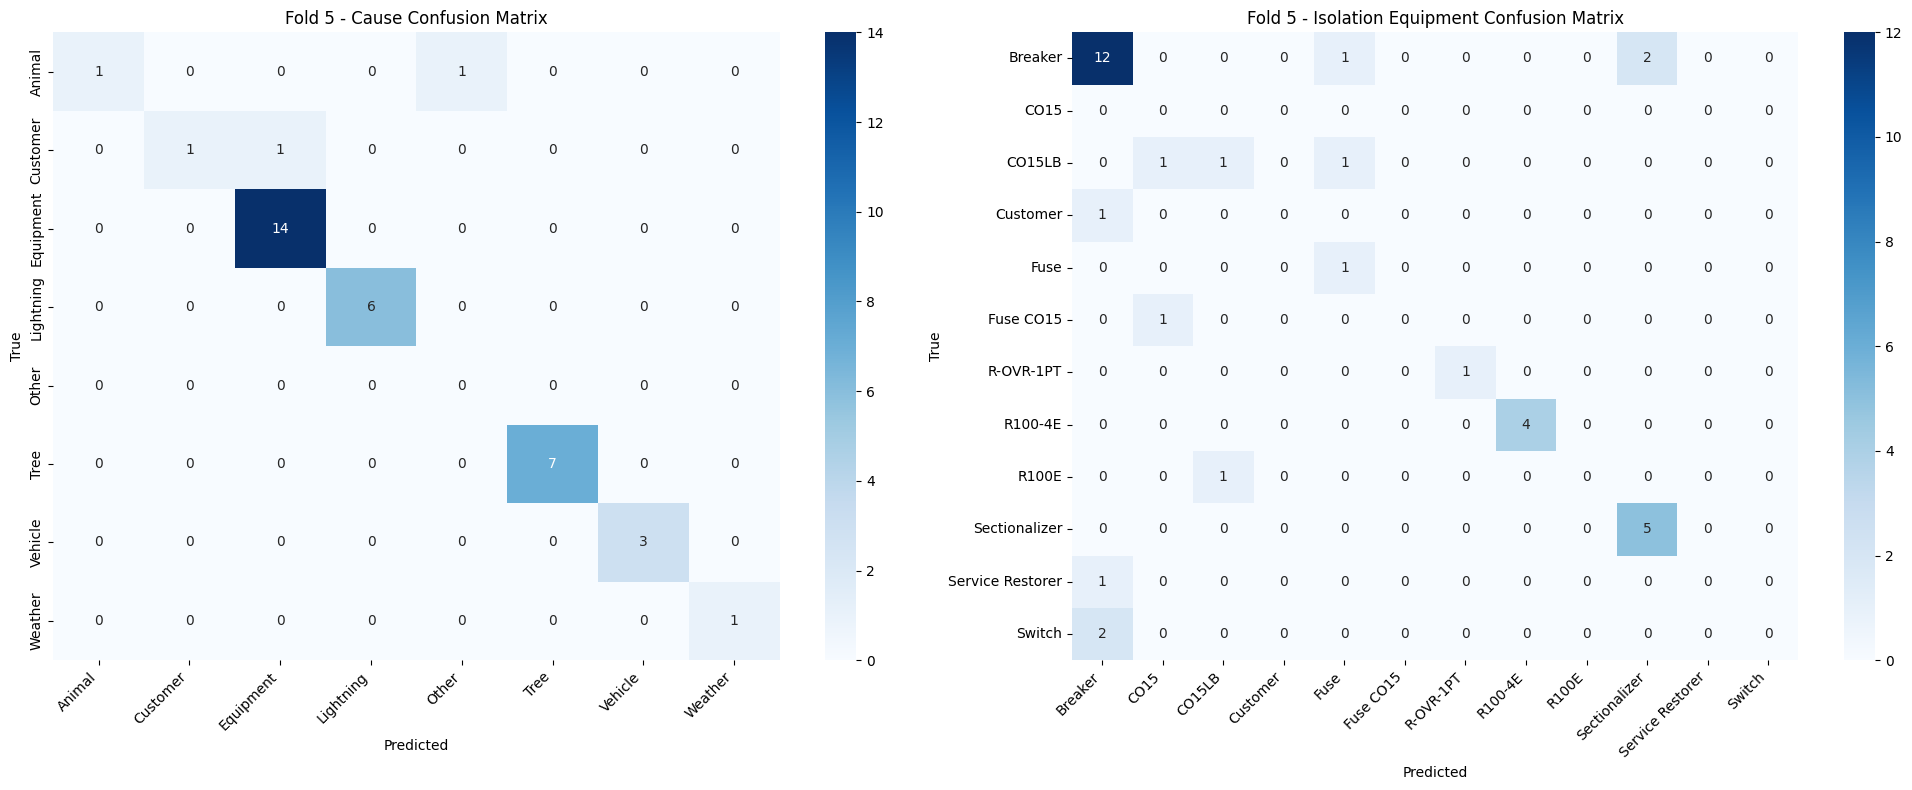


Classification Report - Cause (Fold 5):
              precision    recall  f1-score   support

      Animal       1.00      0.50      0.67         2
    Customer       1.00      0.50      0.67         2
   Equipment       0.93      1.00      0.97        14
   Lightning       1.00      1.00      1.00         6
       Other       0.00      0.00      0.00         0
        Tree       1.00      1.00      1.00         7
     Vehicle       1.00      1.00      1.00         3
     Weather       1.00      1.00      1.00         1

    accuracy                           0.94        35
   macro avg       0.87      0.75      0.79        35
weighted avg       0.97      0.94      0.95        35

Accuracy - Cause (Fold 5): 0.9429

Classification Report - Isolation Equipment (Fold 5):
                  precision    recall  f1-score   support

         Breaker       0.75      0.80      0.77        15
            CO15       0.00      0.00      0.00         0
          CO15LB       0.50      0.33      0

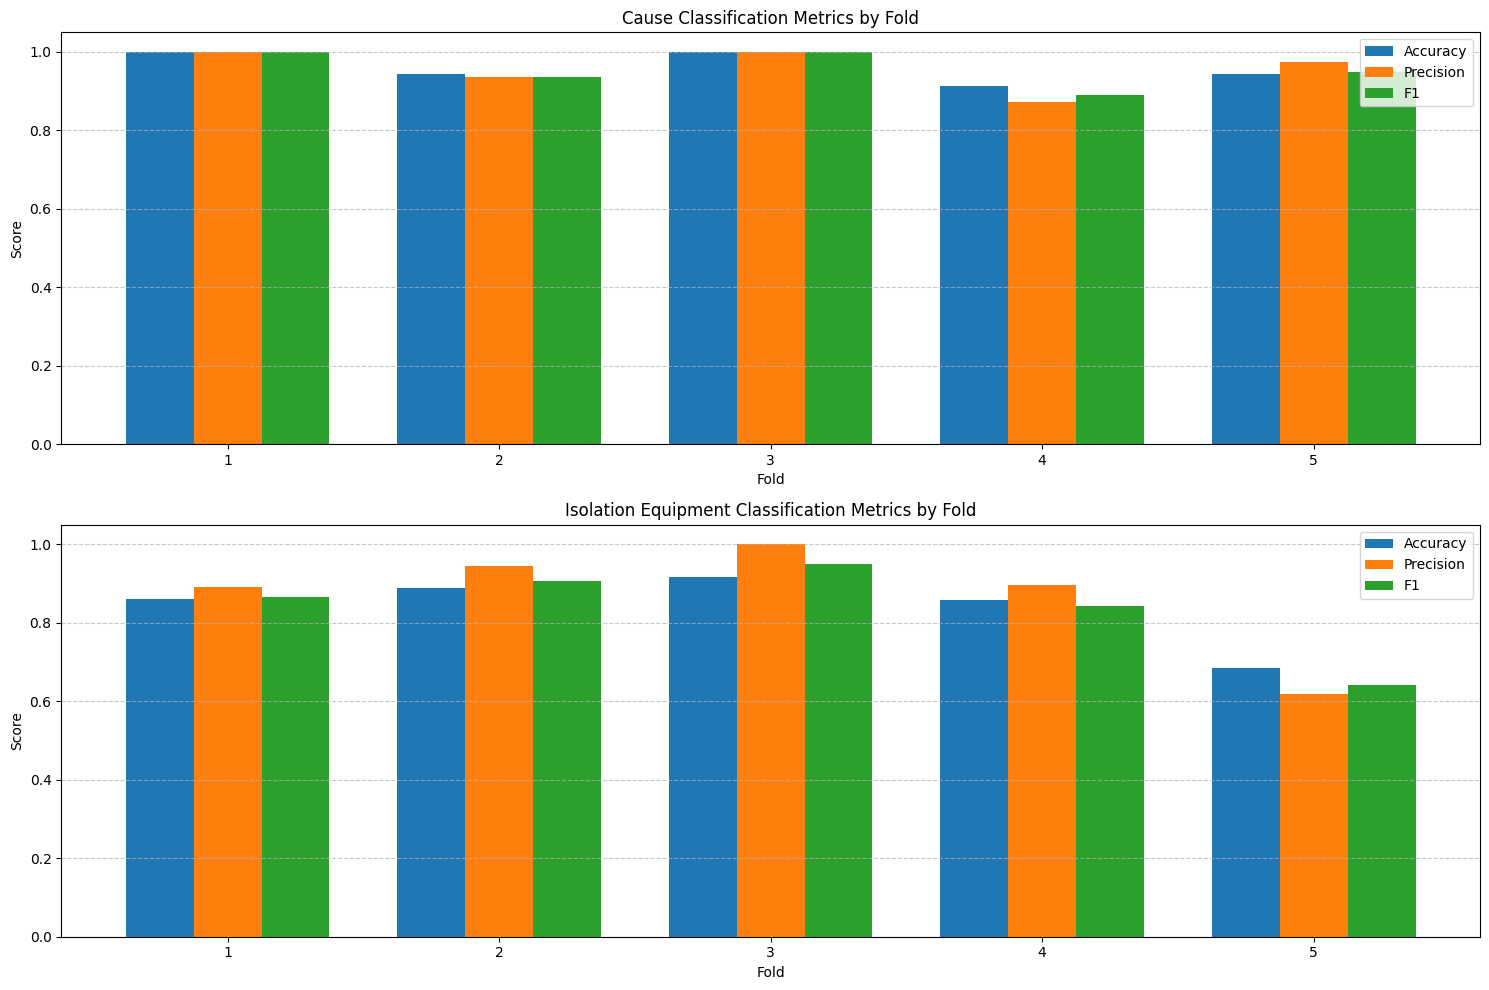


Example Text Classification:

Text: Circuit breaker tripped due to storm
Predicted cause: Lightning
Predicted isolation: Breaker

Text: Customer requested service disconnection
Predicted cause: Other
Predicted isolation: Breaker

Text: Transformer failure after lightning strike
Predicted cause: Equipment
Predicted isolation: Breaker
Predicted cause: Other
Predicted isolation: Breaker


In [9]:
import numpy as np
import pandas as pd
import time
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, accuracy_score
from transformers import AutoModelForSequenceClassification, AutoTokenizer, TrainingArguments, Trainer, DataCollatorWithPadding
import torch
import evaluate
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from datasets import Dataset
import os
from datetime import timedelta

# Set parameters
data_path = "PQEvents_Ticket_csv.csv"
text_column_name = "Details"
label_column_name = "Cause"

model_name = "distilbert-base-uncased"
test_size = 0.2
num_labels = 2
n_splits = 5  # Number of folds for K-fold cross-validation
adaptation_path = "./distilbert-pq-mlm"


# Create directory for results
os.makedirs("./abert_results", exist_ok=True)

# Load and preprocess data
df = pd.read_csv(data_path)

# First, clean up Cause column
df = df[~df['Cause'].isin(['Unknown', 'Undetermined'])]  # Remove rows with these values in Cause column 
df['Cause'] = df['Cause'].replace(['Customer Request', 'Customer Caused'], 'Customer')

# Replace Unknown/Undetermined in Isolation Equipment Code
df['Isolation Equipment Code'] = df['Isolation Equipment Code'].replace(['Unknown', 'Undetermined'], np.nan)

# Only drop rows where Cause is NaN
df = df.dropna(subset=['Cause'])

# If 'Cause' is 'Customer' and 'Isolation Equipment Code' is NaN, set 'Isolation Equipment Code' to 'Customer'
df.loc[(df['Cause'] == 'Customer') & (df['Isolation Equipment Code'].isna()), 'Isolation Equipment Code'] = 'Customer'

# Drop rows where 'Isolation Equipment Code' is NaN, but only for causes other than 'Customer'
df = df.dropna(subset=['Isolation Equipment Code'])

# Keep only rows where 'Details' is a string
df = df[df['Details'].apply(lambda x: isinstance(x, str))]

# Function to clean text data
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    return text

# Apply text cleaning
df['Details'] = df['Details'].apply(clean_text)

# Print distributions
print("\nUnique Cause Classes with Counts:")
print("-" * 40)
cause_unique = df['Cause'].value_counts()
for cause, count in cause_unique.items():
    print(f"{cause:<20} {count:>5}")

print("\nIsolation Equipment Codes for Customer causes:")
print(df[df['Cause'] == 'Customer']['Isolation Equipment Code'].value_counts(dropna=False))

print(f"\nDataset shape: {df.shape}")

# Create label encoders
le_cause = preprocessing.LabelEncoder()
le_isolation = preprocessing.LabelEncoder()

# Fit both encoders
le_cause.fit(df[label_column_name].tolist())
le_isolation.fit(df['Isolation Equipment Code'].tolist())

# Transform labels
df['cause_label'] = le_cause.transform(df[label_column_name].tolist())
df['isolation_label'] = le_isolation.transform(df['Isolation Equipment Code'].tolist())

# Print out the labels with their corresponding encoded values
label_mapping = dict(zip(le_cause.classes_, le_cause.transform(le_cause.classes_)))
print("Cause Label Mapping:")
for label, encoded_value in label_mapping.items():
    print(f"{label}: {encoded_value}")

print()

# Print out the labels with their corresponding encoded values
label_mapping = dict(zip(le_isolation.classes_, le_isolation.transform(le_isolation.classes_)))
print("Isolation Equipment Label Mapping:")
for label, encoded_value in label_mapping.items():
    print(f"{label}: {encoded_value}")

df['text_cleaned'] = df[text_column_name]

# Count the number of data points for each cause
cause_counts = df[label_column_name].value_counts()
code_counts = df['Isolation Equipment Code'].value_counts()

# Print the counts
print("\nCause counts:")
print(cause_counts)
print("\nIsolation Equipment Code counts:")
print(code_counts)

# Initialize KFold cross-validator
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Preprocessing functions
def preprocess_function_cause(examples):
    tokenized = tokenizer(examples["text"], truncation=True, padding=True)
    tokenized["labels"] = examples["cause_label"]
    return tokenized

def preprocess_function_isolation(examples):
    tokenized = tokenizer(examples["text"], truncation=True, padding=True)
    tokenized["labels"] = examples["isolation_label"]
    return tokenized

# Initialize data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Metrics
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    
    # Calculate multiple metrics
    accuracy = accuracy_score(labels, predictions)
    precision = precision_score(labels, predictions, average='weighted', zero_division=0)
    f1 = f1_score(labels, predictions, average='weighted', zero_division=0)
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'f1': f1
    }

# Function to plot training metrics
def plot_training_metrics(cause_trainer, isolation_trainer, fold=None):
    """Plot training and validation metrics from both trainers"""
    
    # Get training histories
    cause_history = cause_trainer.state.log_history
    isolation_history = isolation_trainer.state.log_history
    
    # Extract metrics
    cause_train_loss = []
    cause_eval_loss = []
    isolation_train_loss = []
    isolation_eval_loss = []
    cause_accuracy = []
    isolation_accuracy = []
    epochs = []
    
    # Process cause trainer history
    for entry in cause_history:
        if 'loss' in entry and 'epoch' in entry and 'eval_loss' not in entry:
            cause_train_loss.append(entry['loss'])
            epochs.append(entry['epoch'])
        if 'eval_loss' in entry:
            cause_eval_loss.append(entry['eval_loss'])
            cause_accuracy.append(entry['eval_accuracy'])
    
    # Process isolation trainer history
    for entry in isolation_history:
        if 'loss' in entry and 'epoch' in entry and 'eval_loss' not in entry:
            isolation_train_loss.append(entry['loss'])
        if 'eval_loss' in entry:
            isolation_eval_loss.append(entry['eval_loss'])
            isolation_accuracy.append(entry['eval_accuracy'])
    
    fold_title = f" (Fold {fold})" if fold is not None else ""
    
    # Plot accuracies
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(cause_accuracy)), cause_accuracy, label='Cause Validation Accuracy')
    plt.plot(range(len(isolation_accuracy)), isolation_accuracy, label='Isolation Validation Accuracy') 
    plt.title(f'Model Accuracies{fold_title}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()
    
    # Plot losses
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, cause_train_loss, label='Cause Training Loss')
    plt.plot(range(len(cause_eval_loss)), cause_eval_loss, label='Cause Validation Loss')
    plt.plot(epochs, isolation_train_loss, label='Isolation Training Loss')
    plt.plot(range(len(isolation_eval_loss)), isolation_eval_loss, label='Isolation Validation Loss')
    plt.title(f'Model Losses{fold_title}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()

# Function to create confusion matrices
def plot_confusion_matrices(true_labels, predicted_labels, label_encoder, title_prefix="", ax=None):
    """Plot confusion matrix for given true and predicted labels"""
    
    # Get unique labels present in data
    unique_labels = np.unique(np.concatenate([true_labels, predicted_labels]))
    class_names = label_encoder.classes_[unique_labels]
    
    # Create confusion matrix
    conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=unique_labels)
    
    # Plot
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))
    
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names,
                ax=ax)
    ax.set_title(f'{title_prefix} Confusion Matrix')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    
    return conf_matrix

# Function to classify text
def classify_text(text, cause_model, isolation_model, tokenizer):
    """Classify text using the trained cause and isolation models"""
    
    # Clean and preprocess input text
    cleaned_text = clean_text(text)
    
    # Tokenize the cleaned text
    inputs = tokenizer(cleaned_text, 
                      return_tensors="pt",
                      truncation=True, 
                      padding=True)
    
    # Get predictions from both models
    with torch.no_grad():
        cause_outputs = cause_model(**inputs)
        isolation_outputs = isolation_model(**inputs)
    
    # Get predicted classes
    cause_class = torch.argmax(cause_outputs.logits, dim=-1)
    isolation_class = torch.argmax(isolation_outputs.logits, dim=-1)
    
    # Map predictions to labels
    predicted_cause = le_cause.inverse_transform([cause_class.item()])[0]
    predicted_isolation = le_isolation.inverse_transform([isolation_class.item()])[0]
    
    return predicted_cause, predicted_isolation

# Lists to store results across folds
cause_accuracies = []
cause_precisions = []
cause_f1_scores = []
isolation_accuracies = []
isolation_precisions = []
isolation_f1_scores = []
fold_times = []

# Run K-fold cross-validation
for fold, (train_idx, test_idx) in enumerate(kf.split(df)):
    print(f"\n{'='*80}\nFold {fold+1}/{n_splits}\n{'='*80}")
    
    # Split data for this fold
    df_train = df.iloc[train_idx]
    df_test = df.iloc[test_idx]
    
    # Create datasets
    train_dataset = Dataset.from_dict({
        'text': df_train['text_cleaned'],
        'cause_label': df_train['cause_label'],
        'isolation_label': df_train['isolation_label']
    })

    test_dataset = Dataset.from_dict({
        'text': df_test['text_cleaned'], 
        'cause_label': df_test['cause_label'],
        'isolation_label': df_test['isolation_label']
    })
    
    # Tokenize datasets
    tokenized_train_cause = train_dataset.map(
        preprocess_function_cause,
        batched=True,
        remove_columns=train_dataset.column_names
    )

    tokenized_test_cause = test_dataset.map(
        preprocess_function_cause,
        batched=True,
        remove_columns=test_dataset.column_names
    )

    tokenized_train_isolation = train_dataset.map(
        preprocess_function_isolation,
        batched=True,
        remove_columns=train_dataset.column_names
    )

    tokenized_test_isolation = test_dataset.map(
        preprocess_function_isolation,
        batched=True,
        remove_columns=test_dataset.column_names
    )
    
    # Create models for this fold
    cause_model = AutoModelForSequenceClassification.from_pretrained(
        adaptation_path, 
        num_labels=len(le_cause.classes_)
    )

    isolation_model = AutoModelForSequenceClassification.from_pretrained(
        adaptation_path,
        num_labels=len(le_isolation.classes_)
    )
    
    # Training arguments
    training_args = TrainingArguments(
        output_dir=f"./abert_results/fold_{fold+1}",
        learning_rate=2e-4,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        num_train_epochs=10,  # Reduced for demonstration
        weight_decay=0.01,
        evaluation_strategy="epoch",
        logging_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
    )
    
    # Create trainers
    cause_trainer = Trainer(
        model=cause_model,
        args=training_args,
        train_dataset=tokenized_train_cause,
        eval_dataset=tokenized_test_cause,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics
    )

    isolation_trainer = Trainer(
        model=isolation_model,
        args=training_args,
        train_dataset=tokenized_train_isolation,
        eval_dataset=tokenized_test_isolation,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics
    )
    
    # Start timing for training
    start_time = time.time()
    
    # Train the models
    print(f"Training Cause Model (Fold {fold+1}):")
    cause_trainer.train()
    
    print(f"\nTraining Isolation Model (Fold {fold+1}):")
    isolation_trainer.train()
    
    # End timing for training
    train_end_time = time.time()
    training_time = train_end_time - start_time
    
    # Plot training metrics for this fold
    plot_training_metrics(cause_trainer, isolation_trainer, fold+1)
    
    # Start timing for evaluation
    eval_start_time = time.time()
    
    # Evaluate on test set
    print(f"\nEvaluating models (Fold {fold+1}):")
    
    # Get predictions for both models on test set
    cause_predictions = cause_trainer.predict(tokenized_test_cause)
    isolation_predictions = isolation_trainer.predict(tokenized_test_isolation)
    
    # End timing for evaluation
    eval_end_time = time.time()
    eval_time = eval_end_time - eval_start_time
    
    # Total time for this fold
    fold_total_time = training_time + eval_time
    fold_times.append(fold_total_time)
    
    print(f"\nFold {fold+1} Times:")
    print(f"Training time: {timedelta(seconds=int(training_time))}")
    print(f"Evaluation time: {timedelta(seconds=int(eval_time))}")
    print(f"Total time: {timedelta(seconds=int(fold_total_time))}")
    
    # Extract predictions
    cause_preds = np.argmax(cause_predictions.predictions, axis=1)
    isolation_preds = np.argmax(isolation_predictions.predictions, axis=1)
    
    # Get ground truth values
    cause_true = df_test['cause_label'].values
    isolation_true = df_test['isolation_label'].values
    
    # Calculate metrics
    cause_accuracy = accuracy_score(cause_true, cause_preds)
    cause_precision = precision_score(cause_true, cause_preds, average='weighted', zero_division=0)
    cause_f1 = f1_score(cause_true, cause_preds, average='weighted', zero_division=0)
    
    isolation_accuracy = accuracy_score(isolation_true, isolation_preds)
    isolation_precision = precision_score(isolation_true, isolation_preds, average='weighted', zero_division=0)
    isolation_f1 = f1_score(isolation_true, isolation_preds, average='weighted', zero_division=0)
    
    # Store metrics
    cause_accuracies.append(cause_accuracy)
    cause_precisions.append(cause_precision)
    cause_f1_scores.append(cause_f1)
    isolation_accuracies.append(isolation_accuracy)
    isolation_precisions.append(isolation_precision)
    isolation_f1_scores.append(isolation_f1)
    
    # Print metrics for this fold
    print(f"\nFold {fold+1} Results:")
    print(f"Cause - Accuracy: {cause_accuracy:.4f}, Precision: {cause_precision:.4f}, F1: {cause_f1:.4f}")
    print(f"Isolation - Accuracy: {isolation_accuracy:.4f}, Precision: {isolation_precision:.4f}, F1: {isolation_f1:.4f}")
    
    # Create confusion matrices
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    plot_confusion_matrices(cause_true, cause_preds, le_cause, f"Fold {fold+1} - Cause", ax1)
    plot_confusion_matrices(isolation_true, isolation_preds, le_isolation, f"Fold {fold+1} - Isolation Equipment", ax2)
    
    plt.tight_layout()
    plt.show()
    
    # Get unique labels present in test data for classification report
    unique_cause_labels = np.unique(np.concatenate([cause_true, cause_preds]))
    unique_isolation_labels = np.unique(np.concatenate([isolation_true, isolation_preds]))

    # Get class names for present labels
    cause_class_names = le_cause.classes_[unique_cause_labels]
    isolation_class_names = le_isolation.classes_[unique_isolation_labels]
    
    # Print classification reports
    print(f"\nClassification Report - Cause (Fold {fold+1}):")
    print(classification_report(
        cause_true, cause_preds,
        labels=unique_cause_labels,
        target_names=cause_class_names,
        zero_division=0
    ))
    print(f"Accuracy - Cause (Fold {fold+1}): {accuracy_score(cause_true, cause_preds):.4f}")

    print(f"\nClassification Report - Isolation Equipment (Fold {fold+1}):")
    print(classification_report(
        isolation_true, isolation_preds,
        labels=unique_isolation_labels,
        target_names=isolation_class_names,
        zero_division=0
    ))
    print(f"Accuracy - Isolation Equipment (Fold {fold+1}): {accuracy_score(isolation_true, isolation_preds):.4f}")


# Print average results across all folds
print("\n" + "="*80)
print("AVERAGE RESULTS ACROSS ALL FOLDS")
print("="*80)

print(f"Cause - Avg Accuracy: {np.mean(cause_accuracies):.4f} ± {np.std(cause_accuracies):.4f}")
print(f"Cause - Avg Precision: {np.mean(cause_precisions):.4f} ± {np.std(cause_precisions):.4f}")
print(f"Cause - Avg F1: {np.mean(cause_f1_scores):.4f} ± {np.std(cause_f1_scores):.4f}")

print(f"Isolation - Avg Accuracy: {np.mean(isolation_accuracies):.4f} ± {np.std(isolation_accuracies):.4f}")
print(f"Isolation - Avg Precision: {np.mean(isolation_precisions):.4f} ± {np.std(isolation_precisions):.4f}")
print(f"Isolation - Avg F1: {np.mean(isolation_f1_scores):.4f} ± {np.std(isolation_f1_scores):.4f}")

print(f"\nAverage Time per Fold: {timedelta(seconds=int(np.mean(fold_times)))}")
print(f"Total Time for all Folds: {timedelta(seconds=int(np.sum(fold_times)))}")

# Plot metrics across folds
plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
x = np.arange(1, n_splits+1)
width = 0.25
plt.bar(x - width, cause_accuracies, width, label='Accuracy')
plt.bar(x, cause_precisions, width, label='Precision')
plt.bar(x + width, cause_f1_scores, width, label='F1')
plt.xlabel('Fold')
plt.ylabel('Score')
plt.title('Cause Classification Metrics by Fold')
plt.xticks(x)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.subplot(2, 1, 2)
plt.bar(x - width, isolation_accuracies, width, label='Accuracy')
plt.bar(x, isolation_precisions, width, label='Precision')
plt.bar(x + width, isolation_f1_scores, width, label='F1')
plt.xlabel('Fold')
plt.ylabel('Score')
plt.title('Isolation Equipment Classification Metrics by Fold')
plt.xticks(x)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Save best model from last fold for inference
cause_model.save_pretrained("./abert_results/best_cause_model")
isolation_model.save_pretrained("./abert_results/best_isolation_model")
tokenizer.save_pretrained("./abert_results/tokenizer")

# Example for text classification
print("\nExample Text Classification:")
sample_texts = [
    "Circuit breaker tripped due to storm",
    "Customer requested service disconnection",
    "Transformer failure after lightning strike"
]

for text in sample_texts:
    cause, isolation = classify_text(text, cause_model, isolation_model, tokenizer)
    print(f"\nText: {text}")
    print(f"Predicted cause: {cause}")
    print(f"Predicted isolation: {isolation}")

# Interactive classification
while True:
    text = input("\nEnter text to classify (or 'quit' to exit): ")
    if text.lower() == 'quit':
        break
    cause, isolation = classify_text(text, cause_model, isolation_model, tokenizer)
    print(f"Predicted cause: {cause}")
    print(f"Predicted isolation: {isolation}")

# testing

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("./resultsberta/tokenizer")
cause_model = AutoModelForSequenceClassification.from_pretrained("./resultsberta/best_cause_model")
isolation_model = AutoModelForSequenceClassification.from_pretrained("./resultsberta/best_isolation_model")

while True:
    text = input("\nEnter text to classify (or 'quit' to exit): ")
    if text.lower() == 'quit':
        break
    cause, isolation = classify_text(text, cause_model, isolation_model, tokenizer)
    print(f"\nInput: {text}")
    print(f"Predicted cause: {cause}")
    print(f"Predicted isolation: {isolation}")

In [3]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("./abert_results/tokenizer")
cause_model = AutoModelForSequenceClassification.from_pretrained("./abert_results/best_cause_model")
isolation_model = AutoModelForSequenceClassification.from_pretrained("./abert_results/best_isolation_model")

sample_tickets = [
    "Transformer failure causing outage in Site0015; emergency crew dispatched.",
    "Tree fell on power line during storm, affecting multiple feeders.",
    "Equipment malfunction at Site0009; technician en route to assess damage.",
    "Maintenance scheduled on Site0020 breaker; power out from 11 PM to 3 AM.",
    "Lightning strike led to tripping at Site0011; restored after reset.",
    "High wind knocked branch onto transformer; brief power loss in area.",
    "Customer reported flickering lights; investigation ongoing.",
    "Damaged cable spotted near Site0002; crew mobilized for replacement.",
    "Snake found inside transformer at Site0013; caused short circuit, now under repair.",
    "Low voltage noticed at Site0008; possibly due to overloaded feeder.",
    "Unexpected tripping at Site0005; system logs show surge activity.",
    "Temperature increase in transformer oil at Site0016; sensors triggered alert."
]


for text in sample_tickets:
    cause, isolation = classify_text(text, cause_model, isolation_model, tokenizer)
    print(f"\nInput: {text}")
    print(f"Predicted cause: {cause}")
    print(f"Predicted isolation: {isolation}")


Input: Transformer failure causing outage in Site0015; emergency crew dispatched.
Predicted cause: Equipment
Predicted isolation: Breaker

Input: Tree fell on power line during storm, affecting multiple feeders.
Predicted cause: Tree
Predicted isolation: Breaker

Input: Equipment malfunction at Site0009; technician en route to assess damage.
Predicted cause: Equipment
Predicted isolation: Breaker

Input: Maintenance scheduled on Site0020 breaker; power out from 11 PM to 3 AM.
Predicted cause: Planned
Predicted isolation: Breaker

Input: Lightning strike led to tripping at Site0011; restored after reset.
Predicted cause: Lightning
Predicted isolation: Breaker

Input: High wind knocked branch onto transformer; brief power loss in area.
Predicted cause: Weather
Predicted isolation: Breaker

Input: Customer reported flickering lights; investigation ongoing.
Predicted cause: Other
Predicted isolation: Breaker

Input: Damaged cable spotted near Site0002; crew mobilized for replacement.
Pred

spelling works if like treee or if word is not cause like cabel

# for multiple textbooks



Unique Cause Classes with Counts:
----------------------------------------
Equipment               73
Tree                    39
Vehicle                 23
Lightning               21
Animal                   7
Customer                 6
Other                    4
Weather                  3
Planned                  2

Isolation Equipment Codes for Customer causes:
Isolation Equipment Code
Customer    5
Switch      1
Name: count, dtype: int64

Dataset shape: (178, 12)
Cause Label Mapping:
Animal: 0
Customer: 1
Equipment: 2
Lightning: 3
Other: 4
Planned: 5
Tree: 6
Vehicle: 7
Weather: 8

Isolation Equipment Label Mapping:
Breaker: 0
CO15: 1
CO15LB: 2
Customer: 3
Fuse: 4
Fuse CO15: 5
OCB: 6
R-OVR-1PT: 7
R100-4E: 8
R100E: 9
Recloser: 10
SECT200NLB: 11
Sectionalizer: 12
Service Restorer: 13
Switch: 14

Cause counts:
Cause
Equipment    73
Tree         39
Vehicle      23
Lightning    21
Animal        7
Customer      6
Other         4
Weather       3
Planned       2
Name: count, dtype: int64



Map: 100%|██████████| 36/36 [00:00<00:00, 9307.46 examples/s]
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at ./distilbert-pq-enhanced and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at ./distilbert-pq-enhanced and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\rmathew2020\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecate

Training Cause Model (Fold 1):


  3%|▎         | 18/540 [00:11<04:52,  1.78it/s]

{'loss': 1.422, 'grad_norm': 3.5010457038879395, 'learning_rate': 0.00019333333333333333, 'epoch': 1.0}


                                                
  3%|▎         | 18/540 [00:11<04:52,  1.78it/s]

{'eval_loss': 0.5109269618988037, 'eval_accuracy': 0.8888888888888888, 'eval_precision': 0.7971014492753623, 'eval_f1': 0.8386243386243386, 'eval_runtime': 0.379, 'eval_samples_per_second': 94.983, 'eval_steps_per_second': 13.192, 'epoch': 1.0}


  7%|▋         | 36/540 [00:23<04:53,  1.72it/s]

{'loss': 0.4684, 'grad_norm': 0.3904130756855011, 'learning_rate': 0.0001866666666666667, 'epoch': 2.0}


                                                
  7%|▋         | 36/540 [00:23<04:53,  1.72it/s]

{'eval_loss': 0.18894529342651367, 'eval_accuracy': 0.9722222222222222, 'eval_precision': 0.9500000000000001, 'eval_f1': 0.9598765432098766, 'eval_runtime': 0.3832, 'eval_samples_per_second': 93.937, 'eval_steps_per_second': 13.047, 'epoch': 2.0}


 10%|█         | 54/540 [00:35<04:45,  1.70it/s]

{'loss': 0.1919, 'grad_norm': 7.439961910247803, 'learning_rate': 0.00018, 'epoch': 3.0}


                                                
 10%|█         | 54/540 [00:36<04:45,  1.70it/s]

{'eval_loss': 0.07994849979877472, 'eval_accuracy': 0.9722222222222222, 'eval_precision': 0.9722222222222222, 'eval_f1': 0.9722222222222222, 'eval_runtime': 0.3866, 'eval_samples_per_second': 93.121, 'eval_steps_per_second': 12.933, 'epoch': 3.0}


 13%|█▎        | 72/540 [00:48<04:33,  1.71it/s]

{'loss': 0.1155, 'grad_norm': 0.0355539433658123, 'learning_rate': 0.00017333333333333334, 'epoch': 4.0}


                                                
 13%|█▎        | 72/540 [00:48<04:33,  1.71it/s]

{'eval_loss': 0.04784350469708443, 'eval_accuracy': 0.9722222222222222, 'eval_precision': 0.9513888888888888, 'eval_f1': 0.9603174603174602, 'eval_runtime': 0.3877, 'eval_samples_per_second': 92.859, 'eval_steps_per_second': 12.897, 'epoch': 4.0}

Early stopping triggered! No accuracy improvement for 2 consecutive evaluations.
Best accuracy: 0.9722, Current accuracy: 0.9722
Accuracy history: ['0.8889', '0.9722', '0.9722', '0.9722']
Early stopping triggered at epoch 4


 13%|█▎        | 72/540 [00:49<05:22,  1.45it/s]


{'train_runtime': 49.6897, 'train_samples_per_second': 85.732, 'train_steps_per_second': 10.867, 'train_loss': 0.5494547817442152, 'epoch': 4.0}
Cause model trained for 4 epochs

Training Isolation Model (Fold 1):


  3%|▎         | 18/540 [00:11<05:03,  1.72it/s]

{'loss': 1.9931, 'grad_norm': 7.181748867034912, 'learning_rate': 0.00019333333333333333, 'epoch': 1.0}


                                                
  3%|▎         | 18/540 [00:12<05:03,  1.72it/s]

{'eval_loss': 1.7083362340927124, 'eval_accuracy': 0.5, 'eval_precision': 0.5603448275862069, 'eval_f1': 0.39799382716049386, 'eval_runtime': 0.4001, 'eval_samples_per_second': 89.984, 'eval_steps_per_second': 12.498, 'epoch': 1.0}


  7%|▋         | 36/540 [00:24<05:06,  1.64it/s]

{'loss': 1.1446, 'grad_norm': 6.663309097290039, 'learning_rate': 0.0001866666666666667, 'epoch': 2.0}


                                                
  7%|▋         | 36/540 [00:24<05:06,  1.64it/s]

{'eval_loss': 1.1579434871673584, 'eval_accuracy': 0.6666666666666666, 'eval_precision': 0.6082175925925926, 'eval_f1': 0.5936681631126075, 'eval_runtime': 0.4198, 'eval_samples_per_second': 85.754, 'eval_steps_per_second': 11.91, 'epoch': 2.0}


 10%|█         | 54/540 [00:37<04:48,  1.69it/s]

{'loss': 0.6493, 'grad_norm': 7.322294235229492, 'learning_rate': 0.00018, 'epoch': 3.0}


                                                
 10%|█         | 54/540 [00:37<04:48,  1.69it/s]

{'eval_loss': 0.8469061851501465, 'eval_accuracy': 0.75, 'eval_precision': 0.8418803418803419, 'eval_f1': 0.7285493827160493, 'eval_runtime': 0.3871, 'eval_samples_per_second': 92.998, 'eval_steps_per_second': 12.916, 'epoch': 3.0}


 13%|█▎        | 72/540 [00:49<04:41,  1.66it/s]

{'loss': 0.4595, 'grad_norm': 16.553552627563477, 'learning_rate': 0.00017333333333333334, 'epoch': 4.0}


                                                
 13%|█▎        | 72/540 [00:50<04:41,  1.66it/s]

{'eval_loss': 0.7012094855308533, 'eval_accuracy': 0.75, 'eval_precision': 0.8597883597883597, 'eval_f1': 0.7613355780022446, 'eval_runtime': 0.385, 'eval_samples_per_second': 93.495, 'eval_steps_per_second': 12.985, 'epoch': 4.0}


 17%|█▋        | 90/540 [01:02<04:32,  1.65it/s]

{'loss': 0.3072, 'grad_norm': 2.8964250087738037, 'learning_rate': 0.0001666666666666667, 'epoch': 5.0}


                                                
 17%|█▋        | 90/540 [01:02<04:32,  1.65it/s]

{'eval_loss': 0.8484599590301514, 'eval_accuracy': 0.7777777777777778, 'eval_precision': 0.8690476190476191, 'eval_f1': 0.7938271604938272, 'eval_runtime': 0.3952, 'eval_samples_per_second': 91.101, 'eval_steps_per_second': 12.653, 'epoch': 5.0}


 20%|██        | 108/540 [01:14<04:19,  1.66it/s]

{'loss': 0.4169, 'grad_norm': 1.6314133405685425, 'learning_rate': 0.00016, 'epoch': 6.0}


                                                 
 20%|██        | 108/540 [01:15<04:19,  1.66it/s]

{'eval_loss': 0.9681731462478638, 'eval_accuracy': 0.7777777777777778, 'eval_precision': 0.8690476190476191, 'eval_f1': 0.7938271604938272, 'eval_runtime': 0.3701, 'eval_samples_per_second': 97.267, 'eval_steps_per_second': 13.509, 'epoch': 6.0}


 23%|██▎       | 126/540 [01:27<04:02,  1.71it/s]

{'loss': 0.219, 'grad_norm': 11.395392417907715, 'learning_rate': 0.00015333333333333334, 'epoch': 7.0}


                                                 
 23%|██▎       | 126/540 [01:27<04:02,  1.71it/s]

{'eval_loss': 1.1659196615219116, 'eval_accuracy': 0.7222222222222222, 'eval_precision': 0.8611111111111112, 'eval_f1': 0.7262345679012346, 'eval_runtime': 0.4006, 'eval_samples_per_second': 89.867, 'eval_steps_per_second': 12.482, 'epoch': 7.0}

Early stopping triggered! No accuracy improvement for 2 consecutive evaluations.
Best accuracy: 0.7778, Current accuracy: 0.7222
Accuracy history: ['0.5000', '0.6667', '0.7500', '0.7500', '0.7778', '0.7778', '0.7222']
Early stopping triggered at epoch 7


 23%|██▎       | 126/540 [01:28<04:51,  1.42it/s]


{'train_runtime': 88.6883, 'train_samples_per_second': 48.033, 'train_steps_per_second': 6.089, 'train_loss': 0.7413741463706607, 'epoch': 7.0}
Isolation model trained for 7 epochs

Evaluating models (Fold 1):


100%|██████████| 5/5 [00:00<00:00, 17.79it/s]



Fold 1 Times:
Training time: 0:02:19
Evaluation time: 0:00:00
Total time: 0:02:19

Fold 1 Results:
Cause - Accuracy: 0.9722, Precision: 0.9500, F1: 0.9599
Isolation - Accuracy: 0.7778, Precision: 0.8690, F1: 0.7938


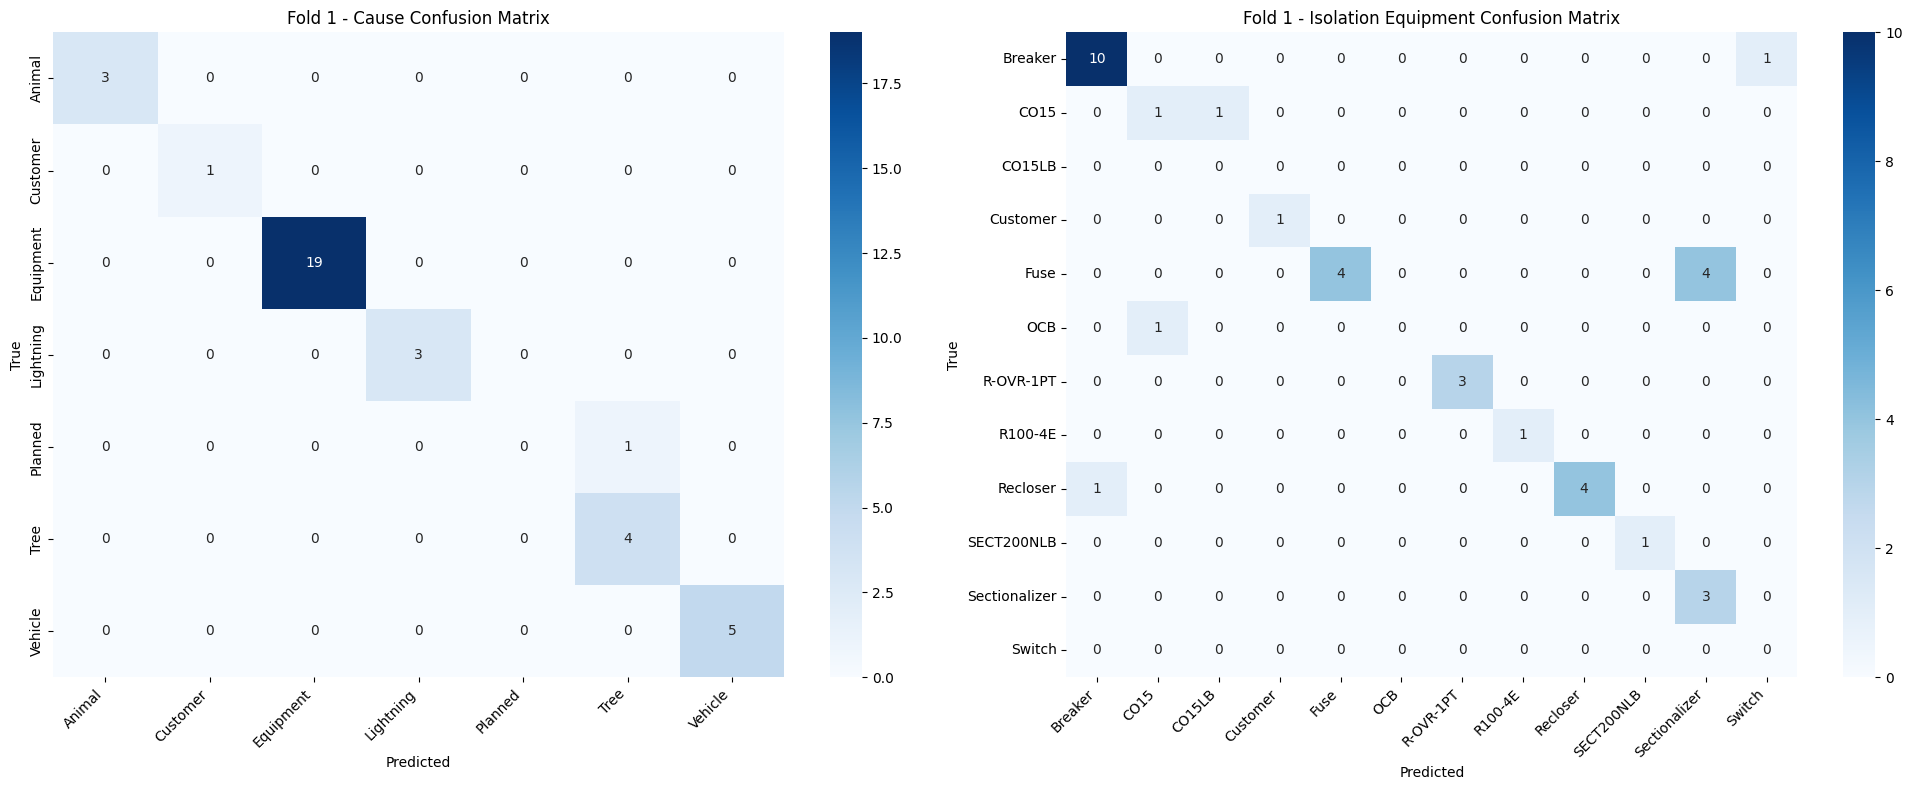


Classification Report - Cause (Fold 1):
              precision    recall  f1-score   support

      Animal       1.00      1.00      1.00         3
    Customer       1.00      1.00      1.00         1
   Equipment       1.00      1.00      1.00        19
   Lightning       1.00      1.00      1.00         3
     Planned       0.00      0.00      0.00         1
        Tree       0.80      1.00      0.89         4
     Vehicle       1.00      1.00      1.00         5

    accuracy                           0.97        36
   macro avg       0.83      0.86      0.84        36
weighted avg       0.95      0.97      0.96        36

Accuracy - Cause (Fold 1): 0.9722

Fold 2/5


Map: 100%|██████████| 36/36 [00:00<00:00, 5017.28 examples/s]
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at ./distilbert-pq-enhanced and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at ./distilbert-pq-enhanced and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\rmathew2020\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecate

Training Cause Model (Fold 2):


  3%|▎         | 18/540 [00:11<05:01,  1.73it/s]

{'loss': 1.3723, 'grad_norm': 6.371908664703369, 'learning_rate': 0.00019333333333333333, 'epoch': 1.0}



  3%|▎         | 18/540 [00:11<05:01,  1.73it/s]

{'eval_loss': 0.7798459529876709, 'eval_accuracy': 0.8055555555555556, 'eval_precision': 0.8226190476190476, 'eval_f1': 0.7948108536343832, 'eval_runtime': 0.3698, 'eval_samples_per_second': 97.361, 'eval_steps_per_second': 13.522, 'epoch': 1.0}


  7%|▋         | 36/540 [00:23<04:51,  1.73it/s]

{'loss': 0.4536, 'grad_norm': 3.6846413612365723, 'learning_rate': 0.0001866666666666667, 'epoch': 2.0}



  7%|▋         | 36/540 [00:23<04:51,  1.73it/s]

{'eval_loss': 0.4085449278354645, 'eval_accuracy': 0.8888888888888888, 'eval_precision': 0.8888888888888888, 'eval_f1': 0.8774928774928775, 'eval_runtime': 0.4228, 'eval_samples_per_second': 85.153, 'eval_steps_per_second': 11.827, 'epoch': 2.0}


 10%|█         | 54/540 [00:35<04:43,  1.71it/s]

{'loss': 0.1301, 'grad_norm': 0.09682269394397736, 'learning_rate': 0.00018, 'epoch': 3.0}



 10%|█         | 54/540 [00:36<04:43,  1.71it/s]

{'eval_loss': 0.32665908336639404, 'eval_accuracy': 0.9166666666666666, 'eval_precision': 0.9212962962962964, 'eval_f1': 0.910826210826211, 'eval_runtime': 0.377, 'eval_samples_per_second': 95.502, 'eval_steps_per_second': 13.264, 'epoch': 3.0}


 13%|█▎        | 72/540 [00:48<04:30,  1.73it/s]

{'loss': 0.0442, 'grad_norm': 0.0692920982837677, 'learning_rate': 0.00017333333333333334, 'epoch': 4.0}



 13%|█▎        | 72/540 [00:48<04:30,  1.73it/s]

{'eval_loss': 0.2885931432247162, 'eval_accuracy': 0.9444444444444444, 'eval_precision': 0.9629629629629631, 'eval_f1': 0.9478632478632478, 'eval_runtime': 0.3878, 'eval_samples_per_second': 92.822, 'eval_steps_per_second': 12.892, 'epoch': 4.0}


 17%|█▋        | 90/540 [01:00<04:24,  1.70it/s]

{'loss': 0.0418, 'grad_norm': 1.4463244676589966, 'learning_rate': 0.0001666666666666667, 'epoch': 5.0}



 17%|█▋        | 90/540 [01:00<04:24,  1.70it/s]

{'eval_loss': 0.2542304992675781, 'eval_accuracy': 0.9166666666666666, 'eval_precision': 0.9490740740740742, 'eval_f1': 0.9218518518518519, 'eval_runtime': 0.3741, 'eval_samples_per_second': 96.244, 'eval_steps_per_second': 13.367, 'epoch': 5.0}


 20%|██        | 108/540 [01:13<04:15,  1.69it/s]

{'loss': 0.0248, 'grad_norm': 0.12454443424940109, 'learning_rate': 0.00016, 'epoch': 6.0}



 20%|██        | 108/540 [01:13<04:15,  1.69it/s]

{'eval_loss': 0.3163198232650757, 'eval_accuracy': 0.9444444444444444, 'eval_precision': 0.9629629629629631, 'eval_f1': 0.9478632478632478, 'eval_runtime': 0.3861, 'eval_samples_per_second': 93.235, 'eval_steps_per_second': 12.949, 'epoch': 6.0}

Early stopping triggered! No accuracy improvement for 2 consecutive evaluations.
Best accuracy: 0.9444, Current accuracy: 0.9444
Accuracy history: ['0.8056', '0.8889', '0.9167', '0.9444', '0.9167', '0.9444']
Early stopping triggered at epoch 6


 20%|██        | 108/540 [01:15<05:00,  1.44it/s]


{'train_runtime': 75.0029, 'train_samples_per_second': 56.798, 'train_steps_per_second': 7.2, 'train_loss': 0.3444578810422509, 'epoch': 6.0}
Cause model trained for 6 epochs

Training Isolation Model (Fold 2):


  3%|▎         | 18/540 [00:11<05:05,  1.71it/s]

{'loss': 2.1475, 'grad_norm': 5.426435947418213, 'learning_rate': 0.00019333333333333333, 'epoch': 1.0}



  3%|▎         | 18/540 [00:12<05:05,  1.71it/s]

{'eval_loss': 1.272504210472107, 'eval_accuracy': 0.7222222222222222, 'eval_precision': 0.5712448559670782, 'eval_f1': 0.6355116514690983, 'eval_runtime': 0.4345, 'eval_samples_per_second': 82.854, 'eval_steps_per_second': 11.507, 'epoch': 1.0}


  7%|▋         | 36/540 [00:24<05:04,  1.65it/s]

{'loss': 1.2139, 'grad_norm': 6.745934963226318, 'learning_rate': 0.0001866666666666667, 'epoch': 2.0}



  7%|▋         | 36/540 [00:24<05:04,  1.65it/s]

{'eval_loss': 0.648495614528656, 'eval_accuracy': 0.8333333333333334, 'eval_precision': 0.8611111111111112, 'eval_f1': 0.8388888888888889, 'eval_runtime': 0.4099, 'eval_samples_per_second': 87.816, 'eval_steps_per_second': 12.197, 'epoch': 2.0}


 10%|█         | 54/540 [00:37<04:52,  1.66it/s]

{'loss': 0.7298, 'grad_norm': 9.77354907989502, 'learning_rate': 0.00018, 'epoch': 3.0}



 10%|█         | 54/540 [00:37<04:52,  1.66it/s]

{'eval_loss': 0.46916648745536804, 'eval_accuracy': 0.8611111111111112, 'eval_precision': 0.911111111111111, 'eval_f1': 0.8647232397232396, 'eval_runtime': 0.4002, 'eval_samples_per_second': 89.953, 'eval_steps_per_second': 12.493, 'epoch': 3.0}


 13%|█▎        | 72/540 [00:49<04:40,  1.67it/s]

{'loss': 0.4356, 'grad_norm': 9.593027114868164, 'learning_rate': 0.00017333333333333334, 'epoch': 4.0}



 13%|█▎        | 72/540 [00:50<04:40,  1.67it/s]

{'eval_loss': 0.5938816666603088, 'eval_accuracy': 0.8333333333333334, 'eval_precision': 0.8441358024691358, 'eval_f1': 0.8304093567251463, 'eval_runtime': 0.4172, 'eval_samples_per_second': 86.28, 'eval_steps_per_second': 11.983, 'epoch': 4.0}


 17%|█▋        | 90/540 [01:02<04:33,  1.64it/s]

{'loss': 0.3923, 'grad_norm': 5.110943794250488, 'learning_rate': 0.0001666666666666667, 'epoch': 5.0}



 17%|█▋        | 90/540 [01:03<04:33,  1.64it/s]

{'eval_loss': 0.660035252571106, 'eval_accuracy': 0.8055555555555556, 'eval_precision': 0.9444444444444444, 'eval_f1': 0.8567901234567902, 'eval_runtime': 0.4391, 'eval_samples_per_second': 81.977, 'eval_steps_per_second': 11.386, 'epoch': 5.0}

Early stopping triggered! No accuracy improvement for 2 consecutive evaluations.
Best accuracy: 0.8611, Current accuracy: 0.8056
Accuracy history: ['0.7222', '0.8333', '0.8611', '0.8333', '0.8056']
Early stopping triggered at epoch 5


 17%|█▋        | 90/540 [01:04<05:20,  1.41it/s]


{'train_runtime': 64.0287, 'train_samples_per_second': 66.533, 'train_steps_per_second': 8.434, 'train_loss': 0.9838260862562391, 'epoch': 5.0}
Isolation model trained for 5 epochs

Evaluating models (Fold 2):


100%|██████████| 5/5 [00:00<00:00, 15.44it/s]



Fold 2 Times:
Training time: 0:02:19
Evaluation time: 0:00:00
Total time: 0:02:20

Fold 2 Results:
Cause - Accuracy: 0.9444, Precision: 0.9630, F1: 0.9479
Isolation - Accuracy: 0.8611, Precision: 0.9111, F1: 0.8647


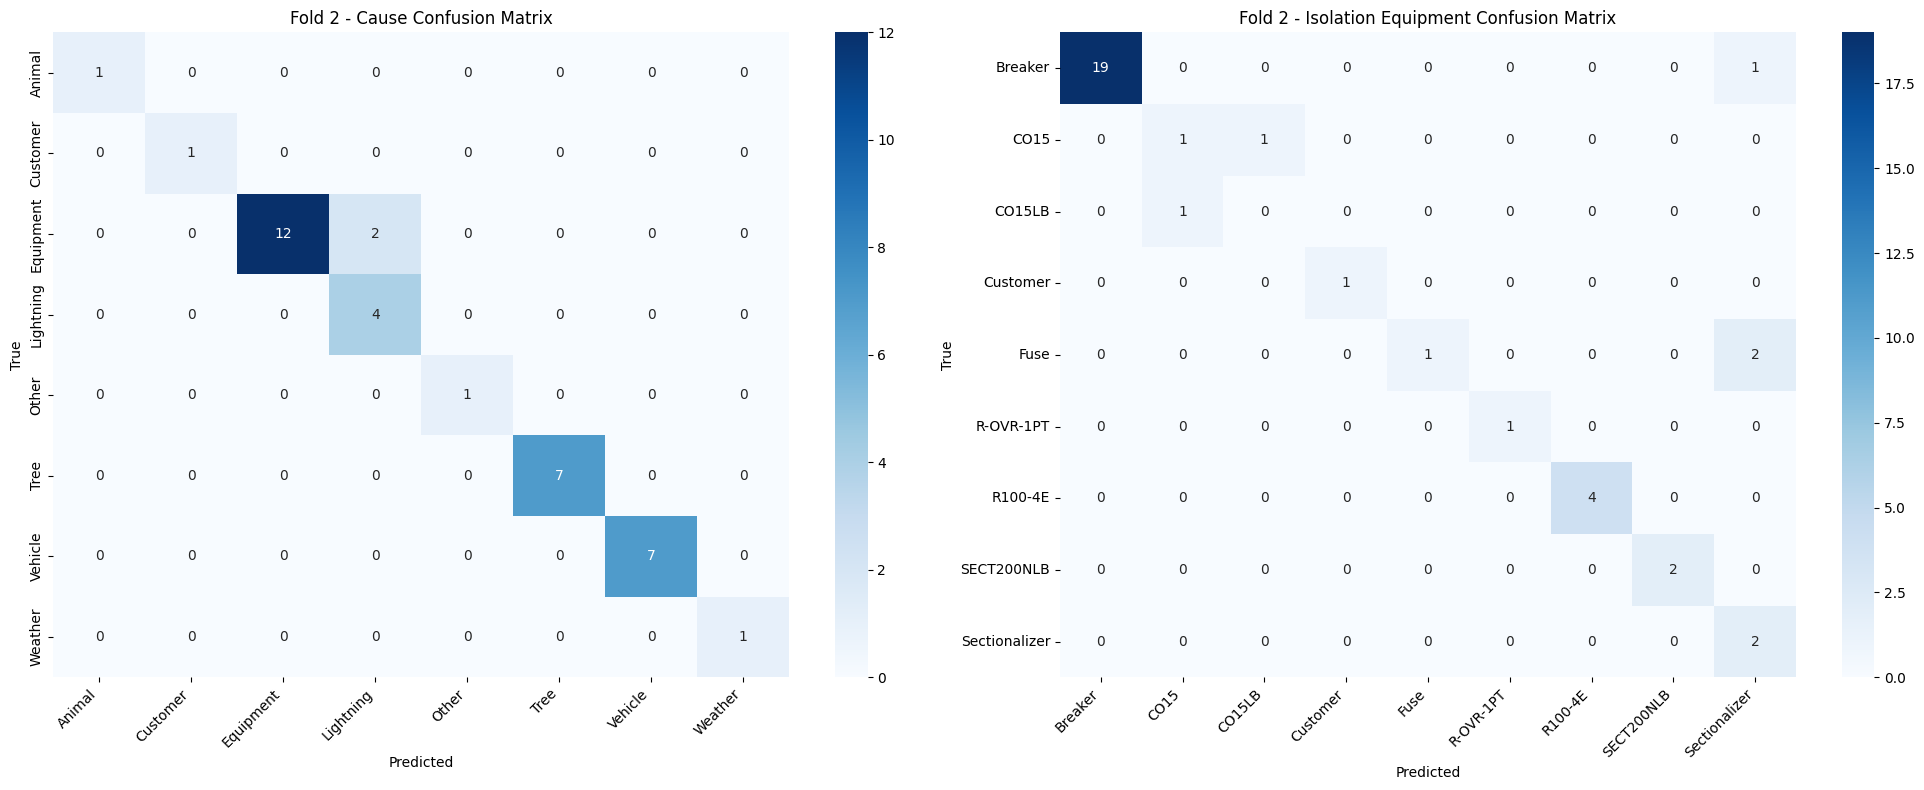


Classification Report - Cause (Fold 2):
              precision    recall  f1-score   support

      Animal       1.00      1.00      1.00         1
    Customer       1.00      1.00      1.00         1
   Equipment       1.00      0.86      0.92        14
   Lightning       0.67      1.00      0.80         4
       Other       1.00      1.00      1.00         1
        Tree       1.00      1.00      1.00         7
     Vehicle       1.00      1.00      1.00         7
     Weather       1.00      1.00      1.00         1

    accuracy                           0.94        36
   macro avg       0.96      0.98      0.97        36
weighted avg       0.96      0.94      0.95        36

Accuracy - Cause (Fold 2): 0.9444

Fold 3/5


Map: 100%|██████████| 36/36 [00:00<00:00, 3972.82 examples/s]
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at ./distilbert-pq-enhanced and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at ./distilbert-pq-enhanced and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\rmathew2020\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecate

Training Cause Model (Fold 3):


  3%|▎         | 18/540 [00:11<05:06,  1.71it/s]

{'loss': 1.5049, 'grad_norm': 5.420540809631348, 'learning_rate': 0.00019333333333333333, 'epoch': 1.0}



  3%|▎         | 18/540 [00:11<05:06,  1.71it/s]

{'eval_loss': 0.7674687504768372, 'eval_accuracy': 0.8611111111111112, 'eval_precision': 0.7870370370370371, 'eval_f1': 0.8157142857142856, 'eval_runtime': 0.4087, 'eval_samples_per_second': 88.077, 'eval_steps_per_second': 12.233, 'epoch': 1.0}


  7%|▋         | 36/540 [00:24<05:38,  1.49it/s]

{'loss': 0.4483, 'grad_norm': 1.201409935951233, 'learning_rate': 0.0001866666666666667, 'epoch': 2.0}



  7%|▋         | 36/540 [00:24<05:38,  1.49it/s]

{'eval_loss': 0.31865426898002625, 'eval_accuracy': 0.8888888888888888, 'eval_precision': 0.8314814814814816, 'eval_f1': 0.854074074074074, 'eval_runtime': 0.5322, 'eval_samples_per_second': 67.644, 'eval_steps_per_second': 9.395, 'epoch': 2.0}


 10%|█         | 54/540 [00:36<04:49,  1.68it/s]

{'loss': 0.1728, 'grad_norm': 0.06456553936004639, 'learning_rate': 0.00018, 'epoch': 3.0}



 10%|█         | 54/540 [00:37<04:49,  1.68it/s]

{'eval_loss': 0.1389416754245758, 'eval_accuracy': 0.9444444444444444, 'eval_precision': 0.90491452991453, 'eval_f1': 0.9218518518518519, 'eval_runtime': 0.4324, 'eval_samples_per_second': 83.257, 'eval_steps_per_second': 11.563, 'epoch': 3.0}


 13%|█▎        | 72/540 [00:49<04:37,  1.69it/s]

{'loss': 0.1055, 'grad_norm': 0.03275386244058609, 'learning_rate': 0.00017333333333333334, 'epoch': 4.0}



 13%|█▎        | 72/540 [00:49<04:37,  1.69it/s]

{'eval_loss': 0.09116491675376892, 'eval_accuracy': 0.9722222222222222, 'eval_precision': 0.9583333333333334, 'eval_f1': 0.9629629629629631, 'eval_runtime': 0.4522, 'eval_samples_per_second': 79.604, 'eval_steps_per_second': 11.056, 'epoch': 4.0}


 17%|█▋        | 90/540 [01:01<04:27,  1.68it/s]

{'loss': 0.0619, 'grad_norm': 0.03973613679409027, 'learning_rate': 0.0001666666666666667, 'epoch': 5.0}



 17%|█▋        | 90/540 [01:02<04:27,  1.68it/s]

{'eval_loss': 0.03629347309470177, 'eval_accuracy': 1.0, 'eval_precision': 1.0, 'eval_f1': 1.0, 'eval_runtime': 0.4168, 'eval_samples_per_second': 86.379, 'eval_steps_per_second': 11.997, 'epoch': 5.0}


 20%|██        | 108/540 [01:14<04:14,  1.70it/s]

{'loss': 0.0383, 'grad_norm': 0.025520622730255127, 'learning_rate': 0.00016, 'epoch': 6.0}



 20%|██        | 108/540 [01:14<04:14,  1.70it/s]

{'eval_loss': 0.012962975539267063, 'eval_accuracy': 1.0, 'eval_precision': 1.0, 'eval_f1': 1.0, 'eval_runtime': 0.4082, 'eval_samples_per_second': 88.189, 'eval_steps_per_second': 12.248, 'epoch': 6.0}


 23%|██▎       | 126/540 [01:26<04:07,  1.68it/s]

{'loss': 0.0157, 'grad_norm': 0.501349925994873, 'learning_rate': 0.00015333333333333334, 'epoch': 7.0}



 23%|██▎       | 126/540 [01:27<04:07,  1.68it/s]

{'eval_loss': 0.005226104520261288, 'eval_accuracy': 1.0, 'eval_precision': 1.0, 'eval_f1': 1.0, 'eval_runtime': 0.4113, 'eval_samples_per_second': 87.524, 'eval_steps_per_second': 12.156, 'epoch': 7.0}

Early stopping triggered! No accuracy improvement for 2 consecutive evaluations.
Best accuracy: 1.0000, Current accuracy: 1.0000
Accuracy history: ['0.8611', '0.8889', '0.9444', '0.9722', '1.0000', '1.0000', '1.0000']
Early stopping triggered at epoch 7


 23%|██▎       | 126/540 [01:28<04:50,  1.43it/s]


{'train_runtime': 88.3266, 'train_samples_per_second': 48.23, 'train_steps_per_second': 6.114, 'train_loss': 0.33534037191716454, 'epoch': 7.0}
Cause model trained for 7 epochs

Training Isolation Model (Fold 3):


  3%|▎         | 18/540 [00:11<05:07,  1.70it/s]

{'loss': 2.2205, 'grad_norm': 7.758635997772217, 'learning_rate': 0.00019333333333333333, 'epoch': 1.0}



  3%|▎         | 18/540 [00:11<05:07,  1.70it/s]

{'eval_loss': 1.721233606338501, 'eval_accuracy': 0.4444444444444444, 'eval_precision': 0.4024216524216524, 'eval_f1': 0.4101851851851852, 'eval_runtime': 0.3971, 'eval_samples_per_second': 90.653, 'eval_steps_per_second': 12.591, 'epoch': 1.0}


  7%|▋         | 36/540 [00:24<05:01,  1.67it/s]

{'loss': 1.6295, 'grad_norm': 5.751602649688721, 'learning_rate': 0.0001866666666666667, 'epoch': 2.0}



  7%|▋         | 36/540 [00:24<05:01,  1.67it/s]

{'eval_loss': 1.0864145755767822, 'eval_accuracy': 0.6666666666666666, 'eval_precision': 0.4825102880658436, 'eval_f1': 0.5580442102181232, 'eval_runtime': 0.3999, 'eval_samples_per_second': 90.03, 'eval_steps_per_second': 12.504, 'epoch': 2.0}


 10%|█         | 54/540 [00:36<04:53,  1.65it/s]

{'loss': 1.039, 'grad_norm': 5.16996955871582, 'learning_rate': 0.00018, 'epoch': 3.0}



 10%|█         | 54/540 [00:37<04:53,  1.65it/s]

{'eval_loss': 0.7561914920806885, 'eval_accuracy': 0.8055555555555556, 'eval_precision': 0.7400793650793651, 'eval_f1': 0.7620370370370371, 'eval_runtime': 0.4342, 'eval_samples_per_second': 82.909, 'eval_steps_per_second': 11.515, 'epoch': 3.0}


 13%|█▎        | 72/540 [00:49<04:38,  1.68it/s]

{'loss': 0.7146, 'grad_norm': 4.5441131591796875, 'learning_rate': 0.00017333333333333334, 'epoch': 4.0}



 13%|█▎        | 72/540 [00:49<04:38,  1.68it/s]

{'eval_loss': 0.38510942459106445, 'eval_accuracy': 0.8888888888888888, 'eval_precision': 0.9259259259259258, 'eval_f1': 0.9008591925258593, 'eval_runtime': 0.4685, 'eval_samples_per_second': 76.835, 'eval_steps_per_second': 10.671, 'epoch': 4.0}


 17%|█▋        | 90/540 [01:01<04:26,  1.69it/s]

{'loss': 0.4979, 'grad_norm': 2.691840648651123, 'learning_rate': 0.0001666666666666667, 'epoch': 5.0}



 17%|█▋        | 90/540 [01:02<04:26,  1.69it/s]

{'eval_loss': 0.4003317058086395, 'eval_accuracy': 0.9166666666666666, 'eval_precision': 0.9675925925925927, 'eval_f1': 0.930643143143143, 'eval_runtime': 0.4242, 'eval_samples_per_second': 84.874, 'eval_steps_per_second': 11.788, 'epoch': 5.0}


 20%|██        | 108/540 [01:14<04:11,  1.72it/s]

{'loss': 0.4648, 'grad_norm': 10.128533363342285, 'learning_rate': 0.00016, 'epoch': 6.0}



 20%|██        | 108/540 [01:14<04:11,  1.72it/s]

{'eval_loss': 0.48814657330513, 'eval_accuracy': 0.8611111111111112, 'eval_precision': 0.9675925925925927, 'eval_f1': 0.8970679012345679, 'eval_runtime': 0.3953, 'eval_samples_per_second': 91.071, 'eval_steps_per_second': 12.649, 'epoch': 6.0}


 23%|██▎       | 126/540 [01:27<04:08,  1.67it/s]

{'loss': 0.3227, 'grad_norm': 71.28890228271484, 'learning_rate': 0.00015333333333333334, 'epoch': 7.0}



 23%|██▎       | 126/540 [01:27<04:08,  1.67it/s]

{'eval_loss': 0.3229600191116333, 'eval_accuracy': 0.9166666666666666, 'eval_precision': 0.9861111111111112, 'eval_f1': 0.9417542542542543, 'eval_runtime': 0.4498, 'eval_samples_per_second': 80.041, 'eval_steps_per_second': 11.117, 'epoch': 7.0}

Early stopping triggered! No accuracy improvement for 2 consecutive evaluations.
Best accuracy: 0.9167, Current accuracy: 0.9167
Accuracy history: ['0.4444', '0.6667', '0.8056', '0.8889', '0.9167', '0.8611', '0.9167']
Early stopping triggered at epoch 7


 23%|██▎       | 126/540 [01:28<04:51,  1.42it/s]


{'train_runtime': 88.5737, 'train_samples_per_second': 48.096, 'train_steps_per_second': 6.097, 'train_loss': 0.9841402863699292, 'epoch': 7.0}
Isolation model trained for 7 epochs

Evaluating models (Fold 3):


100%|██████████| 5/5 [00:00<00:00, 14.23it/s]



Fold 3 Times:
Training time: 0:02:57
Evaluation time: 0:00:00
Total time: 0:02:58

Fold 3 Results:
Cause - Accuracy: 1.0000, Precision: 1.0000, F1: 1.0000
Isolation - Accuracy: 0.9167, Precision: 0.9676, F1: 0.9306


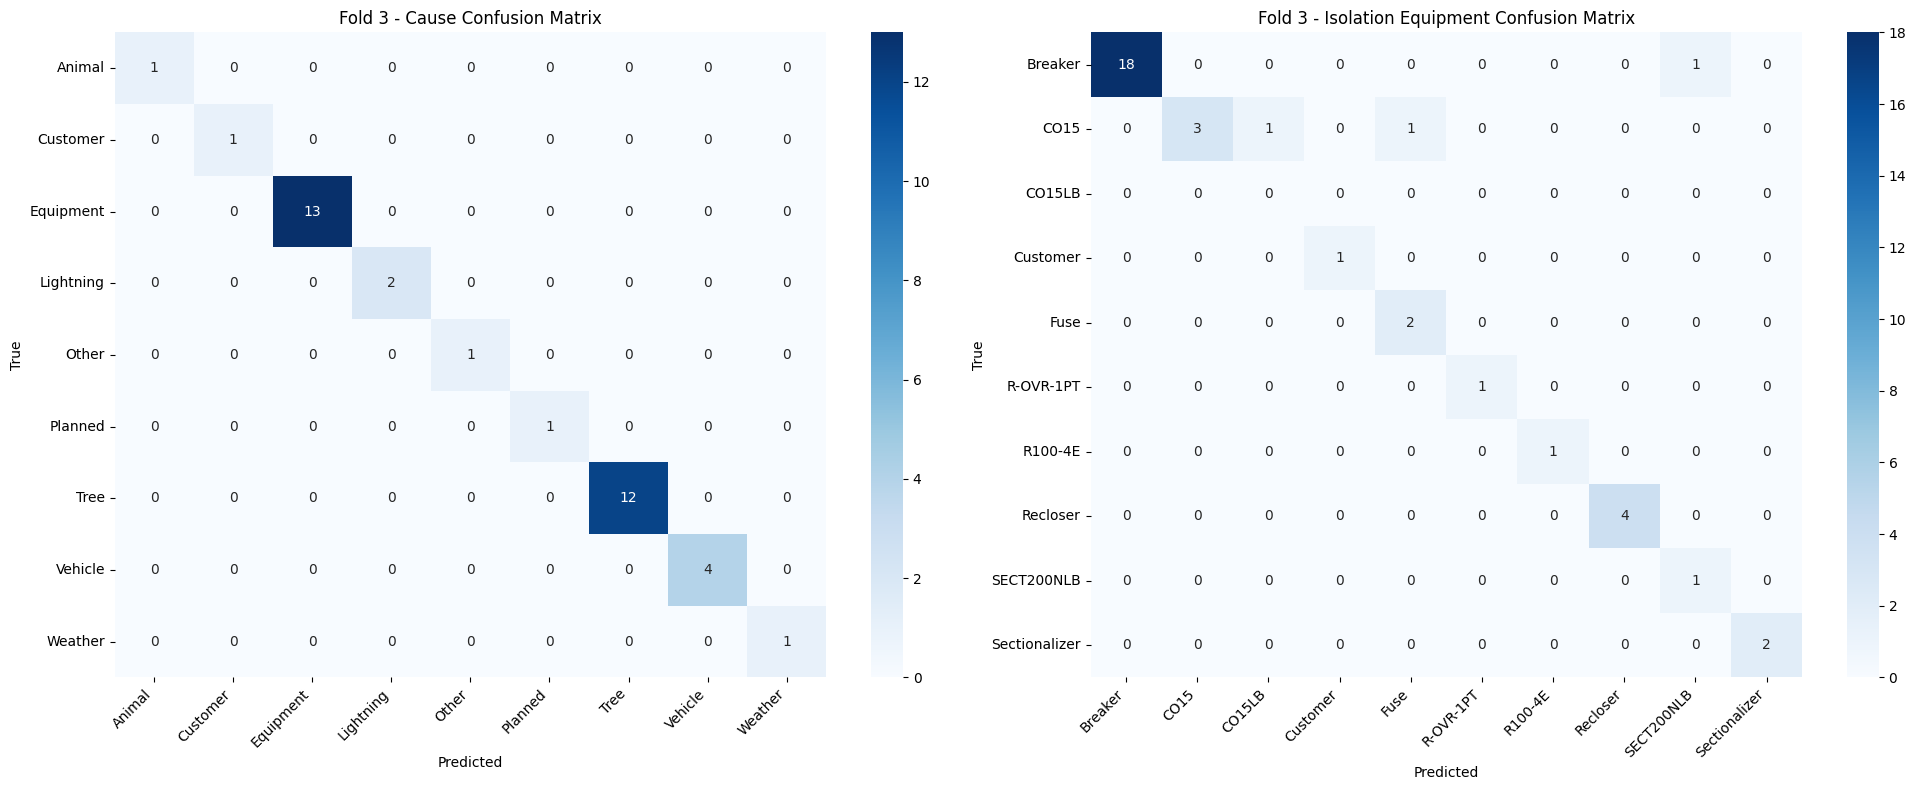


Classification Report - Cause (Fold 3):
              precision    recall  f1-score   support

      Animal       1.00      1.00      1.00         1
    Customer       1.00      1.00      1.00         1
   Equipment       1.00      1.00      1.00        13
   Lightning       1.00      1.00      1.00         2
       Other       1.00      1.00      1.00         1
     Planned       1.00      1.00      1.00         1
        Tree       1.00      1.00      1.00        12
     Vehicle       1.00      1.00      1.00         4
     Weather       1.00      1.00      1.00         1

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36

Accuracy - Cause (Fold 3): 1.0000

Fold 4/5


Map: 100%|██████████| 35/35 [00:00<00:00, 5835.15 examples/s]
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at ./distilbert-pq-enhanced and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at ./distilbert-pq-enhanced and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\rmathew2020\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecate

Training Cause Model (Fold 4):


  3%|▎         | 18/540 [00:11<05:10,  1.68it/s]

{'loss': 1.4629, 'grad_norm': 4.584188461303711, 'learning_rate': 0.00019333333333333333, 'epoch': 1.0}



  3%|▎         | 18/540 [00:11<05:10,  1.68it/s]

{'eval_loss': 0.800665557384491, 'eval_accuracy': 0.7428571428571429, 'eval_precision': 0.5756462585034013, 'eval_f1': 0.6419283502874833, 'eval_runtime': 0.3954, 'eval_samples_per_second': 88.518, 'eval_steps_per_second': 12.645, 'epoch': 1.0}


  7%|▋         | 36/540 [00:23<05:03,  1.66it/s]

{'loss': 0.4691, 'grad_norm': 1.191834568977356, 'learning_rate': 0.0001866666666666667, 'epoch': 2.0}



  7%|▋         | 36/540 [00:23<05:03,  1.66it/s]

{'eval_loss': 0.5122435688972473, 'eval_accuracy': 0.9428571428571428, 'eval_precision': 0.8933333333333333, 'eval_f1': 0.9163265306122449, 'eval_runtime': 0.4167, 'eval_samples_per_second': 84.0, 'eval_steps_per_second': 12.0, 'epoch': 2.0}


 10%|█         | 54/540 [00:35<04:49,  1.68it/s]

{'loss': 0.2311, 'grad_norm': 1.6062380075454712, 'learning_rate': 0.00018, 'epoch': 3.0}



 10%|█         | 54/540 [00:36<04:49,  1.68it/s]

{'eval_loss': 0.4763794541358948, 'eval_accuracy': 0.9142857142857143, 'eval_precision': 0.8653061224489795, 'eval_f1': 0.8884004884004884, 'eval_runtime': 0.3878, 'eval_samples_per_second': 90.257, 'eval_steps_per_second': 12.894, 'epoch': 3.0}


 13%|█▎        | 72/540 [00:48<04:36,  1.69it/s]

{'loss': 0.0782, 'grad_norm': 0.1682865023612976, 'learning_rate': 0.00017333333333333334, 'epoch': 4.0}



 13%|█▎        | 72/540 [00:48<04:36,  1.69it/s]

{'eval_loss': 0.6192114949226379, 'eval_accuracy': 0.9142857142857143, 'eval_precision': 0.8732142857142857, 'eval_f1': 0.8893074471167777, 'eval_runtime': 0.3973, 'eval_samples_per_second': 88.09, 'eval_steps_per_second': 12.584, 'epoch': 4.0}

Early stopping triggered! No accuracy improvement for 2 consecutive evaluations.
Best accuracy: 0.9429, Current accuracy: 0.9143
Accuracy history: ['0.7429', '0.9429', '0.9143', '0.9143']
Early stopping triggered at epoch 4


 13%|█▎        | 72/540 [00:49<05:22,  1.45it/s]


{'train_runtime': 49.6267, 'train_samples_per_second': 86.445, 'train_steps_per_second': 10.881, 'train_loss': 0.5603322585423788, 'epoch': 4.0}
Cause model trained for 4 epochs

Training Isolation Model (Fold 4):


  3%|▎         | 18/540 [00:11<05:09,  1.69it/s]

{'loss': 1.9829, 'grad_norm': 4.968334674835205, 'learning_rate': 0.00019333333333333333, 'epoch': 1.0}



  3%|▎         | 18/540 [00:12<05:09,  1.69it/s]

{'eval_loss': 2.0879738330841064, 'eval_accuracy': 0.2857142857142857, 'eval_precision': 0.379047619047619, 'eval_f1': 0.24278388278388277, 'eval_runtime': 0.4237, 'eval_samples_per_second': 82.597, 'eval_steps_per_second': 11.8, 'epoch': 1.0}


  7%|▋         | 36/540 [00:24<05:03,  1.66it/s]

{'loss': 1.2483, 'grad_norm': 5.011490345001221, 'learning_rate': 0.0001866666666666667, 'epoch': 2.0}



  7%|▋         | 36/540 [00:24<05:03,  1.66it/s]

{'eval_loss': 1.164320945739746, 'eval_accuracy': 0.7142857142857143, 'eval_precision': 0.6247619047619047, 'eval_f1': 0.6404238618524334, 'eval_runtime': 0.3978, 'eval_samples_per_second': 87.99, 'eval_steps_per_second': 12.57, 'epoch': 2.0}


 10%|█         | 54/540 [00:37<04:50,  1.67it/s]

{'loss': 0.74, 'grad_norm': 4.7432708740234375, 'learning_rate': 0.00018, 'epoch': 3.0}



 10%|█         | 54/540 [00:37<04:50,  1.67it/s]

{'eval_loss': 0.8844902515411377, 'eval_accuracy': 0.7714285714285715, 'eval_precision': 0.7889285714285714, 'eval_f1': 0.7305744520030234, 'eval_runtime': 0.4118, 'eval_samples_per_second': 85.001, 'eval_steps_per_second': 12.143, 'epoch': 3.0}


 13%|█▎        | 72/540 [00:49<04:58,  1.57it/s]

{'loss': 0.4959, 'grad_norm': 3.1201467514038086, 'learning_rate': 0.00017333333333333334, 'epoch': 4.0}



 13%|█▎        | 72/540 [00:50<04:58,  1.57it/s]

{'eval_loss': 0.7583630681037903, 'eval_accuracy': 0.8, 'eval_precision': 0.7840816326530612, 'eval_f1': 0.7673877551020408, 'eval_runtime': 0.4497, 'eval_samples_per_second': 77.827, 'eval_steps_per_second': 11.118, 'epoch': 4.0}


 17%|█▋        | 90/540 [01:02<04:33,  1.64it/s]

{'loss': 0.3696, 'grad_norm': 2.3344807624816895, 'learning_rate': 0.0001666666666666667, 'epoch': 5.0}



 17%|█▋        | 90/540 [01:03<04:33,  1.64it/s]

{'eval_loss': 0.7672252058982849, 'eval_accuracy': 0.8, 'eval_precision': 0.8069387755102041, 'eval_f1': 0.7673877551020408, 'eval_runtime': 0.3813, 'eval_samples_per_second': 91.8, 'eval_steps_per_second': 13.114, 'epoch': 5.0}


 20%|██        | 108/540 [01:15<04:23,  1.64it/s]

{'loss': 0.3437, 'grad_norm': 4.9213738441467285, 'learning_rate': 0.00016, 'epoch': 6.0}



 20%|██        | 108/540 [01:15<04:23,  1.64it/s]

{'eval_loss': 0.7000462412834167, 'eval_accuracy': 0.7714285714285715, 'eval_precision': 0.7533333333333333, 'eval_f1': 0.7410361067503926, 'eval_runtime': 0.4046, 'eval_samples_per_second': 86.498, 'eval_steps_per_second': 12.357, 'epoch': 6.0}

Early stopping triggered! No accuracy improvement for 2 consecutive evaluations.
Best accuracy: 0.8000, Current accuracy: 0.7714
Accuracy history: ['0.2857', '0.7143', '0.7714', '0.8000', '0.8000', '0.7714']
Early stopping triggered at epoch 6


 20%|██        | 108/540 [01:16<05:07,  1.40it/s]


{'train_runtime': 76.9145, 'train_samples_per_second': 55.776, 'train_steps_per_second': 7.021, 'train_loss': 0.8633943310490361, 'epoch': 6.0}
Isolation model trained for 6 epochs

Evaluating models (Fold 4):


100%|██████████| 5/5 [00:00<00:00, 16.04it/s]



Fold 4 Times:
Training time: 0:02:07
Evaluation time: 0:00:00
Total time: 0:02:08

Fold 4 Results:
Cause - Accuracy: 0.9429, Precision: 0.8933, F1: 0.9163
Isolation - Accuracy: 0.8000, Precision: 0.7841, F1: 0.7674


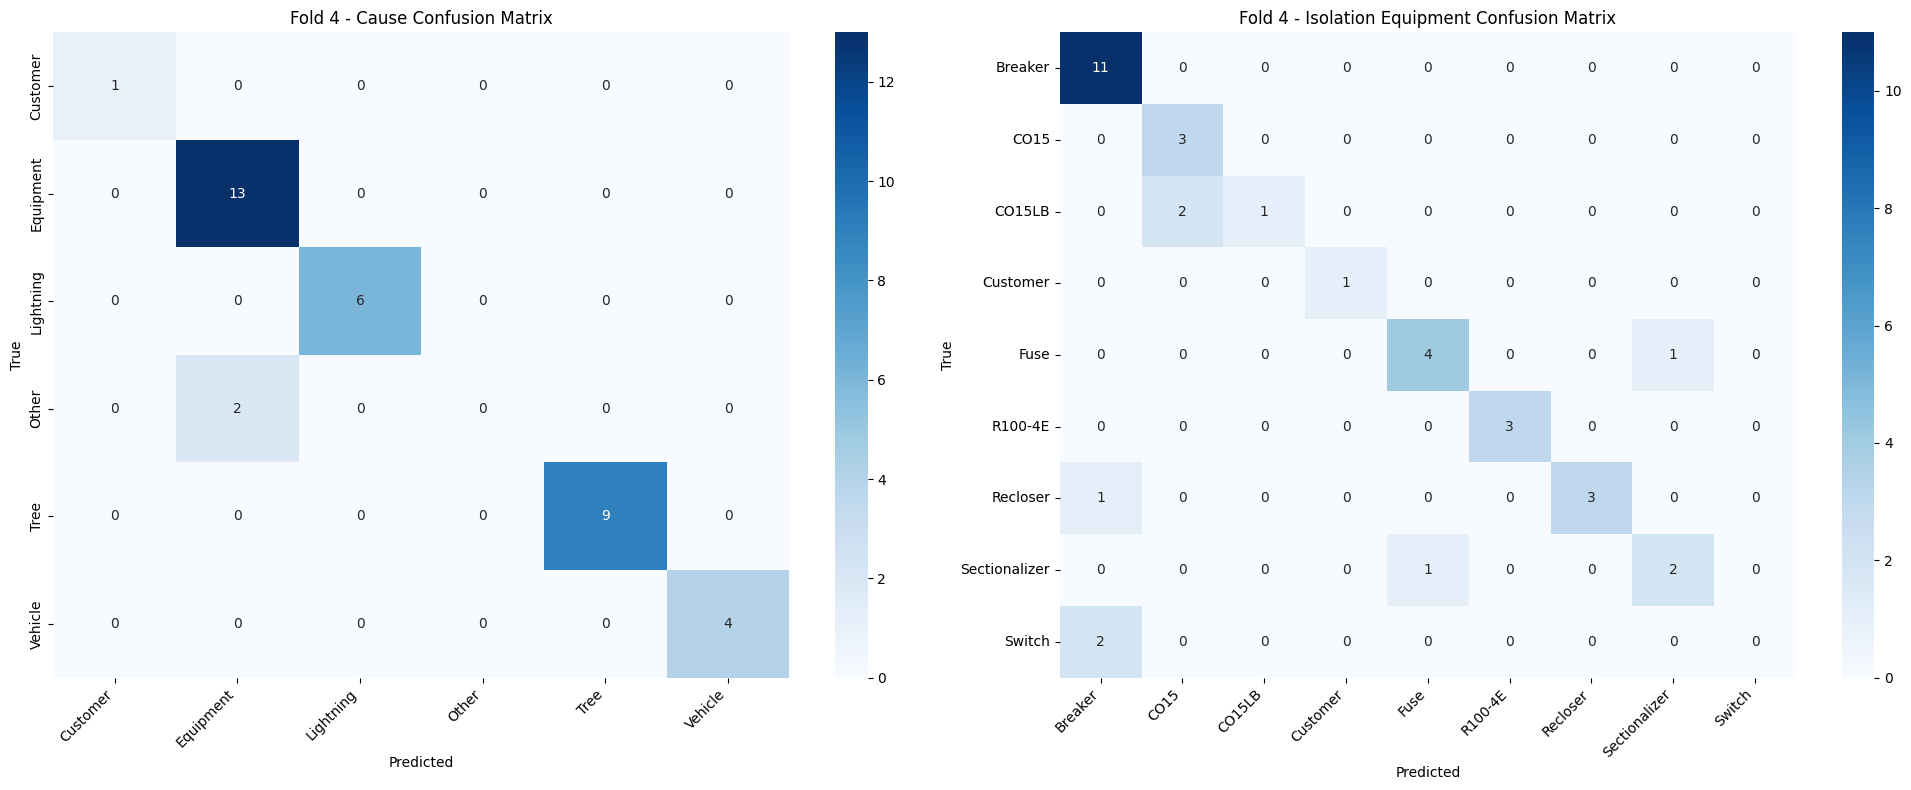


Classification Report - Cause (Fold 4):
              precision    recall  f1-score   support

    Customer       1.00      1.00      1.00         1
   Equipment       0.87      1.00      0.93        13
   Lightning       1.00      1.00      1.00         6
       Other       0.00      0.00      0.00         2
        Tree       1.00      1.00      1.00         9
     Vehicle       1.00      1.00      1.00         4

    accuracy                           0.94        35
   macro avg       0.81      0.83      0.82        35
weighted avg       0.89      0.94      0.92        35

Accuracy - Cause (Fold 4): 0.9429

Fold 5/5


Map: 100%|██████████| 35/35 [00:00<00:00, 6284.81 examples/s]
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at ./distilbert-pq-enhanced and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at ./distilbert-pq-enhanced and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training Cause Model (Fold 5):

C:\Users\rmathew2020\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\rmathew2020\AppData\Local\Temp\ipykernel_18268\2356168886.py:400: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `EarlyStoppingTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


  3%|▎         | 18/540 [00:10<04:57,  1.76it/s]

{'loss': 1.333, 'grad_norm': 4.013787269592285, 'learning_rate': 0.00019333333333333333, 'epoch': 1.0}



  3%|▎         | 18/540 [00:11<04:57,  1.76it/s]

{'eval_loss': 0.7189149260520935, 'eval_accuracy': 0.8571428571428571, 'eval_precision': 0.7968253968253969, 'eval_f1': 0.8166666666666668, 'eval_runtime': 0.5224, 'eval_samples_per_second': 67.002, 'eval_steps_per_second': 9.572, 'epoch': 1.0}


RuntimeError: [enforce fail at inline_container.cc:603] . unexpected pos 462605632 vs 462605520

In [4]:
import numpy as np
import pandas as pd
import time
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, accuracy_score
from transformers import AutoModelForSequenceClassification, AutoTokenizer, TrainingArguments, Trainer, DataCollatorWithPadding
import torch
import evaluate
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from datasets import Dataset
import os
from datetime import timedelta

# Set parameters
data_path = "PQEvents_Ticket_csv.csv"
text_column_name = "Details"
label_column_name = "Cause"

model_name = "distilbert-base-uncased"
test_size = 0.2
num_labels = 2
n_splits = 5  # Number of folds for K-fold cross-validation
adaptation_path = "./distilbert-pq-enhanced"
max_epochs = 30  # Maximum number of epochs
early_stopping_patience = 2  # Number of epochs with no improvement after which training will stop
early_stopping_threshold = 0.001  # Minimum change to qualify as an improvement

# Create directory for results
os.makedirs("./resultsManyTxt", exist_ok=True)

# Load and preprocess data
df = pd.read_csv(data_path)

# First, clean up Cause column
df = df[~df['Cause'].isin(['Unknown', 'Undetermined'])]  # Remove rows with these values in Cause column 
df['Cause'] = df['Cause'].replace(['Customer Request', 'Customer Caused'], 'Customer')

# Replace Unknown/Undetermined in Isolation Equipment Code
df['Isolation Equipment Code'] = df['Isolation Equipment Code'].replace(['Unknown', 'Undetermined'], np.nan)

# Only drop rows where Cause is NaN
df = df.dropna(subset=['Cause'])

# If 'Cause' is 'Customer' and 'Isolation Equipment Code' is NaN, set 'Isolation Equipment Code' to 'Customer'
df.loc[(df['Cause'] == 'Customer') & (df['Isolation Equipment Code'].isna()), 'Isolation Equipment Code'] = 'Customer'

# Drop rows where 'Isolation Equipment Code' is NaN, but only for causes other than 'Customer'
df = df.dropna(subset=['Isolation Equipment Code'])

# Keep only rows where 'Details' is a string
df = df[df['Details'].apply(lambda x: isinstance(x, str))]

# Function to clean text data
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    return text

# Apply text cleaning
df['Details'] = df['Details'].apply(clean_text)

# Print distributions
print("\nUnique Cause Classes with Counts:")
print("-" * 40)
cause_unique = df['Cause'].value_counts()
for cause, count in cause_unique.items():
    print(f"{cause:<20} {count:>5}")

print("\nIsolation Equipment Codes for Customer causes:")
print(df[df['Cause'] == 'Customer']['Isolation Equipment Code'].value_counts(dropna=False))

print(f"\nDataset shape: {df.shape}")

# Create label encoders
le_cause = preprocessing.LabelEncoder()
le_isolation = preprocessing.LabelEncoder()

# Fit both encoders
le_cause.fit(df[label_column_name].tolist())
le_isolation.fit(df['Isolation Equipment Code'].tolist())

# Transform labels
df['cause_label'] = le_cause.transform(df[label_column_name].tolist())
df['isolation_label'] = le_isolation.transform(df['Isolation Equipment Code'].tolist())

# Print out the labels with their corresponding encoded values
label_mapping = dict(zip(le_cause.classes_, le_cause.transform(le_cause.classes_)))
print("Cause Label Mapping:")
for label, encoded_value in label_mapping.items():
    print(f"{label}: {encoded_value}")

print()

# Print out the labels with their corresponding encoded values
label_mapping = dict(zip(le_isolation.classes_, le_isolation.transform(le_isolation.classes_)))
print("Isolation Equipment Label Mapping:")
for label, encoded_value in label_mapping.items():
    print(f"{label}: {encoded_value}")

df['text_cleaned'] = df[text_column_name]

# Count the number of data points for each cause
cause_counts = df[label_column_name].value_counts()
code_counts = df['Isolation Equipment Code'].value_counts()

# Print the counts
print("\nCause counts:")
print(cause_counts)
print("\nIsolation Equipment Code counts:")
print(code_counts)

# Initialize KFold cross-validator
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Preprocessing functions
def preprocess_function_cause(examples):
    tokenized = tokenizer(examples["text"], truncation=True, padding=True)
    tokenized["labels"] = examples["cause_label"]
    return tokenized

def preprocess_function_isolation(examples):
    tokenized = tokenizer(examples["text"], truncation=True, padding=True)
    tokenized["labels"] = examples["isolation_label"]
    return tokenized

# Initialize data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Metrics
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    
    # Calculate multiple metrics
    accuracy = accuracy_score(labels, predictions)
    precision = precision_score(labels, predictions, average='weighted', zero_division=0)
    f1 = f1_score(labels, predictions, average='weighted', zero_division=0)
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'f1': f1
    }

# Custom callback for early stopping based on validation accuracy
class EarlyStoppingCallback:
    def __init__(self, patience=early_stopping_patience, threshold=early_stopping_threshold):
        self.patience = patience
        self.threshold = threshold
        self.best_accuracy = 0
        self.no_improvement_count = 0
        self.should_stop = False
        self.accuracies = []

    def on_evaluate(self, args, state, control, metrics):
        current_accuracy = metrics.get("eval_accuracy", 0)
        self.accuracies.append(current_accuracy)
        
        # Check if improvement
        if current_accuracy > self.best_accuracy + self.threshold:
            self.best_accuracy = current_accuracy
            self.no_improvement_count = 0
        else:
            self.no_improvement_count += 1
            
        # Check if we should stop
        if self.no_improvement_count >= self.patience:
            self.should_stop = True
            control.should_training_stop = True
            print(f"\nEarly stopping triggered! No accuracy improvement for {self.patience} consecutive evaluations.")
            print(f"Best accuracy: {self.best_accuracy:.4f}, Current accuracy: {current_accuracy:.4f}")
            print(f"Accuracy history: {[f'{acc:.4f}' for acc in self.accuracies]}")

    def check_if_should_stop(self):
        return self.should_stop

# Function to plot training metrics
def plot_training_metrics(cause_trainer, isolation_trainer, fold=None):
    """Plot training and validation metrics from both trainers"""
    
    # Get training histories
    cause_history = cause_trainer.state.log_history
    isolation_history = isolation_trainer.state.log_history
    
    # Extract metrics
    cause_train_loss = []
    cause_eval_loss = []
    isolation_train_loss = []
    isolation_eval_loss = []
    cause_accuracy = []
    isolation_accuracy = []
    cause_epochs = []
    isolation_epochs = []
    
    # Process cause trainer history
    for entry in cause_history:
        if 'loss' in entry and 'epoch' in entry and 'eval_loss' not in entry:
            cause_train_loss.append(entry['loss'])
            cause_epochs.append(entry['epoch'])
        if 'eval_loss' in entry:
            cause_eval_loss.append(entry['eval_loss'])
            cause_accuracy.append(entry['eval_accuracy'])
    
    # Process isolation trainer history
    for entry in isolation_history:
        if 'loss' in entry and 'epoch' in entry and 'eval_loss' not in entry:
            isolation_train_loss.append(entry['loss'])
            isolation_epochs.append(entry['epoch'])
        if 'eval_loss' in entry:
            isolation_eval_loss.append(entry['eval_loss'])
            isolation_accuracy.append(entry['eval_accuracy'])
    
    fold_title = f" (Fold {fold})" if fold is not None else ""
    
    # Plot accuracies
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(cause_accuracy)), cause_accuracy, label='Cause Validation Accuracy')
    plt.plot(range(len(isolation_accuracy)), isolation_accuracy, label='Isolation Validation Accuracy') 
    plt.title(f'Model Accuracies{fold_title}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.savefig(f"./resultsManyTxt/fold_{fold}_accuracies.png")
    plt.close()
    
    # Plot losses - separately for each model to avoid dimension mismatch
    plt.figure(figsize=(12, 6))
    
    # Cause model losses
    plt.plot(cause_epochs, cause_train_loss, label='Cause Training Loss')
    plt.plot(range(len(cause_eval_loss)), cause_eval_loss, label='Cause Validation Loss')
    
    # Isolation model losses
    plt.plot(isolation_epochs, isolation_train_loss, label='Isolation Training Loss')
    plt.plot(range(len(isolation_eval_loss)), isolation_eval_loss, label='Isolation Validation Loss')
    
    plt.title(f'Model Losses{fold_title}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.savefig(f"./resultsManyTxt/fold_{fold}_losses.png")
    plt.close()

# Function to create confusion matrices
def plot_confusion_matrices(true_labels, predicted_labels, label_encoder, title_prefix="", ax=None):
    """Plot confusion matrix for given true and predicted labels"""
    
    # Get unique labels present in data
    unique_labels = np.unique(np.concatenate([true_labels, predicted_labels]))
    class_names = label_encoder.classes_[unique_labels]
    
    # Create confusion matrix
    conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=unique_labels)
    
    # Plot
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))
    
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names,
                ax=ax)
    ax.set_title(f'{title_prefix} Confusion Matrix')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    
    return conf_matrix

# Function to classify text
def classify_text(text, cause_model, isolation_model, tokenizer):
    """Classify text using the trained cause and isolation models"""
    
    # Clean and preprocess input text
    cleaned_text = clean_text(text)
    
    # Tokenize the cleaned text
    inputs = tokenizer(cleaned_text, 
                      return_tensors="pt",
                      truncation=True, 
                      padding=True)
    
    # Get predictions from both models
    with torch.no_grad():
        cause_outputs = cause_model(**inputs)
        isolation_outputs = isolation_model(**inputs)
    
    # Get predicted classes
    cause_class = torch.argmax(cause_outputs.logits, dim=-1)
    isolation_class = torch.argmax(isolation_outputs.logits, dim=-1)
    
    # Map predictions to labels
    predicted_cause = le_cause.inverse_transform([cause_class.item()])[0]
    predicted_isolation = le_isolation.inverse_transform([isolation_class.item()])[0]
    
    return predicted_cause, predicted_isolation

# Lists to store results across folds
cause_accuracies = []
cause_precisions = []
cause_f1_scores = []
isolation_accuracies = []
isolation_precisions = []
isolation_f1_scores = []
fold_times = []
cause_epochs_trained = []
isolation_epochs_trained = []


# Run K-fold cross-validation
for fold, (train_idx, test_idx) in enumerate(kf.split(df)):
    print(f"\n{'='*80}\nFold {fold+1}/{n_splits}\n{'='*80}")
    
    # Split data for this fold
    df_train = df.iloc[train_idx]
    df_test = df.iloc[test_idx]
    
    # Create datasets
    train_dataset = Dataset.from_dict({
        'text': df_train['text_cleaned'],
        'cause_label': df_train['cause_label'],
        'isolation_label': df_train['isolation_label']
    })

    test_dataset = Dataset.from_dict({
        'text': df_test['text_cleaned'], 
        'cause_label': df_test['cause_label'],
        'isolation_label': df_test['isolation_label']
    })
    
    # Tokenize datasets
    tokenized_train_cause = train_dataset.map(
        preprocess_function_cause,
        batched=True,
        remove_columns=train_dataset.column_names
    )

    tokenized_test_cause = test_dataset.map(
        preprocess_function_cause,
        batched=True,
        remove_columns=test_dataset.column_names
    )

    tokenized_train_isolation = train_dataset.map(
        preprocess_function_isolation,
        batched=True,
        remove_columns=train_dataset.column_names
    )

    tokenized_test_isolation = test_dataset.map(
        preprocess_function_isolation,
        batched=True,
        remove_columns=test_dataset.column_names
    )
    
    # Create models for this fold
    cause_model = AutoModelForSequenceClassification.from_pretrained(
        adaptation_path, 
        num_labels=len(le_cause.classes_)
    )

    isolation_model = AutoModelForSequenceClassification.from_pretrained(
        adaptation_path,
        num_labels=len(le_isolation.classes_)
    )

        # Initialize early stopping callbacks
    cause_early_stopping = EarlyStoppingCallback()
    isolation_early_stopping = EarlyStoppingCallback()
    
    # Training arguments
    training_args = TrainingArguments(
        output_dir=f"./resultsManyTxt/fold_{fold+1}",
        learning_rate=2e-4,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        num_train_epochs=max_epochs,  # Maximum number of epochs
        weight_decay=0.01,
        evaluation_strategy="epoch",
        logging_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="accuracy",
    )
    
   # Define a custom callback to check early stopping after each evaluation
    class EarlyStoppingTrainer(Trainer):
        def __init__(self, early_stopping_callback=None, *args, **kwargs):
            super().__init__(*args, **kwargs)
            self.early_stopping_callback = early_stopping_callback
            self.epochs_trained = 0
            
        def evaluate(self, *args, **kwargs):
            metrics = super().evaluate(*args, **kwargs)
            
            # Update epochs trained counter
            self.epochs_trained += 1
            
            # Call early stopping callback with metrics
            if self.early_stopping_callback:
                self.early_stopping_callback.on_evaluate(self.args, self.state, self.control, metrics)
                
                # Check if training should stop
                if self.early_stopping_callback.check_if_should_stop():
                    print(f"Early stopping triggered at epoch {self.epochs_trained}")
                    self.control.should_training_stop = True
                    
            return metrics
    
    # Create trainers with early stopping
    cause_trainer = EarlyStoppingTrainer(
        early_stopping_callback=cause_early_stopping,
        model=cause_model,
        args=training_args,
        train_dataset=tokenized_train_cause,
        eval_dataset=tokenized_test_cause,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics
    )

    isolation_trainer = EarlyStoppingTrainer(
        early_stopping_callback=isolation_early_stopping,
        model=isolation_model,
        args=training_args,
        train_dataset=tokenized_train_isolation,
        eval_dataset=tokenized_test_isolation,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics
    )
    
    # Start timing for training
    start_time = time.time()
    
    # Train the models
    print(f"Training Cause Model (Fold {fold+1}):")
    cause_trainer.train()
    cause_epochs_trained.append(cause_trainer.epochs_trained)
    print(f"Cause model trained for {cause_trainer.epochs_trained} epochs")
    
    print(f"\nTraining Isolation Model (Fold {fold+1}):")
    isolation_trainer.train()
    isolation_epochs_trained.append(isolation_trainer.epochs_trained)
    print(f"Isolation model trained for {isolation_trainer.epochs_trained} epochs")
    
    # End timing for training
    train_end_time = time.time()
    training_time = train_end_time - start_time
    
    # Plot training metrics for this fold
    plot_training_metrics(cause_trainer, isolation_trainer, fold+1)
    
    # Start timing for evaluation
    eval_start_time = time.time()
    
    # Evaluate on test set
    print(f"\nEvaluating models (Fold {fold+1}):")
    
    # Get predictions for both models on test set
    cause_predictions = cause_trainer.predict(tokenized_test_cause)
    isolation_predictions = isolation_trainer.predict(tokenized_test_isolation)
    
    # End timing for evaluation
    eval_end_time = time.time()
    eval_time = eval_end_time - eval_start_time
    
    # Total time for this fold
    fold_total_time = training_time + eval_time
    fold_times.append(fold_total_time)
    
    print(f"\nFold {fold+1} Times:")
    print(f"Training time: {timedelta(seconds=int(training_time))}")
    print(f"Evaluation time: {timedelta(seconds=int(eval_time))}")
    print(f"Total time: {timedelta(seconds=int(fold_total_time))}")
    
    # Extract predictions
    cause_preds = np.argmax(cause_predictions.predictions, axis=1)
    isolation_preds = np.argmax(isolation_predictions.predictions, axis=1)
    
    # Get ground truth values
    cause_true = df_test['cause_label'].values
    isolation_true = df_test['isolation_label'].values
    
    # Calculate metrics
    cause_accuracy = accuracy_score(cause_true, cause_preds)
    cause_precision = precision_score(cause_true, cause_preds, average='weighted', zero_division=0)
    cause_f1 = f1_score(cause_true, cause_preds, average='weighted', zero_division=0)
    
    isolation_accuracy = accuracy_score(isolation_true, isolation_preds)
    isolation_precision = precision_score(isolation_true, isolation_preds, average='weighted', zero_division=0)
    isolation_f1 = f1_score(isolation_true, isolation_preds, average='weighted', zero_division=0)
    
    # Store metrics
    cause_accuracies.append(cause_accuracy)
    cause_precisions.append(cause_precision)
    cause_f1_scores.append(cause_f1)
    isolation_accuracies.append(isolation_accuracy)
    isolation_precisions.append(isolation_precision)
    isolation_f1_scores.append(isolation_f1)
    
    # Print metrics for this fold
    print(f"\nFold {fold+1} Results:")
    print(f"Cause - Accuracy: {cause_accuracy:.4f}, Precision: {cause_precision:.4f}, F1: {cause_f1:.4f}")
    print(f"Isolation - Accuracy: {isolation_accuracy:.4f}, Precision: {isolation_precision:.4f}, F1: {isolation_f1:.4f}")
    
    # Create confusion matrices
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    plot_confusion_matrices(cause_true, cause_preds, le_cause, f"Fold {fold+1} - Cause", ax1)
    plot_confusion_matrices(isolation_true, isolation_preds, le_isolation, f"Fold {fold+1} - Isolation Equipment", ax2)
    
    plt.tight_layout()
    plt.savefig(f"./resultsManyTxt/fold_{fold+1}_confusion_matrices.png")
    plt.show()
    plt.close()
    
    # Get unique labels present in test data for classification report
    unique_cause_labels = np.unique(np.concatenate([cause_true, cause_preds]))
    unique_isolation_labels = np.unique(np.concatenate([isolation_true, isolation_preds]))

    # Get class names for present labels
    cause_class_names = le_cause.classes_[unique_cause_labels]
    isolation_class_names = le_isolation.classes_[unique_isolation_labels]
    
    # Print classification reports
    print(f"\nClassification Report - Cause (Fold {fold+1}):")
    print(classification_report(
        cause_true, cause_preds,
        labels=unique_cause_labels,
        target_names=cause_class_names,
        zero_division=0
    ))
    print(f"Accuracy - Cause (Fold {fold+1}): {accuracy_score(cause_true, cause_preds):.4f}")

    # print(f"\nClassification Report - Isolation Equipment (Fold {fold+1}):")
    # print(classification_report(
    #     isolation_true, isolation_preds,
    #     labels=unique_isolation_labels,
    #     target_names=isolation_class_names,
    #     zero_division=0
    # ))
    # print(f"Accuracy - Isolation Equipment (Fold {fold+1}): {accuracy_score(isolation_true, isolation_preds):.4f}")


# Print average results across all folds
print("\n" + "="*80)
print("AVERAGE RESULTS ACROSS ALL FOLDS")
print("="*80)

print(f"Cause - Avg Accuracy: {np.mean(cause_accuracies):.4f} ± {np.std(cause_accuracies):.4f}")
print(f"Cause - Avg Precision: {np.mean(cause_precisions):.4f} ± {np.std(cause_precisions):.4f}")
print(f"Cause - Avg F1: {np.mean(cause_f1_scores):.4f} ± {np.std(cause_f1_scores):.4f}")
print(f"Cause - Avg Epochs Trained: {np.mean(cause_epochs_trained):.2f} ± {np.std(cause_epochs_trained):.2f}")

print(f"Isolation - Avg Accuracy: {np.mean(isolation_accuracies):.4f} ± {np.std(isolation_accuracies):.4f}")
print(f"Isolation - Avg Precision: {np.mean(isolation_precisions):.4f} ± {np.std(isolation_precisions):.4f}")
print(f"Isolation - Avg F1: {np.mean(isolation_f1_scores):.4f} ± {np.std(isolation_f1_scores):.4f}")
print(f"Isolation - Avg Epochs Trained: {np.mean(isolation_epochs_trained):.2f} ± {np.std(isolation_epochs_trained):.2f}")

print(f"\nAverage Time per Fold: {timedelta(seconds=int(np.mean(fold_times)))}")
print(f"Total Time for all Folds: {timedelta(seconds=int(np.sum(fold_times)))}")

# Plot metrics across folds
plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
x = np.arange(1, n_splits+1)
width = 0.25
plt.bar(x - width, cause_accuracies, width, label='Accuracy')
plt.bar(x, cause_precisions, width, label='Precision')
plt.bar(x + width, cause_f1_scores, width, label='F1')
plt.xlabel('Fold')
plt.ylabel('Score')
plt.title('Cause Classification Metrics by Fold')
plt.xticks(x)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.subplot(2, 1, 2)
plt.bar(x - width, isolation_accuracies, width, label='Accuracy')
plt.bar(x, isolation_precisions, width, label='Precision')
plt.bar(x + width, isolation_f1_scores, width, label='F1')
plt.xlabel('Fold')
plt.ylabel('Score')
plt.title('Isolation Equipment Classification Metrics by Fold')
plt.xticks(x)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()
plt.savefig("./resultsManyTxt/metrics_by_fold.png")
plt.close()

# Plot epochs trained for each fold
plt.figure(figsize=(10, 6))
width = 0.35
plt.bar(x - width/2, cause_epochs_trained, width, label='Cause Model')
plt.bar(x + width/2, isolation_epochs_trained, width, label='Isolation Model')
plt.xlabel('Fold')
plt.ylabel('Epochs Trained')
plt.title('Training Epochs by Fold')
plt.xticks(x)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig("./resultsManyTxt/epochs_trained.png")
plt.close()

# Save best model from last fold for inference
cause_model.save_pretrained("./resultsManyTxt/best_cause_model")
isolation_model.save_pretrained("./resultsManyTxt/best_isolation_model")
tokenizer.save_pretrained("./resultsManyTxt/tokenizer")

# Example for text classification
print("\nExample Text Classification:")
sample_texts = [
    "Circuit breaker tripped due to storm",
    "Customer requested service disconnection",
    "Transformer failure after lightning strike"
]

for text in sample_texts:
    cause, isolation = classify_text(text, cause_model, isolation_model, tokenizer)
    print(f"\nText: {text}")
    print(f"Predicted cause: {cause}")
    print(f"Predicted isolation: {isolation}")

# Interactive classification
while True:
    text = input("\nEnter text to classify (or 'quit' to exit): ")
    if text.lower() == 'quit':
        break
    cause, isolation = classify_text(text, cause_model, isolation_model, tokenizer)
    print(f"Predicted cause: {cause}")
    print(f"Predicted isolation: {isolation}")

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("./resultsManyTxt/tokenizer")
cause_model = AutoModelForSequenceClassification.from_pretrained("./resultsManyTxt/best_cause_model")
isolation_model = AutoModelForSequenceClassification.from_pretrained("./resultsManyTxt/best_isolation_model")

sample_tickets = [
    "Transformer failure causing outage in Site0015; emergency crew dispatched.",
    "Tree fell on power line during storm, affecting multiple feeders.",
    "Equipment malfunction at Site0009; technician en route to assess damage.",
    "Maintenance scheduled on Site0020 breaker; power out from 11 PM to 3 AM.",
    "Lightning strike led to tripping at Site0011; restored after reset.",
    "High wind knocked branch onto transformer; brief power loss in area.",
    "Customer reported flickering lights; investigation ongoing.",
    "Damaged cable spotted near Site0002; crew mobilized for replacement.",
    "Snake found inside transformer at Site0013; caused short circuit, now under repair.",
    "Low voltage noticed at Site0008; possibly due to overloaded feeder.",
    "Unexpected tripping at Site0005; system logs show surge activity.",
    "Temperature increase in transformer oil at Site0016; sensors triggered alert."
]


for text in sample_tickets:
    cause, isolation = classify_text(text, cause_model, isolation_model, tokenizer)
    print(f"\nInput: {text}")
    print(f"Predicted cause: {cause}")
    print(f"Predicted isolation: {isolation}")

# scalability

In [2]:
import numpy as np
import pandas as pd
import re
import os
import time
import torch
from sklearn import preprocessing
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Set parameters
data_path = "PQEvents_Ticket_csv.csv"
text_column_name = "Details"
label_column_name = "Cause"
model_name = "distilbert-base-uncased"

# Load and preprocess data
df = pd.read_csv(data_path)

# Clean up Cause and Isolation Equipment Code columns
df = df[~df['Cause'].isin(['Unknown', 'Undetermined'])]
df['Cause'] = df['Cause'].replace(['Customer Request', 'Customer Caused'], 'Customer')
df['Isolation Equipment Code'] = df['Isolation Equipment Code'].replace(['Unknown', 'Undetermined'], np.nan)
df = df.dropna(subset=['Cause'])
df.loc[(df['Cause'] == 'Customer') & (df['Isolation Equipment Code'].isna()), 'Isolation Equipment Code'] = 'Customer'
df = df.dropna(subset=['Isolation Equipment Code'])
df = df[df['Details'].apply(lambda x: isinstance(x, str))]

# Clean text
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    return text

df['Details'] = df['Details'].apply(clean_text)

# Fit label encoders
le_cause = preprocessing.LabelEncoder()
le_isolation = preprocessing.LabelEncoder()
le_cause.fit(df['Cause'].tolist())
le_isolation.fit(df['Isolation Equipment Code'].tolist())

# Load models and tokenizer
tokenizer = AutoTokenizer.from_pretrained("./results/tokenizer")
cause_model = AutoModelForSequenceClassification.from_pretrained("./results/best_cause_model")
isolation_model = AutoModelForSequenceClassification.from_pretrained("./results/best_isolation_model")

# Inference function
def classify_text(text, cause_model, isolation_model, tokenizer):
    cleaned_text = clean_text(text)
    inputs = tokenizer(cleaned_text, return_tensors="pt", truncation=True, padding=True)
    
    with torch.no_grad():
        cause_outputs = cause_model(**inputs)
        isolation_outputs = isolation_model(**inputs)

    cause_class = torch.argmax(cause_outputs.logits, dim=-1).item()
    isolation_class = torch.argmax(isolation_outputs.logits, dim=-1).item()

    predicted_cause = le_cause.inverse_transform([cause_class])[0]
    predicted_isolation = le_isolation.inverse_transform([isolation_class])[0]

    return predicted_cause, predicted_isolation

## with adapation

In [13]:
import time
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Load models
tokenizer = AutoTokenizer.from_pretrained("./abert_results/tokenizer")
cause_model = AutoModelForSequenceClassification.from_pretrained("./abert_results/best_cause_model")
isolation_model = AutoModelForSequenceClassification.from_pretrained("./abert_results/best_isolation_model")

# Sample tickets (12 examples)
sample_tickets = [
    "Transfomer failur causing outage in Site0015; emrgency crew dispached.",
    "Three fell on power line during strom, afecting multple feeders.",
    "Equipmnt malfuntion at Site0009; techinician en route to asses damage.",
    "Maintanence schedueld on Site0020 braker; power out from 11 PM to 3 AM.",
    "Litening strik led to tripping at Site0011; restored aftr reset.",
    "High wind knocked brnch onto trnsformer; brief power loss in area.",
    "Custmer rpted flickring lites; invstgation ongoing.",
    "Damaged cabel spotted near Site0002; crew mobilzd for replacemnt.",
    "Snak found inside transformer at Site0013; caused short circut, now under repair.",
    "Low voltage noticed at Site0008; possbly due to overladed feeder.",
    "Unexpected tripping at Site0005; systm logs show surge activity.",
    "Temp increase in transformer oil at Site0016; sensors triggerd alert."
]

# Repeat to create 500 test samples
tickets_500 = sample_tickets * (500 // len(sample_tickets))

# Time the inference
start = time.time()

for text in tickets_500:
    cause, isolation = classify_text(text, cause_model, isolation_model, tokenizer)

end = time.time()

# Results
total_time = end - start
print(f"\nProcessed 500 tickets in {total_time:.2f} seconds.")
print(f"Average time per ticket: {total_time / 500:.4f} seconds.")



Processed 500 tickets in 34.88 seconds.
Average time per ticket: 0.0698 seconds.


In [14]:
import time
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Load tokenizer and models
tokenizer = AutoTokenizer.from_pretrained("./abert_results/tokenizer")
cause_model = AutoModelForSequenceClassification.from_pretrained("./abert_results/best_cause_model")
isolation_model = AutoModelForSequenceClassification.from_pretrained("./abert_results/best_isolation_model")

# Define a small sample of tickets
sample_tickets = [
    "Transfomer failur causing outage in Site0015; emrgency crew dispached.",
    "Three fell on power line during strom, afecting multple feeders.",
    "Equipmnt malfuntion at Site0009; techinician en route to asses damage.",
    "Maintanence schedueld on Site0020 braker; power out from 11 PM to 3 AM.",
    "Litening strik led to tripping at Site0011; restored aftr reset.",
    "High wind knocked brnch onto trnsformer; brief power loss in area.",
    "Custmer rpted flickring lites; invstgation ongoing.",
    "Damaged cabel spotted near Site0002; crew mobilzd for replacemnt.",
    "Snak found inside transformer at Site0013; caused short circut, now under repair.",
    "Low voltage noticed at Site0008; possbly due to overladed feeder.",
    "Unexpected tripping at Site0005; systm logs show surge activity.",
    "Temp increase in transformer oil at Site0016; sensors triggerd alert."
]

# Expand to 1000 tickets
tickets_1000 = sample_tickets * (1000 // len(sample_tickets))

# Define your classify_text function here if not already defined
# (Assuming classify_text(text, cause_model, isolation_model, tokenizer) is implemented elsewhere)

# Time the full processing loop
start_time = time.time()

for text in tickets_1000:
    cause, isolation = classify_text(text, cause_model, isolation_model, tokenizer)

end_time = time.time()

# Report performance
total_seconds = end_time - start_time
print(f"\nProcessed 1000 tickets in {total_seconds:.2f} seconds.")
print(f"Average time per ticket: {total_seconds / 1000:.4f} seconds.")



Processed 1000 tickets in 64.08 seconds.
Average time per ticket: 0.0641 seconds.


## no adaptation

In [14]:
import time
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Load tokenizer and models
tokenizer = AutoTokenizer.from_pretrained("./results/tokenizer")
cause_model = AutoModelForSequenceClassification.from_pretrained("./results/best_cause_model")
isolation_model = AutoModelForSequenceClassification.from_pretrained("./results/best_isolation_model")

# Define a small sample of tickets
sample_tickets = [
    "Transfomer failur causing outage in Site0015; emrgency crew dispached.",
    "Three fell on power line during strom, afecting multple feeders.",
    "Equipmnt malfuntion at Site0009; techinician en route to asses damage.",
    "Maintanence schedueld on Site0020 braker; power out from 11 PM to 3 AM.",
    "Litening strik led to tripping at Site0011; restored aftr reset.",
    "High wind knocked brnch onto trnsformer; brief power loss in area.",
    "Custmer rpted flickring lites; invstgation ongoing.",
    "Damaged cabel spotted near Site0002; crew mobilzd for replacemnt.",
    "Snak found inside transformer at Site0013; caused short circut, now under repair.",
    "Low voltage noticed at Site0008; possbly due to overladed feeder.",
    "Unexpected tripping at Site0005; systm logs show surge activity.",
    "Temp increase in transformer oil at Site0016; sensors triggerd alert."
]

# Expand to 1000 tickets
tickets_500 = sample_tickets * (500 // len(sample_tickets))

# Define your classify_text function here if not already defined
# (Assuming classify_text(text, cause_model, isolation_model, tokenizer) is implemented elsewhere)

# Time the full processing loop
start_time = time.time()

for text in tickets_500:
    cause, isolation = classify_text(text, cause_model, isolation_model, tokenizer)

end_time = time.time()

# Report performance
total_seconds = end_time - start_time
print(f"\nProcessed 1000 tickets in {total_seconds:.2f} seconds.")
print(f"Average time per ticket: {total_seconds / 500:.4f} seconds.")



Processed 1000 tickets in 25.46 seconds.
Average time per ticket: 0.0509 seconds.


In [15]:
import time
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Load tokenizer and models
tokenizer = AutoTokenizer.from_pretrained("./results/tokenizer")
cause_model = AutoModelForSequenceClassification.from_pretrained("./results/best_cause_model")
isolation_model = AutoModelForSequenceClassification.from_pretrained("./results/best_isolation_model")

# Define a small sample of tickets
sample_tickets = [
    "Transfomer failur causing outage in Site0015; emrgency crew dispached.",
    "Three fell on power line during strom, afecting multple feeders.",
    "Equipmnt malfuntion at Site0009; techinician en route to asses damage.",
    "Maintanence schedueld on Site0020 braker; power out from 11 PM to 3 AM.",
    "Litening strik led to tripping at Site0011; restored aftr reset.",
    "High wind knocked brnch onto trnsformer; brief power loss in area.",
    "Custmer rpted flickring lites; invstgation ongoing.",
    "Damaged cabel spotted near Site0002; crew mobilzd for replacemnt.",
    "Snak found inside transformer at Site0013; caused short circut, now under repair.",
    "Low voltage noticed at Site0008; possbly due to overladed feeder.",
    "Unexpected tripping at Site0005; systm logs show surge activity.",
    "Temp increase in transformer oil at Site0016; sensors triggerd alert."
]

# Expand to 1000 tickets
tickets_1000 = sample_tickets * (1000 // len(sample_tickets))

# Define your classify_text function here if not already defined
# (Assuming classify_text(text, cause_model, isolation_model, tokenizer) is implemented elsewhere)

# Time the full processing loop
start_time = time.time()

for text in tickets_1000:
    cause, isolation = classify_text(text, cause_model, isolation_model, tokenizer)

end_time = time.time()

# Report performance
total_seconds = end_time - start_time
print(f"\nProcessed 1000 tickets in {total_seconds:.2f} seconds.")
print(f"Average time per ticket: {total_seconds / 1000:.4f} seconds.")



Processed 1000 tickets in 60.19 seconds.
Average time per ticket: 0.0602 seconds.


# 3.9 Computational Environment 

In [1]:
import platform
import sys
import psutil

print("OS:", platform.system(), platform.release())
print("Python version:", sys.version)

print("CPU Cores (Logical):", psutil.cpu_count(logical=True))
print("CPU Cores (Physical):", psutil.cpu_count(logical=False))
print("RAM (GB):", round(psutil.virtual_memory().total / (1024**3), 2))

try:
    import torch
    if torch.cuda.is_available():
        print("GPU Name:", torch.cuda.get_device_name(0))
        print("GPU Memory (GB):", round(torch.cuda.get_device_properties(0).total_memory / (1024**3), 2))
    else:
        print("No GPU detected.")
except ImportError:
    print("PyTorch not installed.")

OS: Windows 10
Python version: 3.11.9 (tags/v3.11.9:de54cf5, Apr  2 2024, 10:12:12) [MSC v.1938 64 bit (AMD64)]
CPU Cores (Logical): 8
CPU Cores (Physical): 4
RAM (GB): 31.69
No GPU detected.
